## Loading prems

In [ ]:
from typing import Optional

import jax.numpy
import numpy


def gaussian_mixture_energy(coord, means, sigmas, weights):
    """
        Implements an isotropic gaussian mixture energy function.
        This is a good distribution for debugging sampler implementation

        $\sum_{i=O}^{K-1}  w_i  \mathcal N (means_i, sigmas_i)$

        :param coord : [[x,y]] point of shape=(1,2) at which to compute energy.
        :param means : array of 2D means (shape=(K, 2)) for each gaussian dist in mixture
        :param sigmas: array of scalers (shape=(K,)) describing std of each gaussian dist in mixture
        :param weights: array of scalers (shape=(K,)) describing weights of each gaussian dist in mixture
        :return energy value (or -log of unnormalized density)
    """

    diff = coord - means
    numerator = jax.numpy.sum(diff ** 2, axis=1)

    mode_densities = jax.numpy.exp(- numerator / (2 * sigmas ** 2)) / sigmas
    density = jax.numpy.sum(weights * mode_densities)
    return -jax.numpy.log(density)


def gaussian_mixture_sampler(N, means, sigmas, weights, key):
    """
        Implements sampling from an isotropic gaussian mixture energy function.
        This is a good distribution for debugging sampler implementation

        $\sum_{i=O}^{K-1}  w_i  \mathcal N (means_i, sigmas_i)$

        :param N : number of samples to generate
        :param means : array of 2D means (shape=(K, 2)) for each gaussian dist in mixture
        :param sigmas: array of scalers (shape=(K,)) describing std of each gaussian dist in mixture
        :param weights: array of scalers (shape=(K,)) describing weights of each gaussian dist in mixture
        :param key: JAX needs a key for its random number generator, it is just that
        :return samples shape=(N,2)
    """

    # first sample modes
    subkey, key = jax.random.split(key)
    modes = jax.random.choice(subkey, len(weights), shape=(N,), p=weights)

    shape = (N,) + means.shape[1:]
    subkey, key = jax.random.split(key)
    std_normal_samples = jax.random.normal(subkey, shape=shape)
    return std_normal_samples * sigmas[modes].reshape(std_normal_samples.shape[0], 1) + means[modes]


def sample_from_image_density(N, density, key):
    """
        adapted from https://github.com/noegroup/stochastic_normalizing_flows/blob/main/snf_code/snf_code/image.py#L138

        This samples a bin with probability given by density and then perturb the coordinate of bin uniformly

        :param N: number of samples
        :param density: density or value at each pixel
        :param key: JAX needs a key for its random number generator, it is just that
        :return: samples shape=(N,2)
    """
    # normalize
    density = density / density.sum()

    flat_density = density.flatten()
    subkey, key = jax.random.split(key)
    indices = jax.random.choice(subkey, a=len(flat_density), shape=(N,), p=flat_density)

    bins = jax.numpy.stack([indices // (density.shape[0]), indices % (density.shape[0])], axis=1)
    subkey, key = jax.random.split(key)
    samples = bins + jax.random.uniform(subkey, shape=bins.shape) - 0.5
    return samples


def continuous_energy_from_image(coord, xp, yp, zp, fill_value=None):
    """

    :param coord:
    :param xp: see interp2d
    :param yp: see interp2d
    :param zp: see interp2d
    :param fill_value: see interp2d (Note: you can this to enforce some trivial boundary conditions
    :return: energy (based on bilinear interpolation of zp on xp, yp grid. )
    """
    return -jax.numpy.log(interp2d(coord[0], coord[1], xp, yp, zp, fill_value))


def interp2d(
        x: jax.numpy.ndarray,
        y: jax.numpy.ndarray,
        xp: jax.numpy.ndarray,
        yp: jax.numpy.ndarray,
        zp: jax.numpy.ndarray,
        fill_value: Optional[jax.numpy.ndarray] = None,
) -> jax.numpy.ndarray:
    """
    Taken from "https://github.com/adam-coogan/jaxinterp2d/blob/master/src/jaxinterp2d/__init__.py"
    Bilinear interpolation on a grid. ``CartesianGrid`` is much faster if the data
    lies on a regular grid.
    Args:
        x, y: 1D arrays of point at which to interpolate. Any out-of-bounds
            coordinates will be clamped to lie in-bounds.
        xp, yp: 1D arrays of points specifying grid points where function values
            are provided.
        zp: 2D array of function values. For a function `f(x, y)` this must
            satisfy `zp[i, j] = f(xp[i], yp[j])`
    Returns:
        1D array `z` satisfying `z[i] = f(x[i], y[i])`.
    """
    if xp.ndim != 1 or yp.ndim != 1:
        raise ValueError("xp and yp must be 1D arrays")
    if zp.shape != (xp.shape + yp.shape):
        raise ValueError("zp must be a 2D array with shape xp.shape + yp.shape")

    ix = jax.numpy.clip(jax.numpy.searchsorted(xp, x, side="right"), 1, len(xp) - 1)
    iy = jax.numpy.clip(jax.numpy.searchsorted(yp, y, side="right"), 1, len(yp) - 1)

    # Using Wikipedia's notation (https://en.wikipedia.org/wiki/Bilinear_interpolation)
    z_11 = zp[ix - 1, iy - 1]
    z_21 = zp[ix, iy - 1]
    z_12 = zp[ix - 1, iy]
    z_22 = zp[ix, iy]

    z_xy1 = (xp[ix] - x) / (xp[ix] - xp[ix - 1]) * z_11 + (x - xp[ix - 1]) / (
            xp[ix] - xp[ix - 1]
    ) * z_21
    z_xy2 = (xp[ix] - x) / (xp[ix] - xp[ix - 1]) * z_12 + (x - xp[ix - 1]) / (
            xp[ix] - xp[ix - 1]
    ) * z_22

    z = (yp[iy] - y) / (yp[iy] - yp[iy - 1]) * z_xy1 + (y - yp[iy - 1]) / (
            yp[iy] - yp[iy - 1]
    ) * z_xy2

    if fill_value is not None:
        oob = jax.numpy.logical_or(
            x < xp[0], jax.numpy.logical_or(x > xp[-1], jax.numpy.logical_or(y < yp[0], y > yp[-1]))
        )
        z = jax.numpy.where(oob, fill_value, z)

    return z


def prepare_image(rgb, crop=None, embed=None, white_cutoff=225, gauss_sigma=3, background=0.01):
    """
    Taken from https://github.com/noegroup/stochastic_normalizing_flows/blob/main/snf_code/snf_code/image.py
    Transforms rgb image array into 2D-density and energy
    Parameters:
        rgb: RGB image

     ----------
    density : ndarray(width, height)
        Probability density
    energy : ndarray(width, height)
        Energy
    """
    img = rgb

    # make one channel
    img = img.mean(axis=2)

    # make background white
    img = img.astype(numpy.float32)
    img[img > white_cutoff] = 255

    # normalize
    img /= img.max()

    if crop is not None:
        # crop
        img = img[crop[0]:crop[1], crop[2]:crop[3]]

    if embed is not None:
        tmp = numpy.ones((embed[0], embed[1]), dtype=numpy.float32)
        shift_x = (embed[0] - img.shape[0]) // 2
        shift_y = (embed[1] - img.shape[1]) // 2
        tmp[shift_x:img.shape[0] + shift_x, shift_y:img.shape[1] + shift_y] = img
        img = tmp

    # convolve with Gaussian
    from scipy.ndimage import gaussian_filter
    img2 = gaussian_filter(img, sigma=gauss_sigma)

    # add background
    background1 = gaussian_filter(img, sigma=10)
    background2 = gaussian_filter(img, sigma=20)
    background3 = gaussian_filter(img, sigma=50)
    density = (1.0 - img2) + background * (background1 + background2 + background3)

    U = -numpy.log(density)
    U -= U.min()

    return density, U

# see NPEET for different type of information-theoretic metrics
from typing import List, Union

import numpy


def compute_2d_histogram_from_samples(samples, density):
    """
        Compute 2D histogram from samples for samples on a 2D grid.
        This is to be used when sampling from image's density.

    :param samples: 2D samples from image density
    :param density: density derived from the image
    :return: unnormalized density with bin_size 1
    """

    x_dim, y_dim = density.shape

    sample_density, xedges, yedges = numpy.histogram2d(
        samples[:, 0], samples[:, 1], bins=[numpy.arange(0, x_dim + 1), numpy.arange(0, y_dim + 1)],
        density=False
    )

    return sample_density


def compute_coarse_discretization(density, bin_size):
    if isinstance(bin_size, int):
        bin_size = [bin_size, bin_size]

    bin_size_x, bin_size_y = bin_size

    x_dim, y_dim = density.shape

    density_new = numpy.zeros(((x_dim + 1) // bin_size_x, (y_dim + 1) // bin_size_y))
    for i in range(0, density_new.shape[0]):
        for j in range(0, density_new.shape[1]):
            density_new[i, j] = (
                density[i * bin_size_x:(i + 1) * bin_size_x][:,
                j * bin_size_y:(j + 1) * bin_size_y]).sum()

    return density_new


def get_discretized_tv_for_image_density(density, samples, bin_size: Union[int, List[int]] = 1):
    if isinstance(bin_size, int):
        bin_size = [bin_size, bin_size]

    sample_density = compute_2d_histogram_from_samples(samples, density)

    density = compute_coarse_discretization(density, bin_size)
    sample_density = compute_coarse_discretization(sample_density, bin_size)

    sample_density = sample_density / sample_density.sum()
    density = density / density.sum()
    breakpoint()
    return (numpy.abs(density - sample_density)).sum()


## Installing related packages

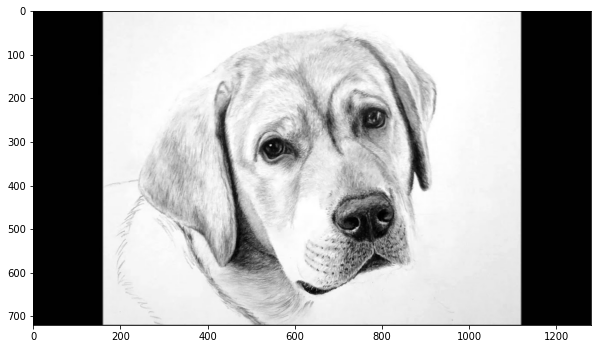

In [ ]:
import matplotlib.image
import matplotlib.pyplot
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rcParams, ticker, cm
from matplotlib import collections as mc
import numpy as onp 
rcParams['animation.html'] = 'jshtml'  # Makes the default animation an interactive video
rcParams['animation.embed_limit'] = 2**128  # Allow bigger animations

img = matplotlib.image.imread('/content/drive/MyDrive/CS699/homework #2/labrador.jpg')

# plot and visualize
fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img)
matplotlib.pyplot.show()

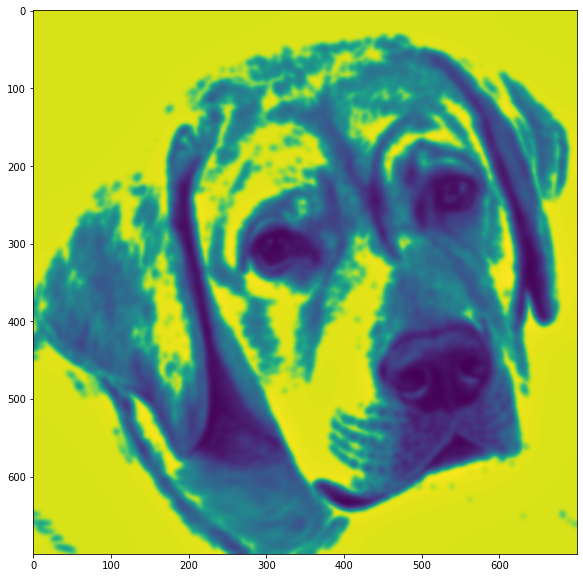

In [ ]:
import jax

density, energy = prepare_image(
    img, crop=(10, 710, 240, 940), white_cutoff=225, gauss_sigma=3, background=0.01
)

x_max, y_max = density.shape
xp = jax.numpy.arange(x_max)
yp = jax.numpy.arange(y_max)
zp = jax.numpy.array(density)

# You may use fill value to enforce some boundary conditions or some other way to enforce boundary conditions
energy_fn = lambda coord: continuous_energy_from_image(coord, xp, yp, zp, fill_value=0)
energy_fn_grad = jax.grad(energy_fn)

fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(energy)
matplotlib.pyplot.show()

In [ ]:
import jax.numpy as np
import jax
from jax import random

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)

def hamiltonian_monte_carlo(x0, f, k, epsilon):
    """Run HMC for k steps, with step size epsilon"""
    v = onp.random.randn(*x0.shape)  # Not the correct way to get randoms in JAX
    g = jax.grad(f)  # Gradient of energy function
    x = x0  # save the original state, in case we reject the update
    for i in range(k):
        v = v - 0.5 * epsilon * g(x)  # half step in v
        x = x + epsilon * v  # full step in x
        v = v - 0.5 * epsilon * g(x)  # half step in v  
        # more efficient to combine half-steps
    if onp.random.random() > np.exp(f(x0) - f(x)):
        print("Metropolis- Hastings REJECT", f(x0), f(x))
        x = x0
    return x

In [ ]:
## Couple of different strategies: use multiple runs from one sample vs. use a run from multiple samples

d = 2  # dimensionality 
n_iter = 3000
k = 200
epsilon = 0.1

sampled_outputs = onp.zeros((1, n_iter, 2), dtype=density.dtype)  

for i in range(n_iter):
    key = jax.random.PRNGKey(i)
    key, subkey = jax.random.split(key)
    init_sample = sample_from_image_density(1, density, subkey).flatten()
    sampled_outputs[0, i] = hamiltonian_monte_carlo(init_sample, energy_fn, k, 0.01)

Metropolis- Hastings REJECT 1.6554933 2.0143814
Metropolis- Hastings REJECT 2.243117 3.01026
Metropolis- Hastings REJECT 0.2367889 0.34715194
Metropolis- Hastings REJECT 0.46168214 0.52051693
Metropolis- Hastings REJECT 1.5695392 1.7568407
Metropolis- Hastings REJECT 1.0694536 1.1286373
Metropolis- Hastings REJECT 0.37286493 0.4901055
Metropolis- Hastings REJECT 3.4907217 3.6206903
Metropolis- Hastings REJECT 1.5599419 1.8910792
Metropolis- Hastings REJECT 0.5409864 0.74888355
Metropolis- Hastings REJECT 2.5019865 3.2466106
Metropolis- Hastings REJECT 1.0700214 1.1449745
Metropolis- Hastings REJECT 2.213927 3.2965817
Metropolis- Hastings REJECT 0.1731989 0.19979659
Metropolis- Hastings REJECT 1.3141502 1.3755561
Metropolis- Hastings REJECT 0.6408876 0.6630577
Metropolis- Hastings REJECT 0.118860446 0.259404
Metropolis- Hastings REJECT 1.6036906 1.95694
Metropolis- Hastings REJECT 2.1532078 2.4323013
Metropolis- Hastings REJECT 2.5451155 2.917179
Metropolis- Hastings REJECT 0.17258848 0

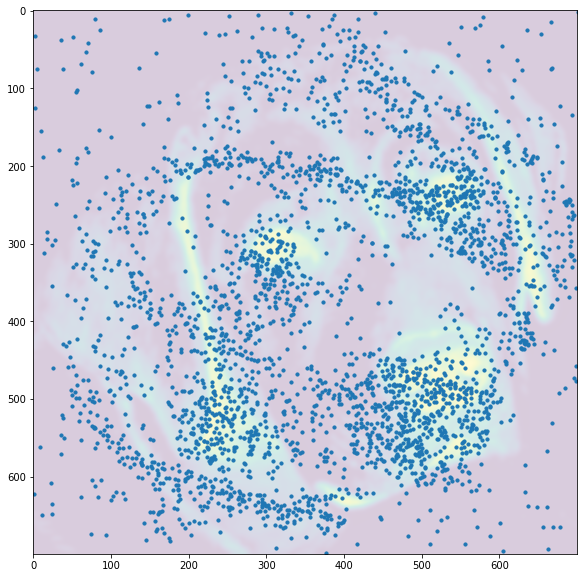

In [ ]:
fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sampled_outputs[:, :, 0], sampled_outputs[:, :, 1], s=10)
ax.imshow(density, alpha=0.2)
matplotlib.pyplot.show()

In [ ]:
## Couple of different strategies: use multiple runs from one sample vs. use a run from multiple samples
from tqdm import tqdm

d = 2  # dimensionality 
n_iter = 3000
k = 100
epsilon = 0.1

sampled_outputs = onp.zeros((1, n_iter, 2), dtype=density.dtype)
key = jax.random.PRNGKey(1)
key, subkey = jax.random.split(key)
init_sample = sample_from_image_density(1, density, subkey).flatten()

with tqdm(total=n_iter) as pbar:
  for i in range(n_iter):
      init_sample = hamiltonian_monte_carlo(init_sample, energy_fn, k, epsilon)
      sampled_outputs[0, i] = init_sample
      pbar.update(1)

  2%|▏         | 59/3000 [13:08<10:51:42, 13.30s/it]

Metropolis- Hastings REJECT 0.6169171 0.70000935


  2%|▏         | 69/3000 [15:22<10:57:15, 13.45s/it]

Metropolis- Hastings REJECT 0.500865 0.7071037


  2%|▏         | 70/3000 [15:35<11:00:40, 13.53s/it]

Metropolis- Hastings REJECT 0.500865 0.71014005


  2%|▏         | 71/3000 [15:49<11:00:21, 13.53s/it]

Metropolis- Hastings REJECT 0.500865 1.349887


  2%|▏         | 72/3000 [16:03<11:02:26, 13.57s/it]

Metropolis- Hastings REJECT 0.500865 0.69430494


  3%|▎         | 79/3000 [17:38<10:53:17, 13.42s/it]

Metropolis- Hastings REJECT 0.31134278 0.79066163


  3%|▎         | 94/3000 [20:56<10:44:46, 13.31s/it]

Metropolis- Hastings REJECT 1.8067291 2.9308963


  3%|▎         | 95/3000 [21:09<10:43:57, 13.30s/it]

Metropolis- Hastings REJECT 1.8067291 2.0283656


  4%|▎         | 106/3000 [23:35<10:39:06, 13.25s/it]

Metropolis- Hastings REJECT 0.7844685 1.984897


  4%|▍         | 116/3000 [25:46<10:32:23, 13.16s/it]

Metropolis- Hastings REJECT 1.0366279 2.994923


  4%|▍         | 122/3000 [27:06<10:35:30, 13.25s/it]

Metropolis- Hastings REJECT 1.0841074 2.2528827


  5%|▌         | 154/3000 [34:11<10:29:18, 13.27s/it]

Metropolis- Hastings REJECT 1.7086406 2.6334727


  5%|▌         | 157/3000 [34:50<10:23:57, 13.17s/it]

Metropolis- Hastings REJECT 1.5202879 1.7936478


  5%|▌         | 158/3000 [35:04<10:24:53, 13.19s/it]

Metropolis- Hastings REJECT 1.5202879 1.9497685


  5%|▌         | 159/3000 [35:17<10:26:11, 13.22s/it]

Metropolis- Hastings REJECT 1.5202879 3.0131474


  6%|▌         | 184/3000 [40:46<10:18:04, 13.17s/it]

Metropolis- Hastings REJECT 1.4388047 2.303425


  6%|▌         | 185/3000 [40:59<10:18:19, 13.18s/it]

Metropolis- Hastings REJECT 1.4388047 2.7966073


  6%|▋         | 195/3000 [43:12<10:21:24, 13.29s/it]

Metropolis- Hastings REJECT 0.9594662 1.7343835


  7%|▋         | 205/3000 [45:23<10:17:01, 13.25s/it]

Metropolis- Hastings REJECT 0.90848553 1.0378835


  8%|▊         | 233/3000 [51:35<10:08:29, 13.19s/it]

Metropolis- Hastings REJECT 0.6196581 0.9356491


  8%|▊         | 239/3000 [52:55<10:15:51, 13.38s/it]

Metropolis- Hastings REJECT 0.53351283 1.8534207


  9%|▉         | 281/3000 [1:02:10<10:08:51, 13.44s/it]

Metropolis- Hastings REJECT 0.47016442 0.79166234


 10%|▉         | 286/3000 [1:03:18<10:15:10, 13.60s/it]

Metropolis- Hastings REJECT 0.120409004 0.172942


 10%|█         | 301/3000 [1:06:41<10:17:12, 13.72s/it]

Metropolis- Hastings REJECT 0.033055287 0.8372331


 11%|█         | 316/3000 [1:10:07<10:15:10, 13.75s/it]

Metropolis- Hastings REJECT 0.049035836 0.3747008


 11%|█         | 318/3000 [1:10:34<10:13:59, 13.74s/it]

Metropolis- Hastings REJECT 0.06752206 0.46476102


 11%|█         | 319/3000 [1:10:48<10:12:23, 13.71s/it]

Metropolis- Hastings REJECT 0.06752206 0.14703014


 11%|█         | 320/3000 [1:11:02<10:15:36, 13.78s/it]

Metropolis- Hastings REJECT 0.06752206 0.36637473


 11%|█         | 334/3000 [1:14:11<9:59:12, 13.49s/it]

Metropolis- Hastings REJECT 0.41033977 0.91995454


 12%|█▏        | 347/3000 [1:17:07<10:03:06, 13.64s/it]

Metropolis- Hastings REJECT 0.06324395 0.29391122


 12%|█▏        | 353/3000 [1:18:29<10:03:33, 13.68s/it]

Metropolis- Hastings REJECT 0.042342097 0.4427577


 12%|█▏        | 363/3000 [1:20:46<10:01:59, 13.70s/it]

Metropolis- Hastings REJECT 0.333357 1.386004


 12%|█▏        | 365/3000 [1:21:13<9:58:28, 13.63s/it]

Metropolis- Hastings REJECT 0.26011133 0.965006


 13%|█▎        | 399/3000 [1:28:53<9:50:32, 13.62s/it]

Metropolis- Hastings REJECT 0.12238817 0.30979466


 14%|█▎        | 406/3000 [1:30:28<9:44:51, 13.53s/it]

Metropolis- Hastings REJECT 0.10958296 0.32893717


 14%|█▍        | 423/3000 [1:34:19<9:43:07, 13.58s/it]

Metropolis- Hastings REJECT 0.33061478 0.9783884


 14%|█▍        | 425/3000 [1:34:46<9:42:48, 13.58s/it]

Metropolis- Hastings REJECT 0.49639207 0.9640963


 14%|█▍        | 435/3000 [1:37:00<9:32:59, 13.40s/it]

Metropolis- Hastings REJECT 0.5015521 0.9804307


 15%|█▍        | 439/3000 [1:37:54<9:31:18, 13.38s/it]

Metropolis- Hastings REJECT 0.44497585 1.1088604


 15%|█▍        | 449/3000 [1:40:07<9:28:21, 13.37s/it]

Metropolis- Hastings REJECT 0.36244625 0.8647833


 15%|█▌        | 458/3000 [1:42:08<9:29:18, 13.44s/it]

Metropolis- Hastings REJECT 0.63488305 0.8106544


 15%|█▌        | 460/3000 [1:42:35<9:32:49, 13.53s/it]

Metropolis- Hastings REJECT 0.84812397 1.9718487


 16%|█▌        | 471/3000 [1:45:03<9:25:24, 13.41s/it]

Metropolis- Hastings REJECT 0.078058966 0.19378804


 16%|█▌        | 486/3000 [1:48:24<9:21:06, 13.39s/it]

Metropolis- Hastings REJECT 0.6747499 0.835824


 17%|█▋        | 516/3000 [1:55:06<9:21:32, 13.56s/it]

Metropolis- Hastings REJECT 0.1916286 0.626206


 17%|█▋        | 521/3000 [1:56:13<9:16:05, 13.46s/it]

Metropolis- Hastings REJECT 0.3518936 0.61083615


 17%|█▋        | 524/3000 [1:56:53<9:13:05, 13.40s/it]

Metropolis- Hastings REJECT 0.057514198 0.3570818


 20%|█▉        | 598/3000 [2:13:27<9:01:44, 13.53s/it]

Metropolis- Hastings REJECT 0.3586866 0.4588397


 20%|██        | 604/3000 [2:14:49<9:04:10, 13.63s/it]

Metropolis- Hastings REJECT 0.43702337 1.4524567


 21%|██        | 633/3000 [2:21:19<8:50:08, 13.44s/it]

Metropolis- Hastings REJECT 0.4974426 1.3362571


 21%|██        | 634/3000 [2:21:32<8:49:12, 13.42s/it]

Metropolis- Hastings REJECT 0.4974426 1.0467969


 21%|██        | 635/3000 [2:21:46<8:49:39, 13.44s/it]

Metropolis- Hastings REJECT 0.4974426 1.0474422


 21%|██        | 636/3000 [2:21:59<8:47:49, 13.40s/it]

Metropolis- Hastings REJECT 0.4974426 1.1869411


 23%|██▎       | 692/3000 [2:34:30<8:40:08, 13.52s/it]

Metropolis- Hastings REJECT 0.10282374 0.5219986


 23%|██▎       | 701/3000 [2:36:31<8:40:50, 13.59s/it]

Metropolis- Hastings REJECT 0.27809668 1.3656279


 23%|██▎       | 702/3000 [2:36:44<8:40:03, 13.58s/it]

Metropolis- Hastings REJECT 0.27809668 0.53956944


 24%|██▍       | 723/3000 [2:41:26<8:32:39, 13.51s/it]

Metropolis- Hastings REJECT 0.037803505 0.10371628


 25%|██▍       | 746/3000 [2:46:35<8:21:59, 13.36s/it]

Metropolis- Hastings REJECT 0.5255221 0.68270516


 25%|██▌       | 755/3000 [2:48:36<8:23:12, 13.45s/it]

Metropolis- Hastings REJECT 0.82784444 1.1418188


 26%|██▌       | 769/3000 [2:51:43<8:19:08, 13.42s/it]

Metropolis- Hastings REJECT 0.21015957 0.809922


 26%|██▋       | 788/3000 [2:55:57<8:13:17, 13.38s/it]

Metropolis- Hastings REJECT 0.36086354 1.3893578


 27%|██▋       | 799/3000 [2:58:26<8:17:31, 13.56s/it]

Metropolis- Hastings REJECT 0.20816417 0.23018599


 27%|██▋       | 801/3000 [2:58:53<8:16:36, 13.55s/it]

Metropolis- Hastings REJECT 0.22636162 0.45364118


 27%|██▋       | 821/3000 [3:03:21<8:08:44, 13.46s/it]

Metropolis- Hastings REJECT 0.046028916 0.36660555


 28%|██▊       | 829/3000 [3:05:09<8:04:06, 13.38s/it]

Metropolis- Hastings REJECT 0.5530541 0.62210345


 29%|██▊       | 857/3000 [3:11:26<8:01:07, 13.47s/it]

Metropolis- Hastings REJECT 0.08237685 0.25269118


 29%|██▉       | 863/3000 [3:12:48<8:04:05, 13.59s/it]

Metropolis- Hastings REJECT 0.030785765 0.29791433


 29%|██▉       | 866/3000 [3:13:28<7:59:17, 13.48s/it]

Metropolis- Hastings REJECT 0.04800309 0.8487596


 29%|██▉       | 874/3000 [3:15:16<7:56:59, 13.46s/it]

Metropolis- Hastings REJECT 0.3944873 1.3586663


 30%|██▉       | 886/3000 [3:17:57<7:55:27, 13.49s/it]

Metropolis- Hastings REJECT 0.40997177 0.49059808


 30%|██▉       | 899/3000 [3:20:51<7:48:58, 13.39s/it]

Metropolis- Hastings REJECT 0.080256134 0.25202775


 30%|███       | 905/3000 [3:22:12<7:46:56, 13.37s/it]

Metropolis- Hastings REJECT 0.04043702 0.17396905


 31%|███       | 922/3000 [3:25:58<7:42:35, 13.36s/it]

Metropolis- Hastings REJECT 0.09249789 0.33085364


 31%|███       | 924/3000 [3:26:25<7:43:32, 13.40s/it]

Metropolis- Hastings REJECT 0.08587039 0.15215981


 31%|███       | 929/3000 [3:27:32<7:43:41, 13.43s/it]

Metropolis- Hastings REJECT 0.26475024 1.4996012


 31%|███       | 932/3000 [3:28:13<7:48:17, 13.59s/it]

Metropolis- Hastings REJECT 0.27058613 0.7149129


 31%|███       | 934/3000 [3:28:40<7:45:44, 13.53s/it]

Metropolis- Hastings REJECT 0.053342354 0.4192307


 32%|███▏      | 947/3000 [3:31:34<7:42:11, 13.51s/it]

Metropolis- Hastings REJECT 0.17127058 0.6176224


 32%|███▏      | 948/3000 [3:31:47<7:42:38, 13.53s/it]

Metropolis- Hastings REJECT 0.17127058 0.58548707


 33%|███▎      | 996/3000 [3:42:48<7:41:08, 13.81s/it]

Metropolis- Hastings REJECT 0.12687258 0.32549983


 33%|███▎      | 1004/3000 [3:44:38<7:33:32, 13.63s/it]

Metropolis- Hastings REJECT 0.5669149 0.5861426


 34%|███▍      | 1022/3000 [3:48:41<7:28:18, 13.60s/it]

Metropolis- Hastings REJECT 0.15706378 0.73501915


 35%|███▍      | 1046/3000 [3:54:04<7:21:49, 13.57s/it]

Metropolis- Hastings REJECT 0.0063703475 0.24620798


 35%|███▌      | 1053/3000 [3:55:38<7:17:49, 13.49s/it]

Metropolis- Hastings REJECT 0.46997654 1.7719111


 35%|███▌      | 1054/3000 [3:55:51<7:20:04, 13.57s/it]

Metropolis- Hastings REJECT 0.46997654 1.6100376


 35%|███▌      | 1055/3000 [3:56:05<7:18:56, 13.54s/it]

Metropolis- Hastings REJECT 0.46997654 0.9606147


 35%|███▌      | 1063/3000 [3:57:53<7:19:36, 13.62s/it]

Metropolis- Hastings REJECT 0.5059214 1.2711267


 36%|███▌      | 1084/3000 [4:02:37<7:11:06, 13.50s/it]

Metropolis- Hastings REJECT 0.09029502 0.44687235


 37%|███▋      | 1099/3000 [4:06:01<7:11:46, 13.63s/it]

Metropolis- Hastings REJECT 0.3908332 0.5519449


 37%|███▋      | 1109/3000 [4:08:17<7:11:05, 13.68s/it]

Metropolis- Hastings REJECT 0.25275233 0.34117278


 37%|███▋      | 1114/3000 [4:09:24<7:02:49, 13.45s/it]

Metropolis- Hastings REJECT 0.24195704 0.69122463


 37%|███▋      | 1115/3000 [4:09:38<7:03:18, 13.47s/it]

Metropolis- Hastings REJECT 0.24195704 0.42653456


 38%|███▊      | 1129/3000 [4:12:45<6:55:39, 13.33s/it]

Metropolis- Hastings REJECT 0.0686722 0.38806602


 39%|███▊      | 1158/3000 [4:19:09<6:44:13, 13.17s/it]

Metropolis- Hastings REJECT 0.026250802 0.24654762


 39%|███▉      | 1176/3000 [4:23:06<6:37:34, 13.08s/it]

Metropolis- Hastings REJECT 0.010320329 0.045639537


 40%|███▉      | 1187/3000 [4:25:31<6:38:33, 13.19s/it]

Metropolis- Hastings REJECT 0.18388428 0.609408


 40%|███▉      | 1196/3000 [4:27:30<6:38:58, 13.27s/it]

Metropolis- Hastings REJECT 0.010401755 0.1677192


 40%|████      | 1212/3000 [4:31:04<6:40:01, 13.42s/it]

Metropolis- Hastings REJECT 0.036467273 0.29540896


 41%|████      | 1230/3000 [4:35:05<6:34:16, 13.37s/it]

Metropolis- Hastings REJECT 0.53146625 0.6611679


 41%|████      | 1234/3000 [4:35:59<6:35:17, 13.43s/it]

Metropolis- Hastings REJECT 0.31613204 0.34643292


 42%|████▏     | 1251/3000 [4:39:45<6:26:15, 13.25s/it]

Metropolis- Hastings REJECT 0.27059582 0.83399856


 42%|████▏     | 1263/3000 [4:42:26<6:27:56, 13.40s/it]

Metropolis- Hastings REJECT 0.06993828 0.28842217


 42%|████▎     | 1275/3000 [4:45:08<6:30:09, 13.57s/it]

Metropolis- Hastings REJECT 0.17488994 0.7976543


 43%|████▎     | 1291/3000 [4:48:44<6:24:47, 13.51s/it]

Metropolis- Hastings REJECT 0.7032889 1.1183163


 44%|████▍     | 1314/3000 [4:53:54<6:19:26, 13.50s/it]

Metropolis- Hastings REJECT 0.09788026 0.29968154


 44%|████▍     | 1326/3000 [4:56:38<6:20:09, 13.63s/it]

Metropolis- Hastings REJECT 0.117243044 0.36469722


 44%|████▍     | 1329/3000 [4:57:19<6:17:20, 13.55s/it]

Metropolis- Hastings REJECT 0.028413698 0.16658202


 45%|████▌     | 1359/3000 [5:04:02<6:09:32, 13.51s/it]

Metropolis- Hastings REJECT 0.32996964 0.85860103


 46%|████▌     | 1365/3000 [5:05:22<6:03:31, 13.34s/it]

Metropolis- Hastings REJECT 0.030267602 0.4421808


 46%|████▌     | 1366/3000 [5:05:35<6:05:49, 13.43s/it]

Metropolis- Hastings REJECT 0.030267602 0.15249063


 46%|████▌     | 1375/3000 [5:07:37<6:07:25, 13.57s/it]

Metropolis- Hastings REJECT 0.14750646 0.46740645


 46%|████▋     | 1390/3000 [5:10:59<5:59:13, 13.39s/it]

Metropolis- Hastings REJECT 0.30001315 0.5440981


 46%|████▋     | 1393/3000 [5:11:39<5:59:26, 13.42s/it]

Metropolis- Hastings REJECT 0.35132843 0.5170181


 47%|████▋     | 1413/3000 [5:16:07<5:54:03, 13.39s/it]

Metropolis- Hastings REJECT 0.3718412 1.3956256


 47%|████▋     | 1414/3000 [5:16:21<5:53:42, 13.38s/it]

Metropolis- Hastings REJECT 0.3718412 1.1106608


 47%|████▋     | 1416/3000 [5:16:48<5:55:18, 13.46s/it]

Metropolis- Hastings REJECT 0.7143 1.2441187


 48%|████▊     | 1439/3000 [5:21:56<5:50:50, 13.48s/it]

Metropolis- Hastings REJECT 0.40916172 0.7652946


 48%|████▊     | 1440/3000 [5:22:09<5:51:26, 13.52s/it]

Metropolis- Hastings REJECT 0.40916172 1.1237214


 48%|████▊     | 1445/3000 [5:23:16<5:49:54, 13.50s/it]

Metropolis- Hastings REJECT 0.31015947 0.5556317


 48%|████▊     | 1451/3000 [5:24:36<5:44:40, 13.35s/it]

Metropolis- Hastings REJECT 1.9262595 2.2558775


 49%|████▉     | 1464/3000 [5:27:30<5:46:21, 13.53s/it]

Metropolis- Hastings REJECT 0.54271185 1.0495839


 49%|████▉     | 1473/3000 [5:29:32<5:43:18, 13.49s/it]

Metropolis- Hastings REJECT 1.5320991 1.8084491


 49%|████▉     | 1481/3000 [5:31:20<5:44:05, 13.59s/it]

Metropolis- Hastings REJECT 0.98692524 1.5128978


 49%|████▉     | 1482/3000 [5:31:33<5:41:54, 13.51s/it]

Metropolis- Hastings REJECT 0.98692524 1.5545918


 49%|████▉     | 1484/3000 [5:32:00<5:41:28, 13.51s/it]

Metropolis- Hastings REJECT 1.076145 1.3852465


 50%|████▉     | 1489/3000 [5:33:08<5:41:10, 13.55s/it]

Metropolis- Hastings REJECT 1.2713842 1.6939824


 50%|████▉     | 1495/3000 [5:34:28<5:35:18, 13.37s/it]

Metropolis- Hastings REJECT 1.0144825 1.1469636


 50%|█████     | 1504/3000 [5:36:29<5:35:12, 13.44s/it]

Metropolis- Hastings REJECT 0.97796226 1.091903


 50%|█████     | 1507/3000 [5:37:10<5:36:22, 13.52s/it]

Metropolis- Hastings REJECT 1.1739827 1.7227898


 50%|█████     | 1509/3000 [5:37:37<5:38:09, 13.61s/it]

Metropolis- Hastings REJECT 1.0349157 1.088374


 50%|█████     | 1510/3000 [5:37:50<5:33:21, 13.42s/it]

Metropolis- Hastings REJECT 1.0349157 1.1779877


 50%|█████     | 1515/3000 [5:38:57<5:32:55, 13.45s/it]

Metropolis- Hastings REJECT 1.1156873 1.2829288


 51%|█████     | 1518/3000 [5:39:37<5:28:50, 13.31s/it]

Metropolis- Hastings REJECT 1.1242285 1.2827797


 51%|█████     | 1522/3000 [5:40:31<5:31:28, 13.46s/it]

Metropolis- Hastings REJECT 1.473737 2.2413375


 51%|█████▏    | 1538/3000 [5:44:06<5:26:16, 13.39s/it]

Metropolis- Hastings REJECT 1.3283403 1.7303717


 52%|█████▏    | 1549/3000 [5:46:32<5:24:17, 13.41s/it]

Metropolis- Hastings REJECT 1.4015691 2.146016


 52%|█████▏    | 1557/3000 [5:48:20<5:23:54, 13.47s/it]

Metropolis- Hastings REJECT 1.0063596 1.1778862


 52%|█████▏    | 1559/3000 [5:48:47<5:24:01, 13.49s/it]

Metropolis- Hastings REJECT 1.0691986 1.1706718


 53%|█████▎    | 1594/3000 [5:56:37<5:15:12, 13.45s/it]

Metropolis- Hastings REJECT 1.1526198 1.6155807


 54%|█████▍    | 1633/3000 [6:05:25<5:07:44, 13.51s/it]

Metropolis- Hastings REJECT 1.2326066 2.00869


 55%|█████▍    | 1637/3000 [6:06:19<5:06:40, 13.50s/it]

Metropolis- Hastings REJECT 1.0033997 3.334479


 55%|█████▍    | 1639/3000 [6:06:46<5:04:37, 13.43s/it]

Metropolis- Hastings REJECT 1.0150084 1.5092199


 55%|█████▍    | 1642/3000 [6:07:28<5:10:29, 13.72s/it]

Metropolis- Hastings REJECT 1.1861342 2.268476


 55%|█████▌    | 1650/3000 [6:09:16<5:04:20, 13.53s/it]

Metropolis- Hastings REJECT 1.3958039 1.7070763


 55%|█████▌    | 1656/3000 [6:10:37<5:01:42, 13.47s/it]

Metropolis- Hastings REJECT 1.057348 1.2431467


 55%|█████▌    | 1660/3000 [6:11:30<5:01:46, 13.51s/it]

Metropolis- Hastings REJECT 1.2257962 1.5579553


 56%|█████▌    | 1665/3000 [6:12:38<5:01:35, 13.55s/it]

Metropolis- Hastings REJECT 1.0437162 1.2877691


 56%|█████▌    | 1686/3000 [6:17:20<4:55:43, 13.50s/it]

Metropolis- Hastings REJECT 1.1448492 1.2578682


 57%|█████▋    | 1710/3000 [6:22:43<4:48:06, 13.40s/it]

Metropolis- Hastings REJECT 0.8067529 1.4560176


 57%|█████▋    | 1714/3000 [6:23:36<4:45:16, 13.31s/it]

Metropolis- Hastings REJECT 1.0131277 1.1682062


 57%|█████▋    | 1715/3000 [6:23:50<4:47:09, 13.41s/it]

Metropolis- Hastings REJECT 1.0131277 1.6233172


 57%|█████▋    | 1720/3000 [6:24:57<4:45:05, 13.36s/it]

Metropolis- Hastings REJECT 0.59143186 0.7238594


 58%|█████▊    | 1734/3000 [6:28:05<4:42:36, 13.39s/it]

Metropolis- Hastings REJECT 0.014575269 0.40014488


 58%|█████▊    | 1743/3000 [6:30:06<4:40:21, 13.38s/it]

Metropolis- Hastings REJECT 0.049938064 0.15286233


 59%|█████▉    | 1781/3000 [6:38:37<4:33:41, 13.47s/it]

Metropolis- Hastings REJECT 0.021312192 0.045161135


 60%|█████▉    | 1797/3000 [6:42:15<4:35:22, 13.73s/it]

Metropolis- Hastings REJECT 0.61240387 1.608401


 60%|██████    | 1810/3000 [6:45:11<4:31:26, 13.69s/it]

Metropolis- Hastings REJECT 0.23098817 0.43633074


 60%|██████    | 1813/3000 [6:45:51<4:27:05, 13.50s/it]

Metropolis- Hastings REJECT 1.1290236 1.7412589


 61%|██████    | 1823/3000 [6:48:06<4:23:04, 13.41s/it]

Metropolis- Hastings REJECT 0.35112646 0.77039784


 63%|██████▎   | 1878/3000 [7:00:29<4:18:17, 13.81s/it]

Metropolis- Hastings REJECT 0.19832106 0.47662032


 63%|██████▎   | 1886/3000 [7:02:19<4:12:46, 13.61s/it]

Metropolis- Hastings REJECT 0.46287835 1.5691749


 64%|██████▍   | 1913/3000 [7:08:25<4:05:55, 13.57s/it]

Metropolis- Hastings REJECT 0.11286811 0.6471912


 64%|██████▍   | 1916/3000 [7:09:05<4:03:14, 13.46s/it]

Metropolis- Hastings REJECT 0.1075706 0.17269063


 64%|██████▍   | 1925/3000 [7:11:08<4:05:28, 13.70s/it]

Metropolis- Hastings REJECT 0.06541005 0.15762445


 64%|██████▍   | 1927/3000 [7:11:35<4:05:05, 13.70s/it]

Metropolis- Hastings REJECT 0.23953377 0.5501539


 64%|██████▍   | 1929/3000 [7:12:03<4:03:09, 13.62s/it]

Metropolis- Hastings REJECT 0.20086166 0.32313097


 64%|██████▍   | 1935/3000 [7:13:24<4:02:15, 13.65s/it]

Metropolis- Hastings REJECT 0.12901147 0.43349516


 65%|██████▌   | 1954/3000 [7:17:41<3:54:26, 13.45s/it]

Metropolis- Hastings REJECT 0.14380072 0.57959


 67%|██████▋   | 2004/3000 [7:28:57<3:42:49, 13.42s/it]

Metropolis- Hastings REJECT 0.04255093 0.33323422


 67%|██████▋   | 2021/3000 [7:32:46<3:41:17, 13.56s/it]

Metropolis- Hastings REJECT 0.16527137 0.4786326


 68%|██████▊   | 2030/3000 [7:34:48<3:39:12, 13.56s/it]

Metropolis- Hastings REJECT 0.16683593 0.36464316


 68%|██████▊   | 2034/3000 [7:35:42<3:39:29, 13.63s/it]

Metropolis- Hastings REJECT 0.035765387 0.18638612


 68%|██████▊   | 2040/3000 [7:37:03<3:36:47, 13.55s/it]

Metropolis- Hastings REJECT 0.17105556 0.22012532


 68%|██████▊   | 2047/3000 [7:38:38<3:34:38, 13.51s/it]

Metropolis- Hastings REJECT 0.39292789 0.5627885


 68%|██████▊   | 2049/3000 [7:39:05<3:34:23, 13.53s/it]

Metropolis- Hastings REJECT 0.37441468 0.8686551


 68%|██████▊   | 2050/3000 [7:39:19<3:34:30, 13.55s/it]

Metropolis- Hastings REJECT 0.37441468 0.681506


 69%|██████▉   | 2070/3000 [7:43:49<3:28:53, 13.48s/it]

Metropolis- Hastings REJECT 0.016945556 0.139492


 69%|██████▉   | 2079/3000 [7:45:49<3:24:20, 13.31s/it]

Metropolis- Hastings REJECT 0.48509294 0.6855296


 69%|██████▉   | 2080/3000 [7:46:03<3:25:55, 13.43s/it]

Metropolis- Hastings REJECT 0.48509294 0.6861172


 70%|██████▉   | 2092/3000 [7:48:43<3:22:42, 13.39s/it]

Metropolis- Hastings REJECT 0.02658465 0.11109423


 70%|██████▉   | 2098/3000 [7:50:04<3:21:24, 13.40s/it]

Metropolis- Hastings REJECT 0.035829633 0.6223575


 71%|███████   | 2137/3000 [7:58:50<3:15:09, 13.57s/it]

Metropolis- Hastings REJECT 0.40927103 0.73081285


 71%|███████▏  | 2138/3000 [7:59:03<3:15:00, 13.57s/it]

Metropolis- Hastings REJECT 0.40927103 0.6416996


 72%|███████▏  | 2147/3000 [8:01:05<3:12:25, 13.53s/it]

Metropolis- Hastings REJECT 0.34476873 0.7880252


 72%|███████▏  | 2152/3000 [8:02:13<3:11:47, 13.57s/it]

Metropolis- Hastings REJECT 0.075916186 0.18755303


 72%|███████▏  | 2174/3000 [8:07:08<3:05:14, 13.46s/it]

Metropolis- Hastings REJECT 0.032153077 0.11932696


 73%|███████▎  | 2187/3000 [8:10:05<3:03:56, 13.58s/it]

Metropolis- Hastings REJECT 0.5234438 0.7278932


 73%|███████▎  | 2191/3000 [8:10:59<3:02:34, 13.54s/it]

Metropolis- Hastings REJECT 0.82412624 2.0434668


 73%|███████▎  | 2192/3000 [8:11:13<3:03:50, 13.65s/it]

Metropolis- Hastings REJECT 0.82412624 2.2098825


 74%|███████▎  | 2205/3000 [8:14:09<3:00:27, 13.62s/it]

Metropolis- Hastings REJECT 0.51643586 1.7201716


 74%|███████▎  | 2209/3000 [8:15:04<3:00:21, 13.68s/it]

Metropolis- Hastings REJECT 0.45193803 0.6109637


 74%|███████▎  | 2210/3000 [8:15:18<3:00:29, 13.71s/it]

Metropolis- Hastings REJECT 0.45193803 0.55053765


 74%|███████▎  | 2211/3000 [8:15:32<3:01:04, 13.77s/it]

Metropolis- Hastings REJECT 0.45193803 0.95408046


 74%|███████▍  | 2213/3000 [8:15:59<2:59:18, 13.67s/it]

Metropolis- Hastings REJECT 0.42940667 0.96047986


 74%|███████▍  | 2220/3000 [8:17:33<2:54:59, 13.46s/it]

Metropolis- Hastings REJECT 0.4530622 1.4022422


 74%|███████▍  | 2222/3000 [8:18:00<2:55:34, 13.54s/it]

Metropolis- Hastings REJECT 0.57885987 1.5408783


 75%|███████▌  | 2260/3000 [8:26:32<2:44:47, 13.36s/it]

Metropolis- Hastings REJECT 0.045450892 0.20469187


 76%|███████▌  | 2281/3000 [8:31:13<2:43:26, 13.64s/it]

Metropolis- Hastings REJECT 0.010467224 0.54615915


 76%|███████▌  | 2286/3000 [8:32:22<2:42:11, 13.63s/it]

Metropolis- Hastings REJECT 0.20523825 0.66100746


 76%|███████▋  | 2293/3000 [8:33:56<2:38:45, 13.47s/it]

Metropolis- Hastings REJECT 0.9081138 1.1002694


 76%|███████▋  | 2294/3000 [8:34:10<2:40:09, 13.61s/it]

Metropolis- Hastings REJECT 0.9081138 1.196469


 77%|███████▋  | 2307/3000 [8:37:03<2:34:59, 13.42s/it]

Metropolis- Hastings REJECT 0.52737045 0.95087737


 77%|███████▋  | 2313/3000 [8:38:23<2:33:27, 13.40s/it]

Metropolis- Hastings REJECT 0.19689001 0.32690534


 77%|███████▋  | 2315/3000 [8:38:50<2:32:53, 13.39s/it]

Metropolis- Hastings REJECT 0.14098674 0.29480013


 77%|███████▋  | 2316/3000 [8:39:03<2:31:43, 13.31s/it]

Metropolis- Hastings REJECT 0.14098674 0.34694237


 78%|███████▊  | 2350/3000 [8:46:42<2:26:35, 13.53s/it]

Metropolis- Hastings REJECT 0.105340146 0.30243772


 78%|███████▊  | 2354/3000 [8:47:36<2:24:54, 13.46s/it]

Metropolis- Hastings REJECT 0.038364857 0.12225513


 80%|███████▉  | 2385/3000 [8:54:34<2:19:01, 13.56s/it]

Metropolis- Hastings REJECT 0.3022907 0.62843764


 80%|████████  | 2406/3000 [8:59:20<2:14:23, 13.57s/it]

Metropolis- Hastings REJECT 0.23231639 0.58500475


 81%|████████  | 2420/3000 [9:02:31<2:11:33, 13.61s/it]

Metropolis- Hastings REJECT 0.05947546 0.38736483


 81%|████████  | 2426/3000 [9:03:52<2:09:50, 13.57s/it]

Metropolis- Hastings REJECT 0.10194976 0.49824995


 82%|████████▏ | 2448/3000 [9:08:50<2:04:11, 13.50s/it]

Metropolis- Hastings REJECT 0.0426938 0.3012947


 82%|████████▏ | 2458/3000 [9:11:06<2:02:53, 13.60s/it]

Metropolis- Hastings REJECT 0.036710497 0.11359422


 82%|████████▏ | 2459/3000 [9:11:19<2:01:47, 13.51s/it]

Metropolis- Hastings REJECT 0.036710497 0.3504695


 82%|████████▏ | 2471/3000 [9:14:01<1:59:20, 13.54s/it]

Metropolis- Hastings REJECT 0.12587525 0.28978577


 83%|████████▎ | 2491/3000 [9:18:31<1:54:08, 13.46s/it]

Metropolis- Hastings REJECT 0.03970003 0.22921598


 85%|████████▌ | 2552/3000 [9:32:21<1:42:18, 13.70s/it]

Metropolis- Hastings REJECT 0.35412475 1.5342891


 85%|████████▌ | 2554/3000 [9:32:48<1:41:02, 13.59s/it]

Metropolis- Hastings REJECT 1.3086964 2.3064196


 85%|████████▌ | 2556/3000 [9:33:15<1:41:48, 13.76s/it]

Metropolis- Hastings REJECT 0.7451581 1.8371503


 85%|████████▌ | 2557/3000 [9:33:29<1:40:53, 13.67s/it]

Metropolis- Hastings REJECT 0.7451581 1.8055468


 86%|████████▌ | 2573/3000 [9:37:06<1:36:40, 13.59s/it]

Metropolis- Hastings REJECT 0.07541929 0.15415575


 86%|████████▌ | 2578/3000 [9:38:14<1:36:13, 13.68s/it]

Metropolis- Hastings REJECT 0.12746653 0.23373869


 86%|████████▌ | 2581/3000 [9:38:55<1:34:43, 13.56s/it]

Metropolis- Hastings REJECT 0.22878543 0.45966384


 86%|████████▋ | 2593/3000 [9:41:38<1:32:13, 13.60s/it]

Metropolis- Hastings REJECT 0.52187955 1.8828714


 87%|████████▋ | 2598/3000 [9:42:46<1:30:19, 13.48s/it]

Metropolis- Hastings REJECT 0.43389228 0.5228296


 87%|████████▋ | 2614/3000 [9:46:19<1:24:52, 13.19s/it]

Metropolis- Hastings REJECT 0.28472665 0.45068002


 87%|████████▋ | 2616/3000 [9:46:46<1:25:05, 13.30s/it]

Metropolis- Hastings REJECT 0.14179648 0.38207108


 87%|████████▋ | 2617/3000 [9:46:59<1:25:02, 13.32s/it]

Metropolis- Hastings REJECT 0.14179648 0.3691585


 87%|████████▋ | 2623/3000 [9:48:20<1:24:32, 13.46s/it]

Metropolis- Hastings REJECT 0.11572661 0.18999863


 88%|████████▊ | 2648/3000 [9:53:54<1:19:19, 13.52s/it]

Metropolis- Hastings REJECT 0.22081481 0.6223504


 89%|████████▊ | 2658/3000 [9:56:11<1:17:16, 13.56s/it]

Metropolis- Hastings REJECT 0.0332376 0.10389382


 89%|████████▉ | 2677/3000 [10:00:28<1:11:36, 13.30s/it]

Metropolis- Hastings REJECT 0.08932444 0.21785127


 89%|████████▉ | 2678/3000 [10:00:41<1:11:44, 13.37s/it]

Metropolis- Hastings REJECT 0.08932444 0.30538425


 90%|████████▉ | 2685/3000 [10:02:17<1:12:00, 13.72s/it]

Metropolis- Hastings REJECT 0.116074376 0.2287589


 90%|█████████ | 2710/3000 [10:07:53<1:04:54, 13.43s/it]

Metropolis- Hastings REJECT 0.050938 0.07399741


 90%|█████████ | 2711/3000 [10:08:07<1:04:54, 13.48s/it]

Metropolis- Hastings REJECT 0.050938 0.48958477


 91%|█████████ | 2727/3000 [10:11:45<1:02:07, 13.65s/it]

Metropolis- Hastings REJECT 0.03138157 0.6379178


 91%|█████████ | 2733/3000 [10:13:06<1:00:07, 13.51s/it]

Metropolis- Hastings REJECT 0.12575662 0.6304182


 92%|█████████▏| 2773/3000 [10:22:10<52:40, 13.92s/it]

Metropolis- Hastings REJECT 0.8943117 1.6207169


 93%|█████████▎| 2778/3000 [10:23:18<50:21, 13.61s/it]

Metropolis- Hastings REJECT 0.8820423 2.9592779


 93%|█████████▎| 2788/3000 [10:25:33<47:50, 13.54s/it]

Metropolis- Hastings REJECT 1.0563322 1.7794778


 93%|█████████▎| 2790/3000 [10:26:00<47:18, 13.52s/it]

Metropolis- Hastings REJECT 1.2953664 1.3018403


 96%|█████████▌| 2874/3000 [10:45:00<28:18, 13.48s/it]

Metropolis- Hastings REJECT 0.0051958007 0.54509497


 96%|█████████▌| 2885/3000 [10:47:29<25:50, 13.49s/it]

Metropolis- Hastings REJECT 0.15224484 0.25647256


 96%|█████████▌| 2886/3000 [10:47:42<25:25, 13.38s/it]

Metropolis- Hastings REJECT 0.15224484 1.3746675


 96%|█████████▋| 2890/3000 [10:48:37<24:56, 13.60s/it]

Metropolis- Hastings REJECT 0.826807 0.92246187


 97%|█████████▋| 2903/3000 [10:51:32<21:44, 13.44s/it]

Metropolis- Hastings REJECT 0.027268114 0.5829786


 97%|█████████▋| 2912/3000 [10:53:33<19:47, 13.49s/it]

Metropolis- Hastings REJECT 0.10385454 0.5805525


 97%|█████████▋| 2920/3000 [10:55:21<18:05, 13.56s/it]

Metropolis- Hastings REJECT 0.048175953 0.12567267


 98%|█████████▊| 2939/3000 [10:59:39<13:49, 13.59s/it]

Metropolis- Hastings REJECT 0.14213116 0.5120716


 99%|█████████▉| 2970/3000 [11:06:40<06:47, 13.57s/it]

Metropolis- Hastings REJECT 0.29803926 0.40789524


100%|██████████| 3000/3000 [11:13:30<00:00, 13.47s/it]


In [ ]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


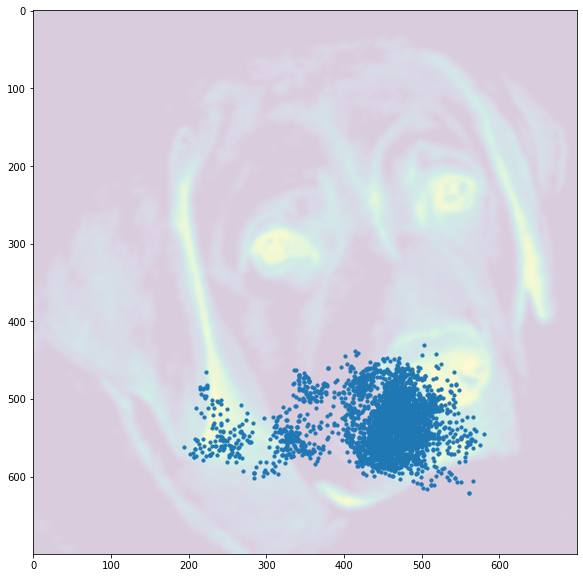

In [ ]:
fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sampled_outputs[:, :, 0], sampled_outputs[:, :, 1], s=10)
ax.imshow(density, alpha=0.2)
matplotlib.pyplot.show()

In [ ]:
import numpy as onp

onp.savez(
    f"/content/drive/MyDrive/CS699/homework #2/labrador_iter3000_k200.npy",
    sample=sampled_outputs
)

  0%|          | 147/30000 [03:29<11:53:43,  1.43s/it]

Metropolis- Hastings REJECT 0.21624114 0.29320574


  1%|          | 238/30000 [05:38<11:50:21,  1.43s/it]

Metropolis- Hastings REJECT 0.21915598 0.27271444


  1%|          | 263/30000 [06:14<11:46:41,  1.43s/it]

Metropolis- Hastings REJECT 0.22657019 0.24391124


  2%|▏         | 464/30000 [10:56<11:24:50,  1.39s/it]

Metropolis- Hastings REJECT 0.13051777 0.17249952


  2%|▏         | 570/30000 [13:22<11:27:53,  1.40s/it]

Metropolis- Hastings REJECT 0.21913394 0.2331349


  3%|▎         | 817/30000 [19:02<11:13:35,  1.38s/it]

Metropolis- Hastings REJECT 0.24227193 0.33101562


  3%|▎         | 830/30000 [19:20<11:12:54,  1.38s/it]

Metropolis- Hastings REJECT 0.26674527 0.32976827


  3%|▎         | 886/30000 [20:37<11:11:07,  1.38s/it]

Metropolis- Hastings REJECT 0.33410156 0.3990381


  3%|▎         | 991/30000 [23:00<11:13:07,  1.39s/it]

Metropolis- Hastings REJECT 0.22166903 0.24118719


  3%|▎         | 1004/30000 [23:17<11:07:05,  1.38s/it]

Metropolis- Hastings REJECT 0.54224956 0.6294075


  3%|▎         | 1007/30000 [23:22<11:09:52,  1.39s/it]

Metropolis- Hastings REJECT 0.5925739 0.70358866


  3%|▎         | 1017/30000 [23:35<11:15:53,  1.40s/it]

Metropolis- Hastings REJECT 0.27077046 0.3553215


  4%|▍         | 1350/30000 [31:08<11:10:40,  1.40s/it]

Metropolis- Hastings REJECT 0.28748152 0.38803035


  5%|▌         | 1580/30000 [36:21<10:43:03,  1.36s/it]

Metropolis- Hastings REJECT 0.22776663 0.31491682


  6%|▌         | 1705/30000 [39:10<10:58:04,  1.40s/it]

Metropolis- Hastings REJECT 0.19346085 0.24666005


  7%|▋         | 1954/30000 [44:46<10:22:56,  1.33s/it]

Metropolis- Hastings REJECT 0.29803726 0.34293202


  7%|▋         | 2049/30000 [46:54<10:29:50,  1.35s/it]

Metropolis- Hastings REJECT 0.19621399 0.24752307


  7%|▋         | 2194/30000 [50:12<11:14:48,  1.46s/it]

Metropolis- Hastings REJECT 0.83428323 0.8748217


  7%|▋         | 2231/30000 [51:05<11:10:50,  1.45s/it]

Metropolis- Hastings REJECT 0.5049239 0.5179509


  8%|▊         | 2254/30000 [51:38<11:21:37,  1.47s/it]

Metropolis- Hastings REJECT 0.33453178 0.36196452


  8%|▊         | 2508/30000 [57:31<10:47:16,  1.41s/it]

Metropolis- Hastings REJECT 0.16244507 0.19196256


  9%|▊         | 2622/30000 [1:00:11<11:22:10,  1.50s/it]

Metropolis- Hastings REJECT 0.39873815 0.4627985


  9%|▉         | 2666/30000 [1:01:12<10:33:39,  1.39s/it]

Metropolis- Hastings REJECT 0.3653759 0.50707364


  9%|▉         | 2692/30000 [1:01:48<10:44:47,  1.42s/it]

Metropolis- Hastings REJECT 0.47775713 0.48860523


  9%|▉         | 2709/30000 [1:02:13<10:45:52,  1.42s/it]

Metropolis- Hastings REJECT 0.26213297 0.40800908


 10%|▉         | 2855/30000 [1:05:38<10:42:58,  1.42s/it]

Metropolis- Hastings REJECT 0.34499982 0.39420295


 10%|▉         | 2943/30000 [1:07:41<10:35:46,  1.41s/it]

Metropolis- Hastings REJECT 0.31483287 0.35334614


 10%|█         | 3023/30000 [1:09:33<10:43:07,  1.43s/it]

Metropolis- Hastings REJECT 0.27494678 0.30339652


 11%|█         | 3175/30000 [1:13:04<10:45:39,  1.44s/it]

Metropolis- Hastings REJECT 0.3531195 0.36121315


 12%|█▏        | 3470/30000 [1:19:55<11:01:28,  1.50s/it]

Metropolis- Hastings REJECT 0.43947613 0.5381722


 12%|█▏        | 3482/30000 [1:20:12<10:42:33,  1.45s/it]

Metropolis- Hastings REJECT 0.48430485 0.5956679


 12%|█▏        | 3572/30000 [1:22:20<10:34:42,  1.44s/it]

Metropolis- Hastings REJECT 0.19005291 0.19688189


 13%|█▎        | 3889/30000 [1:29:48<10:35:58,  1.46s/it]

Metropolis- Hastings REJECT 0.186066 0.19393665


 14%|█▎        | 4067/30000 [1:33:57<10:23:28,  1.44s/it]

Metropolis- Hastings REJECT 0.08746773 0.093254305


 14%|█▍        | 4126/30000 [1:35:19<10:28:18,  1.46s/it]

Metropolis- Hastings REJECT 0.32611427 0.37652114


 14%|█▍        | 4288/30000 [1:39:05<10:11:49,  1.43s/it]

Metropolis- Hastings REJECT 0.15365164 0.19081669


 15%|█▍        | 4433/30000 [1:42:27<9:58:56,  1.41s/it]

Metropolis- Hastings REJECT 0.3088142 0.3243798


 15%|█▌        | 4568/30000 [1:45:35<10:01:31,  1.42s/it]

Metropolis- Hastings REJECT 0.3295808 0.38586295


 16%|█▌        | 4869/30000 [1:52:37<9:44:14,  1.39s/it]

Metropolis- Hastings REJECT 0.61909837 0.6350322


 16%|█▋        | 4878/30000 [1:52:49<9:36:43,  1.38s/it]

Metropolis- Hastings REJECT 0.62262475 0.6633926


 16%|█▋        | 4901/30000 [1:53:21<9:56:51,  1.43s/it]

Metropolis- Hastings REJECT 0.756555 0.7780916


 16%|█▋        | 4910/30000 [1:53:34<10:14:42,  1.47s/it]

Metropolis- Hastings REJECT 0.7139446 0.73223644


 16%|█▋        | 4947/30000 [1:54:27<10:00:32,  1.44s/it]

Metropolis- Hastings REJECT 0.5458588 0.6055157


 17%|█▋        | 4977/30000 [1:55:09<9:43:20,  1.40s/it]

Metropolis- Hastings REJECT 0.44555008 0.48543137


 17%|█▋        | 5158/30000 [1:59:23<9:51:51,  1.43s/it]

Metropolis- Hastings REJECT 0.7336048 0.8198388


 18%|█▊        | 5302/30000 [2:02:45<9:51:46,  1.44s/it]

Metropolis- Hastings REJECT 0.6441726 0.7861556


 18%|█▊        | 5303/30000 [2:02:47<10:03:53,  1.47s/it]

Metropolis- Hastings REJECT 0.6441726 0.71052945


 18%|█▊        | 5319/30000 [2:03:09<9:45:27,  1.42s/it]

Metropolis- Hastings REJECT 1.0375766 1.1194272


 18%|█▊        | 5322/30000 [2:03:14<9:50:30,  1.44s/it]

Metropolis- Hastings REJECT 0.99222445 1.0468721


 18%|█▊        | 5334/30000 [2:03:31<9:58:02,  1.45s/it]

Metropolis- Hastings REJECT 1.0131397 1.0964861


 18%|█▊        | 5374/30000 [2:04:27<9:51:53,  1.44s/it]

Metropolis- Hastings REJECT 0.61053425 0.65244114


 18%|█▊        | 5429/30000 [2:05:45<9:51:48,  1.45s/it]

Metropolis- Hastings REJECT 0.7602997 0.8460572


 18%|█▊        | 5443/30000 [2:06:05<10:01:22,  1.47s/it]

Metropolis- Hastings REJECT 0.7130789 0.79049355


 18%|█▊        | 5494/30000 [2:07:17<9:44:45,  1.43s/it]

Metropolis- Hastings REJECT 0.7128002 0.7494585


 18%|█▊        | 5527/30000 [2:08:04<9:57:44,  1.47s/it]

Metropolis- Hastings REJECT 1.0345914 1.1037505


 18%|█▊        | 5545/30000 [2:08:30<9:47:46,  1.44s/it]

Metropolis- Hastings REJECT 0.87563694 0.96866643


 19%|█▊        | 5601/30000 [2:09:50<9:48:02,  1.45s/it]

Metropolis- Hastings REJECT 0.41782993 0.46620855


 19%|█▉        | 5674/30000 [2:11:33<9:47:31,  1.45s/it]

Metropolis- Hastings REJECT 0.7392142 0.8095278


 19%|█▉        | 5681/30000 [2:11:43<9:43:33,  1.44s/it]

Metropolis- Hastings REJECT 0.89792156 1.0022664


 19%|█▉        | 5700/30000 [2:12:10<9:49:36,  1.46s/it]

Metropolis- Hastings REJECT 0.7962473 0.83365226


 19%|█▉        | 5702/30000 [2:12:13<9:50:48,  1.46s/it]

Metropolis- Hastings REJECT 0.78424585 0.87267673


 19%|█▉        | 5742/30000 [2:13:09<9:21:39,  1.39s/it]

Metropolis- Hastings REJECT 0.6951686 0.8431958


 19%|█▉        | 5746/30000 [2:13:15<9:48:53,  1.46s/it]

Metropolis- Hastings REJECT 1.0330566 1.1293813


 19%|█▉        | 5750/30000 [2:13:20<9:37:29,  1.43s/it]

Metropolis- Hastings REJECT 0.9033285 1.0017743


 19%|█▉        | 5753/30000 [2:13:24<9:24:47,  1.40s/it]

Metropolis- Hastings REJECT 0.752786 0.95556664


 19%|█▉        | 5755/30000 [2:13:27<9:45:01,  1.45s/it]

Metropolis- Hastings REJECT 0.78436834 0.91223735


 19%|█▉        | 5757/30000 [2:13:30<9:44:48,  1.45s/it]

Metropolis- Hastings REJECT 0.68815964 0.73269975


 19%|█▉        | 5791/30000 [2:14:18<9:52:36,  1.47s/it]

Metropolis- Hastings REJECT 1.1872565 1.3991389


 19%|█▉        | 5798/30000 [2:14:28<9:42:47,  1.44s/it]

Metropolis- Hastings REJECT 1.019376 1.197598


 19%|█▉        | 5820/30000 [2:14:59<9:22:32,  1.40s/it]

Metropolis- Hastings REJECT 0.8080261 0.8976202


 20%|█▉        | 5850/30000 [2:15:41<9:38:22,  1.44s/it]

Metropolis- Hastings REJECT 0.5962773 0.6602081


 20%|█▉        | 5921/30000 [2:17:21<9:31:05,  1.42s/it]

Metropolis- Hastings REJECT 0.8715784 0.91831255


 20%|█▉        | 5934/30000 [2:17:39<9:42:42,  1.45s/it]

Metropolis- Hastings REJECT 0.97595626 1.0896318


 21%|██        | 6215/30000 [2:24:17<9:41:06,  1.47s/it]

Metropolis- Hastings REJECT 0.5793408 0.65233666


 21%|██        | 6236/30000 [2:24:48<9:51:53,  1.49s/it]

Metropolis- Hastings REJECT 0.69062465 0.7659102


 21%|██        | 6244/30000 [2:25:00<9:40:55,  1.47s/it]

Metropolis- Hastings REJECT 0.59335005 0.62070316


 21%|██        | 6280/30000 [2:25:52<9:40:32,  1.47s/it]

Metropolis- Hastings REJECT 1.7362045 1.8955125


 21%|██        | 6287/30000 [2:26:02<9:40:04,  1.47s/it]

Metropolis- Hastings REJECT 1.4745802 1.6043144


 21%|██        | 6288/30000 [2:26:04<9:42:10,  1.47s/it]

Metropolis- Hastings REJECT 1.4745802 1.6060332


 21%|██        | 6371/30000 [2:28:02<9:39:23,  1.47s/it]

Metropolis- Hastings REJECT 1.0890065 1.2125928


 21%|██▏       | 6409/30000 [2:28:57<9:32:58,  1.46s/it]

Metropolis- Hastings REJECT 0.6533202 0.686102


 21%|██▏       | 6446/30000 [2:29:50<9:39:46,  1.48s/it]

Metropolis- Hastings REJECT 0.8817396 1.0159346


 21%|██▏       | 6449/30000 [2:29:54<9:48:20,  1.50s/it]

Metropolis- Hastings REJECT 0.91742826 0.9846023


 22%|██▏       | 6463/30000 [2:30:15<9:31:02,  1.46s/it]

Metropolis- Hastings REJECT 0.7955676 0.8809416


 22%|██▏       | 6681/30000 [2:35:28<9:25:08,  1.45s/it]

Metropolis- Hastings REJECT 0.568191 0.61684716


 23%|██▎       | 6884/30000 [2:40:21<9:34:42,  1.49s/it]

Metropolis- Hastings REJECT 0.83079576 0.8722126


 23%|██▎       | 6911/30000 [2:40:59<9:08:10,  1.42s/it]

Metropolis- Hastings REJECT 1.0884144 1.162795


 23%|██▎       | 6925/30000 [2:41:19<9:23:29,  1.47s/it]

Metropolis- Hastings REJECT 1.0061074 1.1106844


 23%|██▎       | 6972/30000 [2:42:27<9:31:02,  1.49s/it]

Metropolis- Hastings REJECT 1.2954315 1.3516171


 23%|██▎       | 6983/30000 [2:42:43<9:21:51,  1.46s/it]

Metropolis- Hastings REJECT 1.3558215 1.4469479


 23%|██▎       | 6985/30000 [2:42:46<9:29:57,  1.49s/it]

Metropolis- Hastings REJECT 1.3597349 1.5226659


 23%|██▎       | 6996/30000 [2:43:02<9:26:12,  1.48s/it]

Metropolis- Hastings REJECT 1.2685266 1.4181545


 23%|██▎       | 7031/30000 [2:43:53<9:31:25,  1.49s/it]

Metropolis- Hastings REJECT 0.72677517 0.8086491


 24%|██▎       | 7051/30000 [2:44:22<9:42:09,  1.52s/it]

Metropolis- Hastings REJECT 0.7338848 0.86441594


 24%|██▍       | 7157/30000 [2:46:56<9:20:39,  1.47s/it]

Metropolis- Hastings REJECT 1.0386851 1.1695999


 24%|██▍       | 7188/30000 [2:47:41<9:27:49,  1.49s/it]

Metropolis- Hastings REJECT 1.2623761 1.3941754


 24%|██▍       | 7198/30000 [2:47:56<9:03:33,  1.43s/it]

Metropolis- Hastings REJECT 0.90183437 1.0826299


 24%|██▍       | 7199/30000 [2:47:57<9:25:50,  1.49s/it]

Metropolis- Hastings REJECT 0.90183437 1.0875045


 24%|██▍       | 7221/30000 [2:48:30<9:30:53,  1.50s/it]

Metropolis- Hastings REJECT 0.43562114 0.5202885


 24%|██▍       | 7270/30000 [2:49:41<9:22:17,  1.48s/it]

Metropolis- Hastings REJECT 0.56690824 0.6186579


 25%|██▍       | 7407/30000 [2:53:00<9:27:11,  1.51s/it]

Metropolis- Hastings REJECT 0.49056995 0.5390272


 25%|██▍       | 7499/30000 [2:55:15<9:23:05,  1.50s/it]

Metropolis- Hastings REJECT 0.6495744 0.81594867


 26%|██▌       | 7679/30000 [2:59:39<9:27:53,  1.53s/it]

Metropolis- Hastings REJECT 0.81874 0.9431682


 26%|██▌       | 7682/30000 [2:59:44<9:17:50,  1.50s/it]

Metropolis- Hastings REJECT 0.86507493 0.9379863


 26%|██▌       | 7688/30000 [2:59:53<9:12:16,  1.49s/it]

Metropolis- Hastings REJECT 0.9952719 1.0949932


 26%|██▌       | 7706/30000 [3:00:19<9:06:34,  1.47s/it]

Metropolis- Hastings REJECT 0.6274518 0.73857874


 26%|██▌       | 7749/30000 [3:01:22<9:19:31,  1.51s/it]

Metropolis- Hastings REJECT 0.45468014 0.51366115


 27%|██▋       | 8010/30000 [3:07:44<8:54:08,  1.46s/it]

Metropolis- Hastings REJECT 0.9857069 1.0751851


 27%|██▋       | 8087/30000 [3:09:37<8:51:37,  1.46s/it]

Metropolis- Hastings REJECT 1.993517 2.1519842


 27%|██▋       | 8092/30000 [3:09:44<9:04:11,  1.49s/it]

Metropolis- Hastings REJECT 2.0023694 2.1203046


 27%|██▋       | 8109/30000 [3:10:09<8:56:37,  1.47s/it]

Metropolis- Hastings REJECT 1.7736689 1.9234602


 27%|██▋       | 8189/30000 [3:12:06<8:59:34,  1.48s/it]

Metropolis- Hastings REJECT 1.534861 1.5753225


 27%|██▋       | 8216/30000 [3:12:46<8:50:18,  1.46s/it]

Metropolis- Hastings REJECT 1.562613 1.6417242


 28%|██▊       | 8302/30000 [3:14:51<9:02:56,  1.50s/it]

Metropolis- Hastings REJECT 0.9842617 1.2102495


 28%|██▊       | 8317/30000 [3:15:13<9:03:11,  1.50s/it]

Metropolis- Hastings REJECT 0.7988337 0.8537124


 28%|██▊       | 8344/30000 [3:15:53<8:40:37,  1.44s/it]

Metropolis- Hastings REJECT 0.8203595 0.84317136


 28%|██▊       | 8399/30000 [3:17:13<8:59:57,  1.50s/it]

Metropolis- Hastings REJECT 0.7686017 0.95548165


 28%|██▊       | 8444/30000 [3:18:17<8:38:40,  1.44s/it]

Metropolis- Hastings REJECT 0.5248274 0.5788823


 29%|██▊       | 8560/30000 [3:21:03<8:43:14,  1.46s/it]

Metropolis- Hastings REJECT 0.69196916 0.74914354


 29%|██▉       | 8634/30000 [3:22:50<8:39:11,  1.46s/it]

Metropolis- Hastings REJECT 0.66835237 0.8101719


 29%|██▉       | 8670/30000 [3:23:41<8:33:56,  1.45s/it]

Metropolis- Hastings REJECT 0.625826 0.6342298


 29%|██▉       | 8745/30000 [3:25:28<8:38:46,  1.46s/it]

Metropolis- Hastings REJECT 0.7395412 0.8713469


 29%|██▉       | 8793/30000 [3:26:37<8:37:57,  1.47s/it]

Metropolis- Hastings REJECT 0.6641 0.7003196


 29%|██▉       | 8828/30000 [3:27:28<8:25:56,  1.43s/it]

Metropolis- Hastings REJECT 0.59408474 0.6965042


 30%|██▉       | 8856/30000 [3:28:07<8:20:24,  1.42s/it]

Metropolis- Hastings REJECT 0.5440599 0.6130799


 30%|██▉       | 8864/30000 [3:28:19<8:41:30,  1.48s/it]

Metropolis- Hastings REJECT 0.64748704 0.6783484


 30%|██▉       | 8932/30000 [3:29:56<8:17:19,  1.42s/it]

Metropolis- Hastings REJECT 0.43156996 0.45187867


 30%|███       | 9060/30000 [3:32:59<8:24:38,  1.45s/it]

Metropolis- Hastings REJECT 0.6181237 0.67471206


 30%|███       | 9066/30000 [3:33:08<8:25:56,  1.45s/it]

Metropolis- Hastings REJECT 0.5971598 0.73215955


 31%|███       | 9167/30000 [3:35:32<8:25:55,  1.46s/it]

Metropolis- Hastings REJECT 0.67599314 0.70384496


 31%|███       | 9214/30000 [3:36:39<8:19:19,  1.44s/it]

Metropolis- Hastings REJECT 0.5328729 0.6180829


 31%|███       | 9221/30000 [3:36:49<8:18:49,  1.44s/it]

Metropolis- Hastings REJECT 0.5604713 0.5911365


 31%|███▏      | 9379/30000 [3:40:41<8:39:21,  1.51s/it]

Metropolis- Hastings REJECT 0.53233737 0.5555483


 32%|███▏      | 9462/30000 [3:42:42<8:17:37,  1.45s/it]

Metropolis- Hastings REJECT 0.6218928 0.68845063


 32%|███▏      | 9474/30000 [3:43:00<8:37:34,  1.51s/it]

Metropolis- Hastings REJECT 0.7579191 0.8034658


 32%|███▏      | 9579/30000 [3:45:30<8:15:44,  1.46s/it]

Metropolis- Hastings REJECT 0.7022123 0.82323766


 32%|███▏      | 9611/30000 [3:46:16<8:13:14,  1.45s/it]

Metropolis- Hastings REJECT 0.80758405 0.8353952


 32%|███▏      | 9629/30000 [3:46:42<8:14:27,  1.46s/it]

Metropolis- Hastings REJECT 0.73299795 0.7579311


 32%|███▏      | 9643/30000 [3:47:02<8:22:30,  1.48s/it]

Metropolis- Hastings REJECT 0.63842905 0.67889345


 33%|███▎      | 9771/30000 [3:50:07<8:03:23,  1.43s/it]

Metropolis- Hastings REJECT 1.028912 1.0723038


 33%|███▎      | 9842/30000 [3:51:48<8:01:44,  1.43s/it]

Metropolis- Hastings REJECT 0.685269 0.77094185


 33%|███▎      | 9974/30000 [3:54:59<7:59:52,  1.44s/it]

Metropolis- Hastings REJECT 0.481987 0.5085802


 33%|███▎      | 9980/30000 [3:55:07<8:11:40,  1.47s/it]

Metropolis- Hastings REJECT 0.52361214 0.563194


 33%|███▎      | 10024/30000 [3:56:10<8:02:05,  1.45s/it]

Metropolis- Hastings REJECT 0.53215337 0.61715925


 33%|███▎      | 10046/30000 [3:56:42<8:10:38,  1.48s/it]

Metropolis- Hastings REJECT 0.44987476 0.47863537


 34%|███▍      | 10247/30000 [4:01:29<7:58:30,  1.45s/it]

Metropolis- Hastings REJECT 0.55444306 0.6651589


 34%|███▍      | 10324/30000 [4:03:20<8:01:36,  1.47s/it]

Metropolis- Hastings REJECT 0.8993191 0.9273114


 34%|███▍      | 10329/30000 [4:03:27<8:03:51,  1.48s/it]

Metropolis- Hastings REJECT 0.90447354 0.9629922


 35%|███▍      | 10394/30000 [4:05:00<7:53:50,  1.45s/it]

Metropolis- Hastings REJECT 0.5761201 0.5873759


 35%|███▍      | 10461/30000 [4:06:36<8:10:40,  1.51s/it]

Metropolis- Hastings REJECT 0.5525023 0.59558797


 35%|███▌      | 10517/30000 [4:07:57<7:49:08,  1.44s/it]

Metropolis- Hastings REJECT 0.7126485 0.7383018


 36%|███▌      | 10790/30000 [4:14:30<8:07:16,  1.52s/it]

Metropolis- Hastings REJECT 0.26799527 0.3114144


 36%|███▌      | 10803/30000 [4:14:49<7:53:58,  1.48s/it]

Metropolis- Hastings REJECT 0.27492157 0.34806842


 36%|███▌      | 10804/30000 [4:14:51<7:52:56,  1.48s/it]

Metropolis- Hastings REJECT 0.27492157 0.34751317


 36%|███▋      | 10887/30000 [4:16:50<7:58:04,  1.50s/it]

Metropolis- Hastings REJECT 0.50323236 0.5558973


 37%|███▋      | 10991/30000 [4:19:21<7:51:06,  1.49s/it]

Metropolis- Hastings REJECT 0.22382751 0.25656968


 37%|███▋      | 11109/30000 [4:22:10<7:34:20,  1.44s/it]

Metropolis- Hastings REJECT 0.23183061 0.29864314


 38%|███▊      | 11397/30000 [4:28:57<7:40:53,  1.49s/it]

Metropolis- Hastings REJECT 0.23463403 0.25078073


 38%|███▊      | 11439/30000 [4:29:57<7:17:52,  1.42s/it]

Metropolis- Hastings REJECT 0.17119546 0.22385189


 38%|███▊      | 11495/30000 [4:31:17<7:24:05,  1.44s/it]

Metropolis- Hastings REJECT 0.08921573 0.118967585


 38%|███▊      | 11511/30000 [4:31:40<7:24:12,  1.44s/it]

Metropolis- Hastings REJECT 0.10064015 0.13529766


 39%|███▊      | 11588/30000 [4:33:30<7:20:37,  1.44s/it]

Metropolis- Hastings REJECT 0.10468684 0.116020024


 39%|███▉      | 11837/30000 [4:39:26<7:24:49,  1.47s/it]

Metropolis- Hastings REJECT 0.2381622 0.28784326


 39%|███▉      | 11840/30000 [4:39:30<7:25:47,  1.47s/it]

Metropolis- Hastings REJECT 0.2577605 0.27856782


 40%|███▉      | 11877/30000 [4:40:23<7:18:08,  1.45s/it]

Metropolis- Hastings REJECT 0.41582197 0.4329369


 40%|███▉      | 11895/30000 [4:40:49<7:16:02,  1.45s/it]

Metropolis- Hastings REJECT 0.3452669 0.35596797


 40%|███▉      | 11990/30000 [4:43:04<7:19:04,  1.46s/it]

Metropolis- Hastings REJECT 0.213586 0.2248217


 40%|████      | 12001/30000 [4:43:20<7:07:07,  1.42s/it]

Metropolis- Hastings REJECT 0.1881987 0.25389457


 40%|████      | 12091/30000 [4:45:30<7:07:22,  1.43s/it]

Metropolis- Hastings REJECT 0.15529823 0.20178594


 40%|████      | 12132/30000 [4:46:29<7:23:35,  1.49s/it]

Metropolis- Hastings REJECT 0.2662109 0.3182094


 41%|████      | 12194/30000 [4:47:57<7:11:00,  1.45s/it]

Metropolis- Hastings REJECT 0.14686382 0.1577024


 41%|████      | 12335/30000 [4:51:17<7:04:55,  1.44s/it]

Metropolis- Hastings REJECT 0.28898826 0.4990373


 41%|████▏     | 12446/30000 [4:53:54<6:51:21,  1.41s/it]

Metropolis- Hastings REJECT 0.14828943 0.17023705


 42%|████▏     | 12608/30000 [4:57:44<6:55:23,  1.43s/it]

Metropolis- Hastings REJECT 0.24692997 0.31634024


 42%|████▏     | 12707/30000 [5:00:04<7:07:36,  1.48s/it]

Metropolis- Hastings REJECT 0.17341508 0.23109871


 43%|████▎     | 12840/30000 [5:03:16<6:57:13,  1.46s/it]

Metropolis- Hastings REJECT 0.48298407 0.5353606


 44%|████▎     | 13123/30000 [5:10:00<6:53:26,  1.47s/it]

Metropolis- Hastings REJECT 0.25189707 0.3385078


 44%|████▍     | 13203/30000 [5:11:53<6:35:45,  1.41s/it]

Metropolis- Hastings REJECT 0.1303782 0.1587684


 44%|████▍     | 13216/30000 [5:12:11<6:48:35,  1.46s/it]

Metropolis- Hastings REJECT 0.124682955 0.17002323


 44%|████▍     | 13283/30000 [5:13:46<6:38:22,  1.43s/it]

Metropolis- Hastings REJECT 0.21854757 0.3062908


 45%|████▍     | 13404/30000 [5:16:37<6:35:38,  1.43s/it]

Metropolis- Hastings REJECT 0.16051441 0.19095042


 45%|████▍     | 13427/30000 [5:17:10<6:39:04,  1.44s/it]

Metropolis- Hastings REJECT 0.2846093 0.2931461


 45%|████▍     | 13484/30000 [5:18:31<6:30:57,  1.42s/it]

Metropolis- Hastings REJECT 0.25235665 0.34458038


 45%|████▍     | 13497/30000 [5:18:49<6:33:54,  1.43s/it]

Metropolis- Hastings REJECT 0.11526406 0.123687334


 45%|████▌     | 13633/30000 [5:22:03<6:42:25,  1.48s/it]

Metropolis- Hastings REJECT 0.14661588 0.15021613


 45%|████▌     | 13642/30000 [5:22:15<6:38:10,  1.46s/it]

Metropolis- Hastings REJECT 0.16849776 0.19365752


 47%|████▋     | 14172/30000 [5:34:52<6:27:16,  1.47s/it]

Metropolis- Hastings REJECT 0.31346226 0.36316144


 48%|████▊     | 14310/30000 [5:38:11<6:19:31,  1.45s/it]

Metropolis- Hastings REJECT 0.3263818 0.35290408


 49%|████▊     | 14587/30000 [5:44:45<6:08:49,  1.44s/it]

Metropolis- Hastings REJECT 0.9247497 1.0892832


 49%|████▊     | 14611/30000 [5:45:20<6:18:32,  1.48s/it]

Metropolis- Hastings REJECT 0.9778205 1.1211627


 49%|████▊     | 14617/30000 [5:45:29<6:20:28,  1.48s/it]

Metropolis- Hastings REJECT 1.0546982 1.0984037


 49%|████▉     | 14773/30000 [5:49:13<6:13:49,  1.47s/it]

Metropolis- Hastings REJECT 0.511502 0.6008539


 50%|████▉     | 14858/30000 [5:51:15<6:08:22,  1.46s/it]

Metropolis- Hastings REJECT 0.41624358 0.44694018


 50%|████▉     | 14910/30000 [5:52:31<6:17:04,  1.50s/it]

Metropolis- Hastings REJECT 0.23214632 0.26021656


 50%|█████     | 15117/30000 [5:57:28<5:55:10,  1.43s/it]

Metropolis- Hastings REJECT 0.35444286 0.41183043


 51%|█████     | 15240/30000 [6:00:26<6:03:44,  1.48s/it]

Metropolis- Hastings REJECT 0.20407304 0.26122996


 51%|█████     | 15304/30000 [6:01:58<5:56:42,  1.46s/it]

Metropolis- Hastings REJECT 0.8030026 0.91925836


 51%|█████     | 15342/30000 [6:02:53<6:08:55,  1.51s/it]

Metropolis- Hastings REJECT 0.69689184 0.76172423


 51%|█████     | 15343/30000 [6:02:54<6:08:27,  1.51s/it]

Metropolis- Hastings REJECT 0.69689184 0.7881335


 51%|█████     | 15364/30000 [6:03:25<6:02:32,  1.49s/it]

Metropolis- Hastings REJECT 0.75495625 0.78252035


 52%|█████▏    | 15489/30000 [6:06:24<5:54:36,  1.47s/it]

Metropolis- Hastings REJECT 0.33700424 0.34705934


 52%|█████▏    | 15531/30000 [6:07:24<5:49:37,  1.45s/it]

Metropolis- Hastings REJECT 0.4657721 0.514025


 52%|█████▏    | 15567/30000 [6:08:16<5:44:02,  1.43s/it]

Metropolis- Hastings REJECT 0.42716664 0.45250982


 52%|█████▏    | 15713/30000 [6:11:45<5:40:14,  1.43s/it]

Metropolis- Hastings REJECT 1.1483812 1.2362323


 52%|█████▏    | 15742/30000 [6:12:27<5:49:42,  1.47s/it]

Metropolis- Hastings REJECT 0.8609079 0.9372473


 53%|█████▎    | 15755/30000 [6:12:46<5:42:28,  1.44s/it]

Metropolis- Hastings REJECT 0.41138604 0.5043598


 53%|█████▎    | 16007/30000 [6:18:46<5:46:56,  1.49s/it]

Metropolis- Hastings REJECT 0.25219318 0.26389405


 54%|█████▍    | 16297/30000 [6:25:41<5:25:52,  1.43s/it]

Metropolis- Hastings REJECT 0.6893789 0.7144551


 55%|█████▍    | 16392/30000 [6:27:55<5:32:00,  1.46s/it]

Metropolis- Hastings REJECT 0.4355222 0.4496715


 55%|█████▍    | 16496/30000 [6:30:22<5:20:40,  1.42s/it]

Metropolis- Hastings REJECT 0.31404132 0.33579287


 56%|█████▌    | 16722/30000 [6:35:43<5:26:31,  1.48s/it]

Metropolis- Hastings REJECT 0.15230751 0.216095


 56%|█████▌    | 16729/30000 [6:35:53<5:30:53,  1.50s/it]

Metropolis- Hastings REJECT 0.15793677 0.19786881


 57%|█████▋    | 17086/30000 [6:44:23<5:10:23,  1.44s/it]

Metropolis- Hastings REJECT 0.27723953 0.4166612


 57%|█████▋    | 17102/30000 [6:44:47<5:19:39,  1.49s/it]

Metropolis- Hastings REJECT 0.15127833 0.17521642


 57%|█████▋    | 17112/30000 [6:45:01<5:14:13,  1.46s/it]

Metropolis- Hastings REJECT 0.19632772 0.24744405


 57%|█████▋    | 17147/30000 [6:45:52<5:13:56,  1.47s/it]

Metropolis- Hastings REJECT 0.14144583 0.1563887


 57%|█████▋    | 17241/30000 [6:48:05<5:08:27,  1.45s/it]

Metropolis- Hastings REJECT 0.19875789 0.242374


 58%|█████▊    | 17293/30000 [6:49:20<5:13:42,  1.48s/it]

Metropolis- Hastings REJECT 0.21327855 0.26550052


 58%|█████▊    | 17302/30000 [6:49:33<5:05:59,  1.45s/it]

Metropolis- Hastings REJECT 0.29510882 0.39626366


 58%|█████▊    | 17471/30000 [6:53:31<4:57:30,  1.42s/it]

Metropolis- Hastings REJECT 0.2265746 0.28616625


 58%|█████▊    | 17476/30000 [6:53:39<5:01:20,  1.44s/it]

Metropolis- Hastings REJECT 0.22524136 0.31431708


 58%|█████▊    | 17497/30000 [6:54:08<4:59:18,  1.44s/it]

Metropolis- Hastings REJECT 0.27945057 0.37733462


 58%|█████▊    | 17502/30000 [6:54:16<4:55:48,  1.42s/it]

Metropolis- Hastings REJECT 0.216814 0.27793595


 59%|█████▉    | 17655/30000 [6:57:50<4:58:30,  1.45s/it]

Metropolis- Hastings REJECT 0.17811579 0.18025278


 59%|█████▉    | 17759/30000 [7:00:19<4:53:14,  1.44s/it]

Metropolis- Hastings REJECT 0.46026668 0.51717824


 59%|█████▉    | 17762/30000 [7:00:23<4:55:12,  1.45s/it]

Metropolis- Hastings REJECT 0.4044342 0.48965764


 59%|█████▉    | 17805/30000 [7:01:25<4:54:49,  1.45s/it]

Metropolis- Hastings REJECT 0.23683995 0.24613601


 60%|█████▉    | 17866/30000 [7:02:51<5:00:08,  1.48s/it]

Metropolis- Hastings REJECT 0.31191313 0.37925348


 60%|█████▉    | 17945/30000 [7:04:43<4:50:39,  1.45s/it]

Metropolis- Hastings REJECT 0.5155898 0.5950976


 60%|█████▉    | 17966/30000 [7:05:13<4:47:12,  1.43s/it]

Metropolis- Hastings REJECT 0.34510064 0.4112103


 60%|█████▉    | 17968/30000 [7:05:16<4:50:14,  1.45s/it]

Metropolis- Hastings REJECT 0.41698566 0.4819373


 60%|█████▉    | 17975/30000 [7:05:26<4:50:33,  1.45s/it]

Metropolis- Hastings REJECT 0.35743573 0.46932018


 60%|█████▉    | 17978/30000 [7:05:30<4:49:57,  1.45s/it]

Metropolis- Hastings REJECT 0.29486883 0.34432995


 60%|██████    | 18056/30000 [7:07:19<4:51:54,  1.47s/it]

Metropolis- Hastings REJECT 0.24376354 0.2993204


 60%|██████    | 18099/30000 [7:08:20<4:47:34,  1.45s/it]

Metropolis- Hastings REJECT 0.27070272 0.34861255


 61%|██████    | 18223/30000 [7:11:17<4:45:57,  1.46s/it]

Metropolis- Hastings REJECT 1.268019 1.549664


 61%|██████    | 18230/30000 [7:11:27<4:43:48,  1.45s/it]

Metropolis- Hastings REJECT 1.371907 1.5002447


 61%|██████    | 18249/30000 [7:11:54<4:50:45,  1.48s/it]

Metropolis- Hastings REJECT 1.437916 1.5574285


 61%|██████    | 18255/30000 [7:12:03<4:44:46,  1.45s/it]

Metropolis- Hastings REJECT 1.0370893 1.0822997


 61%|██████    | 18262/30000 [7:12:13<4:46:20,  1.46s/it]

Metropolis- Hastings REJECT 0.99257123 1.0589732


 61%|██████    | 18277/30000 [7:12:34<4:40:42,  1.44s/it]

Metropolis- Hastings REJECT 0.72184914 0.8510852


 61%|██████    | 18282/30000 [7:12:42<4:42:21,  1.45s/it]

Metropolis- Hastings REJECT 0.62229013 0.6707536


 61%|██████    | 18288/30000 [7:12:50<4:46:58,  1.47s/it]

Metropolis- Hastings REJECT 0.45151094 0.67309296


 61%|██████    | 18296/30000 [7:13:02<4:41:22,  1.44s/it]

Metropolis- Hastings REJECT 0.26326838 0.3297095


 61%|██████    | 18327/30000 [7:13:46<4:41:31,  1.45s/it]

Metropolis- Hastings REJECT 0.47834742 0.69117695


 61%|██████    | 18329/30000 [7:13:48<4:40:40,  1.44s/it]

Metropolis- Hastings REJECT 0.4871396 0.70680195


 61%|██████    | 18355/30000 [7:14:25<4:42:17,  1.45s/it]

Metropolis- Hastings REJECT 0.36896738 0.42287132


 61%|██████▏   | 18384/30000 [7:15:06<4:37:05,  1.43s/it]

Metropolis- Hastings REJECT 0.3324004 0.38904962


 61%|██████▏   | 18392/30000 [7:15:18<4:38:10,  1.44s/it]

Metropolis- Hastings REJECT 0.48844668 0.62031275


 62%|██████▏   | 18455/30000 [7:16:47<4:38:49,  1.45s/it]

Metropolis- Hastings REJECT 0.1464664 0.1568656


 62%|██████▏   | 18673/30000 [7:21:56<4:26:12,  1.41s/it]

Metropolis- Hastings REJECT 0.2597624 0.30364013


 64%|██████▍   | 19128/30000 [7:32:42<4:21:27,  1.44s/it]

Metropolis- Hastings REJECT 0.111732006 0.14906304


 64%|██████▍   | 19240/30000 [7:35:22<4:22:39,  1.46s/it]

Metropolis- Hastings REJECT 0.08684907 0.10796003


 64%|██████▍   | 19300/30000 [7:36:48<4:15:37,  1.43s/it]

Metropolis- Hastings REJECT 0.12802698 0.16463803


 65%|██████▍   | 19371/30000 [7:38:30<4:05:00,  1.38s/it]

Metropolis- Hastings REJECT 0.09672375 0.14562225


 65%|██████▍   | 19417/30000 [7:39:36<4:16:39,  1.46s/it]

Metropolis- Hastings REJECT 0.10918958 0.116435654


 65%|██████▍   | 19484/30000 [7:41:10<4:05:43,  1.40s/it]

Metropolis- Hastings REJECT 0.3451195 0.37544107


 65%|██████▌   | 19508/30000 [7:41:44<4:12:46,  1.45s/it]

Metropolis- Hastings REJECT 0.21646543 0.248475


 65%|██████▌   | 19553/30000 [7:42:48<4:10:33,  1.44s/it]

Metropolis- Hastings REJECT 0.2720481 0.33205864


 65%|██████▌   | 19564/30000 [7:43:03<4:09:25,  1.43s/it]

Metropolis- Hastings REJECT 0.27528736 0.30581388


 65%|██████▌   | 19577/30000 [7:43:21<4:11:08,  1.45s/it]

Metropolis- Hastings REJECT 0.39764953 0.49019006


 66%|██████▌   | 19719/30000 [7:46:45<4:13:14,  1.48s/it]

Metropolis- Hastings REJECT 0.19140938 0.237901


 66%|██████▌   | 19863/30000 [7:50:08<4:03:42,  1.44s/it]

Metropolis- Hastings REJECT 0.3020999 0.32968506


 66%|██████▋   | 19881/30000 [7:50:33<3:55:26,  1.40s/it]

Metropolis- Hastings REJECT 0.428079 0.46706948


 66%|██████▋   | 19916/30000 [7:51:23<4:03:23,  1.45s/it]

Metropolis- Hastings REJECT 0.53709584 0.57188094


 67%|██████▋   | 19955/30000 [7:52:18<4:07:37,  1.48s/it]

Metropolis- Hastings REJECT 0.59032184 0.64559704


 67%|██████▋   | 19958/30000 [7:52:23<4:06:26,  1.47s/it]

Metropolis- Hastings REJECT 0.57785124 0.6111802


 67%|██████▋   | 20033/30000 [7:54:09<4:00:34,  1.45s/it]

Metropolis- Hastings REJECT 0.4231442 0.5265973


 67%|██████▋   | 20036/30000 [7:54:14<3:59:54,  1.44s/it]

Metropolis- Hastings REJECT 0.3330708 0.3638612


 67%|██████▋   | 20096/30000 [7:55:39<4:00:11,  1.46s/it]

Metropolis- Hastings REJECT 0.49916846 0.56899256


 67%|██████▋   | 20114/30000 [7:56:05<4:00:54,  1.46s/it]

Metropolis- Hastings REJECT 0.3678627 0.46008933


 67%|██████▋   | 20125/30000 [7:56:21<4:00:49,  1.46s/it]

Metropolis- Hastings REJECT 0.31533954 0.38196978


 67%|██████▋   | 20243/30000 [7:59:09<3:54:00,  1.44s/it]

Metropolis- Hastings REJECT 0.4118826 0.5266327


 68%|██████▊   | 20258/30000 [7:59:31<3:57:26,  1.46s/it]

Metropolis- Hastings REJECT 0.3013765 0.34533182


 68%|██████▊   | 20293/30000 [8:00:21<3:51:08,  1.43s/it]

Metropolis- Hastings REJECT 0.4379104 0.521914


 68%|██████▊   | 20325/30000 [8:01:06<3:57:34,  1.47s/it]

Metropolis- Hastings REJECT 0.86257255 0.95997006


 68%|██████▊   | 20438/30000 [8:03:48<3:52:36,  1.46s/it]

Metropolis- Hastings REJECT 0.41946432 0.43535322


 68%|██████▊   | 20481/30000 [8:04:50<3:52:41,  1.47s/it]

Metropolis- Hastings REJECT 0.27909645 0.29102933


 69%|██████▊   | 20565/30000 [8:06:52<3:50:43,  1.47s/it]

Metropolis- Hastings REJECT 0.3986395 0.46458772


 69%|██████▊   | 20599/30000 [8:07:41<3:48:14,  1.46s/it]

Metropolis- Hastings REJECT 0.5788254 0.60264105


 69%|██████▉   | 20640/30000 [8:08:40<3:49:40,  1.47s/it]

Metropolis- Hastings REJECT 0.52567726 0.54961956


 69%|██████▉   | 20762/30000 [8:11:36<3:50:02,  1.49s/it]

Metropolis- Hastings REJECT 0.11872365 0.15908177


 70%|██████▉   | 20852/30000 [8:13:45<3:42:32,  1.46s/it]

Metropolis- Hastings REJECT 0.18902707 0.23765922


 70%|███████   | 21016/30000 [8:17:45<3:36:02,  1.44s/it]

Metropolis- Hastings REJECT 0.11134484 0.15717049


 70%|███████   | 21035/30000 [8:18:12<3:37:42,  1.46s/it]

Metropolis- Hastings REJECT 0.35874444 0.36833674


 71%|███████   | 21348/30000 [8:25:45<3:35:02,  1.49s/it]

Metropolis- Hastings REJECT 0.41434306 0.45893693


 71%|███████   | 21364/30000 [8:26:08<3:27:48,  1.44s/it]

Metropolis- Hastings REJECT 0.32511693 0.35569572


 71%|███████▏  | 21394/30000 [8:26:52<3:34:23,  1.49s/it]

Metropolis- Hastings REJECT 0.21700814 0.24291319


 72%|███████▏  | 21495/30000 [8:29:18<3:30:02,  1.48s/it]

Metropolis- Hastings REJECT 0.109129086 0.12882222


 72%|███████▏  | 21503/30000 [8:29:30<3:29:05,  1.48s/it]

Metropolis- Hastings REJECT 0.112483636 0.14945242


 72%|███████▏  | 21647/30000 [8:32:56<3:28:27,  1.50s/it]

Metropolis- Hastings REJECT 0.53205645 0.6143958


 73%|███████▎  | 21953/30000 [8:40:15<3:16:11,  1.46s/it]

Metropolis- Hastings REJECT 0.6675928 0.6835758


 73%|███████▎  | 21983/30000 [8:40:59<3:13:31,  1.45s/it]

Metropolis- Hastings REJECT 0.800214 0.81710565


 73%|███████▎  | 22032/30000 [8:42:09<3:14:11,  1.46s/it]

Metropolis- Hastings REJECT 0.52832395 0.55062044


 74%|███████▎  | 22094/30000 [8:43:39<3:09:55,  1.44s/it]

Metropolis- Hastings REJECT 0.6687041 0.6693936


 75%|███████▍  | 22419/30000 [8:51:25<3:05:49,  1.47s/it]

Metropolis- Hastings REJECT 0.7220024 0.761978


 75%|███████▍  | 22440/30000 [8:51:56<3:01:42,  1.44s/it]

Metropolis- Hastings REJECT 0.5326657 0.5523748


 75%|███████▌  | 22571/30000 [8:55:04<3:01:31,  1.47s/it]

Metropolis- Hastings REJECT 0.41671634 0.4350735


 75%|███████▌  | 22619/30000 [8:56:12<2:56:37,  1.44s/it]

Metropolis- Hastings REJECT 0.5710571 0.6079908


 76%|███████▌  | 22688/30000 [8:57:50<2:57:01,  1.45s/it]

Metropolis- Hastings REJECT 0.2599445 0.3192449


 76%|███████▌  | 22769/30000 [8:59:46<2:56:06,  1.46s/it]

Metropolis- Hastings REJECT 0.21709642 0.25487536


 77%|███████▋  | 23153/30000 [9:08:57<2:48:59,  1.48s/it]

Metropolis- Hastings REJECT 0.54702044 0.60705006


 77%|███████▋  | 23230/30000 [9:10:47<2:45:38,  1.47s/it]

Metropolis- Hastings REJECT 0.1986806 0.2536306


 77%|███████▋  | 23233/30000 [9:10:52<2:42:40,  1.44s/it]

Metropolis- Hastings REJECT 0.2533513 0.2786499


 79%|███████▉  | 23758/30000 [9:23:25<2:29:22,  1.44s/it]

Metropolis- Hastings REJECT 0.35534385 0.36738938


 79%|███████▉  | 23844/30000 [9:25:27<2:26:57,  1.43s/it]

Metropolis- Hastings REJECT 0.13986884 0.1790296


 80%|███████▉  | 23949/30000 [9:27:56<2:25:02,  1.44s/it]

Metropolis- Hastings REJECT 0.2483898 0.272694


 80%|████████  | 24082/30000 [9:31:04<2:21:42,  1.44s/it]

Metropolis- Hastings REJECT 0.5371667 0.59783405


 81%|████████  | 24168/30000 [9:33:07<2:24:12,  1.48s/it]

Metropolis- Hastings REJECT 0.6135603 0.7018205


 81%|████████  | 24228/30000 [9:34:33<2:21:05,  1.47s/it]

Metropolis- Hastings REJECT 0.67361015 0.7304862


 81%|████████▏ | 24435/30000 [9:39:28<2:18:46,  1.50s/it]

Metropolis- Hastings REJECT 0.12812927 0.13142402


 82%|████████▏ | 24451/30000 [9:39:51<2:15:06,  1.46s/it]

Metropolis- Hastings REJECT 0.13349889 0.15298831


 82%|████████▏ | 24613/30000 [9:43:40<2:09:59,  1.45s/it]

Metropolis- Hastings REJECT 0.1854091 0.25587812


 83%|████████▎ | 24780/30000 [9:47:40<2:07:44,  1.47s/it]

Metropolis- Hastings REJECT 0.6708288 0.8812617


 83%|████████▎ | 24798/30000 [9:48:06<2:05:02,  1.44s/it]

Metropolis- Hastings REJECT 0.30627924 0.38598186


 83%|████████▎ | 24893/30000 [9:50:22<2:01:59,  1.43s/it]

Metropolis- Hastings REJECT 0.20396662 0.2201641


 83%|████████▎ | 24993/30000 [9:52:44<1:58:15,  1.42s/it]

Metropolis- Hastings REJECT 0.39726016 0.51526487


 83%|████████▎ | 24994/30000 [9:52:46<2:00:19,  1.44s/it]

Metropolis- Hastings REJECT 0.39726016 0.5294789


 83%|████████▎ | 25031/30000 [9:53:40<2:04:22,  1.50s/it]

Metropolis- Hastings REJECT 0.8380532 0.9358898


 84%|████████▎ | 25078/30000 [9:54:47<1:57:40,  1.43s/it]

Metropolis- Hastings REJECT 0.25931162 0.26654273


 84%|████████▎ | 25085/30000 [9:54:57<1:59:00,  1.45s/it]

Metropolis- Hastings REJECT 0.33325204 0.34662974


 84%|████████▎ | 25089/30000 [9:55:03<1:58:49,  1.45s/it]

Metropolis- Hastings REJECT 0.46716136 0.6119575


 84%|████████▍ | 25154/30000 [9:56:35<1:54:07,  1.41s/it]

Metropolis- Hastings REJECT 1.1349746 1.2641017


 84%|████████▍ | 25156/30000 [9:56:38<1:55:58,  1.44s/it]

Metropolis- Hastings REJECT 1.1410986 1.3579677


 84%|████████▍ | 25163/30000 [9:56:48<1:57:43,  1.46s/it]

Metropolis- Hastings REJECT 1.9535903 2.1959956


 84%|████████▍ | 25201/30000 [9:57:42<1:58:41,  1.48s/it]

Metropolis- Hastings REJECT 1.5254006 1.5765136


 84%|████████▍ | 25229/30000 [9:58:22<1:55:10,  1.45s/it]

Metropolis- Hastings REJECT 1.0960059 1.2814401


 84%|████████▍ | 25279/30000 [9:59:33<1:53:55,  1.45s/it]

Metropolis- Hastings REJECT 1.5448656 1.6773484


 84%|████████▍ | 25290/30000 [9:59:49<1:53:06,  1.44s/it]

Metropolis- Hastings REJECT 1.3866365 1.3944454


 84%|████████▍ | 25305/30000 [10:00:10<1:57:11,  1.50s/it]

Metropolis- Hastings REJECT 2.0610797 2.1369946


 84%|████████▍ | 25322/30000 [10:00:35<1:52:14,  1.44s/it]

Metropolis- Hastings REJECT 1.4226406 1.7240055


 85%|████████▍ | 25396/30000 [10:02:20<1:50:14,  1.44s/it]

Metropolis- Hastings REJECT 1.1050433 1.1968442


 85%|████████▍ | 25428/30000 [10:03:06<1:51:23,  1.46s/it]

Metropolis- Hastings REJECT 1.1107533 1.1572664


 85%|████████▍ | 25457/30000 [10:03:48<1:51:48,  1.48s/it]

Metropolis- Hastings REJECT 0.823995 1.1373324


 85%|████████▌ | 25506/30000 [10:04:59<1:48:47,  1.45s/it]

Metropolis- Hastings REJECT 0.60641897 0.638392


 85%|████████▌ | 25520/30000 [10:05:19<1:49:04,  1.46s/it]

Metropolis- Hastings REJECT 0.8047482 0.8107755


 85%|████████▌ | 25521/30000 [10:05:21<1:52:23,  1.51s/it]

Metropolis- Hastings REJECT 0.8047482 0.92307174


 85%|████████▌ | 25584/30000 [10:06:52<1:46:09,  1.44s/it]

Metropolis- Hastings REJECT 1.0879376 1.0974344


 85%|████████▌ | 25596/30000 [10:07:09<1:47:43,  1.47s/it]

Metropolis- Hastings REJECT 1.0392593 1.0695672


 86%|████████▌ | 25706/30000 [10:09:45<1:44:06,  1.45s/it]

Metropolis- Hastings REJECT 1.225597 1.340834


 86%|████████▌ | 25743/30000 [10:10:38<1:40:37,  1.42s/it]

Metropolis- Hastings REJECT 2.1629002 2.453011


 86%|████████▌ | 25781/30000 [10:11:31<1:41:21,  1.44s/it]

Metropolis- Hastings REJECT 1.042619 1.1896358


 86%|████████▌ | 25869/30000 [10:13:35<1:38:01,  1.42s/it]

Metropolis- Hastings REJECT 1.4771458 1.5256721


 86%|████████▋ | 25882/30000 [10:13:54<1:39:06,  1.44s/it]

Metropolis- Hastings REJECT 1.7364168 1.877474


 86%|████████▋ | 25900/30000 [10:14:20<1:39:12,  1.45s/it]

Metropolis- Hastings REJECT 1.048746 1.2813219


 86%|████████▋ | 25904/30000 [10:14:25<1:37:30,  1.43s/it]

Metropolis- Hastings REJECT 1.1447983 1.4580157


 86%|████████▋ | 25947/30000 [10:15:26<1:36:53,  1.43s/it]

Metropolis- Hastings REJECT 0.6699127 0.84987044


 87%|████████▋ | 26009/30000 [10:16:54<1:38:09,  1.48s/it]

Metropolis- Hastings REJECT 0.6852903 0.7366747


 87%|████████▋ | 26020/30000 [10:17:10<1:36:06,  1.45s/it]

Metropolis- Hastings REJECT 0.73712665 0.8316299


 87%|████████▋ | 26118/30000 [10:19:28<1:31:57,  1.42s/it]

Metropolis- Hastings REJECT 0.13610609 0.14192775


 88%|████████▊ | 26279/30000 [10:23:18<1:30:02,  1.45s/it]

Metropolis- Hastings REJECT 0.96914136 1.0726657


 88%|████████▊ | 26305/30000 [10:23:55<1:31:26,  1.48s/it]

Metropolis- Hastings REJECT 0.8118911 0.8669406


 88%|████████▊ | 26327/30000 [10:24:26<1:28:35,  1.45s/it]

Metropolis- Hastings REJECT 0.65429014 0.73062533


 88%|████████▊ | 26419/30000 [10:26:37<1:25:09,  1.43s/it]

Metropolis- Hastings REJECT 0.8479197 0.8873947


 88%|████████▊ | 26462/30000 [10:27:38<1:25:42,  1.45s/it]

Metropolis- Hastings REJECT 0.7137919 0.7699685


 88%|████████▊ | 26470/30000 [10:27:50<1:24:39,  1.44s/it]

Metropolis- Hastings REJECT 0.77074057 0.84025943


 88%|████████▊ | 26532/30000 [10:29:19<1:24:55,  1.47s/it]

Metropolis- Hastings REJECT 0.25355557 0.27002254


 89%|████████▊ | 26610/30000 [10:31:11<1:22:11,  1.45s/it]

Metropolis- Hastings REJECT 0.15361746 0.17223473


 89%|████████▊ | 26614/30000 [10:31:17<1:21:55,  1.45s/it]

Metropolis- Hastings REJECT 0.1717431 0.21098936


 89%|████████▉ | 26738/30000 [10:34:16<1:20:18,  1.48s/it]

Metropolis- Hastings REJECT 0.23577249 0.27070826


 89%|████████▉ | 26780/30000 [10:35:16<1:18:05,  1.46s/it]

Metropolis- Hastings REJECT 0.33488 0.34901342


 90%|████████▉ | 26903/30000 [10:38:12<1:14:43,  1.45s/it]

Metropolis- Hastings REJECT 0.67334235 0.7530241


 90%|████████▉ | 26918/30000 [10:38:34<1:13:27,  1.43s/it]

Metropolis- Hastings REJECT 0.7720123 0.85333776


 90%|█████████ | 27101/30000 [10:42:56<1:09:11,  1.43s/it]

Metropolis- Hastings REJECT 0.5040159 0.52728105


 91%|█████████ | 27273/30000 [10:47:02<1:07:10,  1.48s/it]

Metropolis- Hastings REJECT 0.6988286 0.7986691


 91%|█████████ | 27354/30000 [10:48:58<1:02:49,  1.42s/it]

Metropolis- Hastings REJECT 0.8987 1.0595505


 91%|█████████▏| 27412/30000 [10:50:20<1:02:24,  1.45s/it]

Metropolis- Hastings REJECT 0.38001654 0.41320243


 92%|█████████▏| 27487/30000 [10:52:08<1:00:49,  1.45s/it]

Metropolis- Hastings REJECT 0.44621074 0.46201003


 92%|█████████▏| 27494/30000 [10:52:18<59:54,  1.43s/it]

Metropolis- Hastings REJECT 0.4547097 0.47879767


 92%|█████████▏| 27528/30000 [10:53:06<59:01,  1.43s/it]

Metropolis- Hastings REJECT 0.6275318 0.6477901


 93%|█████████▎| 27927/30000 [11:02:32<49:51,  1.44s/it]

Metropolis- Hastings REJECT 0.82282305 0.8782598


 93%|█████████▎| 28010/30000 [11:04:32<49:20,  1.49s/it]

Metropolis- Hastings REJECT 0.58093417 0.6426743


 93%|█████████▎| 28047/30000 [11:05:25<48:05,  1.48s/it]

Metropolis- Hastings REJECT 0.46883112 0.50480765


 94%|█████████▎| 28051/30000 [11:05:31<48:45,  1.50s/it]

Metropolis- Hastings REJECT 0.5249525 0.5770875


 94%|█████████▎| 28093/30000 [11:06:31<46:49,  1.47s/it]

Metropolis- Hastings REJECT 0.94262046 0.97632253


 94%|█████████▍| 28164/30000 [11:08:14<45:04,  1.47s/it]

Metropolis- Hastings REJECT 1.0044 1.0864544


 94%|█████████▍| 28243/30000 [11:10:08<43:20,  1.48s/it]

Metropolis- Hastings REJECT 0.8369814 0.91469115


 95%|█████████▍| 28360/30000 [11:12:57<39:32,  1.45s/it]

Metropolis- Hastings REJECT 0.9125764 0.97430474


 95%|█████████▍| 28486/30000 [11:15:58<38:25,  1.52s/it]

Metropolis- Hastings REJECT 0.630394 0.63875103


 95%|█████████▌| 28545/30000 [11:17:25<36:06,  1.49s/it]

Metropolis- Hastings REJECT 0.58744204 0.61387855


 95%|█████████▌| 28553/30000 [11:17:37<36:35,  1.52s/it]

Metropolis- Hastings REJECT 0.5161058 0.5440918


 96%|█████████▌| 28727/30000 [11:21:51<31:09,  1.47s/it]

Metropolis- Hastings REJECT 0.63451874 0.7513968


 96%|█████████▌| 28796/30000 [11:23:32<29:33,  1.47s/it]

Metropolis- Hastings REJECT 0.7766301 0.85325015


 96%|█████████▌| 28810/30000 [11:23:53<28:55,  1.46s/it]

Metropolis- Hastings REJECT 0.8514477 0.8776701


 96%|█████████▋| 28896/30000 [11:25:59<27:12,  1.48s/it]

Metropolis- Hastings REJECT 0.71403986 0.74152654


 96%|█████████▋| 28907/30000 [11:26:15<27:11,  1.49s/it]

Metropolis- Hastings REJECT 0.64720565 0.6687617


 97%|█████████▋| 28952/30000 [11:27:19<24:58,  1.43s/it]

Metropolis- Hastings REJECT 0.24701451 0.2665908


 98%|█████████▊| 29292/30000 [11:35:28<17:33,  1.49s/it]

Metropolis- Hastings REJECT 0.26057786 0.28941074


 98%|█████████▊| 29329/30000 [11:36:22<16:23,  1.47s/it]

Metropolis- Hastings REJECT 0.3509754 0.45066142


 98%|█████████▊| 29363/30000 [11:37:12<15:42,  1.48s/it]

Metropolis- Hastings REJECT 1.1470894 1.2281016


 98%|█████████▊| 29367/30000 [11:37:18<15:32,  1.47s/it]

Metropolis- Hastings REJECT 1.1178582 1.2528946


 98%|█████████▊| 29384/30000 [11:37:43<15:27,  1.51s/it]

Metropolis- Hastings REJECT 0.8138823 0.84095776


 98%|█████████▊| 29404/30000 [11:38:12<14:47,  1.49s/it]

Metropolis- Hastings REJECT 1.1859417 1.2868618


 98%|█████████▊| 29540/30000 [11:41:30<10:46,  1.41s/it]

Metropolis- Hastings REJECT 0.85449386 0.9897244


 98%|█████████▊| 29546/30000 [11:41:38<10:30,  1.39s/it]

Metropolis- Hastings REJECT 0.64423704 0.8991197


 99%|█████████▊| 29574/30000 [11:42:17<10:11,  1.43s/it]

Metropolis- Hastings REJECT 1.5417316 1.5998269


 99%|█████████▊| 29618/30000 [11:43:20<09:11,  1.44s/it]

Metropolis- Hastings REJECT 0.698417 0.7101927


 99%|█████████▉| 29652/30000 [11:44:08<08:14,  1.42s/it]

Metropolis- Hastings REJECT 0.70548147 0.7631089


 99%|█████████▉| 29663/30000 [11:44:23<08:02,  1.43s/it]

Metropolis- Hastings REJECT 1.0268697 1.059538


 99%|█████████▉| 29665/30000 [11:44:26<07:59,  1.43s/it]

Metropolis- Hastings REJECT 1.0051553 1.0233524


 99%|█████████▉| 29697/30000 [11:45:12<07:13,  1.43s/it]

Metropolis- Hastings REJECT 0.7865592 0.98997056


 99%|█████████▉| 29703/30000 [11:45:20<06:57,  1.41s/it]

Metropolis- Hastings REJECT 0.7889099 0.97165203


 99%|█████████▉| 29713/30000 [11:45:34<06:55,  1.45s/it]

Metropolis- Hastings REJECT 0.9191293 1.0485396


 99%|█████████▉| 29724/30000 [11:45:50<06:44,  1.47s/it]

Metropolis- Hastings REJECT 0.94708925 1.0130928


 99%|█████████▉| 29757/30000 [11:46:36<05:39,  1.40s/it]

Metropolis- Hastings REJECT 0.6511735 0.7837341


 99%|█████████▉| 29778/30000 [11:47:06<05:23,  1.46s/it]

Metropolis- Hastings REJECT 0.5112345 0.61620164


100%|█████████▉| 29933/30000 [11:50:46<01:35,  1.43s/it]

Metropolis- Hastings REJECT 0.24829887 0.25088635


100%|█████████▉| 29991/30000 [11:52:09<00:12,  1.43s/it]

Metropolis- Hastings REJECT 0.21074893 0.28053936


100%|██████████| 30000/30000 [11:52:21<00:00,  1.42s/it]


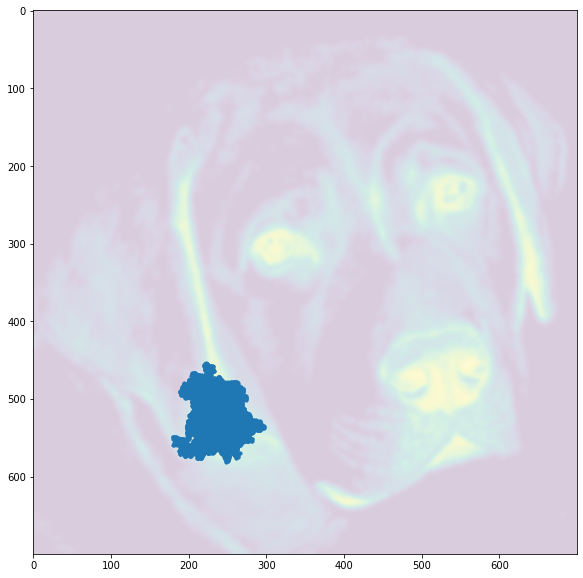

In [ ]:
## Couple of different strategies: use multiple runs from one sample vs. use a run from multiple samples
from tqdm import tqdm

d = 2  # dimensionality 
n_iter = 30000
k = 10
epsilon = 0.1

sampled_outputs = onp.zeros((1, n_iter, 2), dtype=density.dtype)
key = jax.random.PRNGKey(1)
key, subkey = jax.random.split(key)
init_sample = sample_from_image_density(1, density, subkey).flatten()

with tqdm(total=n_iter) as pbar:
  for i in range(n_iter):
      init_sample = hamiltonian_monte_carlo(init_sample, energy_fn, k, epsilon)
      sampled_outputs[0, i] = init_sample
      pbar.update(1)

import numpy as onp

onp.savez(
    f"/content/drive/MyDrive/CS699/homework #2/labrador_iter30000_k10.npy",
    sample=sampled_outputs
)

fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sampled_outputs[:, :, 0], sampled_outputs[:, :, 1], s=10)
ax.imshow(density, alpha=0.2)
matplotlib.pyplot.show()

  0%|          | 3/3000 [00:43<11:59:13, 14.40s/it]

Metropolis- Hastings REJECT 1.1717716 2.4191568


  0%|          | 7/3000 [01:40<11:49:51, 14.23s/it]

Metropolis- Hastings REJECT 0.13726388 0.7956999


  0%|          | 12/3000 [02:49<11:34:14, 13.94s/it]

Metropolis- Hastings REJECT 0.17791247 0.85008246


  1%|          | 23/3000 [05:22<11:29:46, 13.90s/it]

Metropolis- Hastings REJECT 0.5119561 1.3908805


  1%|          | 24/3000 [05:36<11:31:36, 13.94s/it]

Metropolis- Hastings REJECT 0.5119561 0.82894313


  1%|          | 28/3000 [06:32<11:33:52, 14.01s/it]

Metropolis- Hastings REJECT 1.2120876 3.5536225


  1%|          | 32/3000 [07:28<11:31:31, 13.98s/it]

Metropolis- Hastings REJECT 1.6157367 2.0021632


  1%|▏         | 39/3000 [09:06<11:29:56, 13.98s/it]

Metropolis- Hastings REJECT 1.3273089 2.1578236


  2%|▏         | 45/3000 [10:29<11:22:05, 13.85s/it]

Metropolis- Hastings REJECT 0.19258398 0.3400687


  2%|▏         | 46/3000 [10:42<11:19:35, 13.80s/it]

Metropolis- Hastings REJECT 0.19258398 1.4721847


  2%|▏         | 48/3000 [11:10<11:17:10, 13.76s/it]

Metropolis- Hastings REJECT 0.23538774 1.7223426


  2%|▏         | 49/3000 [11:24<11:22:21, 13.87s/it]

Metropolis- Hastings REJECT 0.23538774 1.4597192


  2%|▏         | 58/3000 [13:28<11:15:37, 13.78s/it]

Metropolis- Hastings REJECT 1.3773696 2.7341275


  2%|▏         | 68/3000 [15:45<11:14:36, 13.80s/it]

Metropolis- Hastings REJECT 0.5684748 1.4201145


  3%|▎         | 77/3000 [17:44<10:29:44, 12.93s/it]

Metropolis- Hastings REJECT 0.20983478 1.8860332


  3%|▎         | 84/3000 [19:15<10:29:16, 12.95s/it]

Metropolis- Hastings REJECT 0.0840523 0.3782765


  3%|▎         | 86/3000 [19:41<10:28:06, 12.93s/it]

Metropolis- Hastings REJECT 0.21483631 0.89099765


  3%|▎         | 87/3000 [19:54<10:32:49, 13.03s/it]

Metropolis- Hastings REJECT 0.21483631 1.5458121


  3%|▎         | 88/3000 [20:07<10:33:23, 13.05s/it]

Metropolis- Hastings REJECT 0.21483631 0.4012813


  3%|▎         | 90/3000 [20:33<10:33:52, 13.07s/it]

Metropolis- Hastings REJECT 0.5441965 2.0629861


  3%|▎         | 91/3000 [20:46<10:35:02, 13.10s/it]

Metropolis- Hastings REJECT 0.5441965 0.94576526


  3%|▎         | 92/3000 [21:00<10:36:04, 13.12s/it]

Metropolis- Hastings REJECT 0.5441965 1.1579298


  3%|▎         | 94/3000 [21:26<10:36:12, 13.14s/it]

Metropolis- Hastings REJECT 0.13231769 1.7103928


  3%|▎         | 95/3000 [21:39<10:33:46, 13.09s/it]

Metropolis- Hastings REJECT 0.13231769 0.4981392


  3%|▎         | 103/3000 [23:23<10:28:54, 13.03s/it]

Metropolis- Hastings REJECT 0.045092545 0.977782


  4%|▎         | 109/3000 [24:41<10:21:13, 12.89s/it]

Metropolis- Hastings REJECT 0.02045014 0.25647572


  4%|▍         | 115/3000 [25:57<10:11:53, 12.73s/it]

Metropolis- Hastings REJECT 0.39003006 0.6163515


  4%|▍         | 119/3000 [26:49<10:24:32, 13.01s/it]

Metropolis- Hastings REJECT 0.06740128 0.78082824


  4%|▍         | 128/3000 [28:46<10:15:54, 12.87s/it]

Metropolis- Hastings REJECT 0.94119966 3.542263


  4%|▍         | 129/3000 [28:58<10:13:35, 12.82s/it]

Metropolis- Hastings REJECT 0.94119966 1.3597416


  4%|▍         | 133/3000 [29:50<10:18:14, 12.94s/it]

Metropolis- Hastings REJECT 0.5246537 1.1653987


  5%|▍         | 136/3000 [30:28<10:11:40, 12.81s/it]

Metropolis- Hastings REJECT 0.15942775 1.7803794


  5%|▍         | 145/3000 [32:25<10:15:09, 12.93s/it]

Metropolis- Hastings REJECT 0.010182007 0.7752332


  5%|▍         | 147/3000 [32:51<10:20:29, 13.05s/it]

Metropolis- Hastings REJECT 0.09797623 3.5219743


  5%|▍         | 149/3000 [33:17<10:17:25, 12.99s/it]

Metropolis- Hastings REJECT 0.08648779 1.9393121


  5%|▌         | 150/3000 [33:30<10:14:30, 12.94s/it]

Metropolis- Hastings REJECT 0.08648779 0.45212173


  6%|▌         | 179/3000 [39:43<10:11:26, 13.00s/it]

Metropolis- Hastings REJECT 0.100533046 1.3875462


  6%|▌         | 181/3000 [40:08<10:07:28, 12.93s/it]

Metropolis- Hastings REJECT 0.07509746 1.0367182


  6%|▌         | 182/3000 [40:21<10:03:39, 12.85s/it]

Metropolis- Hastings REJECT 0.07509746 2.066687


  6%|▌         | 185/3000 [40:59<10:00:05, 12.79s/it]

Metropolis- Hastings REJECT 0.62851226 0.9088918


  6%|▋         | 188/3000 [41:37<9:54:54, 12.69s/it]

Metropolis- Hastings REJECT 0.21286356 3.5338488


  6%|▋         | 195/3000 [43:06<9:51:23, 12.65s/it]

Metropolis- Hastings REJECT 0.055915806 1.0327041


  7%|▋         | 197/3000 [43:32<9:55:11, 12.74s/it]

Metropolis- Hastings REJECT 0.10565523 1.2012798


  7%|▋         | 201/3000 [44:23<9:59:55, 12.86s/it]

Metropolis- Hastings REJECT 0.03280334 0.424233


  7%|▋         | 211/3000 [46:30<9:51:13, 12.72s/it]

Metropolis- Hastings REJECT 0.71307486 1.4187692


  7%|▋         | 212/3000 [46:43<9:51:17, 12.73s/it]

Metropolis- Hastings REJECT 0.71307486 2.5492406


  7%|▋         | 215/3000 [47:22<10:02:25, 12.98s/it]

Metropolis- Hastings REJECT 0.10964548 1.0237548


  8%|▊         | 227/3000 [49:55<9:50:50, 12.78s/it]

Metropolis- Hastings REJECT 1.8269672 inf


  8%|▊         | 233/3000 [51:12<9:49:41, 12.79s/it]

Metropolis- Hastings REJECT 0.5893653 1.375677


  8%|▊         | 242/3000 [53:08<9:48:19, 12.80s/it]

Metropolis- Hastings REJECT 0.53556603 1.1840339


  8%|▊         | 245/3000 [53:46<9:50:15, 12.86s/it]

Metropolis- Hastings REJECT 0.3196352 inf


  8%|▊         | 253/3000 [55:29<9:46:23, 12.81s/it]

Metropolis- Hastings REJECT 0.062490348 0.8617931


  8%|▊         | 254/3000 [55:42<9:47:39, 12.84s/it]

Metropolis- Hastings REJECT 0.062490348 1.2470584


  9%|▊         | 262/3000 [57:23<9:38:48, 12.68s/it]

Metropolis- Hastings REJECT 0.077683 0.4631933


  9%|▉         | 268/3000 [58:40<9:34:54, 12.63s/it]

Metropolis- Hastings REJECT 0.17011869 0.39985368


  9%|▉         | 273/3000 [59:44<9:43:47, 12.84s/it]

Metropolis- Hastings REJECT 1.9945358 inf


  9%|▉         | 277/3000 [1:00:35<9:38:39, 12.75s/it]

Metropolis- Hastings REJECT 0.4281229 0.57127845


  9%|▉         | 282/3000 [1:01:39<9:43:21, 12.88s/it]

Metropolis- Hastings REJECT 0.41692522 0.93124914


 10%|▉         | 285/3000 [1:02:18<9:45:25, 12.94s/it]

Metropolis- Hastings REJECT 0.30485132 0.924973


 10%|▉         | 288/3000 [1:02:56<9:39:04, 12.81s/it]

Metropolis- Hastings REJECT 0.089708574 1.161321


 10%|▉         | 293/3000 [1:04:00<9:38:31, 12.82s/it]

Metropolis- Hastings REJECT 0.21781391 0.67994905


 10%|▉         | 294/3000 [1:04:13<9:37:34, 12.81s/it]

Metropolis- Hastings REJECT 0.21781391 2.385221


 10%|▉         | 297/3000 [1:04:51<9:33:03, 12.72s/it]

Metropolis- Hastings REJECT 0.15347797 0.33781952


 10%|▉         | 299/3000 [1:05:17<9:39:30, 12.87s/it]

Metropolis- Hastings REJECT 0.21429662 0.5365813


 10%|█         | 303/3000 [1:06:09<9:45:29, 13.03s/it]

Metropolis- Hastings REJECT 0.9271484 1.451318


 10%|█         | 308/3000 [1:07:14<9:39:41, 12.92s/it]

Metropolis- Hastings REJECT 0.5648598 inf


 10%|█         | 309/3000 [1:07:26<9:35:58, 12.84s/it]

Metropolis- Hastings REJECT 0.5648598 2.0221415


 10%|█         | 312/3000 [1:08:05<9:33:42, 12.81s/it]

Metropolis- Hastings REJECT 0.2792726 0.86763054


 10%|█         | 314/3000 [1:08:30<9:33:34, 12.81s/it]

Metropolis- Hastings REJECT 0.42411557 0.7076601


 11%|█         | 317/3000 [1:09:10<9:48:20, 13.16s/it]

Metropolis- Hastings REJECT 0.3406339 0.69248116


 11%|█         | 322/3000 [1:10:14<9:33:07, 12.84s/it]

Metropolis- Hastings REJECT 0.06546293 0.3921324


 11%|█         | 324/3000 [1:10:40<9:31:07, 12.81s/it]

Metropolis- Hastings REJECT 0.06880405 0.46151865


 11%|█         | 325/3000 [1:10:53<9:32:34, 12.84s/it]

Metropolis- Hastings REJECT 0.06880405 0.11861372


 11%|█         | 330/3000 [1:11:56<9:22:39, 12.64s/it]

Metropolis- Hastings REJECT 0.08611821 1.7460974


 11%|█         | 336/3000 [1:13:12<9:28:55, 12.81s/it]

Metropolis- Hastings REJECT 0.19233903 0.5560191


 11%|█▏        | 342/3000 [1:14:29<9:24:58, 12.75s/it]

Metropolis- Hastings REJECT 2.496459 3.4865487


 12%|█▏        | 345/3000 [1:15:07<9:23:07, 12.73s/it]

Metropolis- Hastings REJECT 1.0428748 2.37892


 12%|█▏        | 348/3000 [1:15:45<9:21:36, 12.71s/it]

Metropolis- Hastings REJECT 0.36756635 1.0173037


 12%|█▏        | 366/3000 [1:19:34<9:23:44, 12.84s/it]

Metropolis- Hastings REJECT 0.24354671 0.568036


 12%|█▏        | 371/3000 [1:20:37<9:13:52, 12.64s/it]

Metropolis- Hastings REJECT 0.20847756 1.4467186


 12%|█▏        | 373/3000 [1:21:03<9:18:53, 12.76s/it]

Metropolis- Hastings REJECT 0.0784388 1.3601199


 13%|█▎        | 378/3000 [1:22:07<9:17:51, 12.77s/it]

Metropolis- Hastings REJECT 0.11991457 0.9601644


 13%|█▎        | 382/3000 [1:22:58<9:22:54, 12.90s/it]

Metropolis- Hastings REJECT 0.24796283 0.8080856


 13%|█▎        | 385/3000 [1:23:37<9:22:26, 12.90s/it]

Metropolis- Hastings REJECT 0.2467117 0.38462538


 13%|█▎        | 386/3000 [1:23:51<9:32:21, 13.14s/it]

Metropolis- Hastings REJECT 0.2467117 0.39550892


 13%|█▎        | 389/3000 [1:24:29<9:18:47, 12.84s/it]

Metropolis- Hastings REJECT 0.0898965 0.6555654


 13%|█▎        | 395/3000 [1:25:45<9:16:31, 12.82s/it]

Metropolis- Hastings REJECT 0.09660872 0.33476353


 13%|█▎        | 396/3000 [1:25:58<9:17:32, 12.85s/it]

Metropolis- Hastings REJECT 0.09660872 0.6619448


 13%|█▎        | 398/3000 [1:26:24<9:17:00, 12.84s/it]

Metropolis- Hastings REJECT 0.07856285 0.20118363


 13%|█▎        | 403/3000 [1:27:27<9:12:46, 12.77s/it]

Metropolis- Hastings REJECT 0.5523938 0.7870171


 14%|█▎        | 410/3000 [1:28:57<9:14:37, 12.85s/it]

Metropolis- Hastings REJECT 0.32214692 2.7656765


 14%|█▎        | 411/3000 [1:29:09<9:11:43, 12.79s/it]

Metropolis- Hastings REJECT 0.32214692 0.34352204


 14%|█▍        | 416/3000 [1:30:12<9:01:49, 12.58s/it]

Metropolis- Hastings REJECT 0.15927501 0.8566632


 14%|█▍        | 433/3000 [1:33:49<9:09:00, 12.83s/it]

Metropolis- Hastings REJECT 0.31457797 1.8435557


 15%|█▍        | 438/3000 [1:34:54<9:08:37, 12.85s/it]

Metropolis- Hastings REJECT 0.07397083 1.1001747


 15%|█▍        | 439/3000 [1:35:06<9:05:21, 12.78s/it]

Metropolis- Hastings REJECT 0.07397083 1.1203982


 15%|█▍        | 446/3000 [1:36:36<9:05:41, 12.82s/it]

Metropolis- Hastings REJECT 0.5135917 3.5153193


 15%|█▍        | 448/3000 [1:37:01<9:04:48, 12.81s/it]

Metropolis- Hastings REJECT 0.56750673 1.3081769


 15%|█▍        | 449/3000 [1:37:15<9:11:38, 12.97s/it]

Metropolis- Hastings REJECT 0.56750673 1.091049


 15%|█▌        | 450/3000 [1:37:28<9:11:14, 12.97s/it]

Metropolis- Hastings REJECT 0.56750673 3.507749


 15%|█▌        | 453/3000 [1:38:06<9:05:37, 12.85s/it]

Metropolis- Hastings REJECT 0.10814185 1.0728966


 15%|█▌        | 455/3000 [1:38:31<9:02:51, 12.80s/it]

Metropolis- Hastings REJECT 0.24513458 1.8018794


 15%|█▌        | 462/3000 [1:40:01<9:04:14, 12.87s/it]

Metropolis- Hastings REJECT 0.70812905 0.8741292


 16%|█▌        | 466/3000 [1:40:52<8:54:30, 12.66s/it]

Metropolis- Hastings REJECT 0.15092525 0.3021625


 16%|█▌        | 474/3000 [1:42:35<8:59:23, 12.81s/it]

Metropolis- Hastings REJECT 0.166887 1.7953645


 16%|█▌        | 476/3000 [1:43:00<8:58:59, 12.81s/it]

Metropolis- Hastings REJECT 0.071957394 0.3941909


 16%|█▋        | 490/3000 [1:46:03<9:00:25, 12.92s/it]

Metropolis- Hastings REJECT 0.37680346 1.0211146


 16%|█▋        | 494/3000 [1:46:54<8:54:10, 12.79s/it]

Metropolis- Hastings REJECT 0.57751167 1.1171827


 17%|█▋        | 496/3000 [1:47:19<8:48:43, 12.67s/it]

Metropolis- Hastings REJECT 0.16027656 0.8172281


 17%|█▋        | 503/3000 [1:48:48<8:55:41, 12.87s/it]

Metropolis- Hastings REJECT 0.15866809 1.3590968


 17%|█▋        | 506/3000 [1:49:26<8:49:35, 12.74s/it]

Metropolis- Hastings REJECT 0.49457562 1.1997817


 17%|█▋        | 508/3000 [1:49:51<8:50:43, 12.78s/it]

Metropolis- Hastings REJECT 0.15709084 1.3291998


 17%|█▋        | 509/3000 [1:50:04<8:51:42, 12.81s/it]

Metropolis- Hastings REJECT 0.15709084 2.3892314


 17%|█▋        | 510/3000 [1:50:17<8:49:54, 12.77s/it]

Metropolis- Hastings REJECT 0.15709084 0.34973666


 17%|█▋        | 512/3000 [1:50:42<8:46:32, 12.70s/it]

Metropolis- Hastings REJECT 0.056863695 0.9154141


 17%|█▋        | 518/3000 [1:51:58<8:41:24, 12.60s/it]

Metropolis- Hastings REJECT 0.45695436 1.0685878


 17%|█▋        | 520/3000 [1:52:24<8:47:14, 12.76s/it]

Metropolis- Hastings REJECT 0.49927503 0.6159038


 18%|█▊        | 528/3000 [1:54:05<8:41:19, 12.65s/it]

Metropolis- Hastings REJECT 0.16870935 1.4288089


 18%|█▊        | 535/3000 [1:55:37<8:50:43, 12.92s/it]

Metropolis- Hastings REJECT 0.08782584 0.7626699


 18%|█▊        | 536/3000 [1:55:49<8:48:39, 12.87s/it]

Metropolis- Hastings REJECT 0.08782584 1.0531968


 18%|█▊        | 537/3000 [1:56:02<8:44:56, 12.79s/it]

Metropolis- Hastings REJECT 0.08782584 0.81018794


 18%|█▊        | 551/3000 [1:58:59<8:35:47, 12.64s/it]

Metropolis- Hastings REJECT 0.3785373 0.7714354


 18%|█▊        | 552/3000 [1:59:12<8:36:52, 12.67s/it]

Metropolis- Hastings REJECT 0.3785373 0.8136205


 19%|█▊        | 560/3000 [2:00:52<8:30:36, 12.56s/it]

Metropolis- Hastings REJECT 0.5990426 1.4442648


 19%|█▉        | 572/3000 [2:03:25<8:44:14, 12.95s/it]

Metropolis- Hastings REJECT 0.18188544 3.3114877


 19%|█▉        | 576/3000 [2:04:16<8:34:38, 12.74s/it]

Metropolis- Hastings REJECT 0.24943174 1.3464094


 19%|█▉        | 583/3000 [2:05:46<8:39:39, 12.90s/it]

Metropolis- Hastings REJECT 0.35518 0.77343905


 20%|█▉        | 585/3000 [2:06:12<8:35:45, 12.81s/it]

Metropolis- Hastings REJECT 1.1252114 1.5202731


 20%|█▉        | 586/3000 [2:06:24<8:33:38, 12.77s/it]

Metropolis- Hastings REJECT 1.1252114 1.6821343


 20%|█▉        | 590/3000 [2:07:16<8:37:40, 12.89s/it]

Metropolis- Hastings REJECT 0.97885025 3.552626


 20%|█▉        | 595/3000 [2:08:19<8:25:12, 12.60s/it]

Metropolis- Hastings REJECT 0.1524024 1.111974


 20%|██        | 600/3000 [2:09:21<8:20:18, 12.51s/it]

Metropolis- Hastings REJECT 0.5293957 0.83767134


 20%|██        | 603/3000 [2:09:59<8:23:05, 12.59s/it]

Metropolis- Hastings REJECT 0.17332718 0.43548626


 20%|██        | 604/3000 [2:10:11<8:19:50, 12.52s/it]

Metropolis- Hastings REJECT 0.17332718 0.40953925


 20%|██        | 615/3000 [2:12:31<8:27:53, 12.78s/it]

Metropolis- Hastings REJECT 1.3765603 inf


 21%|██        | 616/3000 [2:12:43<8:26:13, 12.74s/it]

Metropolis- Hastings REJECT 1.3765603 inf


 21%|██        | 621/3000 [2:13:46<8:22:01, 12.66s/it]

Metropolis- Hastings REJECT 0.07474214 1.1590468


 21%|██        | 622/3000 [2:13:59<8:23:44, 12.71s/it]

Metropolis- Hastings REJECT 0.07474214 0.89659345


 21%|██        | 625/3000 [2:14:37<8:25:50, 12.78s/it]

Metropolis- Hastings REJECT 0.29763213 0.9975047


 21%|██        | 626/3000 [2:14:50<8:23:39, 12.73s/it]

Metropolis- Hastings REJECT 0.29763213 1.1260543


 21%|██        | 636/3000 [2:16:57<8:22:26, 12.75s/it]

Metropolis- Hastings REJECT 1.5802085 3.5153873


 21%|██        | 637/3000 [2:17:10<8:26:01, 12.85s/it]

Metropolis- Hastings REJECT 1.5802085 1.8521234


 21%|██▏       | 638/3000 [2:17:23<8:24:32, 12.82s/it]

Metropolis- Hastings REJECT 1.5802085 2.015727


 21%|██▏       | 644/3000 [2:18:40<8:22:57, 12.81s/it]

Metropolis- Hastings REJECT 1.8188728 3.4776273


 22%|██▏       | 645/3000 [2:18:53<8:25:00, 12.87s/it]

Metropolis- Hastings REJECT 1.8188728 2.091115


 22%|██▏       | 646/3000 [2:19:06<8:29:11, 12.98s/it]

Metropolis- Hastings REJECT 1.8188728 3.5308864


 22%|██▏       | 647/3000 [2:19:19<8:29:48, 13.00s/it]

Metropolis- Hastings REJECT 1.8188728 inf


 22%|██▏       | 649/3000 [2:19:44<8:25:11, 12.89s/it]

Metropolis- Hastings REJECT 1.83386 2.6411607


 22%|██▏       | 655/3000 [2:21:02<8:25:36, 12.94s/it]

Metropolis- Hastings REJECT 0.7587032 inf


 22%|██▏       | 660/3000 [2:22:07<8:26:13, 12.98s/it]

Metropolis- Hastings REJECT 0.22355542 1.2237206


 22%|██▏       | 662/3000 [2:22:33<8:28:32, 13.05s/it]

Metropolis- Hastings REJECT 0.1526199 1.09978


 22%|██▏       | 663/3000 [2:22:46<8:27:44, 13.04s/it]

Metropolis- Hastings REJECT 0.1526199 1.3023187


 22%|██▏       | 665/3000 [2:23:12<8:22:28, 12.91s/it]

Metropolis- Hastings REJECT 0.101436526 0.12262876


 22%|██▏       | 669/3000 [2:24:03<8:21:32, 12.91s/it]

Metropolis- Hastings REJECT 0.21085106 0.87358475


 22%|██▏       | 670/3000 [2:24:16<8:21:48, 12.92s/it]

Metropolis- Hastings REJECT 0.21085106 0.73403865


 22%|██▏       | 671/3000 [2:24:29<8:24:18, 12.99s/it]

Metropolis- Hastings REJECT 0.21085106 1.685014


 23%|██▎       | 676/3000 [2:25:34<8:26:42, 13.08s/it]

Metropolis- Hastings REJECT 0.53825194 1.3188181


 23%|██▎       | 677/3000 [2:25:48<8:29:30, 13.16s/it]

Metropolis- Hastings REJECT 0.53825194 1.4747374


 23%|██▎       | 678/3000 [2:26:01<8:28:48, 13.15s/it]

Metropolis- Hastings REJECT 0.53825194 2.0011857


 23%|██▎       | 684/3000 [2:27:19<8:19:02, 12.93s/it]

Metropolis- Hastings REJECT 0.30982164 1.4436098


 23%|██▎       | 685/3000 [2:27:32<8:20:53, 12.98s/it]

Metropolis- Hastings REJECT 0.30982164 3.538202


 23%|██▎       | 691/3000 [2:28:49<8:17:58, 12.94s/it]

Metropolis- Hastings REJECT 0.75479984 1.2484667


 23%|██▎       | 696/3000 [2:29:53<8:12:49, 12.83s/it]

Metropolis- Hastings REJECT 0.4705134 1.9680097


 24%|██▎       | 706/3000 [2:32:03<8:16:32, 12.99s/it]

Metropolis- Hastings REJECT 0.51989913 1.2305729


 24%|██▎       | 709/3000 [2:32:42<8:15:37, 12.98s/it]

Metropolis- Hastings REJECT 1.1984487 inf


 24%|██▍       | 720/3000 [2:35:03<8:08:43, 12.86s/it]

Metropolis- Hastings REJECT 0.43572748 1.2718136


 24%|██▍       | 722/3000 [2:35:28<8:06:45, 12.82s/it]

Metropolis- Hastings REJECT 0.41784117 1.6003852


 24%|██▍       | 724/3000 [2:35:54<8:05:47, 12.81s/it]

Metropolis- Hastings REJECT 0.43516192 3.5716693


 24%|██▍       | 725/3000 [2:36:07<8:04:10, 12.77s/it]

Metropolis- Hastings REJECT 0.43516192 1.2565159


 24%|██▍       | 727/3000 [2:36:32<8:03:44, 12.77s/it]

Metropolis- Hastings REJECT 0.046413947 0.7760141


 24%|██▍       | 728/3000 [2:36:45<8:02:12, 12.73s/it]

Metropolis- Hastings REJECT 0.046413947 1.6377857


 24%|██▍       | 729/3000 [2:36:58<8:00:03, 12.68s/it]

Metropolis- Hastings REJECT 0.046413947 0.29904544


 24%|██▍       | 730/3000 [2:37:10<7:59:52, 12.68s/it]

Metropolis- Hastings REJECT 0.046413947 0.508514


 24%|██▍       | 734/3000 [2:38:01<7:59:59, 12.71s/it]

Metropolis- Hastings REJECT 0.03256747 0.4079042


 25%|██▍       | 739/3000 [2:39:05<7:59:35, 12.73s/it]

Metropolis- Hastings REJECT 0.59659994 1.484314


 25%|██▍       | 740/3000 [2:39:18<8:00:40, 12.76s/it]

Metropolis- Hastings REJECT 0.59659994 1.2675102


 25%|██▍       | 745/3000 [2:40:21<7:57:12, 12.70s/it]

Metropolis- Hastings REJECT 0.050482072 0.34446925


 25%|██▌       | 759/3000 [2:43:22<8:04:43, 12.98s/it]

Metropolis- Hastings REJECT 0.45120633 0.820213


 26%|██▌       | 766/3000 [2:44:51<7:53:31, 12.72s/it]

Metropolis- Hastings REJECT 0.39268917 0.61405694


 26%|██▌       | 768/3000 [2:45:16<7:55:05, 12.77s/it]

Metropolis- Hastings REJECT 0.188792 0.7609384


 26%|██▌       | 771/3000 [2:45:54<7:50:10, 12.66s/it]

Metropolis- Hastings REJECT 0.62486637 1.5183628


 26%|██▌       | 775/3000 [2:46:46<7:58:32, 12.90s/it]

Metropolis- Hastings REJECT 0.12715872 1.4797356


 26%|██▌       | 778/3000 [2:47:24<7:55:14, 12.83s/it]

Metropolis- Hastings REJECT 0.0717333 0.7235852


 26%|██▌       | 781/3000 [2:48:02<7:52:04, 12.76s/it]

Metropolis- Hastings REJECT 0.16587086 0.79883957


 26%|██▌       | 783/3000 [2:48:28<7:50:26, 12.73s/it]

Metropolis- Hastings REJECT 0.06985493 0.5274961


 26%|██▌       | 784/3000 [2:48:40<7:47:49, 12.67s/it]

Metropolis- Hastings REJECT 0.06985493 1.4520556


 26%|██▌       | 785/3000 [2:48:53<7:48:43, 12.70s/it]

Metropolis- Hastings REJECT 0.06985493 0.9559962


 26%|██▋       | 788/3000 [2:49:31<7:47:01, 12.67s/it]

Metropolis- Hastings REJECT 0.104065314 0.8504004


 26%|██▋       | 790/3000 [2:49:56<7:45:49, 12.65s/it]

Metropolis- Hastings REJECT 0.4756692 1.3161149


 27%|██▋       | 800/3000 [2:52:04<7:48:39, 12.78s/it]

Metropolis- Hastings REJECT 0.20753205 0.66789556


 27%|██▋       | 803/3000 [2:52:42<7:47:25, 12.77s/it]

Metropolis- Hastings REJECT 1.2322912 3.5127144


 27%|██▋       | 805/3000 [2:53:07<7:45:19, 12.72s/it]

Metropolis- Hastings REJECT 1.2358776 3.552707


 27%|██▋       | 813/3000 [2:54:50<7:44:18, 12.74s/it]

Metropolis- Hastings REJECT 0.5124625 1.4546807


 27%|██▋       | 815/3000 [2:55:16<7:51:03, 12.94s/it]

Metropolis- Hastings REJECT 0.26884928 1.2231138


 27%|██▋       | 816/3000 [2:55:29<7:49:19, 12.89s/it]

Metropolis- Hastings REJECT 0.26884928 1.4650905


 28%|██▊       | 829/3000 [2:58:18<7:51:42, 13.04s/it]

Metropolis- Hastings REJECT 0.5654547 3.5118902


 28%|██▊       | 833/3000 [2:59:11<7:59:41, 13.28s/it]

Metropolis- Hastings REJECT 1.1228791 2.0868187


 28%|██▊       | 834/3000 [2:59:25<8:01:04, 13.33s/it]

Metropolis- Hastings REJECT 1.1228791 1.7244033


 28%|██▊       | 839/3000 [3:00:32<8:02:31, 13.40s/it]

Metropolis- Hastings REJECT 0.26448023 1.2861247


 28%|██▊       | 846/3000 [3:02:04<7:56:15, 13.27s/it]

Metropolis- Hastings REJECT 0.41882533 3.5145316


 28%|██▊       | 850/3000 [3:02:58<7:59:29, 13.38s/it]

Metropolis- Hastings REJECT 0.3606799 1.3674


 29%|██▊       | 860/3000 [3:05:10<7:51:14, 13.21s/it]

Metropolis- Hastings REJECT 3.506821 inf


 29%|██▊       | 861/3000 [3:05:23<7:51:15, 13.22s/it]

Metropolis- Hastings REJECT 3.506821 inf


 29%|██▊       | 862/3000 [3:05:36<7:50:26, 13.20s/it]

Metropolis- Hastings REJECT 3.506821 inf


 29%|██▉       | 863/3000 [3:05:49<7:49:24, 13.18s/it]

Metropolis- Hastings REJECT 3.506821 inf


 29%|██▉       | 864/3000 [3:06:03<7:50:39, 13.22s/it]

Metropolis- Hastings REJECT 3.506821 inf


 29%|██▉       | 870/3000 [3:07:23<7:54:25, 13.36s/it]

Metropolis- Hastings REJECT 3.1809967 3.5081167


 29%|██▉       | 874/3000 [3:08:16<7:52:28, 13.33s/it]

Metropolis- Hastings REJECT 1.7915899 inf


 29%|██▉       | 876/3000 [3:08:42<7:48:20, 13.23s/it]

Metropolis- Hastings REJECT 2.0850534 3.5238914


 29%|██▉       | 881/3000 [3:09:48<7:45:34, 13.18s/it]

Metropolis- Hastings REJECT 2.2041368 2.769783


 29%|██▉       | 883/3000 [3:10:14<7:46:00, 13.21s/it]

Metropolis- Hastings REJECT 1.8759549 2.4365957


 30%|██▉       | 887/3000 [3:11:08<7:50:19, 13.36s/it]

Metropolis- Hastings REJECT 1.0562366 1.3491149


 30%|██▉       | 897/3000 [3:13:20<7:40:35, 13.14s/it]

Metropolis- Hastings REJECT 0.48782718 1.3648652


 30%|██▉       | 898/3000 [3:13:33<7:43:23, 13.23s/it]

Metropolis- Hastings REJECT 0.48782718 1.1894724


 30%|██▉       | 899/3000 [3:13:47<7:44:36, 13.27s/it]

Metropolis- Hastings REJECT 0.48782718 1.366312


 30%|███       | 905/3000 [3:15:06<7:40:51, 13.20s/it]

Metropolis- Hastings REJECT 0.9631215 1.6248695


 30%|███       | 915/3000 [3:17:16<7:32:17, 13.02s/it]

Metropolis- Hastings REJECT 0.041328598 3.5387313


 31%|███       | 922/3000 [3:18:48<7:35:36, 13.16s/it]

Metropolis- Hastings REJECT 0.5952205 3.221438


 31%|███       | 926/3000 [3:19:41<7:36:55, 13.22s/it]

Metropolis- Hastings REJECT 0.48610315 1.7495481


 31%|███       | 928/3000 [3:20:07<7:37:20, 13.24s/it]

Metropolis- Hastings REJECT 0.06981505 0.4083356


 31%|███       | 937/3000 [3:22:08<7:40:04, 13.38s/it]

Metropolis- Hastings REJECT 0.09833195 1.1086813


 31%|███▏      | 941/3000 [3:23:02<7:44:45, 13.54s/it]

Metropolis- Hastings REJECT 0.8060854 1.6593624


 31%|███▏      | 944/3000 [3:23:41<7:35:32, 13.29s/it]

Metropolis- Hastings REJECT 0.89142716 1.6506703


 32%|███▏      | 955/3000 [3:26:07<7:30:36, 13.22s/it]

Metropolis- Hastings REJECT 0.20621544 0.79011035


 32%|███▏      | 956/3000 [3:26:20<7:30:50, 13.23s/it]

Metropolis- Hastings REJECT 0.20621544 1.2308693


 32%|███▏      | 957/3000 [3:26:34<7:32:41, 13.29s/it]

Metropolis- Hastings REJECT 0.20621544 1.1883488


 32%|███▏      | 958/3000 [3:26:47<7:32:00, 13.28s/it]

Metropolis- Hastings REJECT 0.20621544 0.51035017


 32%|███▏      | 962/3000 [3:27:41<7:37:23, 13.47s/it]

Metropolis- Hastings REJECT 0.12646523 1.2721261


 33%|███▎      | 985/3000 [3:32:47<7:27:06, 13.31s/it]

Metropolis- Hastings REJECT 0.19242565 0.7263349


 33%|███▎      | 986/3000 [3:33:01<7:28:11, 13.35s/it]

Metropolis- Hastings REJECT 0.19242565 0.7063332


 33%|███▎      | 988/3000 [3:33:28<7:28:05, 13.36s/it]

Metropolis- Hastings REJECT 0.14274299 0.1836259


 33%|███▎      | 996/3000 [3:35:16<7:33:22, 13.57s/it]

Metropolis- Hastings REJECT 0.16904223 1.062845


 33%|███▎      | 1000/3000 [3:36:10<7:30:49, 13.52s/it]

Metropolis- Hastings REJECT 0.13403676 0.9110093


 34%|███▎      | 1005/3000 [3:37:17<7:28:38, 13.49s/it]

Metropolis- Hastings REJECT 0.2664282 1.1172005


 34%|███▎      | 1006/3000 [3:37:31<7:30:15, 13.55s/it]

Metropolis- Hastings REJECT 0.2664282 1.1902938


 34%|███▎      | 1008/3000 [3:37:58<7:28:21, 13.50s/it]

Metropolis- Hastings REJECT 0.640341 1.5970994


 34%|███▍      | 1013/3000 [3:39:06<7:29:59, 13.59s/it]

Metropolis- Hastings REJECT 0.49674514 1.2814


 34%|███▍      | 1017/3000 [3:40:00<7:30:30, 13.63s/it]

Metropolis- Hastings REJECT 0.79489475 2.3670914


 34%|███▍      | 1023/3000 [3:41:22<7:27:52, 13.59s/it]

Metropolis- Hastings REJECT 0.19676207 1.0422227


 34%|███▍      | 1028/3000 [3:42:30<7:28:41, 13.65s/it]

Metropolis- Hastings REJECT 1.1973138 1.528229


 34%|███▍      | 1032/3000 [3:43:26<7:33:25, 13.82s/it]

Metropolis- Hastings REJECT 0.5902197 3.3172047


 35%|███▍      | 1036/3000 [3:44:20<7:23:44, 13.56s/it]

Metropolis- Hastings REJECT 0.22964926 1.397273


 35%|███▍      | 1039/3000 [3:45:01<7:26:30, 13.66s/it]

Metropolis- Hastings REJECT 0.085356 1.4496534


 35%|███▍      | 1043/3000 [3:45:55<7:24:40, 13.63s/it]

Metropolis- Hastings REJECT 0.391999 3.3279183


 35%|███▍      | 1046/3000 [3:46:36<7:23:09, 13.61s/it]

Metropolis- Hastings REJECT 0.11859741 0.7398101


 35%|███▍      | 1047/3000 [3:46:49<7:21:10, 13.55s/it]

Metropolis- Hastings REJECT 0.11859741 0.9334442


 35%|███▍      | 1049/3000 [3:47:16<7:21:10, 13.57s/it]

Metropolis- Hastings REJECT 0.19461331 0.54208684


 35%|███▌      | 1055/3000 [3:48:38<7:25:53, 13.76s/it]

Metropolis- Hastings REJECT 0.40300307 0.7425763


 35%|███▌      | 1061/3000 [3:49:59<7:16:40, 13.51s/it]

Metropolis- Hastings REJECT 0.19368125 0.5977868


 36%|███▌      | 1066/3000 [3:51:07<7:19:34, 13.64s/it]

Metropolis- Hastings REJECT 0.13895258 0.77992725


 36%|███▌      | 1085/3000 [3:55:24<7:11:55, 13.53s/it]

Metropolis- Hastings REJECT 0.23178446 0.7386103


 36%|███▌      | 1086/3000 [3:55:38<7:08:47, 13.44s/it]

Metropolis- Hastings REJECT 0.23178446 0.78048795


 36%|███▌      | 1087/3000 [3:55:51<7:08:48, 13.45s/it]

Metropolis- Hastings REJECT 0.23178446 0.93350667


 36%|███▋      | 1093/3000 [3:57:11<7:06:51, 13.43s/it]

Metropolis- Hastings REJECT 0.5927933 1.4253114


 37%|███▋      | 1100/3000 [3:58:46<7:12:34, 13.66s/it]

Metropolis- Hastings REJECT 0.15766026 0.52362955


 37%|███▋      | 1101/3000 [3:59:00<7:13:14, 13.69s/it]

Metropolis- Hastings REJECT 0.15766026 0.5482704


 37%|███▋      | 1102/3000 [3:59:14<7:09:52, 13.59s/it]

Metropolis- Hastings REJECT 0.15766026 0.8212458


 37%|███▋      | 1103/3000 [3:59:27<7:09:55, 13.60s/it]

Metropolis- Hastings REJECT 0.15766026 1.4449275


 37%|███▋      | 1107/3000 [4:00:21<7:04:54, 13.47s/it]

Metropolis- Hastings REJECT 0.14144638 1.0675387


 37%|███▋      | 1108/3000 [4:00:34<7:04:25, 13.46s/it]

Metropolis- Hastings REJECT 0.14144638 0.2876974


 37%|███▋      | 1112/3000 [4:01:29<7:04:28, 13.49s/it]

Metropolis- Hastings REJECT 0.059321694 0.615844


 37%|███▋      | 1113/3000 [4:01:42<7:04:19, 13.49s/it]

Metropolis- Hastings REJECT 0.059321694 2.3174703


 37%|███▋      | 1117/3000 [4:02:37<7:05:43, 13.57s/it]

Metropolis- Hastings REJECT 0.2919205 0.8634106


 37%|███▋      | 1118/3000 [4:02:50<7:04:21, 13.53s/it]

Metropolis- Hastings REJECT 0.2919205 0.5359865


 38%|███▊      | 1140/3000 [4:07:46<6:57:19, 13.46s/it]

Metropolis- Hastings REJECT 0.58403695 1.119328


 38%|███▊      | 1141/3000 [4:07:59<6:56:11, 13.43s/it]

Metropolis- Hastings REJECT 0.58403695 1.1783875


 38%|███▊      | 1149/3000 [4:09:48<6:58:25, 13.56s/it]

Metropolis- Hastings REJECT 0.071886875 3.5604048


 38%|███▊      | 1150/3000 [4:10:02<6:59:46, 13.61s/it]

Metropolis- Hastings REJECT 0.071886875 0.50421846


 38%|███▊      | 1151/3000 [4:10:15<6:57:10, 13.54s/it]

Metropolis- Hastings REJECT 0.071886875 0.39014453


 39%|███▊      | 1160/3000 [4:12:17<6:57:25, 13.61s/it]

Metropolis- Hastings REJECT 0.28100944 1.2285208


 39%|███▉      | 1168/3000 [4:14:06<6:53:35, 13.55s/it]

Metropolis- Hastings REJECT 0.30851433 0.7231288


 39%|███▉      | 1170/3000 [4:14:34<6:58:01, 13.71s/it]

Metropolis- Hastings REJECT 0.10101508 3.5754442


 39%|███▉      | 1174/3000 [4:15:29<6:56:47, 13.70s/it]

Metropolis- Hastings REJECT 0.37100002 1.024691


 39%|███▉      | 1180/3000 [4:16:50<6:52:47, 13.61s/it]

Metropolis- Hastings REJECT 0.32070142 0.7101268


 39%|███▉      | 1181/3000 [4:17:03<6:51:06, 13.56s/it]

Metropolis- Hastings REJECT 0.32070142 0.9540342


 39%|███▉      | 1183/3000 [4:17:31<6:51:11, 13.58s/it]

Metropolis- Hastings REJECT 0.012316302 0.23430818


 40%|███▉      | 1190/3000 [4:19:04<6:47:29, 13.51s/it]

Metropolis- Hastings REJECT 0.5206345 1.285767


 40%|███▉      | 1191/3000 [4:19:18<6:50:11, 13.60s/it]

Metropolis- Hastings REJECT 0.5206345 0.7584669


 40%|███▉      | 1195/3000 [4:20:13<6:49:16, 13.60s/it]

Metropolis- Hastings REJECT 0.7537705 2.812634


 40%|███▉      | 1197/3000 [4:20:40<6:50:11, 13.65s/it]

Metropolis- Hastings REJECT 0.24977845 inf


 40%|███▉      | 1198/3000 [4:20:54<6:50:22, 13.66s/it]

Metropolis- Hastings REJECT 0.24977845 0.8866985


 40%|████      | 1200/3000 [4:21:22<6:53:51, 13.80s/it]

Metropolis- Hastings REJECT 0.12401555 0.5056815


 41%|████      | 1225/3000 [4:27:00<6:41:50, 13.58s/it]

Metropolis- Hastings REJECT 0.07640722 0.2638364


 41%|████▏     | 1241/3000 [4:30:32<6:28:35, 13.25s/it]

Metropolis- Hastings REJECT 0.23580237 0.74955124


 41%|████▏     | 1244/3000 [4:31:12<6:29:13, 13.30s/it]

Metropolis- Hastings REJECT 0.10917768 0.98816955


 42%|████▏     | 1245/3000 [4:31:26<6:32:00, 13.40s/it]

Metropolis- Hastings REJECT 0.10917768 1.1309243


 42%|████▏     | 1249/3000 [4:32:19<6:28:33, 13.31s/it]

Metropolis- Hastings REJECT 0.20983192 1.582941


 42%|████▏     | 1252/3000 [4:32:58<6:24:45, 13.21s/it]

Metropolis- Hastings REJECT 0.091147706 0.82380867


 42%|████▏     | 1258/3000 [4:34:17<6:21:57, 13.16s/it]

Metropolis- Hastings REJECT 0.033637155 0.20580156


 42%|████▏     | 1259/3000 [4:34:31<6:21:13, 13.14s/it]

Metropolis- Hastings REJECT 0.033637155 1.2161924


 42%|████▏     | 1260/3000 [4:34:44<6:22:09, 13.18s/it]

Metropolis- Hastings REJECT 0.033637155 inf


 42%|████▏     | 1263/3000 [4:35:24<6:25:49, 13.33s/it]

Metropolis- Hastings REJECT 0.62131053 1.1511934


 42%|████▏     | 1264/3000 [4:35:37<6:24:35, 13.29s/it]

Metropolis- Hastings REJECT 0.62131053 0.8838607


 42%|████▏     | 1271/3000 [4:37:10<6:21:03, 13.22s/it]

Metropolis- Hastings REJECT 0.6418499 0.81960756


 43%|████▎     | 1283/3000 [4:39:48<6:19:04, 13.25s/it]

Metropolis- Hastings REJECT 0.082184575 1.2008407


 43%|████▎     | 1286/3000 [4:40:28<6:21:36, 13.36s/it]

Metropolis- Hastings REJECT 0.10904533 1.3805661


 43%|████▎     | 1288/3000 [4:40:55<6:19:56, 13.32s/it]

Metropolis- Hastings REJECT 0.16458315 1.0154356


 43%|████▎     | 1292/3000 [4:41:48<6:16:54, 13.24s/it]

Metropolis- Hastings REJECT 0.21027513 inf


 43%|████▎     | 1294/3000 [4:42:14<6:13:54, 13.15s/it]

Metropolis- Hastings REJECT 0.24835642 0.52009094


 43%|████▎     | 1298/3000 [4:43:07<6:11:23, 13.09s/it]

Metropolis- Hastings REJECT 0.14529482 0.9573325


 43%|████▎     | 1301/3000 [4:43:45<6:07:30, 12.98s/it]

Metropolis- Hastings REJECT 0.17686373 1.5480158


 43%|████▎     | 1303/3000 [4:44:11<6:07:26, 12.99s/it]

Metropolis- Hastings REJECT 0.19121747 1.3883123


 44%|████▍     | 1314/3000 [4:46:35<6:05:16, 13.00s/it]

Metropolis- Hastings REJECT 0.2246893 0.39307553


 44%|████▍     | 1316/3000 [4:47:02<6:12:29, 13.27s/it]

Metropolis- Hastings REJECT 0.20157 0.9122128


 44%|████▍     | 1323/3000 [4:48:34<6:06:25, 13.11s/it]

Metropolis- Hastings REJECT 0.5818558 2.346244


 44%|████▍     | 1326/3000 [4:49:14<6:12:21, 13.35s/it]

Metropolis- Hastings REJECT 1.7234793 2.5076776


 44%|████▍     | 1331/3000 [4:50:21<6:11:34, 13.36s/it]

Metropolis- Hastings REJECT 0.058793906 0.27980113


 44%|████▍     | 1332/3000 [4:50:34<6:07:55, 13.23s/it]

Metropolis- Hastings REJECT 0.058793906 1.6077394


 44%|████▍     | 1334/3000 [4:51:01<6:14:08, 13.47s/it]

Metropolis- Hastings REJECT 0.07851423 0.9219544


 44%|████▍     | 1335/3000 [4:51:15<6:13:37, 13.46s/it]

Metropolis- Hastings REJECT 0.07851423 1.3757193


 45%|████▍     | 1339/3000 [4:52:08<6:07:36, 13.28s/it]

Metropolis- Hastings REJECT 0.78485715 1.4500118


 45%|████▍     | 1344/3000 [4:53:14<6:07:42, 13.32s/it]

Metropolis- Hastings REJECT 0.18646139 3.510241


 45%|████▍     | 1345/3000 [4:53:28<6:07:43, 13.33s/it]

Metropolis- Hastings REJECT 0.18646139 0.65974915


 45%|████▍     | 1348/3000 [4:54:08<6:07:43, 13.36s/it]

Metropolis- Hastings REJECT 0.13637725 0.91563725


 45%|████▍     | 1349/3000 [4:54:21<6:07:59, 13.37s/it]

Metropolis- Hastings REJECT 0.13637725 1.2415829


 45%|████▌     | 1350/3000 [4:54:34<6:08:33, 13.40s/it]

Metropolis- Hastings REJECT 0.13637725 0.46222156


 45%|████▌     | 1360/3000 [4:56:50<6:10:35, 13.56s/it]

Metropolis- Hastings REJECT 1.732685 3.580382


 45%|████▌     | 1362/3000 [4:57:16<6:08:57, 13.51s/it]

Metropolis- Hastings REJECT 0.13534175 0.42030162


 45%|████▌     | 1363/3000 [4:57:30<6:08:35, 13.51s/it]

Metropolis- Hastings REJECT 0.13534175 1.5308982


 46%|████▌     | 1375/3000 [5:00:11<6:03:55, 13.44s/it]

Metropolis- Hastings REJECT 0.08421575 0.4345339


 46%|████▌     | 1380/3000 [5:01:18<6:07:32, 13.61s/it]

Metropolis- Hastings REJECT 0.18941613 0.9653473


 47%|████▋     | 1405/3000 [5:06:53<5:59:19, 13.52s/it]

Metropolis- Hastings REJECT 1.016308 1.8277107


 47%|████▋     | 1409/3000 [5:07:48<5:59:09, 13.54s/it]

Metropolis- Hastings REJECT 0.5443692 2.1735976


 47%|████▋     | 1413/3000 [5:08:41<5:54:19, 13.40s/it]

Metropolis- Hastings REJECT 0.11249845 0.5374675


 48%|████▊     | 1425/3000 [5:11:22<5:58:01, 13.64s/it]

Metropolis- Hastings REJECT 1.6096296 inf


 48%|████▊     | 1430/3000 [5:12:31<5:57:31, 13.66s/it]

Metropolis- Hastings REJECT 0.0702825 1.2048327


 48%|████▊     | 1431/3000 [5:12:44<5:56:50, 13.65s/it]

Metropolis- Hastings REJECT 0.0702825 0.5405878


 48%|████▊     | 1434/3000 [5:13:25<5:53:58, 13.56s/it]

Metropolis- Hastings REJECT 0.11251225 1.5588496


 48%|████▊     | 1436/3000 [5:13:52<5:52:55, 13.54s/it]

Metropolis- Hastings REJECT 0.11372752 0.977695


 48%|████▊     | 1439/3000 [5:14:32<5:49:03, 13.42s/it]

Metropolis- Hastings REJECT 0.3069065 1.1558692


 48%|████▊     | 1440/3000 [5:14:46<5:51:12, 13.51s/it]

Metropolis- Hastings REJECT 0.3069065 1.2011225


 48%|████▊     | 1442/3000 [5:15:13<5:49:25, 13.46s/it]

Metropolis- Hastings REJECT 0.27592197 2.27196


 48%|████▊     | 1443/3000 [5:15:26<5:51:43, 13.55s/it]

Metropolis- Hastings REJECT 0.27592197 0.87336636


 48%|████▊     | 1452/3000 [5:17:27<5:48:36, 13.51s/it]

Metropolis- Hastings REJECT 0.17437308 0.43110412


 48%|████▊     | 1453/3000 [5:17:40<5:48:23, 13.51s/it]

Metropolis- Hastings REJECT 0.17437308 0.39508277


 49%|████▉     | 1463/3000 [5:19:56<5:47:02, 13.55s/it]

Metropolis- Hastings REJECT 1.0693839 inf


 49%|████▉     | 1472/3000 [5:21:57<5:43:19, 13.48s/it]

Metropolis- Hastings REJECT 0.08315784 1.5330002


 49%|████▉     | 1473/3000 [5:22:11<5:42:45, 13.47s/it]

Metropolis- Hastings REJECT 0.08315784 0.7328999


 49%|████▉     | 1476/3000 [5:22:52<5:43:25, 13.52s/it]

Metropolis- Hastings REJECT 0.20605825 1.5122573


 50%|████▉     | 1488/3000 [5:25:32<5:36:02, 13.34s/it]

Metropolis- Hastings REJECT 0.52253455 0.61176527


 50%|████▉     | 1490/3000 [5:25:59<5:39:06, 13.47s/it]

Metropolis- Hastings REJECT 0.5285104 1.4352676


 50%|████▉     | 1494/3000 [5:26:53<5:37:02, 13.43s/it]

Metropolis- Hastings REJECT 0.17671563 0.88606304


 50%|████▉     | 1495/3000 [5:27:07<5:40:59, 13.59s/it]

Metropolis- Hastings REJECT 0.17671563 0.61129403


 50%|█████     | 1504/3000 [5:29:08<5:38:55, 13.59s/it]

Metropolis- Hastings REJECT 0.3459641 1.8156385


 51%|█████     | 1518/3000 [5:32:18<5:39:03, 13.73s/it]

Metropolis- Hastings REJECT 0.5634933 1.1596515


 51%|█████     | 1525/3000 [5:33:53<5:34:16, 13.60s/it]

Metropolis- Hastings REJECT 0.04169865 0.47060177


 51%|█████     | 1531/3000 [5:35:14<5:28:25, 13.41s/it]

Metropolis- Hastings REJECT 0.6977177 1.1532218


 51%|█████     | 1532/3000 [5:35:28<5:31:18, 13.54s/it]

Metropolis- Hastings REJECT 0.6977177 1.4321992


 51%|█████     | 1533/3000 [5:35:41<5:30:31, 13.52s/it]

Metropolis- Hastings REJECT 0.6977177 2.1350498


 51%|█████▏    | 1538/3000 [5:36:48<5:27:32, 13.44s/it]

Metropolis- Hastings REJECT 0.7322501 1.0834625


 51%|█████▏    | 1542/3000 [5:37:43<5:30:04, 13.58s/it]

Metropolis- Hastings REJECT 0.09663853 0.36839774


 51%|█████▏    | 1544/3000 [5:38:10<5:28:39, 13.54s/it]

Metropolis- Hastings REJECT 0.18297511 1.2711185


 52%|█████▏    | 1550/3000 [5:39:30<5:25:40, 13.48s/it]

Metropolis- Hastings REJECT 0.31159702 0.58469355


 52%|█████▏    | 1553/3000 [5:40:11<5:23:38, 13.42s/it]

Metropolis- Hastings REJECT 0.4192145 0.6992035


 52%|█████▏    | 1554/3000 [5:40:24<5:26:30, 13.55s/it]

Metropolis- Hastings REJECT 0.4192145 1.852376


 52%|█████▏    | 1558/3000 [5:41:19<5:25:11, 13.53s/it]

Metropolis- Hastings REJECT 0.06572782 1.1612219


 52%|█████▏    | 1560/3000 [5:41:45<5:22:27, 13.44s/it]

Metropolis- Hastings REJECT 0.12962216 0.48477387


 52%|█████▏    | 1562/3000 [5:42:12<5:21:42, 13.42s/it]

Metropolis- Hastings REJECT 0.4215155 1.4064281


 52%|█████▏    | 1563/3000 [5:42:26<5:22:58, 13.49s/it]

Metropolis- Hastings REJECT 0.4215155 0.78944635


 52%|█████▏    | 1567/3000 [5:43:19<5:17:14, 13.28s/it]

Metropolis- Hastings REJECT 0.31764364 1.535665


 52%|█████▏    | 1572/3000 [5:44:25<5:14:20, 13.21s/it]

Metropolis- Hastings REJECT 1.013572 1.893349


 52%|█████▎    | 1575/3000 [5:45:05<5:15:26, 13.28s/it]

Metropolis- Hastings REJECT 0.14518695 2.99029


 53%|█████▎    | 1578/3000 [5:45:44<5:14:57, 13.29s/it]

Metropolis- Hastings REJECT 0.33764717 2.369024


 53%|█████▎    | 1580/3000 [5:46:11<5:15:11, 13.32s/it]

Metropolis- Hastings REJECT 0.35344416 0.88803345


 53%|█████▎    | 1587/3000 [5:47:44<5:11:39, 13.23s/it]

Metropolis- Hastings REJECT 0.28637305 0.9291271


 53%|█████▎    | 1601/3000 [5:50:47<5:08:55, 13.25s/it]

Metropolis- Hastings REJECT 0.2520154 3.5804958


 53%|█████▎    | 1604/3000 [5:51:26<5:06:45, 13.18s/it]

Metropolis- Hastings REJECT 0.15110362 0.36808962


 54%|█████▎    | 1605/3000 [5:51:39<5:04:59, 13.12s/it]

Metropolis- Hastings REJECT 0.15110362 0.34039184


 54%|█████▎    | 1607/3000 [5:52:05<5:03:32, 13.07s/it]

Metropolis- Hastings REJECT 0.19127008 1.6332467


 54%|█████▎    | 1610/3000 [5:52:44<5:04:23, 13.14s/it]

Metropolis- Hastings REJECT 0.16497265 1.6702873


 54%|█████▍    | 1616/3000 [5:54:03<5:03:04, 13.14s/it]

Metropolis- Hastings REJECT 0.047572814 0.52747107


 54%|█████▍    | 1617/3000 [5:54:17<5:07:09, 13.33s/it]

Metropolis- Hastings REJECT 0.047572814 0.26221573


 54%|█████▍    | 1621/3000 [5:55:09<5:01:08, 13.10s/it]

Metropolis- Hastings REJECT 0.28823805 2.5078225


 54%|█████▍    | 1623/3000 [5:55:35<5:01:18, 13.13s/it]

Metropolis- Hastings REJECT 0.10543107 1.1381452


 55%|█████▍    | 1646/3000 [6:00:39<5:02:18, 13.40s/it]

Metropolis- Hastings REJECT 0.5754401 1.172841


 55%|█████▌    | 1651/3000 [6:01:45<5:00:05, 13.35s/it]

Metropolis- Hastings REJECT 0.24356732 1.2526374


 55%|█████▌    | 1653/3000 [6:02:12<4:58:52, 13.31s/it]

Metropolis- Hastings REJECT 0.04185346 0.43731278


 55%|█████▌    | 1654/3000 [6:02:25<5:00:08, 13.38s/it]

Metropolis- Hastings REJECT 0.04185346 1.2816132


 55%|█████▌    | 1656/3000 [6:02:52<5:00:11, 13.40s/it]

Metropolis- Hastings REJECT 0.5231962 1.9779735


 55%|█████▌    | 1659/3000 [6:03:33<5:03:16, 13.57s/it]

Metropolis- Hastings REJECT 1.0339485 3.5166817


 55%|█████▌    | 1660/3000 [6:03:47<5:03:54, 13.61s/it]

Metropolis- Hastings REJECT 1.0339485 3.5591447


 56%|█████▌    | 1665/3000 [6:04:54<5:00:41, 13.51s/it]

Metropolis- Hastings REJECT 0.16280855 1.0557054


 56%|█████▌    | 1668/3000 [6:05:36<5:03:21, 13.67s/it]

Metropolis- Hastings REJECT 0.6453211 1.6492852


 56%|█████▌    | 1670/3000 [6:06:03<5:01:36, 13.61s/it]

Metropolis- Hastings REJECT 0.5983846 3.037406


 56%|█████▌    | 1671/3000 [6:06:16<5:00:53, 13.58s/it]

Metropolis- Hastings REJECT 0.5983846 1.4142824


 56%|█████▌    | 1673/3000 [6:06:44<5:02:38, 13.68s/it]

Metropolis- Hastings REJECT 0.7001644 1.6400454


 56%|█████▌    | 1676/3000 [6:07:24<4:58:09, 13.51s/it]

Metropolis- Hastings REJECT 0.1512164 1.2625796


 56%|█████▌    | 1678/3000 [6:07:51<4:57:17, 13.49s/it]

Metropolis- Hastings REJECT 0.14696704 0.5172987


 56%|█████▌    | 1679/3000 [6:08:05<4:57:52, 13.53s/it]

Metropolis- Hastings REJECT 0.14696704 0.44228023


 56%|█████▌    | 1684/3000 [6:09:12<4:57:31, 13.56s/it]

Metropolis- Hastings REJECT 1.0520133 1.3188025


 56%|█████▋    | 1692/3000 [6:11:01<4:55:00, 13.53s/it]

Metropolis- Hastings REJECT 0.18085438 0.82065606


 56%|█████▋    | 1693/3000 [6:11:15<4:57:44, 13.67s/it]

Metropolis- Hastings REJECT 0.18085438 0.37879503


 57%|█████▋    | 1696/3000 [6:11:55<4:51:23, 13.41s/it]

Metropolis- Hastings REJECT 0.10541882 1.2216808


 57%|█████▋    | 1698/3000 [6:12:21<4:49:24, 13.34s/it]

Metropolis- Hastings REJECT 0.11983958 0.23750138


 57%|█████▋    | 1707/3000 [6:14:23<4:51:56, 13.55s/it]

Metropolis- Hastings REJECT 0.12484036 0.5382471


 57%|█████▋    | 1709/3000 [6:14:50<4:49:11, 13.44s/it]

Metropolis- Hastings REJECT 0.08367635 0.87805337


 57%|█████▋    | 1713/3000 [6:15:44<4:49:03, 13.48s/it]

Metropolis- Hastings REJECT 0.530314 1.1632514


 57%|█████▋    | 1717/3000 [6:16:37<4:45:41, 13.36s/it]

Metropolis- Hastings REJECT 0.19257617 2.3920624


 57%|█████▋    | 1722/3000 [6:17:44<4:46:24, 13.45s/it]

Metropolis- Hastings REJECT 0.18447804 0.7665834


 58%|█████▊    | 1728/3000 [6:19:06<4:48:26, 13.61s/it]

Metropolis- Hastings REJECT 0.10677921 0.53660786


 58%|█████▊    | 1730/3000 [6:19:33<4:47:33, 13.59s/it]

Metropolis- Hastings REJECT 0.6504683 1.9563923


 58%|█████▊    | 1734/3000 [6:20:26<4:43:35, 13.44s/it]

Metropolis- Hastings REJECT 0.11416023 0.42638573


 58%|█████▊    | 1735/3000 [6:20:40<4:44:47, 13.51s/it]

Metropolis- Hastings REJECT 0.11416023 1.3223712


 58%|█████▊    | 1738/3000 [6:21:21<4:44:25, 13.52s/it]

Metropolis- Hastings REJECT 0.28357843 1.4308934


 58%|█████▊    | 1744/3000 [6:22:41<4:42:08, 13.48s/it]

Metropolis- Hastings REJECT 0.13160968 1.1013303


 58%|█████▊    | 1750/3000 [6:24:02<4:43:26, 13.60s/it]

Metropolis- Hastings REJECT 0.32953465 0.46372882


 59%|█████▊    | 1758/3000 [6:25:50<4:38:15, 13.44s/it]

Metropolis- Hastings REJECT 0.13059573 0.23605253


 59%|█████▊    | 1759/3000 [6:26:03<4:37:49, 13.43s/it]

Metropolis- Hastings REJECT 0.13059573 0.96304


 59%|█████▉    | 1770/3000 [6:28:29<4:32:23, 13.29s/it]

Metropolis- Hastings REJECT 0.17639989 2.260117


 59%|█████▉    | 1771/3000 [6:28:42<4:31:10, 13.24s/it]

Metropolis- Hastings REJECT 0.17639989 0.620914


 59%|█████▉    | 1778/3000 [6:30:16<4:29:47, 13.25s/it]

Metropolis- Hastings REJECT 0.055008046 0.2373547


 60%|█████▉    | 1794/3000 [6:33:47<4:26:41, 13.27s/it]

Metropolis- Hastings REJECT 0.12997392 0.33761683


 60%|█████▉    | 1795/3000 [6:34:01<4:26:50, 13.29s/it]

Metropolis- Hastings REJECT 0.12997392 0.4429044


 60%|█████▉    | 1796/3000 [6:34:14<4:26:32, 13.28s/it]

Metropolis- Hastings REJECT 0.12997392 0.9383904


 60%|██████    | 1803/3000 [6:35:47<4:25:29, 13.31s/it]

Metropolis- Hastings REJECT 0.5195939 1.0256519


 60%|██████    | 1809/3000 [6:37:08<4:27:18, 13.47s/it]

Metropolis- Hastings REJECT 0.16250677 0.6833444


 61%|██████    | 1829/3000 [6:41:33<4:17:32, 13.20s/it]

Metropolis- Hastings REJECT 0.43843228 1.1505631


 61%|██████▏   | 1842/3000 [6:44:26<4:18:11, 13.38s/it]

Metropolis- Hastings REJECT 0.5554099 1.3707416


 62%|██████▏   | 1846/3000 [6:45:19<4:13:57, 13.20s/it]

Metropolis- Hastings REJECT 0.015955038 0.16232552


 62%|██████▏   | 1850/3000 [6:46:12<4:14:28, 13.28s/it]

Metropolis- Hastings REJECT 0.06683971 2.557388


 62%|██████▏   | 1859/3000 [6:48:09<4:08:43, 13.08s/it]

Metropolis- Hastings REJECT 0.060212426 0.5036819


 62%|██████▏   | 1869/3000 [6:50:22<4:10:48, 13.31s/it]

Metropolis- Hastings REJECT 0.078094855 0.97215426


 62%|██████▏   | 1872/3000 [6:51:01<4:08:26, 13.22s/it]

Metropolis- Hastings REJECT 0.12418195 0.75418574


 62%|██████▎   | 1875/3000 [6:51:41<4:07:54, 13.22s/it]

Metropolis- Hastings REJECT 0.5875829 1.561775


 63%|██████▎   | 1876/3000 [6:51:54<4:06:21, 13.15s/it]

Metropolis- Hastings REJECT 0.5875829 0.8017988


 63%|██████▎   | 1879/3000 [6:52:33<4:05:34, 13.14s/it]

Metropolis- Hastings REJECT 0.03962983 1.3774962


 63%|██████▎   | 1881/3000 [6:52:59<4:05:57, 13.19s/it]

Metropolis- Hastings REJECT 0.12812656 1.0565219


 63%|██████▎   | 1890/3000 [6:54:57<4:04:21, 13.21s/it]

Metropolis- Hastings REJECT 0.50628144 1.4353006


 63%|██████▎   | 1893/3000 [6:55:37<4:04:16, 13.24s/it]

Metropolis- Hastings REJECT 0.59970737 2.9812567


 63%|██████▎   | 1894/3000 [6:55:50<4:02:47, 13.17s/it]

Metropolis- Hastings REJECT 0.59970737 1.4353958


 63%|██████▎   | 1898/3000 [6:56:44<4:06:32, 13.42s/it]

Metropolis- Hastings REJECT 0.91698575 1.631062


 63%|██████▎   | 1899/3000 [6:56:57<4:05:34, 13.38s/it]

Metropolis- Hastings REJECT 0.91698575 1.81217


 63%|██████▎   | 1901/3000 [6:57:23<4:01:06, 13.16s/it]

Metropolis- Hastings REJECT 0.38450295 1.112911


 64%|██████▎   | 1911/3000 [6:59:34<3:58:33, 13.14s/it]

Metropolis- Hastings REJECT 0.0937282 1.4423387


 64%|██████▍   | 1914/3000 [7:00:15<4:03:27, 13.45s/it]

Metropolis- Hastings REJECT 0.091072224 1.1432637


 64%|██████▍   | 1916/3000 [7:00:42<4:01:36, 13.37s/it]

Metropolis- Hastings REJECT 0.09569489 0.8888247


 65%|██████▍   | 1942/3000 [7:06:25<3:52:18, 13.17s/it]

Metropolis- Hastings REJECT 0.8303566 3.5280507


 65%|██████▌   | 1950/3000 [7:08:10<3:49:17, 13.10s/it]

Metropolis- Hastings REJECT 0.10577137 0.93937886


 65%|██████▌   | 1954/3000 [7:09:04<3:53:15, 13.38s/it]

Metropolis- Hastings REJECT 0.4691962 0.6817925


 65%|██████▌   | 1958/3000 [7:09:58<3:55:34, 13.56s/it]

Metropolis- Hastings REJECT 0.5988513 0.9585651


 65%|██████▌   | 1961/3000 [7:10:40<3:59:01, 13.80s/it]

Metropolis- Hastings REJECT 0.3329272 1.4197209


 66%|██████▌   | 1965/3000 [7:11:33<3:53:27, 13.53s/it]

Metropolis- Hastings REJECT 0.22582868 3.5370128


 66%|██████▌   | 1969/3000 [7:12:27<3:51:32, 13.47s/it]

Metropolis- Hastings REJECT 0.2390899 2.6107194


 66%|██████▌   | 1975/3000 [7:13:48<3:50:38, 13.50s/it]

Metropolis- Hastings REJECT 0.49988973 1.1569219


 66%|██████▌   | 1976/3000 [7:14:02<3:51:19, 13.55s/it]

Metropolis- Hastings REJECT 0.49988973 1.1591423


 66%|██████▌   | 1982/3000 [7:15:23<3:48:18, 13.46s/it]

Metropolis- Hastings REJECT 0.17843778 0.5767628


 66%|██████▋   | 1995/3000 [7:18:16<3:41:46, 13.24s/it]

Metropolis- Hastings REJECT 0.39681315 1.3597351


 67%|██████▋   | 1999/3000 [7:19:09<3:41:31, 13.28s/it]

Metropolis- Hastings REJECT 0.5456034 1.1479034


 67%|██████▋   | 2000/3000 [7:19:23<3:43:08, 13.39s/it]

Metropolis- Hastings REJECT 0.5456034 1.3017446


 67%|██████▋   | 2005/3000 [7:20:31<3:43:58, 13.51s/it]

Metropolis- Hastings REJECT 0.3607293 1.0865347


 67%|██████▋   | 2013/3000 [7:22:18<3:40:49, 13.42s/it]

Metropolis- Hastings REJECT 0.5119617 1.3873779


 67%|██████▋   | 2014/3000 [7:22:31<3:40:20, 13.41s/it]

Metropolis- Hastings REJECT 0.5119617 1.154786


 67%|██████▋   | 2020/3000 [7:23:51<3:38:49, 13.40s/it]

Metropolis- Hastings REJECT 1.0296187 1.5503461


 68%|██████▊   | 2038/3000 [7:27:51<3:34:36, 13.38s/it]

Metropolis- Hastings REJECT 1.6730801 2.430997


 68%|██████▊   | 2045/3000 [7:29:24<3:30:30, 13.23s/it]

Metropolis- Hastings REJECT 1.3319721 1.8081709


 68%|██████▊   | 2054/3000 [7:31:24<3:31:04, 13.39s/it]

Metropolis- Hastings REJECT 0.040126562 1.160718


 69%|██████▊   | 2059/3000 [7:32:31<3:30:10, 13.40s/it]

Metropolis- Hastings REJECT 0.028921086 1.1741792


 69%|██████▉   | 2067/3000 [7:34:19<3:30:36, 13.54s/it]

Metropolis- Hastings REJECT 0.59425896 0.98012996


 69%|██████▉   | 2077/3000 [7:36:34<3:29:30, 13.62s/it]

Metropolis- Hastings REJECT 1.0303702 1.793504


 69%|██████▉   | 2079/3000 [7:37:01<3:28:27, 13.58s/it]

Metropolis- Hastings REJECT 0.08595626 0.81196207


 70%|██████▉   | 2099/3000 [7:41:32<3:25:10, 13.66s/it]

Metropolis- Hastings REJECT 0.10369624 0.50973433


 70%|███████   | 2113/3000 [7:44:39<3:17:37, 13.37s/it]

Metropolis- Hastings REJECT 0.0420561 0.20865871


 70%|███████   | 2114/3000 [7:44:52<3:17:11, 13.35s/it]

Metropolis- Hastings REJECT 0.0420561 0.80332476


 70%|███████   | 2115/3000 [7:45:06<3:16:40, 13.33s/it]

Metropolis- Hastings REJECT 0.0420561 1.0196546


 71%|███████   | 2126/3000 [7:47:30<3:11:32, 13.15s/it]

Metropolis- Hastings REJECT 0.76182604 3.0079844


 71%|███████   | 2135/3000 [7:49:29<3:10:06, 13.19s/it]

Metropolis- Hastings REJECT 0.58637047 1.1976285


 71%|███████▏  | 2138/3000 [7:50:09<3:11:40, 13.34s/it]

Metropolis- Hastings REJECT 0.44466078 0.72551113


 71%|███████▏  | 2139/3000 [7:50:23<3:12:40, 13.43s/it]

Metropolis- Hastings REJECT 0.44466078 1.6823812


 71%|███████▏  | 2141/3000 [7:50:50<3:12:58, 13.48s/it]

Metropolis- Hastings REJECT 0.53796136 1.0651467


 72%|███████▏  | 2149/3000 [7:52:36<3:07:47, 13.24s/it]

Metropolis- Hastings REJECT 1.111555 2.1394303


 72%|███████▏  | 2151/3000 [7:53:02<3:06:45, 13.20s/it]

Metropolis- Hastings REJECT 0.42111874 0.6390551


 72%|███████▏  | 2153/3000 [7:53:29<3:06:19, 13.20s/it]

Metropolis- Hastings REJECT 0.15392004 0.8350103


 72%|███████▏  | 2160/3000 [7:55:00<3:03:49, 13.13s/it]

Metropolis- Hastings REJECT 0.15892671 1.7464883


 72%|███████▏  | 2168/3000 [7:56:46<3:02:28, 13.16s/it]

Metropolis- Hastings REJECT 0.2013249 1.0385985


 72%|███████▏  | 2172/3000 [7:57:39<3:01:46, 13.17s/it]

Metropolis- Hastings REJECT 0.11415048 0.58978695


 72%|███████▏  | 2174/3000 [7:58:05<3:00:16, 13.10s/it]

Metropolis- Hastings REJECT 0.030755647 3.3830671


 73%|███████▎  | 2184/3000 [8:00:17<2:59:04, 13.17s/it]

Metropolis- Hastings REJECT 0.10789005 1.3840014


 73%|███████▎  | 2187/3000 [8:00:57<3:00:51, 13.35s/it]

Metropolis- Hastings REJECT 0.13892367 3.5614455


 73%|███████▎  | 2188/3000 [8:01:11<3:00:49, 13.36s/it]

Metropolis- Hastings REJECT 0.13892367 1.0965927


 73%|███████▎  | 2189/3000 [8:01:24<3:00:32, 13.36s/it]

Metropolis- Hastings REJECT 0.13892367 0.6981435


 73%|███████▎  | 2190/3000 [8:01:38<3:01:20, 13.43s/it]

Metropolis- Hastings REJECT 0.13892367 0.61768144


 74%|███████▍  | 2216/3000 [8:07:21<2:51:21, 13.11s/it]

Metropolis- Hastings REJECT 0.1955558 0.59495616


 74%|███████▍  | 2217/3000 [8:07:34<2:52:42, 13.23s/it]

Metropolis- Hastings REJECT 0.1955558 0.58711964


 74%|███████▍  | 2221/3000 [8:08:27<2:51:09, 13.18s/it]

Metropolis- Hastings REJECT 0.8664004 1.5295995


 74%|███████▍  | 2224/3000 [8:09:07<2:50:40, 13.20s/it]

Metropolis- Hastings REJECT 0.5959874 1.0687572


 74%|███████▍  | 2225/3000 [8:09:20<2:49:38, 13.13s/it]

Metropolis- Hastings REJECT 0.5959874 3.5143433


 74%|███████▍  | 2233/3000 [8:11:03<2:46:29, 13.02s/it]

Metropolis- Hastings REJECT 0.21282582 0.905544


 74%|███████▍  | 2234/3000 [8:11:17<2:47:51, 13.15s/it]

Metropolis- Hastings REJECT 0.21282582 2.4633472


 75%|███████▍  | 2238/3000 [8:12:09<2:46:07, 13.08s/it]

Metropolis- Hastings REJECT 0.07349453 0.559566


 75%|███████▍  | 2239/3000 [8:12:22<2:45:59, 13.09s/it]

Metropolis- Hastings REJECT 0.07349453 0.71725076


 75%|███████▍  | 2242/3000 [8:13:02<2:46:52, 13.21s/it]

Metropolis- Hastings REJECT 0.14735083 0.68590385


 75%|███████▍  | 2247/3000 [8:14:08<2:46:17, 13.25s/it]

Metropolis- Hastings REJECT 0.46832713 1.2103012


 75%|███████▌  | 2251/3000 [8:15:01<2:46:09, 13.31s/it]

Metropolis- Hastings REJECT 0.0401028 0.63725746


 75%|███████▌  | 2252/3000 [8:15:14<2:46:07, 13.33s/it]

Metropolis- Hastings REJECT 0.0401028 0.23150826


 75%|███████▌  | 2261/3000 [8:17:14<2:44:34, 13.36s/it]

Metropolis- Hastings REJECT 0.16913518 0.91393507


 75%|███████▌  | 2263/3000 [8:17:41<2:44:07, 13.36s/it]

Metropolis- Hastings REJECT 0.13695064 3.4786968


 75%|███████▌  | 2264/3000 [8:17:55<2:45:33, 13.50s/it]

Metropolis- Hastings REJECT 0.13695064 1.1439458


 76%|███████▌  | 2273/3000 [8:19:54<2:39:39, 13.18s/it]

Metropolis- Hastings REJECT 0.15046594 0.6038331


 76%|███████▌  | 2277/3000 [8:20:47<2:38:38, 13.17s/it]

Metropolis- Hastings REJECT 0.19356233 3.520675


 76%|███████▌  | 2283/3000 [8:22:05<2:36:11, 13.07s/it]

Metropolis- Hastings REJECT 0.55351484 1.4609935


 76%|███████▋  | 2289/3000 [8:23:24<2:36:49, 13.23s/it]

Metropolis- Hastings REJECT 0.3341277 inf


 76%|███████▋  | 2292/3000 [8:24:03<2:34:38, 13.10s/it]

Metropolis- Hastings REJECT 1.0259491 2.2788413


 77%|███████▋  | 2304/3000 [8:26:42<2:33:33, 13.24s/it]

Metropolis- Hastings REJECT 0.11878862 0.38327038


 77%|███████▋  | 2307/3000 [8:27:22<2:33:33, 13.29s/it]

Metropolis- Hastings REJECT 0.10412802 0.6674964


 77%|███████▋  | 2312/3000 [8:28:28<2:31:34, 13.22s/it]

Metropolis- Hastings REJECT 0.57371163 1.8414818


 78%|███████▊  | 2328/3000 [8:32:01<2:29:25, 13.34s/it]

Metropolis- Hastings REJECT 0.09149035 1.608303


 78%|███████▊  | 2329/3000 [8:32:15<2:29:31, 13.37s/it]

Metropolis- Hastings REJECT 0.09149035 1.2505932


 78%|███████▊  | 2332/3000 [8:32:55<2:29:11, 13.40s/it]

Metropolis- Hastings REJECT 0.0801488 0.48328245


 78%|███████▊  | 2333/3000 [8:33:08<2:29:28, 13.45s/it]

Metropolis- Hastings REJECT 0.0801488 1.4438024


 78%|███████▊  | 2336/3000 [8:33:49<2:28:56, 13.46s/it]

Metropolis- Hastings REJECT 0.9871656 1.826607


 78%|███████▊  | 2338/3000 [8:34:16<2:27:58, 13.41s/it]

Metropolis- Hastings REJECT 1.7821538 3.5224447


 78%|███████▊  | 2346/3000 [8:36:02<2:24:35, 13.27s/it]

Metropolis- Hastings REJECT 0.57930195 0.7895585


 78%|███████▊  | 2348/3000 [8:36:28<2:24:00, 13.25s/it]

Metropolis- Hastings REJECT 0.25920534 0.3739634


 78%|███████▊  | 2349/3000 [8:36:42<2:23:57, 13.27s/it]

Metropolis- Hastings REJECT 0.25920534 0.40875593


 78%|███████▊  | 2350/3000 [8:36:55<2:23:37, 13.26s/it]

Metropolis- Hastings REJECT 0.25920534 1.6910506


 78%|███████▊  | 2353/3000 [8:37:34<2:22:33, 13.22s/it]

Metropolis- Hastings REJECT 0.84108984 2.1835494


 79%|███████▊  | 2358/3000 [8:38:40<2:21:22, 13.21s/it]

Metropolis- Hastings REJECT 0.7072169 3.5811293


 79%|███████▊  | 2360/3000 [8:39:07<2:23:04, 13.41s/it]

Metropolis- Hastings REJECT 0.7341232 1.0043283


 79%|███████▉  | 2366/3000 [8:40:28<2:23:12, 13.55s/it]

Metropolis- Hastings REJECT 0.074010246 1.282796


 79%|███████▉  | 2369/3000 [8:41:09<2:21:55, 13.49s/it]

Metropolis- Hastings REJECT 0.17487048 0.7897027


 79%|███████▉  | 2377/3000 [8:42:55<2:17:43, 13.26s/it]

Metropolis- Hastings REJECT 0.18495783 0.65747184


 80%|███████▉  | 2388/3000 [8:45:21<2:15:57, 13.33s/it]

Metropolis- Hastings REJECT 0.38318765 0.9376543


 80%|███████▉  | 2399/3000 [8:47:47<2:13:22, 13.32s/it]

Metropolis- Hastings REJECT 0.40108007 1.4379586


 80%|████████  | 2401/3000 [8:48:14<2:13:12, 13.34s/it]

Metropolis- Hastings REJECT 0.39547697 0.6189781


 80%|████████  | 2402/3000 [8:48:27<2:12:41, 13.31s/it]

Metropolis- Hastings REJECT 0.39547697 1.3469719


 80%|████████  | 2409/3000 [8:50:01<2:11:54, 13.39s/it]

Metropolis- Hastings REJECT 0.14663383 0.39499688


 80%|████████  | 2410/3000 [8:50:14<2:11:26, 13.37s/it]

Metropolis- Hastings REJECT 0.14663383 1.341287


 81%|████████  | 2420/3000 [8:52:28<2:08:47, 13.32s/it]

Metropolis- Hastings REJECT 1.197292 2.0510263


 81%|████████  | 2422/3000 [8:52:54<2:08:07, 13.30s/it]

Metropolis- Hastings REJECT 0.97682965 2.5754414


 81%|████████  | 2430/3000 [8:54:40<2:06:38, 13.33s/it]

Metropolis- Hastings REJECT 0.4000861 3.5094738


 81%|████████  | 2434/3000 [8:55:33<2:05:02, 13.26s/it]

Metropolis- Hastings REJECT 0.66832584 2.1096141


 81%|████████▏ | 2439/3000 [8:56:40<2:04:55, 13.36s/it]

Metropolis- Hastings REJECT 0.8358727 0.94916356


 81%|████████▏ | 2440/3000 [8:56:54<2:05:07, 13.41s/it]

Metropolis- Hastings REJECT 0.8358727 1.1596484


 82%|████████▏ | 2448/3000 [8:58:41<2:02:46, 13.35s/it]

Metropolis- Hastings REJECT 0.09135712 0.6629533


 82%|████████▏ | 2454/3000 [9:00:00<2:01:05, 13.31s/it]

Metropolis- Hastings REJECT 0.9161265 1.6106709


 82%|████████▏ | 2455/3000 [9:00:14<2:01:21, 13.36s/it]

Metropolis- Hastings REJECT 0.9161265 1.5598375


 82%|████████▏ | 2468/3000 [9:03:06<1:57:12, 13.22s/it]

Metropolis- Hastings REJECT 0.8097995 3.2988567


 82%|████████▏ | 2472/3000 [9:03:59<1:57:11, 13.32s/it]

Metropolis- Hastings REJECT 0.6889812 1.6506739


 83%|████████▎ | 2478/3000 [9:05:19<1:56:13, 13.36s/it]

Metropolis- Hastings REJECT 0.9299574 1.6451404


 83%|████████▎ | 2486/3000 [9:07:07<1:56:51, 13.64s/it]

Metropolis- Hastings REJECT 0.30001554 1.361105


 83%|████████▎ | 2489/3000 [9:07:48<1:55:12, 13.53s/it]

Metropolis- Hastings REJECT 0.2749984 2.5156887


 83%|████████▎ | 2502/3000 [9:10:45<1:52:16, 13.53s/it]

Metropolis- Hastings REJECT 0.17202446 0.8380193


 84%|████████▎ | 2505/3000 [9:11:25<1:51:06, 13.47s/it]

Metropolis- Hastings REJECT 1.1148057 inf


 84%|████████▎ | 2506/3000 [9:11:39<1:51:29, 13.54s/it]

Metropolis- Hastings REJECT 1.1148057 inf


 84%|████████▎ | 2507/3000 [9:11:52<1:51:05, 13.52s/it]

Metropolis- Hastings REJECT 1.1148057 inf


 84%|████████▎ | 2512/3000 [9:12:59<1:48:49, 13.38s/it]

Metropolis- Hastings REJECT 0.5796086 0.9158316


 84%|████████▍ | 2513/3000 [9:13:13<1:49:54, 13.54s/it]

Metropolis- Hastings REJECT 0.5796086 1.0014088


 84%|████████▍ | 2518/3000 [9:14:21<1:49:31, 13.63s/it]

Metropolis- Hastings REJECT 0.33292845 0.66874623


 84%|████████▍ | 2519/3000 [9:14:35<1:49:34, 13.67s/it]

Metropolis- Hastings REJECT 0.33292845 1.3080082


 84%|████████▍ | 2523/3000 [9:15:29<1:47:03, 13.47s/it]

Metropolis- Hastings REJECT 0.14981413 1.9259844


 84%|████████▍ | 2530/3000 [9:17:02<1:44:31, 13.34s/it]

Metropolis- Hastings REJECT 0.16861883 0.96163666


 84%|████████▍ | 2531/3000 [9:17:15<1:44:23, 13.36s/it]

Metropolis- Hastings REJECT 0.16861883 1.2462627


 84%|████████▍ | 2533/3000 [9:17:42<1:43:47, 13.33s/it]

Metropolis- Hastings REJECT 0.752004 1.4557686


 84%|████████▍ | 2534/3000 [9:17:55<1:44:00, 13.39s/it]

Metropolis- Hastings REJECT 0.752004 1.2173507


 85%|████████▍ | 2542/3000 [9:19:43<1:42:47, 13.47s/it]

Metropolis- Hastings REJECT 0.2978236 0.9512073


 85%|████████▍ | 2544/3000 [9:20:11<1:43:16, 13.59s/it]

Metropolis- Hastings REJECT 0.13618244 0.61890614


 85%|████████▍ | 2546/3000 [9:20:38<1:42:15, 13.51s/it]

Metropolis- Hastings REJECT 1.0208873 2.8626626


 85%|████████▌ | 2550/3000 [9:21:31<1:40:35, 13.41s/it]

Metropolis- Hastings REJECT 0.9531482 1.5738128


 85%|████████▌ | 2552/3000 [9:21:58<1:39:56, 13.38s/it]

Metropolis- Hastings REJECT 1.0174814 1.261066


 85%|████████▌ | 2553/3000 [9:22:11<1:40:02, 13.43s/it]

Metropolis- Hastings REJECT 1.0174814 inf


 85%|████████▌ | 2554/3000 [9:22:25<1:40:28, 13.52s/it]

Metropolis- Hastings REJECT 1.0174814 inf


 85%|████████▌ | 2556/3000 [9:22:52<1:39:51, 13.49s/it]

Metropolis- Hastings REJECT 0.5645268 1.7895474


 85%|████████▌ | 2557/3000 [9:23:05<1:38:42, 13.37s/it]

Metropolis- Hastings REJECT 0.5645268 0.9899405


 86%|████████▌ | 2567/3000 [9:25:21<1:38:03, 13.59s/it]

Metropolis- Hastings REJECT 0.22844173 0.74399364


 86%|████████▌ | 2569/3000 [9:25:48<1:37:49, 13.62s/it]

Metropolis- Hastings REJECT 0.27982724 1.7285639


 86%|████████▌ | 2570/3000 [9:26:01<1:36:47, 13.51s/it]

Metropolis- Hastings REJECT 0.27982724 0.8877205


 86%|████████▌ | 2572/3000 [9:26:28<1:36:19, 13.50s/it]

Metropolis- Hastings REJECT 0.36530626 1.1557999


 86%|████████▌ | 2573/3000 [9:26:42<1:36:01, 13.49s/it]

Metropolis- Hastings REJECT 0.36530626 1.4398916


 86%|████████▌ | 2577/3000 [9:27:36<1:34:49, 13.45s/it]

Metropolis- Hastings REJECT 0.20504726 1.4984305


 86%|████████▌ | 2578/3000 [9:27:49<1:34:59, 13.51s/it]

Metropolis- Hastings REJECT 0.20504726 0.32004845


 86%|████████▌ | 2581/3000 [9:28:29<1:33:34, 13.40s/it]

Metropolis- Hastings REJECT 0.16023871 0.83004165


 86%|████████▌ | 2583/3000 [9:28:56<1:32:04, 13.25s/it]

Metropolis- Hastings REJECT 0.4315538 1.0229214


 86%|████████▌ | 2587/3000 [9:29:48<1:31:22, 13.27s/it]

Metropolis- Hastings REJECT 0.17930996 0.67643267


 86%|████████▋ | 2588/3000 [9:30:02<1:31:26, 13.32s/it]

Metropolis- Hastings REJECT 0.17930996 0.39511907


 86%|████████▋ | 2590/3000 [9:30:29<1:31:50, 13.44s/it]

Metropolis- Hastings REJECT 0.49006462 0.6068013


 86%|████████▋ | 2592/3000 [9:30:56<1:31:41, 13.48s/it]

Metropolis- Hastings REJECT 0.097468585 1.647752


 86%|████████▋ | 2593/3000 [9:31:10<1:31:26, 13.48s/it]

Metropolis- Hastings REJECT 0.097468585 0.23815222


 87%|████████▋ | 2597/3000 [9:32:03<1:29:41, 13.35s/it]

Metropolis- Hastings REJECT 0.15576068 2.9758592


 87%|████████▋ | 2598/3000 [9:32:16<1:29:29, 13.36s/it]

Metropolis- Hastings REJECT 0.15576068 0.9063112


 87%|████████▋ | 2599/3000 [9:32:29<1:29:17, 13.36s/it]

Metropolis- Hastings REJECT 0.15576068 0.3886352


 87%|████████▋ | 2604/3000 [9:33:37<1:28:41, 13.44s/it]

Metropolis- Hastings REJECT 1.0042247 2.4938278


 87%|████████▋ | 2614/3000 [9:35:51<1:26:59, 13.52s/it]

Metropolis- Hastings REJECT 0.1213128 0.99614424


 87%|████████▋ | 2615/3000 [9:36:05<1:26:23, 13.46s/it]

Metropolis- Hastings REJECT 0.1213128 1.6027997


 87%|████████▋ | 2616/3000 [9:36:18<1:25:47, 13.41s/it]

Metropolis- Hastings REJECT 0.1213128 1.5467781


 87%|████████▋ | 2620/3000 [9:37:12<1:25:20, 13.47s/it]

Metropolis- Hastings REJECT 0.67986256 inf


 87%|████████▋ | 2621/3000 [9:37:26<1:25:43, 13.57s/it]

Metropolis- Hastings REJECT 0.67986256 0.8011125


 87%|████████▋ | 2624/3000 [9:38:06<1:24:42, 13.52s/it]

Metropolis- Hastings REJECT 0.49104103 1.4071417


 88%|████████▊ | 2626/3000 [9:38:33<1:24:10, 13.50s/it]

Metropolis- Hastings REJECT 0.6069679 1.1089824


 88%|████████▊ | 2629/3000 [9:39:13<1:22:45, 13.38s/it]

Metropolis- Hastings REJECT 0.6886851 1.7110865


 88%|████████▊ | 2631/3000 [9:39:40<1:22:24, 13.40s/it]

Metropolis- Hastings REJECT 0.55972373 1.0044948


 88%|████████▊ | 2636/3000 [9:40:47<1:21:37, 13.46s/it]

Metropolis- Hastings REJECT 1.3041395 2.229887


 88%|████████▊ | 2638/3000 [9:41:14<1:21:07, 13.45s/it]

Metropolis- Hastings REJECT 1.4553791 1.8287628


 88%|████████▊ | 2643/3000 [9:42:22<1:20:39, 13.56s/it]

Metropolis- Hastings REJECT 1.6551399 1.976618


 88%|████████▊ | 2648/3000 [9:43:29<1:18:37, 13.40s/it]

Metropolis- Hastings REJECT 0.5070803 1.4940597


 88%|████████▊ | 2652/3000 [9:44:23<1:17:59, 13.45s/it]

Metropolis- Hastings REJECT 0.9533522 1.1077383


 89%|████████▊ | 2658/3000 [9:45:43<1:16:17, 13.38s/it]

Metropolis- Hastings REJECT 0.1328686 0.2731485


 89%|████████▊ | 2660/3000 [9:46:10<1:15:39, 13.35s/it]

Metropolis- Hastings REJECT 0.22852936 1.2400123


 89%|████████▊ | 2661/3000 [9:46:23<1:15:09, 13.30s/it]

Metropolis- Hastings REJECT 0.22852936 0.6699879


 89%|████████▉ | 2673/3000 [9:49:02<1:12:49, 13.36s/it]

Metropolis- Hastings REJECT 0.16511999 1.605064


 90%|████████▉ | 2695/3000 [9:53:55<1:06:57, 13.17s/it]

Metropolis- Hastings REJECT 0.25565574 1.0332476


 90%|████████▉ | 2696/3000 [9:54:08<1:07:05, 13.24s/it]

Metropolis- Hastings REJECT 0.25565574 0.41764104


 90%|████████▉ | 2698/3000 [9:54:35<1:07:21, 13.38s/it]

Metropolis- Hastings REJECT 0.48836118 1.1787081


 90%|█████████ | 2707/3000 [9:56:36<1:05:37, 13.44s/it]

Metropolis- Hastings REJECT 1.4877566 inf


 90%|█████████ | 2712/3000 [9:57:44<1:04:47, 13.50s/it]

Metropolis- Hastings REJECT 1.5795735 inf


 90%|█████████ | 2713/3000 [9:57:57<1:04:28, 13.48s/it]

Metropolis- Hastings REJECT 1.5795735 inf


 91%|█████████ | 2718/3000 [9:59:05<1:03:17, 13.47s/it]

Metropolis- Hastings REJECT 0.6726832 1.1786659


 91%|█████████ | 2727/3000 [10:01:07<1:01:42, 13.56s/it]

Metropolis- Hastings REJECT 0.3582706 0.6411585


 91%|█████████ | 2730/3000 [10:01:48<1:01:09, 13.59s/it]

Metropolis- Hastings REJECT 0.08538605 2.245053


 91%|█████████ | 2731/3000 [10:02:01<1:00:59, 13.60s/it]

Metropolis- Hastings REJECT 0.08538605 0.7104112


 91%|█████████ | 2733/3000 [10:02:28<1:00:11, 13.53s/it]

Metropolis- Hastings REJECT 0.10772427 0.92673194


 91%|█████████▏| 2739/3000 [10:03:49<58:39, 13.48s/it]

Metropolis- Hastings REJECT 0.50623566 3.242079


 92%|█████████▏| 2750/3000 [10:06:18<56:45, 13.62s/it]

Metropolis- Hastings REJECT 0.19241388 1.7386143


 92%|█████████▏| 2760/3000 [10:08:34<54:51, 13.71s/it]

Metropolis- Hastings REJECT 0.6419596 1.550427


 92%|█████████▏| 2768/3000 [10:10:22<52:12, 13.50s/it]

Metropolis- Hastings REJECT 0.433352 0.78976023


 93%|█████████▎| 2776/3000 [10:12:10<50:12, 13.45s/it]

Metropolis- Hastings REJECT 0.20860738 1.7036004


 93%|█████████▎| 2778/3000 [10:12:36<49:02, 13.26s/it]

Metropolis- Hastings REJECT 0.27610466 0.5815062


 93%|█████████▎| 2786/3000 [10:14:21<47:20, 13.27s/it]

Metropolis- Hastings REJECT 0.31994864 0.92898303


 93%|█████████▎| 2793/3000 [10:15:53<44:53, 13.01s/it]

Metropolis- Hastings REJECT 1.2302501 1.2413856


 93%|█████████▎| 2801/3000 [10:17:38<44:16, 13.35s/it]

Metropolis- Hastings REJECT 0.21499483 1.0881752


 93%|█████████▎| 2802/3000 [10:17:52<43:54, 13.31s/it]

Metropolis- Hastings REJECT 0.21499483 2.1077492


 94%|█████████▎| 2807/3000 [10:18:58<42:20, 13.16s/it]

Metropolis- Hastings REJECT 0.2902007 1.2467835


 94%|█████████▎| 2809/3000 [10:19:24<41:51, 13.15s/it]

Metropolis- Hastings REJECT 0.8354758 1.6386588


 94%|█████████▍| 2814/3000 [10:20:30<41:00, 13.23s/it]

Metropolis- Hastings REJECT 1.1131432 1.9228737


 94%|█████████▍| 2819/3000 [10:21:35<39:23, 13.06s/it]

Metropolis- Hastings REJECT 0.7611162 1.3308389


 94%|█████████▍| 2820/3000 [10:21:48<39:04, 13.02s/it]

Metropolis- Hastings REJECT 0.7611162 1.2054441


 94%|█████████▍| 2825/3000 [10:22:53<38:18, 13.14s/it]

Metropolis- Hastings REJECT 0.546591 3.6189587


 94%|█████████▍| 2826/3000 [10:23:06<38:01, 13.11s/it]

Metropolis- Hastings REJECT 0.546591 1.4769635


 94%|█████████▍| 2827/3000 [10:23:19<37:34, 13.03s/it]

Metropolis- Hastings REJECT 0.546591 1.5265481


 94%|█████████▍| 2832/3000 [10:24:23<36:02, 12.87s/it]

Metropolis- Hastings REJECT 0.10321417 0.6046879


 94%|█████████▍| 2833/3000 [10:24:36<35:58, 12.93s/it]

Metropolis- Hastings REJECT 0.10321417 3.5743313


 95%|█████████▍| 2849/3000 [10:28:05<33:04, 13.14s/it]

Metropolis- Hastings REJECT 0.23969375 2.2706861


 95%|█████████▌| 2854/3000 [10:29:10<31:42, 13.03s/it]

Metropolis- Hastings REJECT 0.082556926 0.5643236


 95%|█████████▌| 2857/3000 [10:29:49<31:09, 13.07s/it]

Metropolis- Hastings REJECT 0.053149737 0.17260534


 95%|█████████▌| 2858/3000 [10:30:02<30:52, 13.05s/it]

Metropolis- Hastings REJECT 0.053149737 0.3243125


 96%|█████████▌| 2870/3000 [10:32:41<28:47, 13.29s/it]

Metropolis- Hastings REJECT 0.67787474 1.2796417


 96%|█████████▌| 2875/3000 [10:33:46<27:07, 13.02s/it]

Metropolis- Hastings REJECT 0.2025847 1.451716


 96%|█████████▌| 2878/3000 [10:34:25<26:31, 13.04s/it]

Metropolis- Hastings REJECT 0.19476509 0.43781954


 96%|█████████▌| 2883/3000 [10:35:30<25:43, 13.20s/it]

Metropolis- Hastings REJECT 1.829708 3.5128763


 96%|█████████▌| 2886/3000 [10:36:11<25:17, 13.31s/it]

Metropolis- Hastings REJECT 0.39121452 1.6209038


 96%|█████████▋| 2888/3000 [10:36:37<24:34, 13.17s/it]

Metropolis- Hastings REJECT 0.22129074 1.5799909


 96%|█████████▋| 2893/3000 [10:37:41<23:18, 13.07s/it]

Metropolis- Hastings REJECT 0.3276449 1.3659587


 96%|█████████▋| 2895/3000 [10:38:07<22:42, 12.97s/it]

Metropolis- Hastings REJECT 0.3984912 0.7383034


 97%|█████████▋| 2896/3000 [10:38:20<22:36, 13.04s/it]

Metropolis- Hastings REJECT 0.3984912 1.0917965


 97%|█████████▋| 2914/3000 [10:42:16<18:40, 13.03s/it]

Metropolis- Hastings REJECT 0.09194838 0.40746084


 97%|█████████▋| 2918/3000 [10:43:08<17:52, 13.07s/it]

Metropolis- Hastings REJECT 0.24874876 3.6029546


 97%|█████████▋| 2919/3000 [10:43:21<17:30, 12.96s/it]

Metropolis- Hastings REJECT 0.24874876 0.29731


 97%|█████████▋| 2924/3000 [10:44:26<16:34, 13.09s/it]

Metropolis- Hastings REJECT 0.23468512 1.0010134


 98%|█████████▊| 2927/3000 [10:45:06<16:01, 13.18s/it]

Metropolis- Hastings REJECT 0.40442225 1.0849998


 98%|█████████▊| 2928/3000 [10:45:19<15:55, 13.27s/it]

Metropolis- Hastings REJECT 0.40442225 3.6136441


 98%|█████████▊| 2939/3000 [10:47:43<13:16, 13.05s/it]

Metropolis- Hastings REJECT 1.8644559 inf


 99%|█████████▊| 2959/3000 [10:52:02<08:45, 12.81s/it]

Metropolis- Hastings REJECT 1.3455908 2.906439


 99%|█████████▉| 2975/3000 [10:55:31<05:27, 13.11s/it]

Metropolis- Hastings REJECT 1.2577331 1.8939272


 99%|█████████▉| 2979/3000 [10:56:22<04:33, 13.02s/it]

Metropolis- Hastings REJECT 1.11466 3.502265


100%|█████████▉| 2988/3000 [10:58:20<02:37, 13.10s/it]

Metropolis- Hastings REJECT 1.0182045 3.3883998


100%|█████████▉| 2989/3000 [10:58:33<02:24, 13.17s/it]

Metropolis- Hastings REJECT 1.0182045 1.2061259


100%|██████████| 3000/3000 [11:00:54<00:00, 13.22s/it]


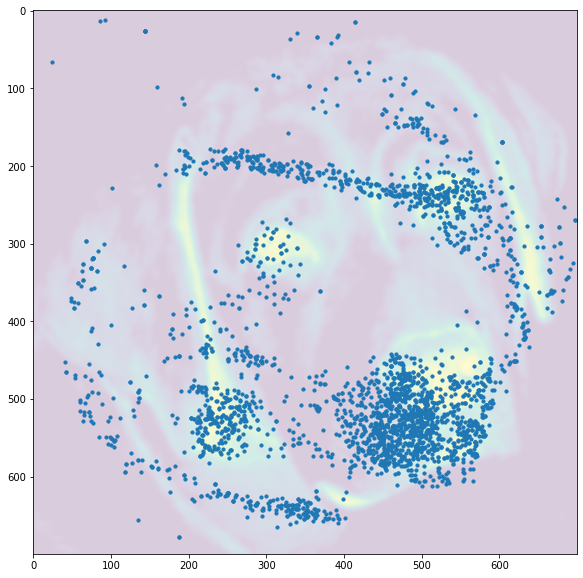

In [ ]:
## Couple of different strategies: use multiple runs from one sample vs. use a run from multiple samples
from tqdm import tqdm

d = 2  # dimensionality 
n_iter = 3000
k = 100
epsilon = 0.9

sampled_outputs = onp.zeros((1, n_iter, 2), dtype=density.dtype)
key = jax.random.PRNGKey(1)
key, subkey = jax.random.split(key)
init_sample = sample_from_image_density(1, density, subkey).flatten()

with tqdm(total=n_iter) as pbar:
  for i in range(n_iter):
      init_sample = hamiltonian_monte_carlo(init_sample, energy_fn, k, epsilon)
      sampled_outputs[0, i] = init_sample
      pbar.update(1)

import numpy as onp

onp.savez(
    f"/content/drive/MyDrive/CS699/homework #2/labrador_iter3000_k100_e09.npy",
    sample=sampled_outputs
)

fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sampled_outputs[:, :, 0], sampled_outputs[:, :, 1], s=10)
ax.imshow(density, alpha=0.2)
matplotlib.pyplot.show()

  0%|          | 3/10000 [00:16<15:34:03,  5.61s/it]

Metropolis- Hastings REJECT 0.08205982 1.1412871


  0%|          | 9/10000 [00:49<15:01:00,  5.41s/it]

Metropolis- Hastings REJECT 0.10961316 0.9131553


  0%|          | 20/10000 [01:48<14:52:44,  5.37s/it]

Metropolis- Hastings REJECT 0.19656508 1.2537794


  0%|          | 22/10000 [01:58<14:59:11,  5.41s/it]

Metropolis- Hastings REJECT 0.16387874 1.3234696


  0%|          | 25/10000 [02:15<15:01:08,  5.42s/it]

Metropolis- Hastings REJECT 0.25608593 1.184775


  0%|          | 29/10000 [02:36<14:51:17,  5.36s/it]

Metropolis- Hastings REJECT 0.1398506 0.756209


  0%|          | 30/10000 [02:41<14:53:01,  5.37s/it]

Metropolis- Hastings REJECT 0.1398506 2.1056738


  0%|          | 31/10000 [02:47<14:54:15,  5.38s/it]

Metropolis- Hastings REJECT 0.1398506 1.0377982


  0%|          | 37/10000 [03:19<14:38:59,  5.29s/it]

Metropolis- Hastings REJECT 0.25640824 0.89549124


  0%|          | 40/10000 [03:35<14:58:03,  5.41s/it]

Metropolis- Hastings REJECT 0.088264294 1.0212543


  0%|          | 43/10000 [03:51<14:50:23,  5.37s/it]

Metropolis- Hastings REJECT 0.46569908 3.1134706


  0%|          | 49/10000 [04:23<14:43:50,  5.33s/it]

Metropolis- Hastings REJECT 0.5372795 1.4673423


  0%|          | 50/10000 [04:28<14:47:12,  5.35s/it]

Metropolis- Hastings REJECT 0.5372795 1.8217745


  1%|          | 55/10000 [04:55<14:52:54,  5.39s/it]

Metropolis- Hastings REJECT 1.0014856 1.3451241


  1%|          | 57/10000 [05:06<14:45:47,  5.35s/it]

Metropolis- Hastings REJECT 0.93012583 1.2932717


  1%|          | 61/10000 [05:27<14:36:59,  5.29s/it]

Metropolis- Hastings REJECT 0.815563 1.7602421


  1%|          | 65/10000 [05:48<14:44:24,  5.34s/it]

Metropolis- Hastings REJECT 0.16091578 1.0771352


  1%|          | 69/10000 [06:09<14:43:50,  5.34s/it]

Metropolis- Hastings REJECT 0.43035886 3.1605794


  1%|          | 70/10000 [06:15<14:45:47,  5.35s/it]

Metropolis- Hastings REJECT 0.43035886 0.5764807


  1%|          | 78/10000 [06:57<14:49:04,  5.38s/it]

Metropolis- Hastings REJECT 0.55421126 1.33048


  1%|          | 85/10000 [07:35<14:35:23,  5.30s/it]

Metropolis- Hastings REJECT 0.44767883 1.163775


  1%|          | 86/10000 [07:40<14:32:20,  5.28s/it]

Metropolis- Hastings REJECT 0.44767883 1.3936989


  1%|          | 92/10000 [08:12<14:44:59,  5.36s/it]

Metropolis- Hastings REJECT 0.13862121 0.55033195


  1%|          | 95/10000 [08:28<14:45:04,  5.36s/it]

Metropolis- Hastings REJECT 0.15255998 1.2071291


  1%|          | 97/10000 [08:39<14:47:01,  5.37s/it]

Metropolis- Hastings REJECT 0.8161163 1.9473903


  1%|          | 109/10000 [09:43<14:36:53,  5.32s/it]

Metropolis- Hastings REJECT 0.15509705 0.9092356


  1%|          | 113/10000 [10:04<14:40:35,  5.34s/it]

Metropolis- Hastings REJECT 0.8200938 1.3912555


  1%|          | 115/10000 [10:15<14:35:54,  5.32s/it]

Metropolis- Hastings REJECT 1.1605941 1.3860435


  1%|          | 116/10000 [10:20<14:32:37,  5.30s/it]

Metropolis- Hastings REJECT 1.1605941 1.265538


  1%|          | 118/10000 [10:31<14:46:02,  5.38s/it]

Metropolis- Hastings REJECT 1.1861702 2.5634708


  1%|          | 119/10000 [10:36<14:39:54,  5.34s/it]

Metropolis- Hastings REJECT 1.1861702 1.9180812


  1%|▏         | 127/10000 [11:19<14:44:04,  5.37s/it]

Metropolis- Hastings REJECT 0.24458727 0.93806434


  1%|▏         | 131/10000 [11:40<14:37:54,  5.34s/it]

Metropolis- Hastings REJECT 0.12851046 0.79168546


  1%|▏         | 142/10000 [12:37<14:12:19,  5.19s/it]

Metropolis- Hastings REJECT 0.2143896 1.0787148


  1%|▏         | 147/10000 [13:03<14:11:47,  5.19s/it]

Metropolis- Hastings REJECT 0.20040222 3.135999


  1%|▏         | 148/10000 [13:08<14:19:54,  5.24s/it]

Metropolis- Hastings REJECT 0.20040222 1.9186432


  1%|▏         | 149/10000 [13:14<14:20:04,  5.24s/it]

Metropolis- Hastings REJECT 0.20040222 1.0404887


  2%|▏         | 151/10000 [13:24<14:31:19,  5.31s/it]

Metropolis- Hastings REJECT 0.7401259 1.6325088


  2%|▏         | 161/10000 [14:18<14:37:46,  5.35s/it]

Metropolis- Hastings REJECT 0.9814465 1.2713469


  2%|▏         | 163/10000 [14:28<14:13:22,  5.21s/it]

Metropolis- Hastings REJECT 0.89574397 1.4177854


  2%|▏         | 166/10000 [14:43<14:20:35,  5.25s/it]

Metropolis- Hastings REJECT 0.715135 2.5618234


  2%|▏         | 168/10000 [14:54<14:14:59,  5.22s/it]

Metropolis- Hastings REJECT 0.981521 1.1857433


  2%|▏         | 174/10000 [15:25<14:11:47,  5.20s/it]

Metropolis- Hastings REJECT 1.3802754 2.69167


  2%|▏         | 175/10000 [15:30<14:15:26,  5.22s/it]

Metropolis- Hastings REJECT 1.3802754 3.3074157


  2%|▏         | 193/10000 [17:03<14:02:14,  5.15s/it]

Metropolis- Hastings REJECT 2.2362761 3.5410829


  2%|▏         | 215/10000 [18:57<14:11:00,  5.22s/it]

Metropolis- Hastings REJECT 0.6779802 1.7997804


  2%|▏         | 219/10000 [19:19<14:28:12,  5.33s/it]

Metropolis- Hastings REJECT 0.25714642 0.5724511


  2%|▏         | 227/10000 [20:01<14:18:52,  5.27s/it]

Metropolis- Hastings REJECT 0.6314568 0.82751817


  2%|▏         | 228/10000 [20:06<14:24:26,  5.31s/it]

Metropolis- Hastings REJECT 0.6314568 2.255949


  2%|▏         | 232/10000 [20:27<14:16:42,  5.26s/it]

Metropolis- Hastings REJECT 0.18852964 1.0301584


  2%|▏         | 236/10000 [20:48<14:19:06,  5.28s/it]

Metropolis- Hastings REJECT 0.25432238 1.2643374


  2%|▏         | 248/10000 [21:51<14:16:08,  5.27s/it]

Metropolis- Hastings REJECT 0.2751549 0.40616816


  2%|▎         | 250/10000 [22:01<14:16:27,  5.27s/it]

Metropolis- Hastings REJECT 0.4511239 1.1641352


  3%|▎         | 252/10000 [22:12<14:17:59,  5.28s/it]

Metropolis- Hastings REJECT 0.28469414 2.9971056


  3%|▎         | 260/10000 [22:54<14:20:54,  5.30s/it]

Metropolis- Hastings REJECT 0.4643764 1.1088526


  3%|▎         | 269/10000 [23:42<14:29:06,  5.36s/it]

Metropolis- Hastings REJECT 0.3974929 0.7735727


  3%|▎         | 271/10000 [23:52<14:23:41,  5.33s/it]

Metropolis- Hastings REJECT 0.43427867 0.84151584


  3%|▎         | 273/10000 [24:03<14:09:29,  5.24s/it]

Metropolis- Hastings REJECT 0.17389251 0.7683748


  3%|▎         | 280/10000 [24:40<14:31:06,  5.38s/it]

Metropolis- Hastings REJECT 0.28359362 0.7569824


  3%|▎         | 282/10000 [24:51<14:21:56,  5.32s/it]

Metropolis- Hastings REJECT 0.35224274 1.2071278


  3%|▎         | 287/10000 [25:17<14:03:28,  5.21s/it]

Metropolis- Hastings REJECT 0.2928604 1.1621318


  3%|▎         | 289/10000 [25:27<14:09:55,  5.25s/it]

Metropolis- Hastings REJECT 0.1436933 0.9836925


  3%|▎         | 291/10000 [25:38<14:40:58,  5.44s/it]

Metropolis- Hastings REJECT 0.44532347 1.0762209


  3%|▎         | 309/10000 [27:13<14:12:13,  5.28s/it]

Metropolis- Hastings REJECT 0.39281866 0.78983825


  3%|▎         | 316/10000 [27:49<14:02:04,  5.22s/it]

Metropolis- Hastings REJECT 0.38441375 2.891054


  3%|▎         | 318/10000 [27:59<13:59:34,  5.20s/it]

Metropolis- Hastings REJECT 0.2803511 1.0734217


  3%|▎         | 336/10000 [29:34<14:13:11,  5.30s/it]

Metropolis- Hastings REJECT 0.19510582 1.2321709


  3%|▎         | 338/10000 [29:45<14:15:42,  5.31s/it]

Metropolis- Hastings REJECT 0.27266487 1.0843078


  3%|▎         | 339/10000 [29:50<14:09:50,  5.28s/it]

Metropolis- Hastings REJECT 0.27266487 0.5648503


  3%|▎         | 344/10000 [30:16<13:56:47,  5.20s/it]

Metropolis- Hastings REJECT 0.2143854 0.7115446


  4%|▎         | 350/10000 [30:47<13:57:10,  5.21s/it]

Metropolis- Hastings REJECT 0.1729235 0.8261971


  4%|▎         | 352/10000 [30:58<14:01:46,  5.23s/it]

Metropolis- Hastings REJECT 0.19158427 1.9126222


  4%|▎         | 355/10000 [31:13<14:01:07,  5.23s/it]

Metropolis- Hastings REJECT 0.21639343 0.9935287


  4%|▎         | 363/10000 [31:55<14:08:21,  5.28s/it]

Metropolis- Hastings REJECT 0.5550859 0.6953078


  4%|▎         | 367/10000 [32:17<14:25:09,  5.39s/it]

Metropolis- Hastings REJECT 0.23838603 0.9478394


  4%|▎         | 368/10000 [32:22<14:14:39,  5.32s/it]

Metropolis- Hastings REJECT 0.23838603 0.5585486


  4%|▎         | 374/10000 [32:54<14:10:58,  5.30s/it]

Metropolis- Hastings REJECT 0.1771039 1.8265579


  4%|▍         | 375/10000 [32:59<14:21:25,  5.37s/it]

Metropolis- Hastings REJECT 0.1771039 0.25517496


  4%|▍         | 376/10000 [33:05<14:16:39,  5.34s/it]

Metropolis- Hastings REJECT 0.1771039 2.1649687


  4%|▍         | 385/10000 [33:51<13:57:57,  5.23s/it]

Metropolis- Hastings REJECT 0.1727281 1.435964


  4%|▍         | 391/10000 [34:23<13:55:34,  5.22s/it]

Metropolis- Hastings REJECT 0.17271952 1.5953146


  4%|▍         | 394/10000 [34:39<14:04:30,  5.27s/it]

Metropolis- Hastings REJECT 0.14350717 1.4687945


  4%|▍         | 395/10000 [34:44<14:11:58,  5.32s/it]

Metropolis- Hastings REJECT 0.14350717 1.1905836


  4%|▍         | 399/10000 [35:05<14:04:03,  5.27s/it]

Metropolis- Hastings REJECT 0.6749443 1.3094448


  4%|▍         | 408/10000 [35:52<13:57:04,  5.24s/it]

Metropolis- Hastings REJECT 0.6998115 1.1260619


  4%|▍         | 429/10000 [37:40<13:35:17,  5.11s/it]

Metropolis- Hastings REJECT 0.2595805 1.2744449


  4%|▍         | 435/10000 [38:10<13:34:00,  5.11s/it]

Metropolis- Hastings REJECT 0.57631147 3.6315906


  4%|▍         | 437/10000 [38:20<13:42:43,  5.16s/it]

Metropolis- Hastings REJECT 0.8996753 1.1045563


  4%|▍         | 443/10000 [38:52<13:52:51,  5.23s/it]

Metropolis- Hastings REJECT 0.42509535 0.55906475


  4%|▍         | 445/10000 [39:02<14:01:41,  5.29s/it]

Metropolis- Hastings REJECT 0.12338061 1.5268226


  5%|▍         | 459/10000 [40:15<13:47:45,  5.21s/it]

Metropolis- Hastings REJECT 0.77726483 1.284242


  5%|▍         | 460/10000 [40:20<13:47:40,  5.21s/it]

Metropolis- Hastings REJECT 0.77726483 1.877293


  5%|▍         | 461/10000 [40:25<13:49:14,  5.22s/it]

Metropolis- Hastings REJECT 0.77726483 2.697359


  5%|▍         | 463/10000 [40:36<14:00:36,  5.29s/it]

Metropolis- Hastings REJECT 0.31520966 1.3435602


  5%|▍         | 464/10000 [40:41<13:57:48,  5.27s/it]

Metropolis- Hastings REJECT 0.31520966 1.1971881


  5%|▍         | 483/10000 [42:18<13:36:26,  5.15s/it]

Metropolis- Hastings REJECT 0.47596994 1.7223204


  5%|▍         | 484/10000 [42:23<13:33:13,  5.13s/it]

Metropolis- Hastings REJECT 0.47596994 1.0083778


  5%|▍         | 485/10000 [42:29<13:38:30,  5.16s/it]

Metropolis- Hastings REJECT 0.47596994 0.78191483


  5%|▍         | 486/10000 [42:34<13:40:47,  5.18s/it]

Metropolis- Hastings REJECT 0.47596994 1.1739796


  5%|▍         | 487/10000 [42:39<13:36:13,  5.15s/it]

Metropolis- Hastings REJECT 0.47596994 2.237818


  5%|▍         | 495/10000 [43:20<13:22:34,  5.07s/it]

Metropolis- Hastings REJECT 1.3749441 1.5093559


  5%|▌         | 503/10000 [44:01<13:40:11,  5.18s/it]

Metropolis- Hastings REJECT 0.19438279 0.81828207


  5%|▌         | 504/10000 [44:06<13:32:32,  5.13s/it]

Metropolis- Hastings REJECT 0.19438279 1.2315841


  5%|▌         | 506/10000 [44:16<13:46:41,  5.22s/it]

Metropolis- Hastings REJECT 0.102658674 1.0423189


  5%|▌         | 507/10000 [44:21<13:49:51,  5.25s/it]

Metropolis- Hastings REJECT 0.102658674 0.25929603


  5%|▌         | 508/10000 [44:27<13:47:49,  5.23s/it]

Metropolis- Hastings REJECT 0.102658674 1.4959738


  5%|▌         | 510/10000 [44:37<13:36:52,  5.16s/it]

Metropolis- Hastings REJECT 0.08456486 0.22153202


  5%|▌         | 512/10000 [44:47<13:31:59,  5.13s/it]

Metropolis- Hastings REJECT 0.059386525 1.2231055


  5%|▌         | 518/10000 [45:18<13:27:55,  5.11s/it]

Metropolis- Hastings REJECT 0.87993944 1.0938444


  5%|▌         | 549/10000 [47:57<13:32:26,  5.16s/it]

Metropolis- Hastings REJECT 0.16987658 0.51347077


  6%|▌         | 552/10000 [48:13<13:51:25,  5.28s/it]

Metropolis- Hastings REJECT 0.10790247 1.1950693


  6%|▌         | 561/10000 [49:00<13:31:19,  5.16s/it]

Metropolis- Hastings REJECT 0.44997936 1.366809


  6%|▌         | 563/10000 [49:10<13:31:36,  5.16s/it]

Metropolis- Hastings REJECT 1.2314354 2.800741


  6%|▌         | 569/10000 [49:40<13:13:40,  5.05s/it]

Metropolis- Hastings REJECT 0.32197943 0.46661526


  6%|▌         | 571/10000 [49:50<13:14:53,  5.06s/it]

Metropolis- Hastings REJECT 0.41024438 0.96428597


  6%|▌         | 597/10000 [52:03<13:17:02,  5.09s/it]

Metropolis- Hastings REJECT 0.18309098 1.182539


  6%|▌         | 598/10000 [52:08<13:29:02,  5.16s/it]

Metropolis- Hastings REJECT 0.18309098 0.90813404


  6%|▌         | 602/10000 [52:29<13:32:59,  5.19s/it]

Metropolis- Hastings REJECT 0.53305036 1.1345927


  6%|▌         | 603/10000 [52:34<13:28:22,  5.16s/it]

Metropolis- Hastings REJECT 0.53305036 0.8556963


  6%|▌         | 607/10000 [52:54<13:23:17,  5.13s/it]

Metropolis- Hastings REJECT 0.965715 1.7685165


  6%|▌         | 620/10000 [54:00<13:27:10,  5.16s/it]

Metropolis- Hastings REJECT 0.25450352 1.1354508


  6%|▌         | 622/10000 [54:11<13:26:59,  5.16s/it]

Metropolis- Hastings REJECT 0.31219336 0.6483235


  7%|▋         | 653/10000 [56:49<13:11:53,  5.08s/it]

Metropolis- Hastings REJECT 0.120618716 0.3472244


  7%|▋         | 655/10000 [56:59<13:15:59,  5.11s/it]

Metropolis- Hastings REJECT 0.20850465 1.0219027


  7%|▋         | 662/10000 [57:35<13:20:11,  5.14s/it]

Metropolis- Hastings REJECT 0.4247586 1.1928196


  7%|▋         | 669/10000 [58:11<13:09:28,  5.08s/it]

Metropolis- Hastings REJECT 0.30480936 1.3383125


  7%|▋         | 674/10000 [58:36<13:07:57,  5.07s/it]

Metropolis- Hastings REJECT 2.6343966 3.5795057


  7%|▋         | 678/10000 [58:56<13:09:02,  5.08s/it]

Metropolis- Hastings REJECT 0.18484719 2.5877483


  7%|▋         | 685/10000 [59:32<13:06:28,  5.07s/it]

Metropolis- Hastings REJECT 2.3901272 2.996958


  7%|▋         | 699/10000 [1:00:43<13:17:47,  5.15s/it]

Metropolis- Hastings REJECT 3.5099854 3.524373


  7%|▋         | 702/10000 [1:00:58<13:25:28,  5.20s/it]

Metropolis- Hastings REJECT 3.516597 inf


  7%|▋         | 705/10000 [1:01:14<13:32:39,  5.25s/it]

Metropolis- Hastings REJECT 3.5160215 inf


  7%|▋         | 707/10000 [1:01:24<13:16:02,  5.14s/it]

Metropolis- Hastings REJECT 3.5398314 inf


  7%|▋         | 708/10000 [1:01:29<13:15:58,  5.14s/it]

Metropolis- Hastings REJECT 3.5398314 inf


  7%|▋         | 710/10000 [1:01:39<13:23:14,  5.19s/it]

Metropolis- Hastings REJECT 2.8098493 inf


  7%|▋         | 715/10000 [1:02:05<13:14:48,  5.14s/it]

Metropolis- Hastings REJECT 0.868945 1.7630073


  7%|▋         | 723/10000 [1:02:46<13:14:29,  5.14s/it]

Metropolis- Hastings REJECT 1.1762693 1.6815636


  7%|▋         | 731/10000 [1:03:27<13:18:23,  5.17s/it]

Metropolis- Hastings REJECT 0.9138299 1.5426984


  7%|▋         | 737/10000 [1:03:58<13:16:15,  5.16s/it]

Metropolis- Hastings REJECT 0.8296983 1.3272533


  7%|▋         | 738/10000 [1:04:03<13:17:16,  5.16s/it]

Metropolis- Hastings REJECT 0.8296983 1.4230175


  7%|▋         | 743/10000 [1:04:29<13:07:19,  5.10s/it]

Metropolis- Hastings REJECT 3.0764918 3.5368717


  7%|▋         | 747/10000 [1:04:49<13:14:55,  5.15s/it]

Metropolis- Hastings REJECT 1.1119258 1.1531491


  8%|▊         | 753/10000 [1:05:20<13:02:05,  5.07s/it]

Metropolis- Hastings REJECT 1.3712832 2.318227


  8%|▊         | 756/10000 [1:05:35<13:17:49,  5.18s/it]

Metropolis- Hastings REJECT 0.17554785 0.23419473


  8%|▊         | 761/10000 [1:06:01<13:17:22,  5.18s/it]

Metropolis- Hastings REJECT 1.1108979 1.881764


  8%|▊         | 766/10000 [1:06:27<13:10:43,  5.14s/it]

Metropolis- Hastings REJECT 1.5378618 3.540924


  8%|▊         | 772/10000 [1:06:57<13:01:18,  5.08s/it]

Metropolis- Hastings REJECT 0.31728724 1.1703485


  8%|▊         | 776/10000 [1:07:18<13:07:12,  5.12s/it]

Metropolis- Hastings REJECT 0.21269132 0.9237026


  8%|▊         | 778/10000 [1:07:28<13:02:23,  5.09s/it]

Metropolis- Hastings REJECT 0.42874599 2.489314


  8%|▊         | 784/10000 [1:07:58<12:47:27,  5.00s/it]

Metropolis- Hastings REJECT 0.2991493 1.067001


  8%|▊         | 800/10000 [1:09:20<13:11:40,  5.16s/it]

Metropolis- Hastings REJECT 0.24857771 0.64579326


  8%|▊         | 803/10000 [1:09:35<13:02:26,  5.10s/it]

Metropolis- Hastings REJECT 0.197692 1.6427398


  8%|▊         | 811/10000 [1:10:16<12:51:45,  5.04s/it]

Metropolis- Hastings REJECT 0.22995709 0.5886462


  8%|▊         | 816/10000 [1:10:41<13:09:15,  5.16s/it]

Metropolis- Hastings REJECT 0.19587259 0.50082934


  8%|▊         | 819/10000 [1:10:57<13:06:22,  5.14s/it]

Metropolis- Hastings REJECT 0.13656963 1.0048386


  8%|▊         | 836/10000 [1:12:23<12:57:29,  5.09s/it]

Metropolis- Hastings REJECT 0.37119508 1.4792569


  8%|▊         | 842/10000 [1:12:53<12:48:35,  5.04s/it]

Metropolis- Hastings REJECT 0.18315606 1.1967187


  9%|▊         | 855/10000 [1:13:59<13:05:55,  5.16s/it]

Metropolis- Hastings REJECT 0.245825 0.46731216


  9%|▊         | 856/10000 [1:14:04<13:08:02,  5.17s/it]

Metropolis- Hastings REJECT 0.245825 0.30971488


  9%|▊         | 864/10000 [1:14:45<13:02:16,  5.14s/it]

Metropolis- Hastings REJECT 0.46694285 0.7347154


  9%|▊         | 867/10000 [1:15:01<12:59:13,  5.12s/it]

Metropolis- Hastings REJECT 0.17202318 1.2938013


  9%|▊         | 868/10000 [1:15:06<13:03:18,  5.15s/it]

Metropolis- Hastings REJECT 0.17202318 2.0355256


  9%|▊         | 869/10000 [1:15:11<13:01:39,  5.14s/it]

Metropolis- Hastings REJECT 0.17202318 0.20008406


  9%|▊         | 871/10000 [1:15:21<13:05:46,  5.16s/it]

Metropolis- Hastings REJECT 0.2685039 0.87785965


  9%|▉         | 879/10000 [1:16:03<13:11:45,  5.21s/it]

Metropolis- Hastings REJECT 1.3672999 1.7989566


  9%|▉         | 881/10000 [1:16:13<13:15:25,  5.23s/it]

Metropolis- Hastings REJECT 1.3067875 2.8121285


  9%|▉         | 883/10000 [1:16:23<13:13:04,  5.22s/it]

Metropolis- Hastings REJECT 1.4373627 2.3581772


  9%|▉         | 891/10000 [1:17:05<13:01:32,  5.15s/it]

Metropolis- Hastings REJECT 0.2246955 2.9467816


  9%|▉         | 897/10000 [1:17:36<13:01:30,  5.15s/it]

Metropolis- Hastings REJECT 0.4450487 1.2251471


  9%|▉         | 899/10000 [1:17:46<13:01:02,  5.15s/it]

Metropolis- Hastings REJECT 0.16513124 0.21090537


  9%|▉         | 903/10000 [1:18:06<13:01:38,  5.16s/it]

Metropolis- Hastings REJECT 0.4214271 0.73065823


  9%|▉         | 916/10000 [1:19:13<13:01:34,  5.16s/it]

Metropolis- Hastings REJECT 0.28739473 1.4998778


  9%|▉         | 929/10000 [1:20:19<12:55:07,  5.13s/it]

Metropolis- Hastings REJECT 0.21751033 1.4135382


  9%|▉         | 934/10000 [1:20:45<13:04:13,  5.19s/it]

Metropolis- Hastings REJECT 0.4515072 0.91787815


  9%|▉         | 942/10000 [1:21:25<12:58:50,  5.16s/it]

Metropolis- Hastings REJECT 0.6010088 0.8064297


  9%|▉         | 943/10000 [1:21:31<12:57:01,  5.15s/it]

Metropolis- Hastings REJECT 0.6010088 1.7246664


 10%|▉         | 950/10000 [1:22:06<13:00:36,  5.18s/it]

Metropolis- Hastings REJECT 0.27974775 1.4511939


 10%|▉         | 954/10000 [1:22:27<13:03:01,  5.19s/it]

Metropolis- Hastings REJECT 0.20912291 1.4231005


 10%|▉         | 956/10000 [1:22:38<13:05:45,  5.21s/it]

Metropolis- Hastings REJECT 0.266826 1.2209169


 10%|▉         | 960/10000 [1:22:58<12:52:13,  5.13s/it]

Metropolis- Hastings REJECT 0.20818913 3.609563


 10%|▉         | 977/10000 [1:24:25<13:00:26,  5.19s/it]

Metropolis- Hastings REJECT 0.20346864 1.1148467


 10%|▉         | 978/10000 [1:24:31<13:09:29,  5.25s/it]

Metropolis- Hastings REJECT 0.20346864 1.0168834


 10%|▉         | 982/10000 [1:24:52<13:01:05,  5.20s/it]

Metropolis- Hastings REJECT 0.092683785 2.3271852


 10%|▉         | 983/10000 [1:24:57<12:59:07,  5.18s/it]

Metropolis- Hastings REJECT 0.092683785 1.0450306


 10%|▉         | 987/10000 [1:25:17<12:57:21,  5.17s/it]

Metropolis- Hastings REJECT 0.06534094 0.2916057


 10%|▉         | 990/10000 [1:25:33<12:54:51,  5.16s/it]

Metropolis- Hastings REJECT 0.17926289 0.37329903


 10%|▉         | 993/10000 [1:25:48<13:06:11,  5.24s/it]

Metropolis- Hastings REJECT 0.40121895 0.5590318


 10%|█         | 1001/10000 [1:26:30<12:58:42,  5.19s/it]

Metropolis- Hastings REJECT 0.23879121 0.52823013


 10%|█         | 1012/10000 [1:27:25<12:37:08,  5.05s/it]

Metropolis- Hastings REJECT 0.05704523 0.16760452


 10%|█         | 1018/10000 [1:27:56<12:42:41,  5.09s/it]

Metropolis- Hastings REJECT 1.0286325 1.9087944


 10%|█         | 1023/10000 [1:28:22<13:04:08,  5.24s/it]

Metropolis- Hastings REJECT 0.9468615 1.198721


 10%|█         | 1029/10000 [1:28:53<13:07:58,  5.27s/it]

Metropolis- Hastings REJECT 1.0171233 1.2427108


 10%|█         | 1033/10000 [1:29:13<12:48:26,  5.14s/it]

Metropolis- Hastings REJECT 0.12627336 0.15537788


 10%|█         | 1042/10000 [1:29:59<12:46:53,  5.14s/it]

Metropolis- Hastings REJECT 0.2562716 0.96392167


 10%|█         | 1044/10000 [1:30:10<12:52:49,  5.18s/it]

Metropolis- Hastings REJECT 0.22369055 0.583918


 10%|█         | 1048/10000 [1:30:30<12:55:42,  5.20s/it]

Metropolis- Hastings REJECT 0.32117426 1.3378065


 11%|█         | 1054/10000 [1:31:01<12:41:27,  5.11s/it]

Metropolis- Hastings REJECT 0.74494433 1.2206063


 11%|█         | 1059/10000 [1:31:27<12:48:01,  5.15s/it]

Metropolis- Hastings REJECT 1.1941934 1.4256831


 11%|█         | 1066/10000 [1:32:03<12:41:57,  5.12s/it]

Metropolis- Hastings REJECT 0.86503977 1.0579908


 11%|█         | 1081/10000 [1:33:19<12:46:07,  5.15s/it]

Metropolis- Hastings REJECT 0.17535052 1.1529394


 11%|█         | 1089/10000 [1:34:00<12:45:05,  5.15s/it]

Metropolis- Hastings REJECT 0.9751937 1.9059304


 11%|█         | 1097/10000 [1:34:41<12:42:30,  5.14s/it]

Metropolis- Hastings REJECT 0.15207133 1.4486151


 11%|█         | 1098/10000 [1:34:47<12:50:57,  5.20s/it]

Metropolis- Hastings REJECT 0.15207133 0.40229508


 11%|█         | 1099/10000 [1:34:52<12:56:02,  5.23s/it]

Metropolis- Hastings REJECT 0.15207133 0.23615888


 11%|█         | 1100/10000 [1:34:57<12:51:40,  5.20s/it]

Metropolis- Hastings REJECT 0.15207133 0.46524942


 11%|█         | 1101/10000 [1:35:02<12:48:13,  5.18s/it]

Metropolis- Hastings REJECT 0.15207133 2.063618


 11%|█         | 1102/10000 [1:35:08<12:50:46,  5.20s/it]

Metropolis- Hastings REJECT 0.15207133 1.6255565


 11%|█         | 1105/10000 [1:35:23<12:46:03,  5.17s/it]

Metropolis- Hastings REJECT 0.44459534 1.1732445


 11%|█         | 1108/10000 [1:35:38<12:39:02,  5.12s/it]

Metropolis- Hastings REJECT 0.27681273 1.019328


 11%|█         | 1109/10000 [1:35:44<12:39:18,  5.12s/it]

Metropolis- Hastings REJECT 0.27681273 1.0422063


 11%|█         | 1111/10000 [1:35:54<12:42:57,  5.15s/it]

Metropolis- Hastings REJECT 0.17887962 2.95195


 11%|█         | 1113/10000 [1:36:04<12:45:19,  5.17s/it]

Metropolis- Hastings REJECT 0.12743932 0.36548465


 11%|█         | 1116/10000 [1:36:20<12:40:31,  5.14s/it]

Metropolis- Hastings REJECT 0.18464342 1.5287325


 11%|█         | 1118/10000 [1:36:30<12:46:11,  5.18s/it]

Metropolis- Hastings REJECT 0.11905614 0.15686616


 11%|█▏        | 1131/10000 [1:37:37<12:38:12,  5.13s/it]

Metropolis- Hastings REJECT 0.7143673 2.384758


 11%|█▏        | 1132/10000 [1:37:42<12:51:52,  5.22s/it]

Metropolis- Hastings REJECT 0.7143673 1.6872135


 11%|█▏        | 1135/10000 [1:37:57<12:38:14,  5.13s/it]

Metropolis- Hastings REJECT 0.41684663 1.4579091


 11%|█▏        | 1144/10000 [1:38:43<12:27:03,  5.06s/it]

Metropolis- Hastings REJECT 0.64648557 0.7693087


 11%|█▏        | 1146/10000 [1:38:54<12:33:11,  5.10s/it]

Metropolis- Hastings REJECT 1.4959233 3.6212459


 12%|█▏        | 1156/10000 [1:39:45<12:36:40,  5.13s/it]

Metropolis- Hastings REJECT 0.087025724 0.6862045


 12%|█▏        | 1162/10000 [1:40:16<12:42:23,  5.18s/it]

Metropolis- Hastings REJECT 0.24406423 0.9448203


 12%|█▏        | 1180/10000 [1:41:48<12:35:09,  5.14s/it]

Metropolis- Hastings REJECT 0.76849836 1.0618978


 12%|█▏        | 1189/10000 [1:42:35<12:30:38,  5.11s/it]

Metropolis- Hastings REJECT 0.6016593 1.2755393


 12%|█▏        | 1200/10000 [1:43:30<12:27:10,  5.09s/it]

Metropolis- Hastings REJECT 0.8866695 1.5175099


 12%|█▏        | 1201/10000 [1:43:35<12:26:11,  5.09s/it]

Metropolis- Hastings REJECT 0.8866695 1.3519045


 12%|█▏        | 1204/10000 [1:43:51<12:31:17,  5.12s/it]

Metropolis- Hastings REJECT 1.0949688 2.3352072


 12%|█▏        | 1210/10000 [1:44:21<12:24:22,  5.08s/it]

Metropolis- Hastings REJECT 3.5163076 inf


 12%|█▏        | 1226/10000 [1:45:42<12:17:21,  5.04s/it]

Metropolis- Hastings REJECT 0.71754223 1.2904235


 12%|█▏        | 1227/10000 [1:45:47<12:21:47,  5.07s/it]

Metropolis- Hastings REJECT 0.71754223 1.5840114


 12%|█▏        | 1228/10000 [1:45:52<12:25:07,  5.10s/it]

Metropolis- Hastings REJECT 0.71754223 3.2717414


 12%|█▏        | 1229/10000 [1:45:57<12:29:57,  5.13s/it]

Metropolis- Hastings REJECT 0.71754223 1.0891166


 12%|█▏        | 1231/10000 [1:46:07<12:26:40,  5.11s/it]

Metropolis- Hastings REJECT 0.7405535 1.551641


 12%|█▏        | 1232/10000 [1:46:13<12:32:22,  5.15s/it]

Metropolis- Hastings REJECT 0.7405535 1.3763294


 12%|█▏        | 1233/10000 [1:46:18<12:31:36,  5.14s/it]

Metropolis- Hastings REJECT 0.7405535 1.1302438


 12%|█▏        | 1237/10000 [1:46:38<12:25:33,  5.10s/it]

Metropolis- Hastings REJECT 1.1231332 1.3110112


 12%|█▏        | 1243/10000 [1:47:09<12:24:57,  5.10s/it]

Metropolis- Hastings REJECT 1.6218615 inf


 12%|█▏        | 1248/10000 [1:47:34<12:27:01,  5.12s/it]

Metropolis- Hastings REJECT 1.2392292 2.0732095


 12%|█▎        | 1250/10000 [1:47:45<12:28:49,  5.13s/it]

Metropolis- Hastings REJECT 1.4322026 1.7171197


 13%|█▎        | 1277/10000 [1:50:00<12:24:12,  5.12s/it]

Metropolis- Hastings REJECT 0.1574295 1.7768524


 13%|█▎        | 1282/10000 [1:50:26<12:18:50,  5.08s/it]

Metropolis- Hastings REJECT 0.06262582 2.1892583


 13%|█▎        | 1286/10000 [1:50:46<12:21:05,  5.10s/it]

Metropolis- Hastings REJECT 0.2081373 0.5506599


 13%|█▎        | 1292/10000 [1:51:17<12:23:08,  5.12s/it]

Metropolis- Hastings REJECT 0.17200024 1.3939419


 13%|█▎        | 1293/10000 [1:51:22<12:25:29,  5.14s/it]

Metropolis- Hastings REJECT 0.17200024 1.7964672


 13%|█▎        | 1294/10000 [1:51:27<12:35:27,  5.21s/it]

Metropolis- Hastings REJECT 0.17200024 0.27178422


 13%|█▎        | 1300/10000 [1:51:57<12:21:02,  5.11s/it]

Metropolis- Hastings REJECT 1.7327868 3.0290627


 13%|█▎        | 1309/10000 [1:52:43<12:16:59,  5.09s/it]

Metropolis- Hastings REJECT 1.4091437 1.5284382


 13%|█▎        | 1312/10000 [1:52:58<12:10:00,  5.04s/it]

Metropolis- Hastings REJECT 1.408352 1.9778601


 13%|█▎        | 1314/10000 [1:53:08<12:12:05,  5.06s/it]

Metropolis- Hastings REJECT 1.4237027 1.6702065


 13%|█▎        | 1315/10000 [1:53:14<12:16:07,  5.09s/it]

Metropolis- Hastings REJECT 1.4237027 2.980181


 13%|█▎        | 1317/10000 [1:53:24<12:12:46,  5.06s/it]

Metropolis- Hastings REJECT 1.3078558 2.0092642


 13%|█▎        | 1318/10000 [1:53:29<12:16:06,  5.09s/it]

Metropolis- Hastings REJECT 1.3078558 1.7274462


 13%|█▎        | 1320/10000 [1:53:39<12:16:21,  5.09s/it]

Metropolis- Hastings REJECT 1.0316223 1.6649846


 13%|█▎        | 1321/10000 [1:53:44<12:22:24,  5.13s/it]

Metropolis- Hastings REJECT 1.0316223 3.5651245


 13%|█▎        | 1327/10000 [1:54:15<12:11:05,  5.06s/it]

Metropolis- Hastings REJECT 0.48292375 1.1275362


 13%|█▎        | 1335/10000 [1:54:55<12:03:27,  5.01s/it]

Metropolis- Hastings REJECT 1.0820065 1.2121545


 13%|█▎        | 1343/10000 [1:55:35<12:17:45,  5.11s/it]

Metropolis- Hastings REJECT 0.30318388 1.5112091


 14%|█▎        | 1353/10000 [1:56:27<12:22:19,  5.15s/it]

Metropolis- Hastings REJECT 0.12819107 0.17592616


 14%|█▎        | 1357/10000 [1:56:47<12:19:40,  5.13s/it]

Metropolis- Hastings REJECT 0.16484843 0.80614537


 14%|█▎        | 1360/10000 [1:57:03<12:22:01,  5.15s/it]

Metropolis- Hastings REJECT 0.07178991 1.1119622


 14%|█▎        | 1361/10000 [1:57:08<12:23:12,  5.16s/it]

Metropolis- Hastings REJECT 0.07178991 1.4397031


 14%|█▍        | 1376/10000 [1:58:24<12:12:49,  5.10s/it]

Metropolis- Hastings REJECT 0.3266836 1.5583888


 14%|█▍        | 1389/10000 [1:59:31<12:13:34,  5.11s/it]

Metropolis- Hastings REJECT 0.500973 1.5585424


 14%|█▍        | 1398/10000 [2:00:17<12:12:39,  5.11s/it]

Metropolis- Hastings REJECT 0.16494109 0.5836188


 14%|█▍        | 1406/10000 [2:00:57<12:15:54,  5.14s/it]

Metropolis- Hastings REJECT 0.34129727 0.37368298


 14%|█▍        | 1407/10000 [2:01:03<12:16:39,  5.14s/it]

Metropolis- Hastings REJECT 0.34129727 0.53760785


 14%|█▍        | 1410/10000 [2:01:18<12:12:27,  5.12s/it]

Metropolis- Hastings REJECT 0.4597687 1.519811


 14%|█▍        | 1412/10000 [2:01:28<12:08:17,  5.09s/it]

Metropolis- Hastings REJECT 0.0821442 2.4150333


 14%|█▍        | 1416/10000 [2:01:48<12:15:30,  5.14s/it]

Metropolis- Hastings REJECT 0.15689014 0.41556084


 14%|█▍        | 1419/10000 [2:02:04<12:07:18,  5.09s/it]

Metropolis- Hastings REJECT 0.7542411 1.3057795


 14%|█▍        | 1421/10000 [2:02:14<12:07:03,  5.08s/it]

Metropolis- Hastings REJECT 0.15366735 0.6323076


 14%|█▍        | 1422/10000 [2:02:19<12:12:29,  5.12s/it]

Metropolis- Hastings REJECT 0.15366735 0.28442028


 14%|█▍        | 1427/10000 [2:02:45<12:28:05,  5.24s/it]

Metropolis- Hastings REJECT 0.40827382 1.4513882


 14%|█▍        | 1428/10000 [2:02:50<12:34:30,  5.28s/it]

Metropolis- Hastings REJECT 0.40827382 1.4308002


 14%|█▍        | 1433/10000 [2:03:16<12:05:21,  5.08s/it]

Metropolis- Hastings REJECT 0.18602975 2.1157458


 14%|█▍        | 1434/10000 [2:03:21<12:10:24,  5.12s/it]

Metropolis- Hastings REJECT 0.18602975 1.4882152


 14%|█▍        | 1447/10000 [2:04:28<12:04:53,  5.09s/it]

Metropolis- Hastings REJECT 2.0959365 2.1688025


 15%|█▍        | 1453/10000 [2:04:58<12:09:06,  5.12s/it]

Metropolis- Hastings REJECT 0.64487875 1.5004675


 15%|█▍        | 1455/10000 [2:05:08<12:14:07,  5.15s/it]

Metropolis- Hastings REJECT 0.101422414 0.732961


 15%|█▍        | 1458/10000 [2:05:24<12:34:19,  5.30s/it]

Metropolis- Hastings REJECT 0.064698115 0.2974627


 15%|█▍        | 1459/10000 [2:05:30<12:28:24,  5.26s/it]

Metropolis- Hastings REJECT 0.064698115 0.65340805


 15%|█▍        | 1473/10000 [2:06:42<12:12:19,  5.15s/it]

Metropolis- Hastings REJECT 0.6963286 3.5891383


 15%|█▍        | 1474/10000 [2:06:47<12:18:00,  5.19s/it]

Metropolis- Hastings REJECT 0.6963286 0.9714042


 15%|█▍        | 1478/10000 [2:07:07<12:08:56,  5.13s/it]

Metropolis- Hastings REJECT 0.1298829 0.7757577


 15%|█▍        | 1484/10000 [2:07:38<12:09:53,  5.14s/it]

Metropolis- Hastings REJECT 0.4626919 1.9664453


 15%|█▍        | 1495/10000 [2:08:36<12:19:13,  5.22s/it]

Metropolis- Hastings REJECT 0.12478478 0.7054113


 15%|█▍        | 1496/10000 [2:08:41<12:14:49,  5.18s/it]

Metropolis- Hastings REJECT 0.12478478 0.43130505


 15%|█▌        | 1502/10000 [2:09:12<12:24:31,  5.26s/it]

Metropolis- Hastings REJECT 1.2679 2.4267557


 15%|█▌        | 1503/10000 [2:09:17<12:22:59,  5.25s/it]

Metropolis- Hastings REJECT 1.2679 1.5343611


 15%|█▌        | 1504/10000 [2:09:23<12:25:45,  5.27s/it]

Metropolis- Hastings REJECT 1.2679 2.1411705


 15%|█▌        | 1505/10000 [2:09:28<12:34:43,  5.33s/it]

Metropolis- Hastings REJECT 1.2679 1.6633201


 15%|█▌        | 1513/10000 [2:10:10<12:33:23,  5.33s/it]

Metropolis- Hastings REJECT 0.23144273 0.4060211


 15%|█▌        | 1522/10000 [2:10:57<12:13:49,  5.19s/it]

Metropolis- Hastings REJECT 0.34969658 1.7219845


 15%|█▌        | 1528/10000 [2:11:28<12:22:23,  5.26s/it]

Metropolis- Hastings REJECT 0.5478096 0.89920866


 15%|█▌        | 1532/10000 [2:11:50<12:23:13,  5.27s/it]

Metropolis- Hastings REJECT 1.0568635 1.4364725


 15%|█▌        | 1536/10000 [2:12:10<12:19:06,  5.24s/it]

Metropolis- Hastings REJECT 0.959871 1.2448982


 15%|█▌        | 1539/10000 [2:12:26<12:18:54,  5.24s/it]

Metropolis- Hastings REJECT 0.6567384 1.1188818


 15%|█▌        | 1540/10000 [2:12:31<12:21:42,  5.26s/it]

Metropolis- Hastings REJECT 0.6567384 0.97105956


 15%|█▌        | 1541/10000 [2:12:37<12:14:40,  5.21s/it]

Metropolis- Hastings REJECT 0.6567384 1.0846032


 15%|█▌        | 1546/10000 [2:13:02<12:05:30,  5.15s/it]

Metropolis- Hastings REJECT 1.0325522 1.1742142


 16%|█▌        | 1551/10000 [2:13:28<12:07:31,  5.17s/it]

Metropolis- Hastings REJECT 1.2859633 3.2357404


 16%|█▌        | 1557/10000 [2:13:59<12:00:08,  5.12s/it]

Metropolis- Hastings REJECT 0.4996227 1.1129892


 16%|█▌        | 1558/10000 [2:14:04<12:00:36,  5.12s/it]

Metropolis- Hastings REJECT 0.4996227 3.236798


 16%|█▌        | 1560/10000 [2:14:14<12:09:39,  5.19s/it]

Metropolis- Hastings REJECT 0.34858376 1.944479


 16%|█▌        | 1564/10000 [2:14:35<12:07:10,  5.17s/it]

Metropolis- Hastings REJECT 1.921673 2.0754333


 16%|█▌        | 1580/10000 [2:15:58<12:13:17,  5.23s/it]

Metropolis- Hastings REJECT 0.14742178 0.8653709


 16%|█▌        | 1581/10000 [2:16:03<12:19:55,  5.27s/it]

Metropolis- Hastings REJECT 0.14742178 0.86340547


 16%|█▌        | 1582/10000 [2:16:09<12:28:23,  5.33s/it]

Metropolis- Hastings REJECT 0.14742178 1.1697963


 16%|█▌        | 1584/10000 [2:16:19<12:31:12,  5.36s/it]

Metropolis- Hastings REJECT 0.47785008 2.2307355


 16%|█▌        | 1587/10000 [2:16:36<12:48:59,  5.48s/it]

Metropolis- Hastings REJECT 0.15964015 1.053599


 16%|█▌        | 1596/10000 [2:17:23<12:20:25,  5.29s/it]

Metropolis- Hastings REJECT 0.7668022 1.9540702


 16%|█▌        | 1612/10000 [2:18:46<11:59:14,  5.14s/it]

Metropolis- Hastings REJECT 0.11106845 0.9019037


 16%|█▌        | 1613/10000 [2:18:51<12:03:36,  5.18s/it]

Metropolis- Hastings REJECT 0.11106845 0.20580728


 16%|█▌        | 1614/10000 [2:18:56<12:05:38,  5.19s/it]

Metropolis- Hastings REJECT 0.11106845 0.74186575


 16%|█▌        | 1617/10000 [2:19:12<12:09:10,  5.22s/it]

Metropolis- Hastings REJECT 0.004421937 0.7949522


 16%|█▋        | 1633/10000 [2:20:36<12:17:38,  5.29s/it]

Metropolis- Hastings REJECT 0.30561206 0.76115745


 16%|█▋        | 1636/10000 [2:20:52<11:57:06,  5.14s/it]

Metropolis- Hastings REJECT 0.5173636 1.520992


 16%|█▋        | 1637/10000 [2:20:57<11:56:10,  5.14s/it]

Metropolis- Hastings REJECT 0.5173636 1.3084183


 16%|█▋        | 1642/10000 [2:21:23<12:06:11,  5.21s/it]

Metropolis- Hastings REJECT 0.23143665 0.44651663


 16%|█▋        | 1646/10000 [2:21:44<12:11:57,  5.26s/it]

Metropolis- Hastings REJECT 1.0396852 1.5960493


 17%|█▋        | 1658/10000 [2:22:46<11:57:46,  5.16s/it]

Metropolis- Hastings REJECT 1.3142605 2.3853388


 17%|█▋        | 1666/10000 [2:23:28<12:16:45,  5.30s/it]

Metropolis- Hastings REJECT 0.400424 1.3859452


 17%|█▋        | 1667/10000 [2:23:33<12:24:36,  5.36s/it]

Metropolis- Hastings REJECT 0.400424 0.42577115


 17%|█▋        | 1671/10000 [2:23:54<12:04:53,  5.22s/it]

Metropolis- Hastings REJECT 0.3364647 0.6943034


 17%|█▋        | 1677/10000 [2:24:25<12:04:12,  5.22s/it]

Metropolis- Hastings REJECT 0.15516053 1.2247204


 17%|█▋        | 1682/10000 [2:24:51<11:57:23,  5.17s/it]

Metropolis- Hastings REJECT 0.059742186 3.5543203


 17%|█▋        | 1683/10000 [2:24:56<12:03:32,  5.22s/it]

Metropolis- Hastings REJECT 0.059742186 0.4394621


 17%|█▋        | 1688/10000 [2:25:22<11:57:14,  5.18s/it]

Metropolis- Hastings REJECT 0.08378718 0.51305985


 17%|█▋        | 1689/10000 [2:25:27<12:09:05,  5.26s/it]

Metropolis- Hastings REJECT 0.08378718 1.6511865


 17%|█▋        | 1696/10000 [2:26:03<11:56:31,  5.18s/it]

Metropolis- Hastings REJECT 0.43997142 0.9872281


 17%|█▋        | 1697/10000 [2:26:08<11:55:21,  5.17s/it]

Metropolis- Hastings REJECT 0.43997142 0.6028949


 17%|█▋        | 1700/10000 [2:26:23<11:51:52,  5.15s/it]

Metropolis- Hastings REJECT 0.5421733 2.1392062


 17%|█▋        | 1714/10000 [2:27:36<11:50:19,  5.14s/it]

Metropolis- Hastings REJECT 0.42505625 1.0451865


 17%|█▋        | 1727/10000 [2:28:43<11:58:11,  5.21s/it]

Metropolis- Hastings REJECT 0.096210435 0.46207133


 17%|█▋        | 1733/10000 [2:29:14<11:51:26,  5.16s/it]

Metropolis- Hastings REJECT 0.0020011407 0.39015087


 17%|█▋        | 1735/10000 [2:29:24<11:56:37,  5.20s/it]

Metropolis- Hastings REJECT 0.49914187 1.4350921


 17%|█▋        | 1736/10000 [2:29:29<11:57:46,  5.21s/it]

Metropolis- Hastings REJECT 0.49914187 2.3369696


 17%|█▋        | 1737/10000 [2:29:35<11:57:41,  5.21s/it]

Metropolis- Hastings REJECT 0.49914187 1.2246996


 17%|█▋        | 1749/10000 [2:30:37<11:51:42,  5.18s/it]

Metropolis- Hastings REJECT 0.105102554 1.5204014


 18%|█▊        | 1750/10000 [2:30:42<11:52:12,  5.18s/it]

Metropolis- Hastings REJECT 0.105102554 2.3174229


 18%|█▊        | 1751/10000 [2:30:47<11:52:36,  5.18s/it]

Metropolis- Hastings REJECT 0.105102554 0.5223955


 18%|█▊        | 1752/10000 [2:30:52<11:53:57,  5.19s/it]

Metropolis- Hastings REJECT 0.105102554 1.3524473


 18%|█▊        | 1755/10000 [2:31:08<12:03:43,  5.27s/it]

Metropolis- Hastings REJECT 0.049667045 0.981434


 18%|█▊        | 1757/10000 [2:31:18<12:01:48,  5.25s/it]

Metropolis- Hastings REJECT 0.1298833 0.5249096


 18%|█▊        | 1758/10000 [2:31:24<12:01:41,  5.25s/it]

Metropolis- Hastings REJECT 0.1298833 3.6477215


 18%|█▊        | 1759/10000 [2:31:29<12:02:48,  5.26s/it]

Metropolis- Hastings REJECT 0.1298833 0.70625955


 18%|█▊        | 1762/10000 [2:31:44<11:54:27,  5.20s/it]

Metropolis- Hastings REJECT 0.02886182 0.44383097


 18%|█▊        | 1785/10000 [2:33:44<12:06:02,  5.30s/it]

Metropolis- Hastings REJECT 0.40233973 1.2780184


 18%|█▊        | 1787/10000 [2:33:54<11:49:51,  5.19s/it]

Metropolis- Hastings REJECT 0.048566256 1.0100962


 18%|█▊        | 1789/10000 [2:34:04<11:45:42,  5.16s/it]

Metropolis- Hastings REJECT 0.05510667 0.37794584


 18%|█▊        | 1791/10000 [2:34:14<11:53:27,  5.21s/it]

Metropolis- Hastings REJECT 0.037370477 0.4219218


 18%|█▊        | 1793/10000 [2:34:25<11:42:34,  5.14s/it]

Metropolis- Hastings REJECT 0.0435186 0.5699859


 18%|█▊        | 1798/10000 [2:34:50<11:48:14,  5.18s/it]

Metropolis- Hastings REJECT 0.053565193 1.8939172


 18%|█▊        | 1799/10000 [2:34:55<11:48:39,  5.18s/it]

Metropolis- Hastings REJECT 0.053565193 0.4143066


 18%|█▊        | 1800/10000 [2:35:01<11:56:25,  5.24s/it]

Metropolis- Hastings REJECT 0.053565193 0.66690594


 18%|█▊        | 1806/10000 [2:35:31<11:46:58,  5.18s/it]

Metropolis- Hastings REJECT 0.038570132 0.38249898


 18%|█▊        | 1807/10000 [2:35:37<11:47:01,  5.18s/it]

Metropolis- Hastings REJECT 0.038570132 0.824901


 18%|█▊        | 1810/10000 [2:35:52<11:47:55,  5.19s/it]

Metropolis- Hastings REJECT 0.07055545 3.5559468


 18%|█▊        | 1812/10000 [2:36:02<11:46:10,  5.17s/it]

Metropolis- Hastings REJECT 0.19578552 0.705326


 18%|█▊        | 1813/10000 [2:36:08<11:55:12,  5.24s/it]

Metropolis- Hastings REJECT 0.19578552 1.0645177


 18%|█▊        | 1815/10000 [2:36:18<11:59:27,  5.27s/it]

Metropolis- Hastings REJECT 0.12074347 0.95992476


 18%|█▊        | 1832/10000 [2:37:47<11:56:46,  5.27s/it]

Metropolis- Hastings REJECT 0.31225526 1.0755243


 18%|█▊        | 1840/10000 [2:38:28<11:47:25,  5.20s/it]

Metropolis- Hastings REJECT 0.28888205 0.93403125


 18%|█▊        | 1842/10000 [2:38:39<11:54:13,  5.25s/it]

Metropolis- Hastings REJECT 0.4673736 2.2315102


 18%|█▊        | 1844/10000 [2:38:50<12:23:17,  5.47s/it]

Metropolis- Hastings REJECT 0.22248371 1.3319296


 18%|█▊        | 1846/10000 [2:39:01<12:12:56,  5.39s/it]

Metropolis- Hastings REJECT 0.0017680052 0.14483236


 19%|█▊        | 1859/10000 [2:40:08<11:37:04,  5.14s/it]

Metropolis- Hastings REJECT 0.20016468 0.45326596


 19%|█▊        | 1862/10000 [2:40:24<11:47:31,  5.22s/it]

Metropolis- Hastings REJECT 0.2132322 0.6799349


 19%|█▊        | 1872/10000 [2:41:16<11:47:12,  5.22s/it]

Metropolis- Hastings REJECT 0.14905016 0.917858


 19%|█▉        | 1880/10000 [2:41:59<11:55:07,  5.28s/it]

Metropolis- Hastings REJECT 0.16908768 1.7109154


 19%|█▉        | 1884/10000 [2:42:20<12:07:20,  5.38s/it]

Metropolis- Hastings REJECT 0.009237084 1.6841915


 19%|█▉        | 1886/10000 [2:42:31<12:09:42,  5.40s/it]

Metropolis- Hastings REJECT 0.12384566 0.34717423


 19%|█▉        | 1889/10000 [2:42:47<11:55:27,  5.29s/it]

Metropolis- Hastings REJECT 0.06984988 1.0513046


 19%|█▉        | 1894/10000 [2:43:13<11:52:51,  5.28s/it]

Metropolis- Hastings REJECT 1.3653561 2.149042


 19%|█▉        | 1898/10000 [2:43:34<11:57:56,  5.32s/it]

Metropolis- Hastings REJECT 0.6028779 2.181629


 19%|█▉        | 1904/10000 [2:44:07<12:23:23,  5.51s/it]

Metropolis- Hastings REJECT 0.23394126 0.3888266


 19%|█▉        | 1906/10000 [2:44:17<12:08:06,  5.40s/it]

Metropolis- Hastings REJECT 0.16772476 0.4014257


 19%|█▉        | 1912/10000 [2:44:50<12:02:36,  5.36s/it]

Metropolis- Hastings REJECT 0.05696471 0.26109886


 19%|█▉        | 1913/10000 [2:44:55<12:13:54,  5.45s/it]

Metropolis- Hastings REJECT 0.05696471 0.33196393


 19%|█▉        | 1919/10000 [2:45:27<12:06:23,  5.39s/it]

Metropolis- Hastings REJECT 0.1862415 0.50307244


 19%|█▉        | 1921/10000 [2:45:38<12:04:42,  5.38s/it]

Metropolis- Hastings REJECT 0.59587175 0.8975007


 19%|█▉        | 1924/10000 [2:45:54<12:12:13,  5.44s/it]

Metropolis- Hastings REJECT 0.53628737 3.1953063


 19%|█▉        | 1931/10000 [2:46:32<12:07:15,  5.41s/it]

Metropolis- Hastings REJECT 0.38884473 0.48209357


 19%|█▉        | 1939/10000 [2:47:15<11:50:08,  5.29s/it]

Metropolis- Hastings REJECT 0.6177283 1.2796259


 20%|█▉        | 1960/10000 [2:49:03<11:27:48,  5.13s/it]

Metropolis- Hastings REJECT 0.14761671 0.32960317


 20%|█▉        | 1961/10000 [2:49:08<11:33:43,  5.18s/it]

Metropolis- Hastings REJECT 0.14761671 0.34384882


 20%|█▉        | 1966/10000 [2:49:34<11:40:34,  5.23s/it]

Metropolis- Hastings REJECT 0.27412838 1.5733658


 20%|█▉        | 1967/10000 [2:49:40<11:43:31,  5.25s/it]

Metropolis- Hastings REJECT 0.27412838 0.60504234


 20%|█▉        | 1968/10000 [2:49:45<11:46:58,  5.28s/it]

Metropolis- Hastings REJECT 0.27412838 0.7211691


 20%|█▉        | 1986/10000 [2:51:19<11:42:00,  5.26s/it]

Metropolis- Hastings REJECT 0.35561362 0.63306326


 20%|█▉        | 1987/10000 [2:51:25<11:43:44,  5.27s/it]

Metropolis- Hastings REJECT 0.35561362 2.0321572


 20%|█▉        | 1992/10000 [2:51:51<11:39:24,  5.24s/it]

Metropolis- Hastings REJECT 0.17091496 2.0234225


 20%|█▉        | 1993/10000 [2:51:56<11:35:01,  5.21s/it]

Metropolis- Hastings REJECT 0.17091496 1.1305352


 20%|█▉        | 1995/10000 [2:52:06<11:34:24,  5.20s/it]

Metropolis- Hastings REJECT 0.50815547 1.5739121


 20%|█▉        | 1999/10000 [2:52:27<11:24:03,  5.13s/it]

Metropolis- Hastings REJECT 0.16515206 1.4630996


 20%|██        | 2004/10000 [2:52:53<11:36:18,  5.22s/it]

Metropolis- Hastings REJECT 0.57487893 1.2208463


 20%|██        | 2006/10000 [2:53:03<11:30:38,  5.18s/it]

Metropolis- Hastings REJECT 0.6183948 2.3601668


 20%|██        | 2008/10000 [2:53:14<11:42:09,  5.27s/it]

Metropolis- Hastings REJECT 0.15350354 1.1591898


 20%|██        | 2009/10000 [2:53:19<11:42:28,  5.27s/it]

Metropolis- Hastings REJECT 0.15350354 1.2585186


 20%|██        | 2010/10000 [2:53:24<11:35:56,  5.23s/it]

Metropolis- Hastings REJECT 0.15350354 2.4270585


 20%|██        | 2018/10000 [2:54:05<11:31:30,  5.20s/it]

Metropolis- Hastings REJECT 0.8654929 1.3095438


 20%|██        | 2022/10000 [2:54:27<11:51:58,  5.35s/it]

Metropolis- Hastings REJECT 0.17309874 1.1070143


 20%|██        | 2031/10000 [2:55:14<11:41:14,  5.28s/it]

Metropolis- Hastings REJECT 0.19688095 0.891891


 20%|██        | 2033/10000 [2:55:25<11:38:54,  5.26s/it]

Metropolis- Hastings REJECT 0.20638497 0.5832116


 20%|██        | 2047/10000 [2:56:37<11:31:07,  5.21s/it]

Metropolis- Hastings REJECT 0.63552386 1.6674397


 20%|██        | 2048/10000 [2:56:42<11:34:10,  5.24s/it]

Metropolis- Hastings REJECT 0.63552386 0.95134956


 20%|██        | 2050/10000 [2:56:53<11:37:12,  5.26s/it]

Metropolis- Hastings REJECT 2.3956568 3.4545827


 21%|██        | 2061/10000 [2:57:51<11:45:18,  5.33s/it]

Metropolis- Hastings REJECT 0.50189805 1.9304593


 21%|██        | 2066/10000 [2:58:18<11:49:10,  5.36s/it]

Metropolis- Hastings REJECT 0.10586956 2.2480378


 21%|██        | 2072/10000 [2:58:49<11:38:56,  5.29s/it]

Metropolis- Hastings REJECT 0.101786815 1.9827012


 21%|██        | 2095/10000 [3:00:48<11:16:30,  5.13s/it]

Metropolis- Hastings REJECT 0.088386565 0.26497072


 21%|██        | 2097/10000 [3:00:58<11:17:39,  5.14s/it]

Metropolis- Hastings REJECT 0.26899794 0.3533015


 21%|██        | 2103/10000 [3:01:28<11:06:50,  5.07s/it]

Metropolis- Hastings REJECT 0.32154232 inf


 21%|██        | 2117/10000 [3:02:40<11:17:51,  5.16s/it]

Metropolis- Hastings REJECT 0.45982933 1.4913775


 21%|██▏       | 2137/10000 [3:04:22<11:18:52,  5.18s/it]

Metropolis- Hastings REJECT 0.007989228 0.4766254


 21%|██▏       | 2140/10000 [3:04:38<11:14:44,  5.15s/it]

Metropolis- Hastings REJECT 0.6802201 3.5426357


 21%|██▏       | 2148/10000 [3:05:19<11:22:16,  5.21s/it]

Metropolis- Hastings REJECT 0.1694918 1.640506


 21%|██▏       | 2149/10000 [3:05:25<11:24:26,  5.23s/it]

Metropolis- Hastings REJECT 0.1694918 0.6835516


 22%|██▏       | 2165/10000 [3:06:46<10:53:41,  5.01s/it]

Metropolis- Hastings REJECT 0.06648948 2.035918


 22%|██▏       | 2166/10000 [3:06:51<11:03:02,  5.08s/it]

Metropolis- Hastings REJECT 0.06648948 0.5184395


 22%|██▏       | 2177/10000 [3:07:47<11:05:57,  5.11s/it]

Metropolis- Hastings REJECT 1.2686226 3.6679


 22%|██▏       | 2189/10000 [3:08:49<11:14:34,  5.18s/it]

Metropolis- Hastings REJECT 0.22983775 1.2584765


 22%|██▏       | 2190/10000 [3:08:54<11:14:45,  5.18s/it]

Metropolis- Hastings REJECT 0.22983775 0.9426266


 22%|██▏       | 2191/10000 [3:08:59<11:13:16,  5.17s/it]

Metropolis- Hastings REJECT 0.22983775 0.6727083


 22%|██▏       | 2194/10000 [3:09:15<11:14:33,  5.18s/it]

Metropolis- Hastings REJECT 0.9077808 1.7050138


 22%|██▏       | 2201/10000 [3:09:51<11:16:57,  5.21s/it]

Metropolis- Hastings REJECT 0.7023868 3.592996


 22%|██▏       | 2206/10000 [3:10:17<11:21:24,  5.25s/it]

Metropolis- Hastings REJECT 0.20204356 0.45653278


 22%|██▏       | 2208/10000 [3:10:28<11:20:53,  5.24s/it]

Metropolis- Hastings REJECT 0.24814118 1.4455199


 22%|██▏       | 2212/10000 [3:10:48<11:05:11,  5.12s/it]

Metropolis- Hastings REJECT 0.16716242 0.8482409


 22%|██▏       | 2220/10000 [3:11:28<10:53:48,  5.04s/it]

Metropolis- Hastings REJECT 0.1213659 0.9989163


 22%|██▏       | 2236/10000 [3:12:51<11:07:36,  5.16s/it]

Metropolis- Hastings REJECT 0.0894967 0.99088466


 22%|██▏       | 2237/10000 [3:12:56<11:02:49,  5.12s/it]

Metropolis- Hastings REJECT 0.0894967 1.5950676


 23%|██▎       | 2253/10000 [3:14:19<11:11:14,  5.20s/it]

Metropolis- Hastings REJECT 0.69842684 1.1404798


 23%|██▎       | 2254/10000 [3:14:24<11:10:42,  5.20s/it]

Metropolis- Hastings REJECT 0.69842684 1.7173727


 23%|██▎       | 2255/10000 [3:14:29<11:04:54,  5.15s/it]

Metropolis- Hastings REJECT 0.69842684 1.4638273


 23%|██▎       | 2257/10000 [3:14:39<11:06:09,  5.16s/it]

Metropolis- Hastings REJECT 0.6273662 1.1662478


 23%|██▎       | 2269/10000 [3:15:41<11:07:42,  5.18s/it]

Metropolis- Hastings REJECT 0.4593274 1.401689


 23%|██▎       | 2275/10000 [3:16:12<11:04:25,  5.16s/it]

Metropolis- Hastings REJECT 1.2677908 2.0092568


 23%|██▎       | 2281/10000 [3:16:44<11:21:50,  5.30s/it]

Metropolis- Hastings REJECT 1.0387781 1.7539041


 23%|██▎       | 2288/10000 [3:17:20<11:09:47,  5.21s/it]

Metropolis- Hastings REJECT 0.19252892 0.77521884


 23%|██▎       | 2289/10000 [3:17:25<11:02:21,  5.15s/it]

Metropolis- Hastings REJECT 0.19252892 0.6572443


 23%|██▎       | 2296/10000 [3:18:00<10:47:13,  5.04s/it]

Metropolis- Hastings REJECT 0.74330217 1.0180095


 23%|██▎       | 2297/10000 [3:18:06<10:57:00,  5.12s/it]

Metropolis- Hastings REJECT 0.74330217 2.1012504


 23%|██▎       | 2303/10000 [3:18:37<11:03:00,  5.17s/it]

Metropolis- Hastings REJECT 0.8170904 0.92700666


 23%|██▎       | 2310/10000 [3:19:13<11:05:55,  5.20s/it]

Metropolis- Hastings REJECT 0.120049246 0.282286


 23%|██▎       | 2313/10000 [3:19:28<11:04:55,  5.19s/it]

Metropolis- Hastings REJECT 0.068632685 0.69825673


 23%|██▎       | 2318/10000 [3:19:54<11:02:49,  5.18s/it]

Metropolis- Hastings REJECT 0.16138677 0.7427236


 23%|██▎       | 2319/10000 [3:20:00<11:09:57,  5.23s/it]

Metropolis- Hastings REJECT 0.16138677 0.7852917


 23%|██▎       | 2329/10000 [3:20:52<11:11:00,  5.25s/it]

Metropolis- Hastings REJECT 0.62042534 0.9718245


 23%|██▎       | 2334/10000 [3:21:18<11:02:55,  5.19s/it]

Metropolis- Hastings REJECT 0.26997632 0.8548785


 23%|██▎       | 2335/10000 [3:21:24<11:06:42,  5.22s/it]

Metropolis- Hastings REJECT 0.26997632 0.59460264


 23%|██▎       | 2337/10000 [3:21:34<11:05:14,  5.21s/it]

Metropolis- Hastings REJECT 0.32505763 0.9009814


 23%|██▎       | 2338/10000 [3:21:39<11:05:16,  5.21s/it]

Metropolis- Hastings REJECT 0.32505763 0.42085984


 23%|██▎       | 2341/10000 [3:21:55<11:13:20,  5.27s/it]

Metropolis- Hastings REJECT 0.27256608 0.9514375


 23%|██▎       | 2349/10000 [3:22:37<11:00:28,  5.18s/it]

Metropolis- Hastings REJECT 0.2633533 0.9348377


 24%|██▎       | 2353/10000 [3:22:58<11:23:50,  5.37s/it]

Metropolis- Hastings REJECT 0.5998477 0.9880502


 24%|██▎       | 2364/10000 [3:23:56<11:05:38,  5.23s/it]

Metropolis- Hastings REJECT 0.5973402 0.7952613


 24%|██▎       | 2365/10000 [3:24:01<11:02:42,  5.21s/it]

Metropolis- Hastings REJECT 0.5973402 3.464499


 24%|██▎       | 2372/10000 [3:24:36<10:49:25,  5.11s/it]

Metropolis- Hastings REJECT 0.68114877 0.9248077


 24%|██▎       | 2374/10000 [3:24:47<10:52:40,  5.14s/it]

Metropolis- Hastings REJECT 0.55725354 0.96721804


 24%|██▍       | 2376/10000 [3:24:57<10:55:39,  5.16s/it]

Metropolis- Hastings REJECT 0.3488332 0.8718174


 24%|██▍       | 2378/10000 [3:25:07<10:58:44,  5.19s/it]

Metropolis- Hastings REJECT 0.80169636 1.0358995


 24%|██▍       | 2383/10000 [3:25:34<11:08:27,  5.27s/it]

Metropolis- Hastings REJECT 0.26421764 1.2443465


 24%|██▍       | 2385/10000 [3:25:44<10:56:02,  5.17s/it]

Metropolis- Hastings REJECT 1.1857057 1.7872412


 24%|██▍       | 2387/10000 [3:25:55<11:05:58,  5.25s/it]

Metropolis- Hastings REJECT 0.24223866 0.5309266


 24%|██▍       | 2399/10000 [3:26:56<10:50:51,  5.14s/it]

Metropolis- Hastings REJECT 0.25914517 0.28874558


 24%|██▍       | 2430/10000 [3:29:37<11:15:29,  5.35s/it]

Metropolis- Hastings REJECT 0.06914436 0.32050538


 24%|██▍       | 2442/10000 [3:30:41<11:05:32,  5.28s/it]

Metropolis- Hastings REJECT 0.21847993 1.5200547


 24%|██▍       | 2444/10000 [3:30:51<10:55:56,  5.21s/it]

Metropolis- Hastings REJECT 0.36374003 0.4793769


 24%|██▍       | 2448/10000 [3:31:12<10:55:12,  5.21s/it]

Metropolis- Hastings REJECT 0.6270374 1.2877846


 25%|██▍       | 2453/10000 [3:31:38<10:55:47,  5.21s/it]

Metropolis- Hastings REJECT 0.703895 2.0065744


 25%|██▍       | 2459/10000 [3:32:09<11:01:51,  5.27s/it]

Metropolis- Hastings REJECT 0.15459032 1.2254821


 25%|██▍       | 2463/10000 [3:32:30<10:59:22,  5.25s/it]

Metropolis- Hastings REJECT 0.21748076 1.1542206


 25%|██▍       | 2472/10000 [3:33:16<10:45:33,  5.15s/it]

Metropolis- Hastings REJECT 0.27361417 3.1409047


 25%|██▍       | 2475/10000 [3:33:32<10:46:00,  5.15s/it]

Metropolis- Hastings REJECT 0.5805509 1.3180511


 25%|██▍       | 2479/10000 [3:33:52<10:48:48,  5.18s/it]

Metropolis- Hastings REJECT 0.837456 2.7949035


 25%|██▍       | 2481/10000 [3:34:03<10:50:10,  5.19s/it]

Metropolis- Hastings REJECT 0.26992095 1.2952669


 25%|██▍       | 2484/10000 [3:34:18<10:44:43,  5.15s/it]

Metropolis- Hastings REJECT 0.39092457 1.6299491


 25%|██▍       | 2490/10000 [3:34:49<10:45:48,  5.16s/it]

Metropolis- Hastings REJECT 0.7824104 2.142581


 25%|██▍       | 2498/10000 [3:35:30<10:44:22,  5.15s/it]

Metropolis- Hastings REJECT 0.8224087 1.0214653


 25%|██▌       | 2501/10000 [3:35:46<10:46:55,  5.18s/it]

Metropolis- Hastings REJECT 0.5123769 0.99504983


 25%|██▌       | 2504/10000 [3:36:02<11:09:13,  5.36s/it]

Metropolis- Hastings REJECT 0.80064994 2.0819292


 25%|██▌       | 2505/10000 [3:36:08<11:05:08,  5.32s/it]

Metropolis- Hastings REJECT 0.80064994 0.954028


 25%|██▌       | 2506/10000 [3:36:13<10:56:39,  5.26s/it]

Metropolis- Hastings REJECT 0.80064994 1.3758268


 25%|██▌       | 2523/10000 [3:37:42<11:01:43,  5.31s/it]

Metropolis- Hastings REJECT 0.18367584 0.52747583


 25%|██▌       | 2527/10000 [3:38:03<11:04:44,  5.34s/it]

Metropolis- Hastings REJECT 0.8151101 1.1279833


 25%|██▌       | 2530/10000 [3:38:19<11:00:54,  5.31s/it]

Metropolis- Hastings REJECT 0.7990145 1.127034


 25%|██▌       | 2534/10000 [3:38:40<10:55:57,  5.27s/it]

Metropolis- Hastings REJECT 1.2059729 3.5395563


 25%|██▌       | 2542/10000 [3:39:22<10:52:30,  5.25s/it]

Metropolis- Hastings REJECT 0.50307775 1.6317859


 25%|██▌       | 2543/10000 [3:39:28<10:58:09,  5.30s/it]

Metropolis- Hastings REJECT 0.50307775 1.2628552


 26%|██▌       | 2550/10000 [3:40:04<10:51:25,  5.25s/it]

Metropolis- Hastings REJECT 0.27071998 0.990106


 26%|██▌       | 2554/10000 [3:40:25<10:57:45,  5.30s/it]

Metropolis- Hastings REJECT 0.18368213 1.3103065


 26%|██▌       | 2557/10000 [3:40:42<11:09:55,  5.40s/it]

Metropolis- Hastings REJECT 0.20142062 1.5918683


 26%|██▌       | 2562/10000 [3:41:09<11:20:36,  5.49s/it]

Metropolis- Hastings REJECT 0.29537883 0.94847465


 26%|██▌       | 2564/10000 [3:41:19<11:01:12,  5.34s/it]

Metropolis- Hastings REJECT 0.4849323 1.3069906


 26%|██▌       | 2570/10000 [3:41:51<11:06:28,  5.38s/it]

Metropolis- Hastings REJECT 0.2240562 0.7038753


 26%|██▌       | 2574/10000 [3:42:12<10:55:38,  5.30s/it]

Metropolis- Hastings REJECT 0.12970684 2.0714796


 26%|██▌       | 2579/10000 [3:42:39<10:59:05,  5.33s/it]

Metropolis- Hastings REJECT 0.13171086 0.44270775


 26%|██▌       | 2587/10000 [3:43:21<10:54:06,  5.29s/it]

Metropolis- Hastings REJECT 0.24111012 1.2490702


 26%|██▌       | 2589/10000 [3:43:32<11:09:13,  5.42s/it]

Metropolis- Hastings REJECT 0.7199671 1.8501716


 26%|██▌       | 2599/10000 [3:44:25<10:54:47,  5.31s/it]

Metropolis- Hastings REJECT 0.7832823 1.682661


 26%|██▌       | 2612/10000 [3:45:33<10:46:20,  5.25s/it]

Metropolis- Hastings REJECT 1.3330113 1.5907758


 26%|██▌       | 2614/10000 [3:45:43<10:44:59,  5.24s/it]

Metropolis- Hastings REJECT 1.5656039 1.9623755


 26%|██▌       | 2619/10000 [3:46:10<11:00:28,  5.37s/it]

Metropolis- Hastings REJECT 0.20714791 0.82580113


 26%|██▌       | 2621/10000 [3:46:20<11:02:45,  5.39s/it]

Metropolis- Hastings REJECT 0.957073 1.2426682


 26%|██▋       | 2640/10000 [3:48:01<10:52:49,  5.32s/it]

Metropolis- Hastings REJECT 0.14586636 0.44232327


 26%|██▋       | 2641/10000 [3:48:06<10:53:49,  5.33s/it]

Metropolis- Hastings REJECT 0.14586636 0.7291616


 26%|██▋       | 2642/10000 [3:48:11<10:46:17,  5.27s/it]

Metropolis- Hastings REJECT 0.14586636 1.3619741


 26%|██▋       | 2648/10000 [3:48:42<10:48:50,  5.30s/it]

Metropolis- Hastings REJECT 0.15682656 1.3134108


 27%|██▋       | 2655/10000 [3:49:19<10:40:08,  5.23s/it]

Metropolis- Hastings REJECT 0.54033035 1.2862868


 27%|██▋       | 2676/10000 [3:51:09<10:41:22,  5.25s/it]

Metropolis- Hastings REJECT 0.49635231 1.6393108


 27%|██▋       | 2679/10000 [3:51:25<10:53:27,  5.36s/it]

Metropolis- Hastings REJECT 0.24079688 0.6208594


 27%|██▋       | 2686/10000 [3:52:02<10:44:21,  5.29s/it]

Metropolis- Hastings REJECT 0.42796212 1.8775443


 27%|██▋       | 2708/10000 [3:53:56<10:41:47,  5.28s/it]

Metropolis- Hastings REJECT 0.2236878 0.28716087


 27%|██▋       | 2709/10000 [3:54:02<10:40:08,  5.27s/it]

Metropolis- Hastings REJECT 0.2236878 0.77945465


 27%|██▋       | 2719/10000 [3:54:54<10:39:58,  5.27s/it]

Metropolis- Hastings REJECT 0.6554766 2.314187


 27%|██▋       | 2721/10000 [3:55:05<10:38:39,  5.26s/it]

Metropolis- Hastings REJECT 0.55744696 0.94889075


 27%|██▋       | 2725/10000 [3:55:26<10:46:09,  5.33s/it]

Metropolis- Hastings REJECT 0.19680844 1.6497543


 27%|██▋       | 2726/10000 [3:55:31<10:50:31,  5.37s/it]

Metropolis- Hastings REJECT 0.19680844 0.7618773


 27%|██▋       | 2733/10000 [3:56:09<10:50:32,  5.37s/it]

Metropolis- Hastings REJECT 0.1466807 0.29675847


 27%|██▋       | 2734/10000 [3:56:14<10:49:27,  5.36s/it]

Metropolis- Hastings REJECT 0.1466807 0.9119443


 27%|██▋       | 2737/10000 [3:56:31<11:12:13,  5.55s/it]

Metropolis- Hastings REJECT 0.39935306 2.3063436


 28%|██▊       | 2754/10000 [3:58:02<10:49:29,  5.38s/it]

Metropolis- Hastings REJECT 0.17015034 1.5897782


 28%|██▊       | 2755/10000 [3:58:07<10:49:58,  5.38s/it]

Metropolis- Hastings REJECT 0.17015034 0.8282643


 28%|██▊       | 2759/10000 [3:58:29<10:48:14,  5.37s/it]

Metropolis- Hastings REJECT 0.40059996 1.6964101


 28%|██▊       | 2761/10000 [3:58:39<10:37:09,  5.28s/it]

Metropolis- Hastings REJECT 0.41984156 1.3571038


 28%|██▊       | 2764/10000 [3:58:55<10:38:11,  5.29s/it]

Metropolis- Hastings REJECT 0.5803688 0.9095387


 28%|██▊       | 2772/10000 [3:59:36<10:30:46,  5.24s/it]

Metropolis- Hastings REJECT 0.6179563 0.9281484


 28%|██▊       | 2781/10000 [4:00:23<10:33:00,  5.26s/it]

Metropolis- Hastings REJECT 0.25510135 0.71777195


 28%|██▊       | 2787/10000 [4:00:55<10:31:26,  5.25s/it]

Metropolis- Hastings REJECT 0.12527217 0.36326206


 28%|██▊       | 2821/10000 [4:03:54<10:28:31,  5.25s/it]

Metropolis- Hastings REJECT 0.46015674 3.5777888


 28%|██▊       | 2843/10000 [4:05:48<10:21:47,  5.21s/it]

Metropolis- Hastings REJECT 0.6027306 0.9727866


 28%|██▊       | 2848/10000 [4:06:15<10:30:20,  5.29s/it]

Metropolis- Hastings REJECT 0.40305996 1.3915282


 29%|██▊       | 2851/10000 [4:06:31<10:31:27,  5.30s/it]

Metropolis- Hastings REJECT 0.50020176 0.9883753


 29%|██▊       | 2853/10000 [4:06:41<10:34:48,  5.33s/it]

Metropolis- Hastings REJECT 0.6659432 1.3083173


 29%|██▊       | 2866/10000 [4:07:49<10:21:33,  5.23s/it]

Metropolis- Hastings REJECT 0.30276564 1.0366417


 29%|██▉       | 2887/10000 [4:09:38<10:25:17,  5.27s/it]

Metropolis- Hastings REJECT 0.26679656 2.2578995


 29%|██▉       | 2892/10000 [4:10:04<10:21:04,  5.24s/it]

Metropolis- Hastings REJECT 0.8856618 2.1255825


 29%|██▉       | 2898/10000 [4:10:35<10:13:12,  5.18s/it]

Metropolis- Hastings REJECT 0.4631222 0.67747056


 29%|██▉       | 2901/10000 [4:10:51<10:21:58,  5.26s/it]

Metropolis- Hastings REJECT 0.9130266 3.3003094


 29%|██▉       | 2903/10000 [4:11:02<10:34:16,  5.36s/it]

Metropolis- Hastings REJECT 0.8406781 3.5162022


 29%|██▉       | 2907/10000 [4:11:23<10:21:03,  5.25s/it]

Metropolis- Hastings REJECT 0.2643414 0.9861946


 29%|██▉       | 2924/10000 [4:12:51<10:19:38,  5.25s/it]

Metropolis- Hastings REJECT 0.4466898 1.4287497


 29%|██▉       | 2925/10000 [4:12:57<10:22:29,  5.28s/it]

Metropolis- Hastings REJECT 0.4466898 0.5660821


 29%|██▉       | 2927/10000 [4:13:07<10:23:04,  5.29s/it]

Metropolis- Hastings REJECT 0.9881042 1.0498961


 29%|██▉       | 2948/10000 [4:14:57<10:14:03,  5.22s/it]

Metropolis- Hastings REJECT 1.5905445 1.7514119


 30%|██▉       | 2952/10000 [4:15:18<10:16:28,  5.25s/it]

Metropolis- Hastings REJECT 1.889836 2.5120718


 30%|██▉       | 2955/10000 [4:15:34<10:12:27,  5.22s/it]

Metropolis- Hastings REJECT 1.501203 1.7344937


 30%|██▉       | 2956/10000 [4:15:39<10:17:28,  5.26s/it]

Metropolis- Hastings REJECT 1.501203 1.7416903


 30%|██▉       | 2957/10000 [4:15:45<10:19:06,  5.27s/it]

Metropolis- Hastings REJECT 1.501203 1.9029009


 30%|██▉       | 2959/10000 [4:15:55<10:15:28,  5.24s/it]

Metropolis- Hastings REJECT 1.3010886 1.4898158


 30%|██▉       | 2961/10000 [4:16:06<10:23:49,  5.32s/it]

Metropolis- Hastings REJECT 0.9793874 1.2764015


 30%|██▉       | 2971/10000 [4:16:58<10:12:33,  5.23s/it]

Metropolis- Hastings REJECT 0.30530658 0.89752305


 30%|██▉       | 2974/10000 [4:17:14<10:18:32,  5.28s/it]

Metropolis- Hastings REJECT 0.55852705 1.3473166


 30%|██▉       | 2989/10000 [4:18:33<10:18:18,  5.29s/it]

Metropolis- Hastings REJECT 0.57164 0.9521784


 30%|███       | 3000/10000 [4:19:31<10:22:10,  5.33s/it]

Metropolis- Hastings REJECT 0.4226621 0.95433146


 30%|███       | 3003/10000 [4:19:47<10:20:44,  5.32s/it]

Metropolis- Hastings REJECT 0.17114404 1.3386754


 30%|███       | 3004/10000 [4:19:52<10:18:47,  5.31s/it]

Metropolis- Hastings REJECT 0.17114404 0.54756874


 30%|███       | 3007/10000 [4:20:08<10:20:13,  5.32s/it]

Metropolis- Hastings REJECT 1.0070406 1.5570983


 30%|███       | 3008/10000 [4:20:13<10:21:49,  5.34s/it]

Metropolis- Hastings REJECT 1.0070406 1.4725771


 30%|███       | 3013/10000 [4:20:40<10:17:06,  5.30s/it]

Metropolis- Hastings REJECT 0.20832984 0.4594835


 30%|███       | 3015/10000 [4:20:51<10:25:40,  5.37s/it]

Metropolis- Hastings REJECT 0.21259053 0.74640024


 30%|███       | 3019/10000 [4:21:11<10:14:27,  5.28s/it]

Metropolis- Hastings REJECT 0.22331081 0.680862


 30%|███       | 3025/10000 [4:21:43<10:10:24,  5.25s/it]

Metropolis- Hastings REJECT 0.35203785 1.3938302


 30%|███       | 3027/10000 [4:21:54<10:18:21,  5.32s/it]

Metropolis- Hastings REJECT 0.6165767 1.1525657


 30%|███       | 3028/10000 [4:21:59<10:14:17,  5.29s/it]

Metropolis- Hastings REJECT 0.6165767 1.412637


 30%|███       | 3031/10000 [4:22:15<10:17:18,  5.31s/it]

Metropolis- Hastings REJECT 0.086259514 0.7467846


 30%|███       | 3032/10000 [4:22:20<10:23:51,  5.37s/it]

Metropolis- Hastings REJECT 0.086259514 1.4317757


 30%|███       | 3033/10000 [4:22:26<10:27:08,  5.40s/it]

Metropolis- Hastings REJECT 0.086259514 0.30604252


 30%|███       | 3040/10000 [4:23:03<10:17:51,  5.33s/it]

Metropolis- Hastings REJECT 0.18084916 0.89397585


 30%|███       | 3042/10000 [4:23:13<10:12:32,  5.28s/it]

Metropolis- Hastings REJECT 0.18953319 0.5737147


 30%|███       | 3045/10000 [4:23:29<10:05:45,  5.23s/it]

Metropolis- Hastings REJECT 0.4246342 1.3833169


 30%|███       | 3046/10000 [4:23:34<10:10:09,  5.26s/it]

Metropolis- Hastings REJECT 0.4246342 0.68871313


 30%|███       | 3047/10000 [4:23:40<10:15:54,  5.31s/it]

Metropolis- Hastings REJECT 0.4246342 0.6387984


 30%|███       | 3049/10000 [4:23:50<10:19:11,  5.34s/it]

Metropolis- Hastings REJECT 0.27959338 0.6737843


 30%|███       | 3050/10000 [4:23:56<10:17:57,  5.33s/it]

Metropolis- Hastings REJECT 0.27959338 0.59254974


 31%|███       | 3056/10000 [4:24:27<10:06:04,  5.24s/it]

Metropolis- Hastings REJECT 0.34508568 0.9686429


 31%|███       | 3058/10000 [4:24:37<10:05:20,  5.23s/it]

Metropolis- Hastings REJECT 0.23329407 0.99286693


 31%|███       | 3060/10000 [4:24:48<10:15:35,  5.32s/it]

Metropolis- Hastings REJECT 0.69947135 1.0137744


 31%|███       | 3064/10000 [4:25:09<10:07:24,  5.25s/it]

Metropolis- Hastings REJECT 0.2896731 1.0968828


 31%|███       | 3071/10000 [4:25:46<10:05:29,  5.24s/it]

Metropolis- Hastings REJECT 0.23775455 1.5242822


 31%|███       | 3072/10000 [4:25:51<10:09:21,  5.28s/it]

Metropolis- Hastings REJECT 0.23775455 1.4692427


 31%|███       | 3074/10000 [4:26:02<10:10:26,  5.29s/it]

Metropolis- Hastings REJECT 0.4973488 0.9086112


 31%|███       | 3077/10000 [4:26:18<10:15:20,  5.33s/it]

Metropolis- Hastings REJECT 0.580308 1.8089141


 31%|███       | 3079/10000 [4:26:28<10:19:41,  5.37s/it]

Metropolis- Hastings REJECT 0.08713335 2.0392134


 31%|███       | 3082/10000 [4:26:44<10:05:38,  5.25s/it]

Metropolis- Hastings REJECT 0.23747434 1.6177033


 31%|███       | 3084/10000 [4:26:55<10:17:23,  5.36s/it]

Metropolis- Hastings REJECT 0.2545956 0.4941304


 31%|███       | 3087/10000 [4:27:10<10:02:54,  5.23s/it]

Metropolis- Hastings REJECT 0.21239077 1.1472098


 31%|███       | 3091/10000 [4:27:32<10:09:34,  5.29s/it]

Metropolis- Hastings REJECT 0.10876725 1.2683766


 31%|███       | 3092/10000 [4:27:37<10:09:51,  5.30s/it]

Metropolis- Hastings REJECT 0.10876725 1.7979643


 31%|███       | 3096/10000 [4:27:58<10:11:37,  5.32s/it]

Metropolis- Hastings REJECT 0.48825425 1.5356206


 31%|███       | 3106/10000 [4:28:50<10:00:52,  5.23s/it]

Metropolis- Hastings REJECT 0.15530868 0.18208657


 31%|███       | 3111/10000 [4:29:16<9:57:28,  5.20s/it]

Metropolis- Hastings REJECT 0.47354192 3.2558486


 31%|███       | 3115/10000 [4:29:37<10:02:03,  5.25s/it]

Metropolis- Hastings REJECT 0.4169841 1.3774316


 31%|███       | 3119/10000 [4:29:58<10:01:27,  5.24s/it]

Metropolis- Hastings REJECT 0.6530705 1.3151575


 31%|███       | 3123/10000 [4:30:18<9:55:12,  5.19s/it]

Metropolis- Hastings REJECT 0.58182675 1.0621065


 31%|███▏      | 3129/10000 [4:30:50<10:09:35,  5.32s/it]

Metropolis- Hastings REJECT 1.1309183 1.6077577


 31%|███▏      | 3132/10000 [4:31:06<10:07:58,  5.31s/it]

Metropolis- Hastings REJECT 1.0831578 1.2444845


 31%|███▏      | 3147/10000 [4:32:24<10:01:10,  5.26s/it]

Metropolis- Hastings REJECT 0.58946013 1.1549748


 31%|███▏      | 3149/10000 [4:32:35<10:02:59,  5.28s/it]

Metropolis- Hastings REJECT 0.23839292 0.3532847


 32%|███▏      | 3155/10000 [4:33:06<9:51:31,  5.18s/it]

Metropolis- Hastings REJECT 0.6469449 1.9501313


 32%|███▏      | 3158/10000 [4:33:22<9:56:10,  5.23s/it]

Metropolis- Hastings REJECT 0.6716712 0.8006628


 32%|███▏      | 3168/10000 [4:34:15<10:04:17,  5.31s/it]

Metropolis- Hastings REJECT 0.09204778 1.5761684


 32%|███▏      | 3176/10000 [4:34:57<10:07:36,  5.34s/it]

Metropolis- Hastings REJECT 0.05454151 0.8271258


 32%|███▏      | 3177/10000 [4:35:03<10:07:58,  5.35s/it]

Metropolis- Hastings REJECT 0.05454151 0.25383434


 32%|███▏      | 3178/10000 [4:35:08<10:06:19,  5.33s/it]

Metropolis- Hastings REJECT 0.05454151 1.1143986


 32%|███▏      | 3181/10000 [4:35:24<10:03:29,  5.31s/it]

Metropolis- Hastings REJECT 0.495269 0.58454424


 32%|███▏      | 3183/10000 [4:35:34<10:02:14,  5.30s/it]

Metropolis- Hastings REJECT 0.7319618 0.9278257


 32%|███▏      | 3184/10000 [4:35:40<10:01:01,  5.29s/it]

Metropolis- Hastings REJECT 0.7319618 3.5473318


 32%|███▏      | 3192/10000 [4:36:21<9:52:06,  5.22s/it]

Metropolis- Hastings REJECT 0.002770503 3.4268446


 32%|███▏      | 3193/10000 [4:36:27<9:58:16,  5.27s/it]

Metropolis- Hastings REJECT 0.002770503 0.7567683


 32%|███▏      | 3201/10000 [4:37:09<9:55:03,  5.25s/it]

Metropolis- Hastings REJECT 0.09835247 0.6575377


 32%|███▏      | 3206/10000 [4:37:36<10:04:30,  5.34s/it]

Metropolis- Hastings REJECT 0.4170999 1.6075608


 32%|███▏      | 3224/10000 [4:39:12<10:05:01,  5.36s/it]

Metropolis- Hastings REJECT 0.752863 1.5906962


 32%|███▏      | 3226/10000 [4:39:22<9:58:06,  5.30s/it]

Metropolis- Hastings REJECT 0.6770955 0.9080746


 32%|███▏      | 3227/10000 [4:39:28<10:05:59,  5.37s/it]

Metropolis- Hastings REJECT 0.6770955 2.4318056


 32%|███▏      | 3232/10000 [4:39:53<9:42:57,  5.17s/it]

Metropolis- Hastings REJECT 1.0951152 1.5974091


 32%|███▏      | 3242/10000 [4:40:46<9:55:52,  5.29s/it]

Metropolis- Hastings REJECT 0.3852265 1.4029702


 32%|███▏      | 3244/10000 [4:40:56<9:49:31,  5.24s/it]

Metropolis- Hastings REJECT 0.043142647 0.71034455


 32%|███▏      | 3247/10000 [4:41:12<9:49:16,  5.24s/it]

Metropolis- Hastings REJECT 0.088611364 1.6250291


 32%|███▏      | 3248/10000 [4:41:17<9:53:07,  5.27s/it]

Metropolis- Hastings REJECT 0.088611364 0.53813577


 33%|███▎      | 3277/10000 [4:43:48<9:46:18,  5.23s/it]

Metropolis- Hastings REJECT 0.016011847 0.46127632


 33%|███▎      | 3280/10000 [4:44:04<9:47:21,  5.24s/it]

Metropolis- Hastings REJECT 0.6477362 2.7544134


 33%|███▎      | 3281/10000 [4:44:09<9:50:51,  5.28s/it]

Metropolis- Hastings REJECT 0.6477362 1.1627764


 33%|███▎      | 3287/10000 [4:44:41<9:45:47,  5.24s/it]

Metropolis- Hastings REJECT 0.03674803 0.31066206


 33%|███▎      | 3293/10000 [4:45:12<9:43:19,  5.22s/it]

Metropolis- Hastings REJECT 0.25080514 0.61667323


 33%|███▎      | 3304/10000 [4:46:09<9:36:55,  5.17s/it]

Metropolis- Hastings REJECT 0.0855605 0.5577923


 33%|███▎      | 3305/10000 [4:46:14<9:39:10,  5.19s/it]

Metropolis- Hastings REJECT 0.0855605 1.335156


 33%|███▎      | 3308/10000 [4:46:30<9:40:11,  5.20s/it]

Metropolis- Hastings REJECT 0.05785928 3.574575


 33%|███▎      | 3310/10000 [4:46:40<9:35:36,  5.16s/it]

Metropolis- Hastings REJECT 0.11181106 0.30005112


 33%|███▎      | 3313/10000 [4:46:56<9:42:17,  5.22s/it]

Metropolis- Hastings REJECT 0.11064638 0.48956367


 33%|███▎      | 3318/10000 [4:47:22<9:48:53,  5.29s/it]

Metropolis- Hastings REJECT 0.46698236 1.1341199


 33%|███▎      | 3330/10000 [4:48:26<9:58:34,  5.38s/it]

Metropolis- Hastings REJECT 0.013715315 1.0941441


 33%|███▎      | 3331/10000 [4:48:31<9:53:35,  5.34s/it]

Metropolis- Hastings REJECT 0.013715315 0.27758965


 33%|███▎      | 3333/10000 [4:48:42<9:50:11,  5.31s/it]

Metropolis- Hastings REJECT 0.049368486 0.6373251


 33%|███▎      | 3335/10000 [4:48:52<9:48:10,  5.29s/it]

Metropolis- Hastings REJECT 0.12101535 1.018308


 33%|███▎      | 3337/10000 [4:49:03<9:45:31,  5.27s/it]

Metropolis- Hastings REJECT 0.16435781 3.280281


 33%|███▎      | 3347/10000 [4:49:55<9:45:37,  5.28s/it]

Metropolis- Hastings REJECT 0.12997642 0.6469032


 34%|███▎      | 3367/10000 [4:51:39<9:34:28,  5.20s/it]

Metropolis- Hastings REJECT 1.3581277 1.7753733


 34%|███▎      | 3370/10000 [4:51:55<9:48:32,  5.33s/it]

Metropolis- Hastings REJECT 1.4993004 3.5783763


 34%|███▍      | 3375/10000 [4:52:22<9:40:16,  5.26s/it]

Metropolis- Hastings REJECT 0.45010006 0.5641582


 34%|███▍      | 3392/10000 [4:53:51<9:46:42,  5.33s/it]

Metropolis- Hastings REJECT 0.059956014 0.30310577


 34%|███▍      | 3394/10000 [4:54:02<9:50:07,  5.36s/it]

Metropolis- Hastings REJECT 0.06990939 1.073285


 34%|███▍      | 3395/10000 [4:54:07<9:51:20,  5.37s/it]

Metropolis- Hastings REJECT 0.06990939 1.1814566


 34%|███▍      | 3409/10000 [4:55:20<9:31:40,  5.20s/it]

Metropolis- Hastings REJECT 0.51393014 1.6963068


 34%|███▍      | 3429/10000 [4:57:04<9:37:29,  5.27s/it]

Metropolis- Hastings REJECT 0.44547403 0.8823793


 34%|███▍      | 3434/10000 [4:57:30<9:35:46,  5.26s/it]

Metropolis- Hastings REJECT 0.64725006 1.3476487


 34%|███▍      | 3436/10000 [4:57:41<9:39:37,  5.30s/it]

Metropolis- Hastings REJECT 0.28792703 0.90460396


 34%|███▍      | 3437/10000 [4:57:46<9:40:42,  5.31s/it]

Metropolis- Hastings REJECT 0.28792703 1.3627992


 34%|███▍      | 3438/10000 [4:57:51<9:42:02,  5.32s/it]

Metropolis- Hastings REJECT 0.28792703 0.869328


 34%|███▍      | 3448/10000 [4:58:45<9:42:31,  5.33s/it]

Metropolis- Hastings REJECT 0.12848254 0.68252313


 34%|███▍      | 3450/10000 [4:58:55<9:40:45,  5.32s/it]

Metropolis- Hastings REJECT 0.79941475 0.9636326


 35%|███▍      | 3457/10000 [4:59:32<9:26:51,  5.20s/it]

Metropolis- Hastings REJECT 0.2969144 2.1223931


 35%|███▍      | 3458/10000 [4:59:37<9:25:41,  5.19s/it]

Metropolis- Hastings REJECT 0.2969144 1.5469164


 35%|███▍      | 3460/10000 [4:59:47<9:30:21,  5.23s/it]

Metropolis- Hastings REJECT 0.20657086 0.56798404


 35%|███▍      | 3467/10000 [5:00:24<9:32:21,  5.26s/it]

Metropolis- Hastings REJECT 0.35568532 0.94750655


 35%|███▍      | 3468/10000 [5:00:29<9:35:36,  5.29s/it]

Metropolis- Hastings REJECT 0.35568532 1.0249004


 35%|███▍      | 3478/10000 [5:01:22<9:31:08,  5.25s/it]

Metropolis- Hastings REJECT 0.6947169 2.1556838


 35%|███▍      | 3480/10000 [5:01:32<9:33:47,  5.28s/it]

Metropolis- Hastings REJECT 0.2540193 0.5978383


 35%|███▌      | 3500/10000 [5:03:17<9:28:01,  5.24s/it]

Metropolis- Hastings REJECT 1.0855575 1.5014119


 35%|███▌      | 3501/10000 [5:03:23<9:35:49,  5.32s/it]

Metropolis- Hastings REJECT 1.0855575 1.3573993


 35%|███▌      | 3508/10000 [5:03:59<9:33:59,  5.30s/it]

Metropolis- Hastings REJECT 0.23188081 0.58916664


 35%|███▌      | 3509/10000 [5:04:05<9:34:47,  5.31s/it]

Metropolis- Hastings REJECT 0.23188081 1.0854758


 35%|███▌      | 3510/10000 [5:04:10<9:30:40,  5.28s/it]

Metropolis- Hastings REJECT 0.23188081 1.3240256


 35%|███▌      | 3515/10000 [5:04:36<9:21:52,  5.20s/it]

Metropolis- Hastings REJECT 0.6071962 0.7869254


 35%|███▌      | 3518/10000 [5:04:52<9:28:43,  5.26s/it]

Metropolis- Hastings REJECT 0.17965873 2.5187755


 35%|███▌      | 3519/10000 [5:04:57<9:26:45,  5.25s/it]

Metropolis- Hastings REJECT 0.17965873 0.7445327


 35%|███▌      | 3524/10000 [5:05:23<9:27:34,  5.26s/it]

Metropolis- Hastings REJECT 1.1861178 1.2144651


 35%|███▌      | 3526/10000 [5:05:33<9:28:35,  5.27s/it]

Metropolis- Hastings REJECT 1.0009215 1.0247115


 35%|███▌      | 3536/10000 [5:06:25<9:19:15,  5.19s/it]

Metropolis- Hastings REJECT 0.1614309 0.4961754


 36%|███▌      | 3564/10000 [5:08:49<9:22:15,  5.24s/it]

Metropolis- Hastings REJECT 0.3784211 0.93570334


 36%|███▌      | 3567/10000 [5:09:06<9:32:55,  5.34s/it]

Metropolis- Hastings REJECT 0.6971065 1.0955151


 36%|███▌      | 3571/10000 [5:09:26<9:17:09,  5.20s/it]

Metropolis- Hastings REJECT 0.43013072 1.01435


 36%|███▌      | 3578/10000 [5:10:03<9:18:14,  5.22s/it]

Metropolis- Hastings REJECT 0.575278 0.88381076


 36%|███▌      | 3582/10000 [5:10:23<9:18:19,  5.22s/it]

Metropolis- Hastings REJECT 1.0818753 1.2144264


 36%|███▌      | 3586/10000 [5:10:44<9:15:28,  5.20s/it]

Metropolis- Hastings REJECT 1.060327 1.793602


 36%|███▌      | 3605/10000 [5:12:23<9:17:37,  5.23s/it]

Metropolis- Hastings REJECT 0.24311832 1.1128414


 36%|███▌      | 3607/10000 [5:12:33<9:12:28,  5.19s/it]

Metropolis- Hastings REJECT 0.042175274 0.48816878


 36%|███▌      | 3609/10000 [5:12:44<9:17:47,  5.24s/it]

Metropolis- Hastings REJECT 0.03339887 0.85300267


 36%|███▌      | 3619/10000 [5:13:35<9:03:30,  5.11s/it]

Metropolis- Hastings REJECT 1.2859944 1.3698863


 36%|███▌      | 3621/10000 [5:13:45<9:08:06,  5.16s/it]

Metropolis- Hastings REJECT 1.4041529 1.8557659


 36%|███▋      | 3625/10000 [5:14:07<9:22:18,  5.29s/it]

Metropolis- Hastings REJECT 0.5389886 1.3206863


 36%|███▋      | 3631/10000 [5:14:38<9:25:43,  5.33s/it]

Metropolis- Hastings REJECT 0.2201433 1.0260988


 37%|███▋      | 3658/10000 [5:17:00<9:12:49,  5.23s/it]

Metropolis- Hastings REJECT 0.6168686 1.1066422


 37%|███▋      | 3661/10000 [5:17:15<9:17:46,  5.28s/it]

Metropolis- Hastings REJECT 1.7512119 3.6204183


 37%|███▋      | 3665/10000 [5:17:37<9:16:55,  5.27s/it]

Metropolis- Hastings REJECT 1.5317563 2.285137


 37%|███▋      | 3675/10000 [5:18:30<9:21:06,  5.32s/it]

Metropolis- Hastings REJECT 0.5088785 0.91840726


 37%|███▋      | 3676/10000 [5:18:35<9:20:32,  5.32s/it]

Metropolis- Hastings REJECT 0.5088785 3.5837986


 37%|███▋      | 3682/10000 [5:19:06<9:17:06,  5.29s/it]

Metropolis- Hastings REJECT 0.739434 1.2525423


 37%|███▋      | 3692/10000 [5:19:59<9:16:58,  5.30s/it]

Metropolis- Hastings REJECT 0.5154844 0.72765815


 37%|███▋      | 3700/10000 [5:20:41<9:13:45,  5.27s/it]

Metropolis- Hastings REJECT 0.22526227 1.8424742


 37%|███▋      | 3701/10000 [5:20:47<9:20:08,  5.34s/it]

Metropolis- Hastings REJECT 0.22526227 0.79385674


 37%|███▋      | 3703/10000 [5:20:58<9:19:37,  5.33s/it]

Metropolis- Hastings REJECT 0.054616794 0.2598291


 37%|███▋      | 3705/10000 [5:21:08<9:16:47,  5.31s/it]

Metropolis- Hastings REJECT 0.041697282 0.14322002


 37%|███▋      | 3713/10000 [5:21:50<9:17:26,  5.32s/it]

Metropolis- Hastings REJECT 0.17458797 0.7082059


 37%|███▋      | 3714/10000 [5:21:56<9:17:03,  5.32s/it]

Metropolis- Hastings REJECT 0.17458797 0.65369684


 37%|███▋      | 3718/10000 [5:22:17<9:09:21,  5.25s/it]

Metropolis- Hastings REJECT 0.043233447 0.6967267


 37%|███▋      | 3724/10000 [5:22:48<9:12:10,  5.28s/it]

Metropolis- Hastings REJECT 0.52036285 1.3884368


 37%|███▋      | 3729/10000 [5:23:14<9:10:45,  5.27s/it]

Metropolis- Hastings REJECT 0.042775605 0.57192063


 37%|███▋      | 3734/10000 [5:23:41<9:14:23,  5.31s/it]

Metropolis- Hastings REJECT 0.43041795 3.586518


 37%|███▋      | 3740/10000 [5:24:13<9:12:28,  5.30s/it]

Metropolis- Hastings REJECT 0.6228688 1.6334925


 37%|███▋      | 3742/10000 [5:24:23<9:16:21,  5.33s/it]

Metropolis- Hastings REJECT 0.15215856 1.0648121


 38%|███▊      | 3751/10000 [5:25:10<9:04:57,  5.23s/it]

Metropolis- Hastings REJECT 0.2906713 0.56959486


 38%|███▊      | 3758/10000 [5:25:47<8:59:35,  5.19s/it]

Metropolis- Hastings REJECT 0.05683789 0.2977019


 38%|███▊      | 3759/10000 [5:25:52<9:03:59,  5.23s/it]

Metropolis- Hastings REJECT 0.05683789 0.5541681


 38%|███▊      | 3760/10000 [5:25:57<9:07:59,  5.27s/it]

Metropolis- Hastings REJECT 0.05683789 0.4467048


 38%|███▊      | 3773/10000 [5:27:05<9:07:06,  5.27s/it]

Metropolis- Hastings REJECT 0.004511145 0.3492667


 38%|███▊      | 3774/10000 [5:27:10<9:02:18,  5.23s/it]

Metropolis- Hastings REJECT 0.004511145 0.11927612


 38%|███▊      | 3782/10000 [5:27:52<8:52:57,  5.14s/it]

Metropolis- Hastings REJECT 0.19460434 0.42847106


 38%|███▊      | 3785/10000 [5:28:07<8:47:43,  5.09s/it]

Metropolis- Hastings REJECT 0.11171027 1.6941543


 38%|███▊      | 3789/10000 [5:28:28<8:53:39,  5.16s/it]

Metropolis- Hastings REJECT 0.19681904 1.9124063


 38%|███▊      | 3791/10000 [5:28:38<8:56:56,  5.19s/it]

Metropolis- Hastings REJECT 0.19220698 0.7298281


 38%|███▊      | 3793/10000 [5:28:48<8:56:01,  5.18s/it]

Metropolis- Hastings REJECT 0.39386174 1.7221742


 38%|███▊      | 3797/10000 [5:29:09<9:02:38,  5.25s/it]

Metropolis- Hastings REJECT 0.14428645 0.5486568


 38%|███▊      | 3804/10000 [5:29:46<9:04:55,  5.28s/it]

Metropolis- Hastings REJECT 0.39181346 1.9297047


 38%|███▊      | 3813/10000 [5:30:32<9:00:14,  5.24s/it]

Metropolis- Hastings REJECT 0.11649914 1.6033695


 38%|███▊      | 3820/10000 [5:31:09<8:55:55,  5.20s/it]

Metropolis- Hastings REJECT 0.019203046 0.89633006


 38%|███▊      | 3822/10000 [5:31:19<8:52:59,  5.18s/it]

Metropolis- Hastings REJECT 0.064506225 1.1945913


 38%|███▊      | 3823/10000 [5:31:24<8:56:52,  5.21s/it]

Metropolis- Hastings REJECT 0.064506225 0.98490936


 38%|███▊      | 3833/10000 [5:32:15<8:46:06,  5.12s/it]

Metropolis- Hastings REJECT 0.11245169 0.44753373


 38%|███▊      | 3838/10000 [5:32:41<8:46:47,  5.13s/it]

Metropolis- Hastings REJECT 0.75980777 1.6149671


 39%|███▊      | 3852/10000 [5:33:52<8:45:03,  5.12s/it]

Metropolis- Hastings REJECT 0.39347005 1.2489716


 39%|███▊      | 3865/10000 [5:34:59<8:54:52,  5.23s/it]

Metropolis- Hastings REJECT 0.36732957 0.4125694


 39%|███▊      | 3866/10000 [5:35:05<8:56:42,  5.25s/it]

Metropolis- Hastings REJECT 0.36732957 1.1359642


 39%|███▊      | 3873/10000 [5:35:41<8:50:50,  5.20s/it]

Metropolis- Hastings REJECT 0.09543677 0.14723605


 39%|███▊      | 3874/10000 [5:35:46<8:52:27,  5.22s/it]

Metropolis- Hastings REJECT 0.09543677 1.8428825


 39%|███▉      | 3875/10000 [5:35:51<8:52:21,  5.21s/it]

Metropolis- Hastings REJECT 0.09543677 0.46703637


 39%|███▉      | 3883/10000 [5:36:32<8:46:09,  5.16s/it]

Metropolis- Hastings REJECT 0.24789944 1.43955


 39%|███▉      | 3899/10000 [5:37:55<8:51:01,  5.22s/it]

Metropolis- Hastings REJECT 0.051869504 0.38779798


 39%|███▉      | 3915/10000 [5:39:17<8:36:03,  5.09s/it]

Metropolis- Hastings REJECT 0.5537086 0.825594


 39%|███▉      | 3924/10000 [5:40:03<8:47:33,  5.21s/it]

Metropolis- Hastings REJECT 0.804299 1.1507083


 39%|███▉      | 3932/10000 [5:40:44<8:37:37,  5.12s/it]

Metropolis- Hastings REJECT 0.96433294 2.094447


 40%|███▉      | 3955/10000 [5:42:40<8:29:52,  5.06s/it]

Metropolis- Hastings REJECT 0.5591688 1.2043041


 40%|███▉      | 3958/10000 [5:42:55<8:39:33,  5.16s/it]

Metropolis- Hastings REJECT 0.3781042 2.777844


 40%|███▉      | 3959/10000 [5:43:00<8:41:30,  5.18s/it]

Metropolis- Hastings REJECT 0.3781042 1.0737711


 40%|███▉      | 3963/10000 [5:43:21<8:38:41,  5.16s/it]

Metropolis- Hastings REJECT 0.4872868 0.7439412


 40%|███▉      | 3972/10000 [5:44:07<8:33:39,  5.11s/it]

Metropolis- Hastings REJECT 0.013516768 0.3773041


 40%|███▉      | 3976/10000 [5:44:27<8:35:08,  5.13s/it]

Metropolis- Hastings REJECT 0.021370465 0.31556922


 40%|███▉      | 3979/10000 [5:44:43<8:35:33,  5.14s/it]

Metropolis- Hastings REJECT 0.047973074 1.4037646


 40%|███▉      | 3983/10000 [5:45:03<8:38:39,  5.17s/it]

Metropolis- Hastings REJECT 0.1724816 0.8234025


 40%|███▉      | 3985/10000 [5:45:13<8:38:14,  5.17s/it]

Metropolis- Hastings REJECT 0.70569247 1.1838171


 40%|███▉      | 3988/10000 [5:45:29<8:33:23,  5.12s/it]

Metropolis- Hastings REJECT 0.1918411 0.97554535


 40%|███▉      | 3992/10000 [5:45:49<8:34:53,  5.14s/it]

Metropolis- Hastings REJECT 0.13599129 0.21541704


 40%|███▉      | 3997/10000 [5:46:15<8:33:47,  5.14s/it]

Metropolis- Hastings REJECT 0.39498687 0.61521214


 40%|████      | 4016/10000 [5:47:53<8:42:29,  5.24s/it]

Metropolis- Hastings REJECT 0.48392686 1.2639465


 40%|████      | 4023/10000 [5:48:29<8:41:45,  5.24s/it]

Metropolis- Hastings REJECT 0.63738304 2.547482


 40%|████      | 4028/10000 [5:48:54<8:27:25,  5.10s/it]

Metropolis- Hastings REJECT 0.06071664 0.2376816


 40%|████      | 4029/10000 [5:49:00<8:29:02,  5.12s/it]

Metropolis- Hastings REJECT 0.06071664 1.1041086


 40%|████      | 4033/10000 [5:49:20<8:28:59,  5.12s/it]

Metropolis- Hastings REJECT 0.04588425 0.49282825


 40%|████      | 4044/10000 [5:50:16<8:32:31,  5.16s/it]

Metropolis- Hastings REJECT 0.014310221 0.64381534


 41%|████      | 4055/10000 [5:51:12<8:28:07,  5.13s/it]

Metropolis- Hastings REJECT 0.30780917 0.8402636


 41%|████      | 4056/10000 [5:51:18<8:29:23,  5.14s/it]

Metropolis- Hastings REJECT 0.30780917 2.0034673


 41%|████      | 4060/10000 [5:51:38<8:22:13,  5.07s/it]

Metropolis- Hastings REJECT 0.15590423 0.4073599


 41%|████      | 4062/10000 [5:51:48<8:15:24,  5.01s/it]

Metropolis- Hastings REJECT 0.021121996 0.4245097


 41%|████      | 4066/10000 [5:52:08<8:21:54,  5.07s/it]

Metropolis- Hastings REJECT 0.32358643 1.7307173


 41%|████      | 4074/10000 [5:52:49<8:20:26,  5.07s/it]

Metropolis- Hastings REJECT 1.3055773 1.5819061


 41%|████      | 4075/10000 [5:52:54<8:24:41,  5.11s/it]

Metropolis- Hastings REJECT 1.3055773 1.6008132


 41%|████      | 4077/10000 [5:53:04<8:22:33,  5.09s/it]

Metropolis- Hastings REJECT 0.57222515 2.6223588


 41%|████      | 4085/10000 [5:53:44<8:18:53,  5.06s/it]

Metropolis- Hastings REJECT 0.35192123 1.3019568


 41%|████      | 4093/10000 [5:54:25<8:15:57,  5.04s/it]

Metropolis- Hastings REJECT 0.1511486 0.41134322


 41%|████      | 4095/10000 [5:54:35<8:13:59,  5.02s/it]

Metropolis- Hastings REJECT 0.59306043 0.6487472


 41%|████      | 4102/10000 [5:55:10<8:15:50,  5.04s/it]

Metropolis- Hastings REJECT 0.12123306 2.2419271


 41%|████      | 4114/10000 [5:56:11<8:13:14,  5.03s/it]

Metropolis- Hastings REJECT 0.058470365 0.34452778


 41%|████      | 4115/10000 [5:56:16<8:19:10,  5.09s/it]

Metropolis- Hastings REJECT 0.058470365 0.99005306


 41%|████      | 4116/10000 [5:56:21<8:23:39,  5.14s/it]

Metropolis- Hastings REJECT 0.058470365 0.2588314


 41%|████      | 4117/10000 [5:56:27<8:27:51,  5.18s/it]

Metropolis- Hastings REJECT 0.058470365 1.032619


 41%|████      | 4118/10000 [5:56:32<8:28:23,  5.19s/it]

Metropolis- Hastings REJECT 0.058470365 0.6554041


 41%|████▏     | 4127/10000 [5:57:18<8:32:26,  5.24s/it]

Metropolis- Hastings REJECT 0.07116014 0.72157466


 41%|████▏     | 4133/10000 [5:57:49<8:28:11,  5.20s/it]

Metropolis- Hastings REJECT 1.2230736 3.5410912


 41%|████▏     | 4144/10000 [5:58:47<8:39:11,  5.32s/it]

Metropolis- Hastings REJECT 0.3718232 1.5466106


 41%|████▏     | 4146/10000 [5:58:58<8:36:09,  5.29s/it]

Metropolis- Hastings REJECT 0.5407347 1.7976849


 42%|████▏     | 4151/10000 [5:59:24<8:35:37,  5.29s/it]

Metropolis- Hastings REJECT 0.17295234 2.8279562


 42%|████▏     | 4176/10000 [6:01:35<8:33:21,  5.29s/it]

Metropolis- Hastings REJECT 0.46464434 1.7965764


 42%|████▏     | 4182/10000 [6:02:06<8:31:51,  5.28s/it]

Metropolis- Hastings REJECT 0.032045364 0.85275


 42%|████▏     | 4199/10000 [6:03:35<8:28:26,  5.26s/it]

Metropolis- Hastings REJECT 0.11233057 1.2150935


 42%|████▏     | 4216/10000 [6:05:04<8:26:00,  5.25s/it]

Metropolis- Hastings REJECT 0.092785865 2.338626


 42%|████▏     | 4217/10000 [6:05:09<8:22:36,  5.21s/it]

Metropolis- Hastings REJECT 0.092785865 2.4465897


 42%|████▏     | 4224/10000 [6:05:46<8:26:15,  5.26s/it]

Metropolis- Hastings REJECT 2.8074182e-05 1.1892862


 42%|████▏     | 4232/10000 [6:06:28<8:21:54,  5.22s/it]

Metropolis- Hastings REJECT 0.7336567 1.3287512


 42%|████▏     | 4234/10000 [6:06:38<8:26:51,  5.27s/it]

Metropolis- Hastings REJECT 0.17087246 0.84294456


 42%|████▏     | 4237/10000 [6:06:54<8:27:27,  5.28s/it]

Metropolis- Hastings REJECT 0.102113195 1.5189893


 42%|████▏     | 4241/10000 [6:07:15<8:30:45,  5.32s/it]

Metropolis- Hastings REJECT 0.10757114 0.56355697


 42%|████▏     | 4247/10000 [6:07:47<8:24:44,  5.26s/it]

Metropolis- Hastings REJECT 0.101834066 0.40023836


 42%|████▎     | 4250/10000 [6:08:03<8:26:53,  5.29s/it]

Metropolis- Hastings REJECT 0.017378196 0.2067269


 43%|████▎     | 4251/10000 [6:08:08<8:29:49,  5.32s/it]

Metropolis- Hastings REJECT 0.017378196 0.6085


 43%|████▎     | 4260/10000 [6:08:56<8:24:49,  5.28s/it]

Metropolis- Hastings REJECT 0.12057286 1.2265506


 43%|████▎     | 4262/10000 [6:09:06<8:17:33,  5.20s/it]

Metropolis- Hastings REJECT 0.23335631 0.5083466


 43%|████▎     | 4265/10000 [6:09:22<8:25:10,  5.29s/it]

Metropolis- Hastings REJECT 0.13527821 1.526306


 43%|████▎     | 4269/10000 [6:09:43<8:24:18,  5.28s/it]

Metropolis- Hastings REJECT 0.68123984 1.0516429


 43%|████▎     | 4273/10000 [6:10:04<8:23:48,  5.28s/it]

Metropolis- Hastings REJECT 0.09986792 0.5750621


 43%|████▎     | 4276/10000 [6:10:20<8:18:48,  5.23s/it]

Metropolis- Hastings REJECT 0.23051791 1.5376076


 43%|████▎     | 4288/10000 [6:11:22<8:19:16,  5.24s/it]

Metropolis- Hastings REJECT 1.1119924 2.3295438


 43%|████▎     | 4298/10000 [6:12:14<8:14:36,  5.20s/it]

Metropolis- Hastings REJECT 0.21112959 1.0428275


 43%|████▎     | 4301/10000 [6:12:30<8:13:43,  5.20s/it]

Metropolis- Hastings REJECT 0.5933957 1.2501276


 43%|████▎     | 4311/10000 [6:13:21<8:17:26,  5.25s/it]

Metropolis- Hastings REJECT 0.51964736 3.6308904


 43%|████▎     | 4313/10000 [6:13:32<8:16:21,  5.24s/it]

Metropolis- Hastings REJECT 0.14447597 0.86258733


 43%|████▎     | 4314/10000 [6:13:37<8:20:40,  5.28s/it]

Metropolis- Hastings REJECT 0.14447597 0.72957313


 43%|████▎     | 4322/10000 [6:14:19<8:19:54,  5.28s/it]

Metropolis- Hastings REJECT 0.42124572 1.2128867


 43%|████▎     | 4323/10000 [6:14:24<8:21:00,  5.30s/it]

Metropolis- Hastings REJECT 0.42124572 1.6689881


 43%|████▎     | 4325/10000 [6:14:35<8:18:05,  5.27s/it]

Metropolis- Hastings REJECT 0.0980423 0.79458237


 43%|████▎     | 4327/10000 [6:14:46<8:25:27,  5.35s/it]

Metropolis- Hastings REJECT 0.02861406 0.77661


 43%|████▎     | 4328/10000 [6:14:51<8:21:05,  5.30s/it]

Metropolis- Hastings REJECT 0.02861406 0.08435803


 43%|████▎     | 4330/10000 [6:15:01<8:24:32,  5.34s/it]

Metropolis- Hastings REJECT 0.12647253 0.473426


 43%|████▎     | 4331/10000 [6:15:07<8:18:33,  5.28s/it]

Metropolis- Hastings REJECT 0.12647253 2.116561


 43%|████▎     | 4333/10000 [6:15:17<8:17:56,  5.27s/it]

Metropolis- Hastings REJECT 0.020285165 0.41272143


 43%|████▎     | 4338/10000 [6:15:43<8:15:31,  5.25s/it]

Metropolis- Hastings REJECT 0.40518546 3.403879


 43%|████▎     | 4340/10000 [6:15:54<8:13:55,  5.24s/it]

Metropolis- Hastings REJECT 0.66709864 1.7366366


 43%|████▎     | 4342/10000 [6:16:05<8:23:29,  5.34s/it]

Metropolis- Hastings REJECT 0.3297532 1.6429791


 44%|████▎     | 4351/10000 [6:16:51<8:04:59,  5.15s/it]

Metropolis- Hastings REJECT 0.14589079 0.43514848


 44%|████▎     | 4356/10000 [6:17:17<8:06:25,  5.17s/it]

Metropolis- Hastings REJECT 0.17455219 0.6654303


 44%|████▎     | 4358/10000 [6:17:28<8:10:11,  5.21s/it]

Metropolis- Hastings REJECT 0.14905958 2.0615182


 44%|████▎     | 4361/10000 [6:17:43<8:10:13,  5.22s/it]

Metropolis- Hastings REJECT 0.031304814 1.323468


 44%|████▎     | 4365/10000 [6:18:04<8:02:44,  5.14s/it]

Metropolis- Hastings REJECT 0.45427787 0.874977


 44%|████▎     | 4371/10000 [6:18:35<7:57:35,  5.09s/it]

Metropolis- Hastings REJECT 0.033202846 1.3903601


 44%|████▎     | 4373/10000 [6:18:45<8:05:05,  5.17s/it]

Metropolis- Hastings REJECT 0.07872121 0.1081724


 44%|████▍     | 4377/10000 [6:19:06<8:06:10,  5.19s/it]

Metropolis- Hastings REJECT 0.79151285 1.2202983


 44%|████▍     | 4379/10000 [6:19:16<8:05:15,  5.18s/it]

Metropolis- Hastings REJECT 0.07928105 0.18485114


 44%|████▍     | 4386/10000 [6:19:52<7:59:54,  5.13s/it]

Metropolis- Hastings REJECT 0.091490485 3.5260103


 44%|████▍     | 4397/10000 [6:20:48<8:00:56,  5.15s/it]

Metropolis- Hastings REJECT 0.1142056 0.5048425


 44%|████▍     | 4400/10000 [6:21:03<7:58:53,  5.13s/it]

Metropolis- Hastings REJECT 0.3435027 0.87711596


 44%|████▍     | 4403/10000 [6:21:19<8:01:23,  5.16s/it]

Metropolis- Hastings REJECT 0.08083247 2.7695782


 44%|████▍     | 4404/10000 [6:21:24<8:05:51,  5.21s/it]

Metropolis- Hastings REJECT 0.08083247 0.85720944


 44%|████▍     | 4426/10000 [6:23:16<7:56:55,  5.13s/it]

Metropolis- Hastings REJECT 0.77361494 1.4221416


 44%|████▍     | 4433/10000 [6:23:53<8:01:15,  5.19s/it]

Metropolis- Hastings REJECT 0.2992178 0.4875192


 44%|████▍     | 4435/10000 [6:24:03<8:03:22,  5.21s/it]

Metropolis- Hastings REJECT 0.20249143 3.573584


 44%|████▍     | 4443/10000 [6:24:44<7:56:45,  5.15s/it]

Metropolis- Hastings REJECT 0.1668644 0.30233747


 44%|████▍     | 4447/10000 [6:25:05<7:57:12,  5.16s/it]

Metropolis- Hastings REJECT 0.21733402 0.58545476


 44%|████▍     | 4448/10000 [6:25:10<8:00:57,  5.20s/it]

Metropolis- Hastings REJECT 0.21733402 0.83905596


 45%|████▍     | 4459/10000 [6:26:07<7:58:53,  5.19s/it]

Metropolis- Hastings REJECT 0.23207866 1.3026664


 45%|████▍     | 4473/10000 [6:27:20<8:08:31,  5.30s/it]

Metropolis- Hastings REJECT 0.110457785 1.8707048


 45%|████▍     | 4474/10000 [6:27:26<8:10:47,  5.33s/it]

Metropolis- Hastings REJECT 0.110457785 0.59115285


 45%|████▍     | 4482/10000 [6:28:08<8:02:32,  5.25s/it]

Metropolis- Hastings REJECT 0.57541287 1.6682286


 45%|████▍     | 4487/10000 [6:28:34<8:02:34,  5.25s/it]

Metropolis- Hastings REJECT 0.48852247 1.5361484


 45%|████▍     | 4489/10000 [6:28:44<8:06:56,  5.30s/it]

Metropolis- Hastings REJECT 0.8091875 1.2135572


 45%|████▍     | 4490/10000 [6:28:50<8:04:20,  5.27s/it]

Metropolis- Hastings REJECT 0.8091875 1.4370463


 45%|████▍     | 4498/10000 [6:29:32<8:03:01,  5.27s/it]

Metropolis- Hastings REJECT 0.09386443 0.34280404


 45%|████▌     | 4500/10000 [6:29:42<8:09:42,  5.34s/it]

Metropolis- Hastings REJECT 0.0850978 0.39156777


 45%|████▌     | 4515/10000 [6:31:01<8:01:55,  5.27s/it]

Metropolis- Hastings REJECT 0.18611218 0.36698753


 45%|████▌     | 4525/10000 [6:31:54<8:03:16,  5.30s/it]

Metropolis- Hastings REJECT 0.048968606 0.1378468


 45%|████▌     | 4528/10000 [6:32:09<7:54:18,  5.20s/it]

Metropolis- Hastings REJECT 0.120814554 0.15677789


 45%|████▌     | 4537/10000 [6:32:56<7:52:17,  5.19s/it]

Metropolis- Hastings REJECT 0.08951756 0.57248354


 45%|████▌     | 4546/10000 [6:33:42<7:46:09,  5.13s/it]

Metropolis- Hastings REJECT 0.3189118 0.75766945


 46%|████▌     | 4550/10000 [6:34:03<7:49:04,  5.16s/it]

Metropolis- Hastings REJECT 0.14850555 1.475676


 46%|████▌     | 4551/10000 [6:34:08<7:48:49,  5.16s/it]

Metropolis- Hastings REJECT 0.14850555 0.6464213


 46%|████▌     | 4553/10000 [6:34:18<7:51:14,  5.19s/it]

Metropolis- Hastings REJECT 0.2706319 0.44389093


 46%|████▌     | 4557/10000 [6:34:39<7:46:50,  5.15s/it]

Metropolis- Hastings REJECT 0.0810674 0.7406601


 46%|████▌     | 4570/10000 [6:35:46<7:49:51,  5.19s/it]

Metropolis- Hastings REJECT 0.16015525 1.2272711


 46%|████▌     | 4576/10000 [6:36:17<7:48:40,  5.18s/it]

Metropolis- Hastings REJECT 0.062556334 0.66630125


 46%|████▌     | 4577/10000 [6:36:22<7:50:00,  5.20s/it]

Metropolis- Hastings REJECT 0.062556334 0.36703193


 46%|████▌     | 4578/10000 [6:36:28<7:49:36,  5.20s/it]

Metropolis- Hastings REJECT 0.062556334 0.22536464


 46%|████▌     | 4580/10000 [6:36:38<7:51:47,  5.22s/it]

Metropolis- Hastings REJECT 0.22995032 1.1482953


 46%|████▌     | 4594/10000 [6:37:50<7:43:47,  5.15s/it]

Metropolis- Hastings REJECT 0.35436904 1.4526461


 46%|████▌     | 4597/10000 [6:38:06<7:52:53,  5.25s/it]

Metropolis- Hastings REJECT 0.2662239 2.002804


 46%|████▌     | 4600/10000 [6:38:21<7:49:33,  5.22s/it]

Metropolis- Hastings REJECT 0.5694315 1.190084


 46%|████▌     | 4601/10000 [6:38:27<7:52:57,  5.26s/it]

Metropolis- Hastings REJECT 0.5694315 0.9709555


 46%|████▌     | 4605/10000 [6:38:48<7:54:31,  5.28s/it]

Metropolis- Hastings REJECT 0.06352712 0.43994623


 46%|████▌     | 4606/10000 [6:38:53<7:55:12,  5.29s/it]

Metropolis- Hastings REJECT 0.06352712 0.29956356


 46%|████▌     | 4607/10000 [6:38:58<7:51:52,  5.25s/it]

Metropolis- Hastings REJECT 0.06352712 0.9431021


 46%|████▌     | 4608/10000 [6:39:03<7:52:11,  5.25s/it]

Metropolis- Hastings REJECT 0.06352712 0.58538204


 46%|████▌     | 4613/10000 [6:39:30<7:57:28,  5.32s/it]

Metropolis- Hastings REJECT 0.17729647 1.6149387


 46%|████▌     | 4614/10000 [6:39:35<7:54:35,  5.29s/it]

Metropolis- Hastings REJECT 0.17729647 1.4545053


 46%|████▌     | 4618/10000 [6:39:56<7:51:54,  5.26s/it]

Metropolis- Hastings REJECT 0.66221845 1.1622701


 46%|████▌     | 4622/10000 [6:40:17<7:46:22,  5.20s/it]

Metropolis- Hastings REJECT 1.3967745 3.039169


 46%|████▋     | 4628/10000 [6:40:48<7:44:37,  5.19s/it]

Metropolis- Hastings REJECT 1.5935798 inf


 46%|████▋     | 4643/10000 [6:42:05<7:49:30,  5.26s/it]

Metropolis- Hastings REJECT 0.08910867 2.439498


 47%|████▋     | 4664/10000 [6:43:54<7:39:38,  5.17s/it]

Metropolis- Hastings REJECT 1.0764749 1.3215349


 47%|████▋     | 4672/10000 [6:44:35<7:38:10,  5.16s/it]

Metropolis- Hastings REJECT 0.37413275 0.9217152


 47%|████▋     | 4679/10000 [6:45:11<7:41:35,  5.20s/it]

Metropolis- Hastings REJECT 0.06472088 3.548013


 47%|████▋     | 4685/10000 [6:45:43<7:48:20,  5.29s/it]

Metropolis- Hastings REJECT 0.072559595 1.8812408


 47%|████▋     | 4695/10000 [6:46:34<7:28:18,  5.07s/it]

Metropolis- Hastings REJECT 0.08931166 0.29641572


 47%|████▋     | 4696/10000 [6:46:39<7:29:21,  5.08s/it]

Metropolis- Hastings REJECT 0.08931166 1.0699362


 47%|████▋     | 4700/10000 [6:46:59<7:25:35,  5.04s/it]

Metropolis- Hastings REJECT 0.14025268 2.9767337


 47%|████▋     | 4701/10000 [6:47:05<7:31:50,  5.12s/it]

Metropolis- Hastings REJECT 0.14025268 0.49071813


 47%|████▋     | 4702/10000 [6:47:10<7:40:12,  5.21s/it]

Metropolis- Hastings REJECT 0.14025268 0.4593994


 47%|████▋     | 4713/10000 [6:48:06<7:35:29,  5.17s/it]

Metropolis- Hastings REJECT 1.5314872 inf


 47%|████▋     | 4721/10000 [6:48:48<7:39:05,  5.22s/it]

Metropolis- Hastings REJECT 0.52176183 1.9793928


 47%|████▋     | 4722/10000 [6:48:53<7:38:59,  5.22s/it]

Metropolis- Hastings REJECT 0.52176183 0.9017494


 47%|████▋     | 4725/10000 [6:49:09<7:47:50,  5.32s/it]

Metropolis- Hastings REJECT 1.2654445 1.3886913


 47%|████▋     | 4729/10000 [6:49:31<7:56:44,  5.43s/it]

Metropolis- Hastings REJECT 0.31525385 2.015305


 47%|████▋     | 4733/10000 [6:49:53<7:59:15,  5.46s/it]

Metropolis- Hastings REJECT 0.70183575 3.522532


 47%|████▋     | 4734/10000 [6:49:58<7:59:52,  5.47s/it]

Metropolis- Hastings REJECT 0.70183575 2.850536


 47%|████▋     | 4743/10000 [6:50:46<7:45:44,  5.32s/it]

Metropolis- Hastings REJECT 0.27854136 0.38323706


 47%|████▋     | 4746/10000 [6:51:02<7:42:48,  5.29s/it]

Metropolis- Hastings REJECT 0.2716453 1.1840968


 48%|████▊     | 4764/10000 [6:52:38<7:44:36,  5.32s/it]

Metropolis- Hastings REJECT 0.22574471 1.3329544


 48%|████▊     | 4766/10000 [6:52:48<7:42:37,  5.30s/it]

Metropolis- Hastings REJECT 0.30158782 0.90448475


 48%|████▊     | 4773/10000 [6:53:25<7:40:33,  5.29s/it]

Metropolis- Hastings REJECT 0.6504177 0.67152154


 48%|████▊     | 4794/10000 [6:55:16<7:39:55,  5.30s/it]

Metropolis- Hastings REJECT 0.41520706 0.67827773


 48%|████▊     | 4803/10000 [6:56:03<7:31:31,  5.21s/it]

Metropolis- Hastings REJECT 1.1597149 3.515838


 48%|████▊     | 4807/10000 [6:56:24<7:33:04,  5.23s/it]

Metropolis- Hastings REJECT 0.2557337 1.4112236


 48%|████▊     | 4809/10000 [6:56:35<7:31:54,  5.22s/it]

Metropolis- Hastings REJECT 0.25622216 0.6250361


 48%|████▊     | 4813/10000 [6:56:56<7:36:14,  5.28s/it]

Metropolis- Hastings REJECT 0.17148884 0.9947547


 48%|████▊     | 4815/10000 [6:57:07<7:42:41,  5.35s/it]

Metropolis- Hastings REJECT 0.64904934 2.4083042


 48%|████▊     | 4826/10000 [6:58:05<7:39:00,  5.32s/it]

Metropolis- Hastings REJECT 0.4863282 1.3873158


 48%|████▊     | 4828/10000 [6:58:16<7:42:56,  5.37s/it]

Metropolis- Hastings REJECT 0.42614976 2.1816978


 48%|████▊     | 4840/10000 [6:59:19<7:31:18,  5.25s/it]

Metropolis- Hastings REJECT 0.4941054 0.938869


 48%|████▊     | 4847/10000 [6:59:56<7:33:07,  5.28s/it]

Metropolis- Hastings REJECT 0.9086217 2.4171793


 49%|████▊     | 4851/10000 [7:00:18<7:38:55,  5.35s/it]

Metropolis- Hastings REJECT 0.34861425 2.4836414


 49%|████▊     | 4866/10000 [7:01:37<7:35:40,  5.33s/it]

Metropolis- Hastings REJECT 0.120867625 0.75627214


 49%|████▊     | 4867/10000 [7:01:43<7:43:03,  5.41s/it]

Metropolis- Hastings REJECT 0.120867625 0.4721924


 49%|████▊     | 4868/10000 [7:01:48<7:38:51,  5.36s/it]

Metropolis- Hastings REJECT 0.120867625 0.97782075


 49%|████▉     | 4881/10000 [7:02:58<7:34:52,  5.33s/it]

Metropolis- Hastings REJECT 0.048480853 0.36514315


 49%|████▉     | 4882/10000 [7:03:03<7:35:07,  5.34s/it]

Metropolis- Hastings REJECT 0.048480853 0.27507916


 49%|████▉     | 4884/10000 [7:03:14<7:37:25,  5.36s/it]

Metropolis- Hastings REJECT 0.25695634 3.5666497


 49%|████▉     | 4885/10000 [7:03:19<7:33:16,  5.32s/it]

Metropolis- Hastings REJECT 0.25695634 0.33509278


 49%|████▉     | 4897/10000 [7:04:22<7:30:29,  5.30s/it]

Metropolis- Hastings REJECT 0.95294034 1.2505376


 49%|████▉     | 4909/10000 [7:05:25<7:25:55,  5.26s/it]

Metropolis- Hastings REJECT 0.5263521 1.4155691


 49%|████▉     | 4914/10000 [7:05:52<7:30:17,  5.31s/it]

Metropolis- Hastings REJECT 0.1007476 1.3226943


 49%|████▉     | 4922/10000 [7:06:35<7:38:21,  5.42s/it]

Metropolis- Hastings REJECT 0.16398358 1.6343229


 49%|████▉     | 4926/10000 [7:06:56<7:29:27,  5.31s/it]

Metropolis- Hastings REJECT 0.28356797 1.1820977


 49%|████▉     | 4928/10000 [7:07:07<7:33:39,  5.37s/it]

Metropolis- Hastings REJECT 0.17513148 0.904544


 49%|████▉     | 4929/10000 [7:07:12<7:31:24,  5.34s/it]

Metropolis- Hastings REJECT 0.17513148 2.006751


 49%|████▉     | 4938/10000 [7:08:00<7:31:27,  5.35s/it]

Metropolis- Hastings REJECT 0.28780368 0.8734791


 49%|████▉     | 4942/10000 [7:08:21<7:22:43,  5.25s/it]

Metropolis- Hastings REJECT 0.55776477 1.0509362


 49%|████▉     | 4946/10000 [7:08:42<7:31:56,  5.37s/it]

Metropolis- Hastings REJECT 0.28403822 0.51284486


 50%|████▉     | 4950/10000 [7:09:03<7:24:47,  5.28s/it]

Metropolis- Hastings REJECT 0.25721434 1.0676498


 50%|████▉     | 4961/10000 [7:10:01<7:30:38,  5.37s/it]

Metropolis- Hastings REJECT 0.45927316 1.9330857


 50%|████▉     | 4964/10000 [7:10:17<7:25:50,  5.31s/it]

Metropolis- Hastings REJECT 0.1110484 0.6551705


 50%|████▉     | 4972/10000 [7:10:59<7:23:57,  5.30s/it]

Metropolis- Hastings REJECT 0.14105277 0.7422245


 50%|████▉     | 4973/10000 [7:11:05<7:21:05,  5.26s/it]

Metropolis- Hastings REJECT 0.14105277 0.5838855


 50%|████▉     | 4974/10000 [7:11:10<7:26:32,  5.33s/it]

Metropolis- Hastings REJECT 0.14105277 1.8657604


 50%|████▉     | 4977/10000 [7:11:26<7:23:05,  5.29s/it]

Metropolis- Hastings REJECT 0.13958186 2.6907063


 50%|████▉     | 4981/10000 [7:11:47<7:21:44,  5.28s/it]

Metropolis- Hastings REJECT 0.03928019 0.18592085


 50%|████▉     | 4982/10000 [7:11:52<7:22:58,  5.30s/it]

Metropolis- Hastings REJECT 0.03928019 0.6741107


 50%|████▉     | 4989/10000 [7:12:29<7:13:17,  5.19s/it]

Metropolis- Hastings REJECT 0.0508253 1.2754858


 50%|████▉     | 4990/10000 [7:12:34<7:19:58,  5.27s/it]

Metropolis- Hastings REJECT 0.0508253 1.0719678


 50%|████▉     | 4995/10000 [7:13:01<7:21:19,  5.29s/it]

Metropolis- Hastings REJECT 0.079223625 1.4108975


 50%|████▉     | 4997/10000 [7:13:11<7:22:04,  5.30s/it]

Metropolis- Hastings REJECT 0.44709474 1.5579636


 50%|█████     | 5022/10000 [7:15:21<7:11:30,  5.20s/it]

Metropolis- Hastings REJECT 0.077795744 0.12866242


 50%|█████     | 5023/10000 [7:15:26<7:14:01,  5.23s/it]

Metropolis- Hastings REJECT 0.077795744 0.84568995


 50%|█████     | 5033/10000 [7:16:18<7:11:17,  5.21s/it]

Metropolis- Hastings REJECT 0.06909965 0.75834537


 50%|█████     | 5038/10000 [7:16:44<7:10:31,  5.21s/it]

Metropolis- Hastings REJECT 0.16969702 0.5667265


 50%|█████     | 5044/10000 [7:17:14<7:01:40,  5.11s/it]

Metropolis- Hastings REJECT 0.40606403 1.1468222


 50%|█████     | 5046/10000 [7:17:25<7:02:33,  5.12s/it]

Metropolis- Hastings REJECT 0.48694822 1.4372013


 50%|█████     | 5047/10000 [7:17:30<7:10:04,  5.21s/it]

Metropolis- Hastings REJECT 0.48694822 0.6543405


 50%|█████     | 5048/10000 [7:17:35<7:11:25,  5.23s/it]

Metropolis- Hastings REJECT 0.48694822 1.2101938


 50%|█████     | 5050/10000 [7:17:46<7:10:11,  5.21s/it]

Metropolis- Hastings REJECT 0.2682978 1.3894395


 51%|█████     | 5052/10000 [7:17:56<7:10:34,  5.22s/it]

Metropolis- Hastings REJECT 0.332398 3.1836717


 51%|█████     | 5053/10000 [7:18:02<7:13:17,  5.26s/it]

Metropolis- Hastings REJECT 0.332398 0.78145754


 51%|█████     | 5061/10000 [7:18:43<7:05:33,  5.17s/it]

Metropolis- Hastings REJECT 0.41017637 1.2229633


 51%|█████     | 5062/10000 [7:18:49<7:09:02,  5.21s/it]

Metropolis- Hastings REJECT 0.41017637 1.1130732


 51%|█████     | 5067/10000 [7:19:15<7:10:21,  5.23s/it]

Metropolis- Hastings REJECT 0.063229285 1.9401232


 51%|█████     | 5068/10000 [7:19:20<7:12:11,  5.26s/it]

Metropolis- Hastings REJECT 0.063229285 0.64223015


 51%|█████     | 5072/10000 [7:19:41<7:11:24,  5.25s/it]

Metropolis- Hastings REJECT 0.26827443 0.7279835


 51%|█████     | 5075/10000 [7:19:56<7:06:13,  5.19s/it]

Metropolis- Hastings REJECT 0.62194455 1.2871178


 51%|█████     | 5091/10000 [7:21:19<7:06:37,  5.21s/it]

Metropolis- Hastings REJECT 1.1985224 1.7654194


 51%|█████     | 5103/10000 [7:22:21<6:57:35,  5.12s/it]

Metropolis- Hastings REJECT 0.11853694 0.8797954


 51%|█████     | 5104/10000 [7:22:26<7:01:34,  5.17s/it]

Metropolis- Hastings REJECT 0.11853694 0.17096299


 51%|█████     | 5116/10000 [7:23:29<7:10:22,  5.29s/it]

Metropolis- Hastings REJECT 0.46730343 0.86052


 51%|█████     | 5120/10000 [7:23:49<7:03:22,  5.21s/it]

Metropolis- Hastings REJECT 0.043053158 0.31081763


 51%|█████     | 5121/10000 [7:23:54<7:03:00,  5.20s/it]

Metropolis- Hastings REJECT 0.043053158 0.47872427


 51%|█████     | 5122/10000 [7:24:00<7:09:08,  5.28s/it]

Metropolis- Hastings REJECT 0.043053158 1.8599734


 51%|█████▏    | 5127/10000 [7:24:26<7:11:44,  5.32s/it]

Metropolis- Hastings REJECT 0.082285725 0.41580868


 51%|█████▏    | 5128/10000 [7:24:32<7:12:13,  5.32s/it]

Metropolis- Hastings REJECT 0.082285725 0.66426116


 51%|█████▏    | 5136/10000 [7:25:14<7:15:28,  5.37s/it]

Metropolis- Hastings REJECT 0.02437171 2.2210367


 51%|█████▏    | 5138/10000 [7:25:25<7:08:27,  5.29s/it]

Metropolis- Hastings REJECT 0.5000278 1.5593454


 51%|█████▏    | 5147/10000 [7:26:11<6:59:03,  5.18s/it]

Metropolis- Hastings REJECT 0.14227705 0.5977722


 51%|█████▏    | 5148/10000 [7:26:17<7:03:28,  5.24s/it]

Metropolis- Hastings REJECT 0.14227705 1.5300415


 52%|█████▏    | 5153/10000 [7:26:44<7:13:14,  5.36s/it]

Metropolis- Hastings REJECT 0.027139125 1.1884196


 52%|█████▏    | 5159/10000 [7:27:15<6:59:31,  5.20s/it]

Metropolis- Hastings REJECT 0.12057272 2.1014502


 52%|█████▏    | 5179/10000 [7:29:03<7:18:29,  5.46s/it]

Metropolis- Hastings REJECT 0.18616092 1.350862


 52%|█████▏    | 5180/10000 [7:29:08<7:24:46,  5.54s/it]

Metropolis- Hastings REJECT 0.18616092 1.3277086


 52%|█████▏    | 5185/10000 [7:29:35<7:06:52,  5.32s/it]

Metropolis- Hastings REJECT 0.37943769 1.1597053


 52%|█████▏    | 5187/10000 [7:29:45<7:04:14,  5.29s/it]

Metropolis- Hastings REJECT 0.39671433 0.83130854


 52%|█████▏    | 5190/10000 [7:30:01<6:59:12,  5.23s/it]

Metropolis- Hastings REJECT 0.5201297 1.7289016


 52%|█████▏    | 5191/10000 [7:30:06<7:05:32,  5.31s/it]

Metropolis- Hastings REJECT 0.5201297 3.6019602


 52%|█████▏    | 5197/10000 [7:30:38<7:03:12,  5.29s/it]

Metropolis- Hastings REJECT 0.30109212 0.9005621


 52%|█████▏    | 5205/10000 [7:31:21<7:05:55,  5.33s/it]

Metropolis- Hastings REJECT 0.0632063 0.9923994


 52%|█████▏    | 5208/10000 [7:31:36<7:04:56,  5.32s/it]

Metropolis- Hastings REJECT 0.3016744 0.64701146


 52%|█████▏    | 5214/10000 [7:32:08<6:58:54,  5.25s/it]

Metropolis- Hastings REJECT 0.0025350968 0.50112975


 52%|█████▏    | 5218/10000 [7:32:29<7:08:33,  5.38s/it]

Metropolis- Hastings REJECT 0.6730024 1.4495561


 52%|█████▏    | 5231/10000 [7:33:38<7:01:50,  5.31s/it]

Metropolis- Hastings REJECT 0.5700464 2.6737528


 52%|█████▏    | 5241/10000 [7:34:30<6:59:04,  5.28s/it]

Metropolis- Hastings REJECT 0.03650758 0.53761655


 52%|█████▏    | 5242/10000 [7:34:36<6:55:45,  5.24s/it]

Metropolis- Hastings REJECT 0.03650758 0.2378402


 52%|█████▏    | 5243/10000 [7:34:41<6:55:28,  5.24s/it]

Metropolis- Hastings REJECT 0.03650758 1.2767206


 52%|█████▏    | 5248/10000 [7:35:07<6:57:01,  5.27s/it]

Metropolis- Hastings REJECT 0.16507612 0.19118708


 53%|█████▎    | 5263/10000 [7:36:24<6:49:46,  5.19s/it]

Metropolis- Hastings REJECT 0.049616687 0.085731216


 53%|█████▎    | 5274/10000 [7:37:22<6:52:25,  5.24s/it]

Metropolis- Hastings REJECT 0.06804458 0.49231645


 53%|█████▎    | 5276/10000 [7:37:32<6:53:38,  5.25s/it]

Metropolis- Hastings REJECT 0.033241726 0.6404494


 53%|█████▎    | 5278/10000 [7:37:43<6:55:25,  5.28s/it]

Metropolis- Hastings REJECT 0.038105752 0.5029717


 53%|█████▎    | 5283/10000 [7:38:09<6:58:03,  5.32s/it]

Metropolis- Hastings REJECT 0.25548375 0.61105573


 53%|█████▎    | 5306/10000 [7:40:10<6:53:28,  5.29s/it]

Metropolis- Hastings REJECT 0.10600667 0.3756475


 53%|█████▎    | 5309/10000 [7:40:26<6:51:19,  5.26s/it]

Metropolis- Hastings REJECT 0.043889463 0.8334347


 53%|█████▎    | 5315/10000 [7:40:57<6:39:54,  5.12s/it]

Metropolis- Hastings REJECT 0.033955656 0.7534421


 53%|█████▎    | 5322/10000 [7:41:33<6:42:45,  5.17s/it]

Metropolis- Hastings REJECT 0.4373832 0.891276


 53%|█████▎    | 5327/10000 [7:41:59<6:43:33,  5.18s/it]

Metropolis- Hastings REJECT 0.22258669 0.69657224


 53%|█████▎    | 5334/10000 [7:42:36<6:48:51,  5.26s/it]

Metropolis- Hastings REJECT 0.11621496 0.81073946


 53%|█████▎    | 5335/10000 [7:42:41<6:50:26,  5.28s/it]

Metropolis- Hastings REJECT 0.11621496 0.3771363


 53%|█████▎    | 5336/10000 [7:42:46<6:50:42,  5.28s/it]

Metropolis- Hastings REJECT 0.11621496 0.2737593


 53%|█████▎    | 5341/10000 [7:43:12<6:45:31,  5.22s/it]

Metropolis- Hastings REJECT 0.35978982 0.52513826


 54%|█████▎    | 5353/10000 [7:44:14<6:46:31,  5.25s/it]

Metropolis- Hastings REJECT 0.20274156 1.3589635


 54%|█████▎    | 5359/10000 [7:44:45<6:40:48,  5.18s/it]

Metropolis- Hastings REJECT 2.1338003 3.5702167


 54%|█████▎    | 5371/10000 [7:45:47<6:38:14,  5.16s/it]

Metropolis- Hastings REJECT 1.135555 3.5523875


 54%|█████▎    | 5374/10000 [7:46:03<6:37:28,  5.16s/it]

Metropolis- Hastings REJECT 1.0379308 1.1429167


 54%|█████▍    | 5381/10000 [7:46:39<6:37:51,  5.17s/it]

Metropolis- Hastings REJECT 0.04090764 1.0337675


 54%|█████▍    | 5396/10000 [7:47:57<6:45:37,  5.29s/it]

Metropolis- Hastings REJECT 1.0873845 1.3171194


 54%|█████▍    | 5399/10000 [7:48:12<6:41:33,  5.24s/it]

Metropolis- Hastings REJECT 0.40485427 0.57735294


 54%|█████▍    | 5406/10000 [7:48:48<6:37:32,  5.19s/it]

Metropolis- Hastings REJECT 0.12700751 1.5861198


 54%|█████▍    | 5418/10000 [7:49:52<6:38:28,  5.22s/it]

Metropolis- Hastings REJECT 0.18156062 0.8441541


 54%|█████▍    | 5420/10000 [7:50:02<6:39:12,  5.23s/it]

Metropolis- Hastings REJECT 0.073621884 1.1076746


 54%|█████▍    | 5421/10000 [7:50:07<6:39:15,  5.23s/it]

Metropolis- Hastings REJECT 0.073621884 1.1370343


 54%|█████▍    | 5425/10000 [7:50:29<6:42:00,  5.27s/it]

Metropolis- Hastings REJECT 1.0479655 1.2458979


 54%|█████▍    | 5430/10000 [7:50:55<6:43:21,  5.30s/it]

Metropolis- Hastings REJECT 0.022644408 1.313408


 54%|█████▍    | 5433/10000 [7:51:11<6:44:05,  5.31s/it]

Metropolis- Hastings REJECT 0.0691616 1.1455667


 54%|█████▍    | 5434/10000 [7:51:16<6:43:07,  5.30s/it]

Metropolis- Hastings REJECT 0.0691616 0.4163128


 54%|█████▍    | 5440/10000 [7:51:47<6:38:01,  5.24s/it]

Metropolis- Hastings REJECT 0.10167464 0.31072125


 55%|█████▍    | 5451/10000 [7:52:45<6:40:43,  5.29s/it]

Metropolis- Hastings REJECT 0.42400053 0.47399384


 55%|█████▍    | 5454/10000 [7:53:01<6:35:59,  5.23s/it]

Metropolis- Hastings REJECT 0.0016930122 0.88265294


 55%|█████▍    | 5457/10000 [7:53:17<6:42:52,  5.32s/it]

Metropolis- Hastings REJECT 0.25180054 0.5428941


 55%|█████▍    | 5460/10000 [7:53:33<6:39:55,  5.29s/it]

Metropolis- Hastings REJECT 0.4961806 1.1660194


 55%|█████▍    | 5475/10000 [7:54:52<6:38:56,  5.29s/it]

Metropolis- Hastings REJECT 0.52167195 3.0251105


 55%|█████▍    | 5485/10000 [7:55:45<6:43:56,  5.37s/it]

Metropolis- Hastings REJECT 1.4252604 1.920759


 55%|█████▍    | 5491/10000 [7:56:17<6:42:11,  5.35s/it]

Metropolis- Hastings REJECT 0.18589236 0.30349573


 55%|█████▍    | 5492/10000 [7:56:22<6:42:38,  5.36s/it]

Metropolis- Hastings REJECT 0.18589236 0.5824227


 55%|█████▍    | 5493/10000 [7:56:28<6:46:17,  5.41s/it]

Metropolis- Hastings REJECT 0.18589236 1.0619454


 55%|█████▌    | 5500/10000 [7:57:04<6:32:10,  5.23s/it]

Metropolis- Hastings REJECT 0.19108173 2.6869988


 55%|█████▌    | 5508/10000 [7:57:46<6:30:02,  5.21s/it]

Metropolis- Hastings REJECT 0.7561713 1.6533575


 55%|█████▌    | 5511/10000 [7:58:02<6:28:26,  5.19s/it]

Metropolis- Hastings REJECT 0.17808603 1.6087326


 55%|█████▌    | 5512/10000 [7:58:07<6:28:47,  5.20s/it]

Metropolis- Hastings REJECT 0.17808603 0.8614147


 55%|█████▌    | 5515/10000 [7:58:22<6:31:12,  5.23s/it]

Metropolis- Hastings REJECT 0.57315123 1.558255


 55%|█████▌    | 5520/10000 [7:58:49<6:32:48,  5.26s/it]

Metropolis- Hastings REJECT 1.318708 1.6738563


 55%|█████▌    | 5537/10000 [8:00:19<6:26:14,  5.19s/it]

Metropolis- Hastings REJECT 0.14530797 0.8742802


 55%|█████▌    | 5544/10000 [8:00:55<6:29:10,  5.24s/it]

Metropolis- Hastings REJECT 0.14994298 0.70065236


 55%|█████▌    | 5546/10000 [8:01:06<6:27:59,  5.23s/it]

Metropolis- Hastings REJECT 0.24991359 0.478441


 56%|█████▌    | 5552/10000 [8:01:37<6:33:41,  5.31s/it]

Metropolis- Hastings REJECT 0.34484547 0.74110824


 56%|█████▌    | 5553/10000 [8:01:43<6:34:14,  5.32s/it]

Metropolis- Hastings REJECT 0.34484547 1.0989699


 56%|█████▌    | 5557/10000 [8:02:04<6:35:24,  5.34s/it]

Metropolis- Hastings REJECT 0.5665346 1.1128775


 56%|█████▌    | 5559/10000 [8:02:15<6:34:17,  5.33s/it]

Metropolis- Hastings REJECT 0.2683101 1.7852727


 56%|█████▌    | 5565/10000 [8:02:46<6:32:29,  5.31s/it]

Metropolis- Hastings REJECT 0.66037285 3.5732546


 56%|█████▌    | 5570/10000 [8:03:13<6:35:11,  5.35s/it]

Metropolis- Hastings REJECT 0.6884403 1.3359634


 56%|█████▌    | 5575/10000 [8:03:40<6:41:41,  5.45s/it]

Metropolis- Hastings REJECT 0.11819175 0.9984814


 56%|█████▌    | 5576/10000 [8:03:46<6:39:43,  5.42s/it]

Metropolis- Hastings REJECT 0.11819175 1.1725329


 56%|█████▌    | 5579/10000 [8:04:02<6:35:21,  5.37s/it]

Metropolis- Hastings REJECT 0.15887591 0.32507882


 56%|█████▌    | 5580/10000 [8:04:07<6:38:02,  5.40s/it]

Metropolis- Hastings REJECT 0.15887591 0.22427353


 56%|█████▌    | 5583/10000 [8:04:23<6:36:19,  5.38s/it]

Metropolis- Hastings REJECT 0.407569 1.4793067


 56%|█████▌    | 5587/10000 [8:04:45<6:39:59,  5.44s/it]

Metropolis- Hastings REJECT 0.09823581 3.2475798


 56%|█████▌    | 5597/10000 [8:05:40<6:42:54,  5.49s/it]

Metropolis- Hastings REJECT 0.6257113 1.2890668


 56%|█████▌    | 5599/10000 [8:05:51<6:40:10,  5.46s/it]

Metropolis- Hastings REJECT 0.15111797 1.2314501


 56%|█████▌    | 5603/10000 [8:06:12<6:36:03,  5.40s/it]

Metropolis- Hastings REJECT 0.06381507 0.20061205


 56%|█████▌    | 5604/10000 [8:06:18<6:39:42,  5.46s/it]

Metropolis- Hastings REJECT 0.06381507 1.0140853


 56%|█████▌    | 5605/10000 [8:06:23<6:44:06,  5.52s/it]

Metropolis- Hastings REJECT 0.06381507 1.4531319


 56%|█████▌    | 5611/10000 [8:06:55<6:32:35,  5.37s/it]

Metropolis- Hastings REJECT 0.3045062 1.1674771


 56%|█████▌    | 5614/10000 [8:07:12<6:35:24,  5.41s/it]

Metropolis- Hastings REJECT 0.3685624 0.90691125


 56%|█████▌    | 5617/10000 [8:07:28<6:35:30,  5.41s/it]

Metropolis- Hastings REJECT 0.18438587 0.98332703


 56%|█████▌    | 5623/10000 [8:08:00<6:31:41,  5.37s/it]

Metropolis- Hastings REJECT 0.10656037 0.8301832


 56%|█████▌    | 5624/10000 [8:08:05<6:33:19,  5.39s/it]

Metropolis- Hastings REJECT 0.10656037 2.2374032


 56%|█████▋    | 5625/10000 [8:08:11<6:35:51,  5.43s/it]

Metropolis- Hastings REJECT 0.10656037 0.93373114


 56%|█████▋    | 5626/10000 [8:08:16<6:33:22,  5.40s/it]

Metropolis- Hastings REJECT 0.10656037 2.7461073


 56%|█████▋    | 5632/10000 [8:08:48<6:29:14,  5.35s/it]

Metropolis- Hastings REJECT 0.20466328 1.4370903


 56%|█████▋    | 5633/10000 [8:08:54<6:33:04,  5.40s/it]

Metropolis- Hastings REJECT 0.20466328 0.79469186


 56%|█████▋    | 5634/10000 [8:08:59<6:33:04,  5.40s/it]

Metropolis- Hastings REJECT 0.20466328 0.57700807


 56%|█████▋    | 5637/10000 [8:09:15<6:37:13,  5.46s/it]

Metropolis- Hastings REJECT 0.2913036 1.1597408


 56%|█████▋    | 5638/10000 [8:09:21<6:39:55,  5.50s/it]

Metropolis- Hastings REJECT 0.2913036 2.2129564


 56%|█████▋    | 5646/10000 [8:10:05<6:41:44,  5.54s/it]

Metropolis- Hastings REJECT 0.23429154 1.1354098


 57%|█████▋    | 5652/10000 [8:10:37<6:31:02,  5.40s/it]

Metropolis- Hastings REJECT 0.17738613 3.6458824


 57%|█████▋    | 5653/10000 [8:10:42<6:32:17,  5.41s/it]

Metropolis- Hastings REJECT 0.17738613 1.7818265


 57%|█████▋    | 5661/10000 [8:11:26<6:34:43,  5.46s/it]

Metropolis- Hastings REJECT 0.67869157 0.7594462


 57%|█████▋    | 5664/10000 [8:11:42<6:27:05,  5.36s/it]

Metropolis- Hastings REJECT 0.7306707 1.1834564


 57%|█████▋    | 5665/10000 [8:11:48<6:39:15,  5.53s/it]

Metropolis- Hastings REJECT 0.7306707 1.3545127


 57%|█████▋    | 5668/10000 [8:12:04<6:36:33,  5.49s/it]

Metropolis- Hastings REJECT 0.60120046 2.8702216


 57%|█████▋    | 5669/10000 [8:12:10<6:35:05,  5.47s/it]

Metropolis- Hastings REJECT 0.60120046 1.5218599


 57%|█████▋    | 5677/10000 [8:12:53<6:30:44,  5.42s/it]

Metropolis- Hastings REJECT 1.6811801 1.9270391


 57%|█████▋    | 5680/10000 [8:13:09<6:31:42,  5.44s/it]

Metropolis- Hastings REJECT 1.357371 1.5401778


 57%|█████▋    | 5687/10000 [8:13:47<6:22:45,  5.32s/it]

Metropolis- Hastings REJECT 1.8912852 2.4914567


 57%|█████▋    | 5688/10000 [8:13:52<6:24:16,  5.35s/it]

Metropolis- Hastings REJECT 1.8912852 3.2065


 57%|█████▋    | 5699/10000 [8:14:50<6:17:59,  5.27s/it]

Metropolis- Hastings REJECT 2.008374 2.4067643


 57%|█████▋    | 5704/10000 [8:15:17<6:27:14,  5.41s/it]

Metropolis- Hastings REJECT 1.6974126 3.6234047


 57%|█████▋    | 5706/10000 [8:15:28<6:24:25,  5.37s/it]

Metropolis- Hastings REJECT 1.6287421 3.5287092


 57%|█████▋    | 5709/10000 [8:15:44<6:23:20,  5.36s/it]

Metropolis- Hastings REJECT 1.290939 2.6202536


 57%|█████▋    | 5711/10000 [8:15:54<6:20:40,  5.33s/it]

Metropolis- Hastings REJECT 1.2694097 1.3636284


 57%|█████▋    | 5712/10000 [8:16:00<6:20:25,  5.32s/it]

Metropolis- Hastings REJECT 1.2694097 2.848631


 57%|█████▋    | 5718/10000 [8:16:31<6:18:54,  5.31s/it]

Metropolis- Hastings REJECT 1.9978958 2.8128598


 57%|█████▋    | 5727/10000 [8:17:19<6:16:11,  5.28s/it]

Metropolis- Hastings REJECT 0.7458099 1.5276698


 57%|█████▋    | 5728/10000 [8:17:24<6:22:03,  5.37s/it]

Metropolis- Hastings REJECT 0.7458099 1.3996003


 57%|█████▋    | 5730/10000 [8:17:35<6:22:34,  5.38s/it]

Metropolis- Hastings REJECT 0.35780263 0.9393717


 57%|█████▋    | 5733/10000 [8:17:51<6:17:43,  5.31s/it]

Metropolis- Hastings REJECT 0.3696166 1.2707363


 57%|█████▋    | 5739/10000 [8:18:23<6:16:44,  5.30s/it]

Metropolis- Hastings REJECT 0.73694575 2.9063146


 57%|█████▋    | 5740/10000 [8:18:28<6:16:28,  5.30s/it]

Metropolis- Hastings REJECT 0.73694575 1.3628919


 57%|█████▋    | 5741/10000 [8:18:33<6:19:00,  5.34s/it]

Metropolis- Hastings REJECT 0.73694575 1.4592174


 58%|█████▊    | 5753/10000 [8:19:36<6:11:27,  5.25s/it]

Metropolis- Hastings REJECT 0.18981823 0.7200987


 58%|█████▊    | 5755/10000 [8:19:47<6:14:20,  5.29s/it]

Metropolis- Hastings REJECT 0.2257102 1.2694772


 58%|█████▊    | 5756/10000 [8:19:53<6:17:46,  5.34s/it]

Metropolis- Hastings REJECT 0.2257102 1.2163656


 58%|█████▊    | 5757/10000 [8:19:58<6:17:22,  5.34s/it]

Metropolis- Hastings REJECT 0.2257102 1.5603493


 58%|█████▊    | 5760/10000 [8:20:14<6:24:50,  5.45s/it]

Metropolis- Hastings REJECT 0.101429336 2.786724


 58%|█████▊    | 5761/10000 [8:20:20<6:21:35,  5.40s/it]

Metropolis- Hastings REJECT 0.101429336 0.26486498


 58%|█████▊    | 5765/10000 [8:20:41<6:19:08,  5.37s/it]

Metropolis- Hastings REJECT 0.12808916 0.45650697


 58%|█████▊    | 5766/10000 [8:20:47<6:21:54,  5.41s/it]

Metropolis- Hastings REJECT 0.12808916 0.76964265


 58%|█████▊    | 5774/10000 [8:21:28<6:10:50,  5.27s/it]

Metropolis- Hastings REJECT 0.64156455 1.790924


 58%|█████▊    | 5775/10000 [8:21:34<6:13:52,  5.31s/it]

Metropolis- Hastings REJECT 0.64156455 1.2728207


 58%|█████▊    | 5778/10000 [8:21:50<6:12:18,  5.29s/it]

Metropolis- Hastings REJECT 0.763464 0.908209


 58%|█████▊    | 5779/10000 [8:21:55<6:12:46,  5.30s/it]

Metropolis- Hastings REJECT 0.763464 2.8400805


 58%|█████▊    | 5782/10000 [8:22:11<6:15:52,  5.35s/it]

Metropolis- Hastings REJECT 1.0506468 2.5084271


 58%|█████▊    | 5797/10000 [8:23:30<6:07:34,  5.25s/it]

Metropolis- Hastings REJECT 0.06369386 1.1560203


 58%|█████▊    | 5799/10000 [8:23:41<6:11:49,  5.31s/it]

Metropolis- Hastings REJECT 0.09977512 1.1406322


 58%|█████▊    | 5800/10000 [8:23:46<6:12:29,  5.32s/it]

Metropolis- Hastings REJECT 0.09977512 0.88373405


 58%|█████▊    | 5804/10000 [8:24:08<6:13:48,  5.35s/it]

Metropolis- Hastings REJECT 0.17472999 0.53554004


 58%|█████▊    | 5805/10000 [8:24:13<6:17:02,  5.39s/it]

Metropolis- Hastings REJECT 0.17472999 0.5914012


 58%|█████▊    | 5807/10000 [8:24:24<6:15:28,  5.37s/it]

Metropolis- Hastings REJECT 0.094577335 0.44644314


 58%|█████▊    | 5809/10000 [8:24:35<6:17:57,  5.41s/it]

Metropolis- Hastings REJECT 0.78835833 3.6080775


 58%|█████▊    | 5820/10000 [8:25:33<6:15:22,  5.39s/it]

Metropolis- Hastings REJECT 0.12708291 0.7132019


 58%|█████▊    | 5836/10000 [8:26:57<6:07:41,  5.30s/it]

Metropolis- Hastings REJECT 0.114209406 1.3117187


 58%|█████▊    | 5837/10000 [8:27:02<6:03:54,  5.24s/it]

Metropolis- Hastings REJECT 0.114209406 0.87124205


 58%|█████▊    | 5840/10000 [8:27:18<6:04:52,  5.26s/it]

Metropolis- Hastings REJECT 0.14222379 1.0588641


 58%|█████▊    | 5841/10000 [8:27:23<6:06:09,  5.28s/it]

Metropolis- Hastings REJECT 0.14222379 0.7818782


 59%|█████▊    | 5857/10000 [8:28:48<6:11:37,  5.38s/it]

Metropolis- Hastings REJECT 0.19766964 0.8520224


 59%|█████▊    | 5867/10000 [8:29:41<6:03:53,  5.28s/it]

Metropolis- Hastings REJECT 0.08168191 0.96966946


 59%|█████▊    | 5871/10000 [8:30:02<6:05:47,  5.32s/it]

Metropolis- Hastings REJECT 0.18665533 0.8462968


 59%|█████▉    | 5883/10000 [8:31:05<6:09:10,  5.38s/it]

Metropolis- Hastings REJECT 0.18012422 0.8000234


 59%|█████▉    | 5886/10000 [8:31:21<6:04:25,  5.31s/it]

Metropolis- Hastings REJECT 0.16017918 1.067783


 59%|█████▉    | 5894/10000 [8:32:03<5:59:44,  5.26s/it]

Metropolis- Hastings REJECT 0.076406896 0.7071133


 59%|█████▉    | 5895/10000 [8:32:08<6:06:22,  5.35s/it]

Metropolis- Hastings REJECT 0.076406896 0.1744615


 59%|█████▉    | 5896/10000 [8:32:14<6:07:24,  5.37s/it]

Metropolis- Hastings REJECT 0.076406896 0.21696009


 59%|█████▉    | 5900/10000 [8:32:35<6:05:17,  5.35s/it]

Metropolis- Hastings REJECT 0.32680914 3.6417155


 59%|█████▉    | 5905/10000 [8:33:01<6:02:52,  5.32s/it]

Metropolis- Hastings REJECT 0.52842486 0.7173662


 59%|█████▉    | 5907/10000 [8:33:12<6:01:41,  5.30s/it]

Metropolis- Hastings REJECT 0.5475856 1.5223718


 59%|█████▉    | 5912/10000 [8:33:39<6:01:27,  5.31s/it]

Metropolis- Hastings REJECT 0.11772027 0.95273376


 59%|█████▉    | 5915/10000 [8:33:54<6:00:32,  5.30s/it]

Metropolis- Hastings REJECT 0.14762141 0.6614833


 59%|█████▉    | 5917/10000 [8:34:05<5:59:35,  5.28s/it]

Metropolis- Hastings REJECT 0.0841078 1.0144045


 59%|█████▉    | 5920/10000 [8:34:20<5:53:53,  5.20s/it]

Metropolis- Hastings REJECT 0.18464091 1.3607333


 59%|█████▉    | 5926/10000 [8:34:52<6:01:06,  5.32s/it]

Metropolis- Hastings REJECT 0.050071593 2.1527035


 59%|█████▉    | 5930/10000 [8:35:13<5:57:51,  5.28s/it]

Metropolis- Hastings REJECT 0.7065626 0.98103607


 59%|█████▉    | 5941/10000 [8:36:13<6:06:05,  5.41s/it]

Metropolis- Hastings REJECT 0.7900467 3.4187148


 60%|█████▉    | 5952/10000 [8:37:12<6:01:40,  5.36s/it]

Metropolis- Hastings REJECT 0.9171666 2.0338168


 60%|█████▉    | 5961/10000 [8:37:59<5:58:11,  5.32s/it]

Metropolis- Hastings REJECT 0.47187227 2.0296624


 60%|█████▉    | 5965/10000 [8:38:20<5:57:29,  5.32s/it]

Metropolis- Hastings REJECT 0.31833956 0.8314679


 60%|█████▉    | 5970/10000 [8:38:47<5:54:07,  5.27s/it]

Metropolis- Hastings REJECT 0.22446235 0.98836493


 60%|█████▉    | 5971/10000 [8:38:52<5:53:51,  5.27s/it]

Metropolis- Hastings REJECT 0.22446235 1.2131141


 60%|█████▉    | 5973/10000 [8:39:02<5:51:44,  5.24s/it]

Metropolis- Hastings REJECT 0.060771808 1.69636


 60%|█████▉    | 5974/10000 [8:39:08<5:57:23,  5.33s/it]

Metropolis- Hastings REJECT 0.060771808 1.5163836


 60%|█████▉    | 5976/10000 [8:39:18<5:53:19,  5.27s/it]

Metropolis- Hastings REJECT 0.052364253 3.5989313


 60%|█████▉    | 5982/10000 [8:39:51<6:01:13,  5.39s/it]

Metropolis- Hastings REJECT 0.13248277 1.4069632


 60%|█████▉    | 5990/10000 [8:40:33<5:58:42,  5.37s/it]

Metropolis- Hastings REJECT 0.43033087 0.9757573


 60%|█████▉    | 5992/10000 [8:40:44<5:54:38,  5.31s/it]

Metropolis- Hastings REJECT 0.15147458 1.5825074


 60%|█████▉    | 5994/10000 [8:40:54<5:56:41,  5.34s/it]

Metropolis- Hastings REJECT 0.18313037 3.1386294


 60%|█████▉    | 5996/10000 [8:41:06<6:05:50,  5.48s/it]

Metropolis- Hastings REJECT 0.2906414 0.46442336


 60%|█████▉    | 5997/10000 [8:41:11<6:05:39,  5.48s/it]

Metropolis- Hastings REJECT 0.2906414 0.7209909


 60%|█████▉    | 5999/10000 [8:41:22<5:58:20,  5.37s/it]

Metropolis- Hastings REJECT 0.50546414 1.0487529


 60%|██████    | 6016/10000 [8:42:52<5:50:05,  5.27s/it]

Metropolis- Hastings REJECT 0.52118075 1.5514809


 60%|██████    | 6022/10000 [8:43:24<5:49:23,  5.27s/it]

Metropolis- Hastings REJECT 0.47825384 1.0980034


 60%|██████    | 6041/10000 [8:45:05<5:51:41,  5.33s/it]

Metropolis- Hastings REJECT 0.085950546 0.14983967


 60%|██████    | 6046/10000 [8:45:31<5:51:07,  5.33s/it]

Metropolis- Hastings REJECT 0.087794475 0.38073254


 60%|██████    | 6049/10000 [8:45:47<5:50:44,  5.33s/it]

Metropolis- Hastings REJECT 0.14974731 2.9055943


 61%|██████    | 6053/10000 [8:46:08<5:50:51,  5.33s/it]

Metropolis- Hastings REJECT 0.2997697 1.2973204


 61%|██████    | 6062/10000 [8:46:56<5:44:09,  5.24s/it]

Metropolis- Hastings REJECT 0.14109483 0.23543149


 61%|██████    | 6075/10000 [8:48:05<5:49:51,  5.35s/it]

Metropolis- Hastings REJECT 0.0869741 1.3309352


 61%|██████    | 6086/10000 [8:49:04<5:43:45,  5.27s/it]

Metropolis- Hastings REJECT 0.056952532 2.0427957


 61%|██████    | 6087/10000 [8:49:09<5:48:41,  5.35s/it]

Metropolis- Hastings REJECT 0.056952532 0.6936513


 61%|██████    | 6088/10000 [8:49:14<5:48:32,  5.35s/it]

Metropolis- Hastings REJECT 0.056952532 3.3298934


 61%|██████    | 6089/10000 [8:49:20<5:46:45,  5.32s/it]

Metropolis- Hastings REJECT 0.056952532 0.3480012


 61%|██████    | 6092/10000 [8:49:36<5:50:02,  5.37s/it]

Metropolis- Hastings REJECT 0.23442143 1.3181306


 61%|██████    | 6121/10000 [8:52:10<5:43:45,  5.32s/it]

Metropolis- Hastings REJECT 0.95888007 1.187899


 61%|██████▏   | 6132/10000 [8:53:07<5:39:41,  5.27s/it]

Metropolis- Hastings REJECT 1.2809551 1.415656


 61%|██████▏   | 6137/10000 [8:53:34<5:39:02,  5.27s/it]

Metropolis- Hastings REJECT 1.4281961 inf


 61%|██████▏   | 6142/10000 [8:54:00<5:41:00,  5.30s/it]

Metropolis- Hastings REJECT 1.8837427 inf


 61%|██████▏   | 6147/10000 [8:54:27<5:40:39,  5.30s/it]

Metropolis- Hastings REJECT 1.0056677 2.1588178


 62%|██████▏   | 6158/10000 [8:55:25<5:40:49,  5.32s/it]

Metropolis- Hastings REJECT 1.1582674 1.3230126


 62%|██████▏   | 6164/10000 [8:55:56<5:34:43,  5.24s/it]

Metropolis- Hastings REJECT 1.1990352 2.9517646


 62%|██████▏   | 6173/10000 [8:56:44<5:43:15,  5.38s/it]

Metropolis- Hastings REJECT 0.18460736 1.028022


 62%|██████▏   | 6185/10000 [8:57:47<5:32:39,  5.23s/it]

Metropolis- Hastings REJECT 0.63349086 1.2830913


 62%|██████▏   | 6191/10000 [8:58:19<5:44:04,  5.42s/it]

Metropolis- Hastings REJECT 0.0707709 1.8298479


 62%|██████▏   | 6196/10000 [8:58:45<5:39:53,  5.36s/it]

Metropolis- Hastings REJECT 0.14865437 0.36864814


 62%|██████▏   | 6199/10000 [8:59:01<5:39:59,  5.37s/it]

Metropolis- Hastings REJECT 0.8000995 1.3578358


 62%|██████▏   | 6201/10000 [8:59:12<5:38:55,  5.35s/it]

Metropolis- Hastings REJECT 0.5210303 1.1186535


 62%|██████▏   | 6208/10000 [8:59:49<5:33:55,  5.28s/it]

Metropolis- Hastings REJECT 0.2418846 0.8094169


 62%|██████▏   | 6212/10000 [9:00:10<5:31:47,  5.26s/it]

Metropolis- Hastings REJECT 0.29844174 1.0554467


 62%|██████▏   | 6221/10000 [9:00:57<5:32:13,  5.27s/it]

Metropolis- Hastings REJECT 0.26794335 0.7325937


 62%|██████▏   | 6229/10000 [9:01:39<5:33:24,  5.30s/it]

Metropolis- Hastings REJECT 0.46262488 1.3783423


 62%|██████▏   | 6238/10000 [9:02:27<5:32:07,  5.30s/it]

Metropolis- Hastings REJECT 0.25499958 1.3827009


 62%|██████▏   | 6239/10000 [9:02:32<5:30:47,  5.28s/it]

Metropolis- Hastings REJECT 0.25499958 0.926229


 62%|██████▏   | 6241/10000 [9:02:43<5:31:04,  5.28s/it]

Metropolis- Hastings REJECT 0.20278713 0.42945933


 62%|██████▎   | 6250/10000 [9:03:31<5:35:12,  5.36s/it]

Metropolis- Hastings REJECT 0.5291045 3.5707297


 63%|██████▎   | 6258/10000 [9:04:13<5:30:23,  5.30s/it]

Metropolis- Hastings REJECT 0.077174604 0.23722707


 63%|██████▎   | 6265/10000 [9:04:51<5:35:08,  5.38s/it]

Metropolis- Hastings REJECT 0.38153365 0.894813


 63%|██████▎   | 6266/10000 [9:04:56<5:34:32,  5.38s/it]

Metropolis- Hastings REJECT 0.38153365 1.4128267


 63%|██████▎   | 6267/10000 [9:05:01<5:32:33,  5.35s/it]

Metropolis- Hastings REJECT 0.38153365 0.6020939


 63%|██████▎   | 6273/10000 [9:05:34<5:36:04,  5.41s/it]

Metropolis- Hastings REJECT 0.053450182 0.5847093


 63%|██████▎   | 6279/10000 [9:06:06<5:36:05,  5.42s/it]

Metropolis- Hastings REJECT 0.048445817 0.8149104


 63%|██████▎   | 6280/10000 [9:06:11<5:37:15,  5.44s/it]

Metropolis- Hastings REJECT 0.048445817 1.7392286


 63%|██████▎   | 6283/10000 [9:06:28<5:38:33,  5.47s/it]

Metropolis- Hastings REJECT 0.045907218 0.67346823


 63%|██████▎   | 6293/10000 [9:07:21<5:33:14,  5.39s/it]

Metropolis- Hastings REJECT 0.043584343 0.8491539


 63%|██████▎   | 6296/10000 [9:07:37<5:33:26,  5.40s/it]

Metropolis- Hastings REJECT 0.2633889 0.6915744


 63%|██████▎   | 6305/10000 [9:08:26<5:30:24,  5.37s/it]

Metropolis- Hastings REJECT 0.20372735 0.6434312


 63%|██████▎   | 6306/10000 [9:08:31<5:34:15,  5.43s/it]

Metropolis- Hastings REJECT 0.20372735 3.1954625


 63%|██████▎   | 6309/10000 [9:08:47<5:33:25,  5.42s/it]

Metropolis- Hastings REJECT 0.5024596 3.4185529


 63%|██████▎   | 6317/10000 [9:09:30<5:30:20,  5.38s/it]

Metropolis- Hastings REJECT 0.098134026 0.42827547


 63%|██████▎   | 6319/10000 [9:09:41<5:28:41,  5.36s/it]

Metropolis- Hastings REJECT 0.25801998 2.1423957


 63%|██████▎   | 6333/10000 [9:10:56<5:24:21,  5.31s/it]

Metropolis- Hastings REJECT 0.824424 3.4389887


 64%|██████▎   | 6350/10000 [9:12:26<5:26:46,  5.37s/it]

Metropolis- Hastings REJECT 0.15817496 1.1975567


 64%|██████▎   | 6352/10000 [9:12:36<5:25:44,  5.36s/it]

Metropolis- Hastings REJECT 0.27271497 0.4946108


 64%|██████▍   | 6376/10000 [9:14:42<5:18:37,  5.28s/it]

Metropolis- Hastings REJECT 0.2576701 0.741003


 64%|██████▍   | 6380/10000 [9:15:03<5:15:52,  5.24s/it]

Metropolis- Hastings REJECT 0.00681704 1.7558359


 64%|██████▍   | 6381/10000 [9:15:08<5:19:47,  5.30s/it]

Metropolis- Hastings REJECT 0.00681704 0.6010095


 64%|██████▍   | 6386/10000 [9:15:35<5:18:41,  5.29s/it]

Metropolis- Hastings REJECT 0.2078106 1.1437353


 64%|██████▍   | 6393/10000 [9:16:11<5:17:37,  5.28s/it]

Metropolis- Hastings REJECT 0.112635724 2.3980815


 64%|██████▍   | 6396/10000 [9:16:27<5:13:36,  5.22s/it]

Metropolis- Hastings REJECT 0.05053536 0.9484309


 64%|██████▍   | 6401/10000 [9:16:53<5:20:28,  5.34s/it]

Metropolis- Hastings REJECT 0.35270035 1.1062744


 64%|██████▍   | 6405/10000 [9:17:14<5:19:51,  5.34s/it]

Metropolis- Hastings REJECT 0.10210191 1.0819186


 64%|██████▍   | 6406/10000 [9:17:20<5:19:43,  5.34s/it]

Metropolis- Hastings REJECT 0.10210191 1.557397


 64%|██████▍   | 6411/10000 [9:17:46<5:11:27,  5.21s/it]

Metropolis- Hastings REJECT 0.5739391 2.9931412


 64%|██████▍   | 6417/10000 [9:18:17<5:07:21,  5.15s/it]

Metropolis- Hastings REJECT 0.5067852 1.3345556


 64%|██████▍   | 6422/10000 [9:18:43<5:10:39,  5.21s/it]

Metropolis- Hastings REJECT 0.12128723 0.8957227


 64%|██████▍   | 6429/10000 [9:19:19<5:09:37,  5.20s/it]

Metropolis- Hastings REJECT 0.4839751 1.0134783


 64%|██████▍   | 6436/10000 [9:19:56<5:13:39,  5.28s/it]

Metropolis- Hastings REJECT 0.30737957 0.80230653


 64%|██████▍   | 6443/10000 [9:20:33<5:13:00,  5.28s/it]

Metropolis- Hastings REJECT 0.043305706 0.20423454


 64%|██████▍   | 6448/10000 [9:21:00<5:16:40,  5.35s/it]

Metropolis- Hastings REJECT 0.110380374 0.3875396


 64%|██████▍   | 6449/10000 [9:21:05<5:16:24,  5.35s/it]

Metropolis- Hastings REJECT 0.110380374 0.37552065


 64%|██████▍   | 6450/10000 [9:21:11<5:17:05,  5.36s/it]

Metropolis- Hastings REJECT 0.110380374 0.75135267


 65%|██████▍   | 6454/10000 [9:21:31<5:10:29,  5.25s/it]

Metropolis- Hastings REJECT 0.010733123 0.12454394


 65%|██████▍   | 6455/10000 [9:21:37<5:11:24,  5.27s/it]

Metropolis- Hastings REJECT 0.010733123 1.2946348


 65%|██████▍   | 6456/10000 [9:21:42<5:13:43,  5.31s/it]

Metropolis- Hastings REJECT 0.010733123 1.6472437


 65%|██████▍   | 6457/10000 [9:21:48<5:16:43,  5.36s/it]

Metropolis- Hastings REJECT 0.010733123 0.59677887


 65%|██████▍   | 6465/10000 [9:22:30<5:15:43,  5.36s/it]

Metropolis- Hastings REJECT 0.3330559 1.4403727


 65%|██████▍   | 6467/10000 [9:22:41<5:13:44,  5.33s/it]

Metropolis- Hastings REJECT 0.44369924 2.0788302


 65%|██████▍   | 6474/10000 [9:23:18<5:09:23,  5.26s/it]

Metropolis- Hastings REJECT 0.3575257 0.5567342


 65%|██████▍   | 6480/10000 [9:23:49<5:07:11,  5.24s/it]

Metropolis- Hastings REJECT 0.3064245 1.3951949


 65%|██████▍   | 6486/10000 [9:24:21<5:10:14,  5.30s/it]

Metropolis- Hastings REJECT 0.51422566 3.5450583


 65%|██████▍   | 6493/10000 [9:24:58<5:15:01,  5.39s/it]

Metropolis- Hastings REJECT 0.18327726 0.7339829


 65%|██████▍   | 6495/10000 [9:25:09<5:12:35,  5.35s/it]

Metropolis- Hastings REJECT 0.45932174 1.1679155


 65%|██████▌   | 6513/10000 [9:26:45<5:10:29,  5.34s/it]

Metropolis- Hastings REJECT 1.3886994 2.388027


 65%|██████▌   | 6516/10000 [9:27:01<5:08:39,  5.32s/it]

Metropolis- Hastings REJECT 1.70386 2.2563636


 65%|██████▌   | 6517/10000 [9:27:06<5:09:50,  5.34s/it]

Metropolis- Hastings REJECT 1.70386 2.0241325


 65%|██████▌   | 6518/10000 [9:27:12<5:10:02,  5.34s/it]

Metropolis- Hastings REJECT 1.70386 3.542293


 65%|██████▌   | 6519/10000 [9:27:17<5:11:40,  5.37s/it]

Metropolis- Hastings REJECT 1.70386 3.6050153


 65%|██████▌   | 6525/10000 [9:27:49<5:10:19,  5.36s/it]

Metropolis- Hastings REJECT 0.18057209 0.3077644


 65%|██████▌   | 6533/10000 [9:28:32<5:09:13,  5.35s/it]

Metropolis- Hastings REJECT 0.14304113 1.6115515


 65%|██████▌   | 6535/10000 [9:28:42<5:08:49,  5.35s/it]

Metropolis- Hastings REJECT 0.09527566 1.4124727


 65%|██████▌   | 6539/10000 [9:29:04<5:10:20,  5.38s/it]

Metropolis- Hastings REJECT 0.8061746 1.2363087


 65%|██████▌   | 6546/10000 [9:29:41<5:04:20,  5.29s/it]

Metropolis- Hastings REJECT 0.0793117 0.6000642


 65%|██████▌   | 6547/10000 [9:29:46<5:06:48,  5.33s/it]

Metropolis- Hastings REJECT 0.0793117 0.4793988


 65%|██████▌   | 6549/10000 [9:29:57<5:08:58,  5.37s/it]

Metropolis- Hastings REJECT 0.1796416 0.5834685


 66%|██████▌   | 6550/10000 [9:30:02<5:10:46,  5.40s/it]

Metropolis- Hastings REJECT 0.1796416 0.7374877


 66%|██████▌   | 6552/10000 [9:30:13<5:11:21,  5.42s/it]

Metropolis- Hastings REJECT 0.5174463 1.4648483


 66%|██████▌   | 6557/10000 [9:30:40<5:06:29,  5.34s/it]

Metropolis- Hastings REJECT 0.15480928 0.5563482


 66%|██████▌   | 6561/10000 [9:31:01<5:08:19,  5.38s/it]

Metropolis- Hastings REJECT 0.105484396 0.43511963


 66%|██████▌   | 6566/10000 [9:31:28<5:03:34,  5.30s/it]

Metropolis- Hastings REJECT 0.15873368 1.3165929


 66%|██████▌   | 6568/10000 [9:31:39<5:05:09,  5.33s/it]

Metropolis- Hastings REJECT 0.0940978 0.6551659


 66%|██████▌   | 6571/10000 [9:31:55<5:08:18,  5.39s/it]

Metropolis- Hastings REJECT 0.050172426 0.50342077


 66%|██████▌   | 6576/10000 [9:32:22<5:07:55,  5.40s/it]

Metropolis- Hastings REJECT 0.16628261 1.7107785


 66%|██████▌   | 6593/10000 [9:33:53<5:07:29,  5.42s/it]

Metropolis- Hastings REJECT 0.22853386 0.2590517


 66%|██████▌   | 6607/10000 [9:35:08<5:05:40,  5.41s/it]

Metropolis- Hastings REJECT 0.5478063 1.4018629


 66%|██████▌   | 6612/10000 [9:35:34<5:00:02,  5.31s/it]

Metropolis- Hastings REJECT 0.4987749 0.7297434


 66%|██████▌   | 6615/10000 [9:35:50<4:58:46,  5.30s/it]

Metropolis- Hastings REJECT 0.014955093 0.36859813


 66%|██████▌   | 6617/10000 [9:36:01<5:00:43,  5.33s/it]

Metropolis- Hastings REJECT 0.41170913 1.6828635


 66%|██████▌   | 6622/10000 [9:36:28<5:00:54,  5.34s/it]

Metropolis- Hastings REJECT 0.09806532 0.47024894


 66%|██████▋   | 6626/10000 [9:36:49<5:01:27,  5.36s/it]

Metropolis- Hastings REJECT 0.038523734 0.2296684


 66%|██████▋   | 6633/10000 [9:37:26<4:55:34,  5.27s/it]

Metropolis- Hastings REJECT 0.07758522 0.5405836


 66%|██████▋   | 6637/10000 [9:37:47<4:57:37,  5.31s/it]

Metropolis- Hastings REJECT 0.9110208 1.2644272


 66%|██████▋   | 6647/10000 [9:38:41<5:04:42,  5.45s/it]

Metropolis- Hastings REJECT 0.37761587 0.8585889


 66%|██████▋   | 6648/10000 [9:38:47<5:04:13,  5.45s/it]

Metropolis- Hastings REJECT 0.37761587 0.5140819


 67%|██████▋   | 6651/10000 [9:39:02<4:56:32,  5.31s/it]

Metropolis- Hastings REJECT 0.15353356 1.4880371


 67%|██████▋   | 6661/10000 [9:39:55<4:53:07,  5.27s/it]

Metropolis- Hastings REJECT 0.5865767 2.4880712


 67%|██████▋   | 6664/10000 [9:40:11<4:55:31,  5.32s/it]

Metropolis- Hastings REJECT 0.5962319 0.7294181


 67%|██████▋   | 6668/10000 [9:40:33<4:54:58,  5.31s/it]

Metropolis- Hastings REJECT 0.20991169 1.2268682


 67%|██████▋   | 6670/10000 [9:40:43<4:53:21,  5.29s/it]

Metropolis- Hastings REJECT 0.17197016 0.40850174


 67%|██████▋   | 6673/10000 [9:40:59<4:53:35,  5.29s/it]

Metropolis- Hastings REJECT 0.5214947 1.0164937


 67%|██████▋   | 6675/10000 [9:41:10<4:53:22,  5.29s/it]

Metropolis- Hastings REJECT 0.0014912274 2.103371


 67%|██████▋   | 6676/10000 [9:41:15<4:55:23,  5.33s/it]

Metropolis- Hastings REJECT 0.0014912274 0.046770897


 67%|██████▋   | 6677/10000 [9:41:21<4:57:48,  5.38s/it]

Metropolis- Hastings REJECT 0.0014912274 0.28532925


 67%|██████▋   | 6678/10000 [9:41:26<4:56:50,  5.36s/it]

Metropolis- Hastings REJECT 0.0014912274 0.19719487


 67%|██████▋   | 6683/10000 [9:41:52<4:55:32,  5.35s/it]

Metropolis- Hastings REJECT 0.3729798 0.7182822


 67%|██████▋   | 6690/10000 [9:42:29<4:52:46,  5.31s/it]

Metropolis- Hastings REJECT 0.82014906 1.6376563


 67%|██████▋   | 6691/10000 [9:42:35<4:53:45,  5.33s/it]

Metropolis- Hastings REJECT 0.82014906 0.95204824


 67%|██████▋   | 6693/10000 [9:42:45<4:50:27,  5.27s/it]

Metropolis- Hastings REJECT 0.99893236 3.5411732


 67%|██████▋   | 6702/10000 [9:43:32<4:52:35,  5.32s/it]

Metropolis- Hastings REJECT 0.06430941 0.36446688


 67%|██████▋   | 6703/10000 [9:43:38<4:52:24,  5.32s/it]

Metropolis- Hastings REJECT 0.06430941 0.18773331


 67%|██████▋   | 6715/10000 [9:44:41<4:46:59,  5.24s/it]

Metropolis- Hastings REJECT 0.53111005 2.1304662


 67%|██████▋   | 6728/10000 [9:45:49<4:43:16,  5.19s/it]

Metropolis- Hastings REJECT 0.036356624 0.088299125


 67%|██████▋   | 6730/10000 [9:45:59<4:44:56,  5.23s/it]

Metropolis- Hastings REJECT 0.61232734 1.101936


 67%|██████▋   | 6745/10000 [9:47:18<4:45:15,  5.26s/it]

Metropolis- Hastings REJECT 0.51781636 0.7979607


 68%|██████▊   | 6759/10000 [9:48:33<4:52:05,  5.41s/it]

Metropolis- Hastings REJECT 0.16630204 0.92779464


 68%|██████▊   | 6761/10000 [9:48:44<4:50:15,  5.38s/it]

Metropolis- Hastings REJECT 0.2127515 1.1107601


 68%|██████▊   | 6762/10000 [9:48:49<4:53:21,  5.44s/it]

Metropolis- Hastings REJECT 0.2127515 0.6741904


 68%|██████▊   | 6769/10000 [9:49:26<4:43:15,  5.26s/it]

Metropolis- Hastings REJECT 0.14931975 0.54142904


 68%|██████▊   | 6773/10000 [9:49:47<4:42:48,  5.26s/it]

Metropolis- Hastings REJECT 0.49863544 3.612652


 68%|██████▊   | 6775/10000 [9:49:57<4:39:58,  5.21s/it]

Metropolis- Hastings REJECT 0.20750205 1.3060317


 68%|██████▊   | 6793/10000 [9:51:32<4:40:36,  5.25s/it]

Metropolis- Hastings REJECT 0.14189436 0.7014158


 68%|██████▊   | 6830/10000 [9:54:43<4:35:08,  5.21s/it]

Metropolis- Hastings REJECT 0.9572748 1.479845


 68%|██████▊   | 6840/10000 [9:55:35<4:34:54,  5.22s/it]

Metropolis- Hastings REJECT 1.0336008 1.7656119


 68%|██████▊   | 6843/10000 [9:55:51<4:37:56,  5.28s/it]

Metropolis- Hastings REJECT 0.19140606 1.3054863


 69%|██████▊   | 6853/10000 [9:56:43<4:37:01,  5.28s/it]

Metropolis- Hastings REJECT 0.06645903 2.3311827


 69%|██████▊   | 6854/10000 [9:56:49<4:37:53,  5.30s/it]

Metropolis- Hastings REJECT 0.06645903 0.951964


 69%|██████▊   | 6866/10000 [9:57:51<4:33:53,  5.24s/it]

Metropolis- Hastings REJECT 0.17695208 0.66372937


 69%|██████▊   | 6867/10000 [9:57:57<4:37:54,  5.32s/it]

Metropolis- Hastings REJECT 0.17695208 1.2080598


 69%|██████▊   | 6869/10000 [9:58:07<4:36:55,  5.31s/it]

Metropolis- Hastings REJECT 0.18461567 0.44986224


 69%|██████▊   | 6870/10000 [9:58:13<4:36:13,  5.30s/it]

Metropolis- Hastings REJECT 0.18461567 1.4149829


 69%|██████▊   | 6873/10000 [9:58:28<4:36:49,  5.31s/it]

Metropolis- Hastings REJECT 0.121870674 2.6163125


 69%|██████▉   | 6878/10000 [9:58:55<4:32:16,  5.23s/it]

Metropolis- Hastings REJECT 0.2585225 1.2362806


 69%|██████▉   | 6881/10000 [9:59:10<4:30:42,  5.21s/it]

Metropolis- Hastings REJECT 0.1583038 2.546588


 69%|██████▉   | 6886/10000 [9:59:36<4:32:22,  5.25s/it]

Metropolis- Hastings REJECT 0.07427895 1.3892102


 69%|██████▉   | 6887/10000 [9:59:42<4:35:10,  5.30s/it]

Metropolis- Hastings REJECT 0.07427895 3.008768


 69%|██████▉   | 6899/10000 [10:00:44<4:29:18,  5.21s/it]

Metropolis- Hastings REJECT 1.0117176 2.1698415


 69%|██████▉   | 6901/10000 [10:00:55<4:27:13,  5.17s/it]

Metropolis- Hastings REJECT 0.25838327 2.1130512


 69%|██████▉   | 6911/10000 [10:01:47<4:28:36,  5.22s/it]

Metropolis- Hastings REJECT 1.6447225 2.2451503


 69%|██████▉   | 6914/10000 [10:02:03<4:32:10,  5.29s/it]

Metropolis- Hastings REJECT 1.7009587 1.999869


 69%|██████▉   | 6921/10000 [10:02:40<4:31:13,  5.29s/it]

Metropolis- Hastings REJECT 0.9227525 1.8223509


 69%|██████▉   | 6932/10000 [10:03:37<4:28:45,  5.26s/it]

Metropolis- Hastings REJECT 0.70559627 1.9218202


 69%|██████▉   | 6933/10000 [10:03:42<4:30:41,  5.30s/it]

Metropolis- Hastings REJECT 0.70559627 3.5941467


 69%|██████▉   | 6940/10000 [10:04:19<4:28:27,  5.26s/it]

Metropolis- Hastings REJECT 0.14604086 0.8070333


 70%|██████▉   | 6951/10000 [10:05:16<4:23:33,  5.19s/it]

Metropolis- Hastings REJECT 0.19082403 0.31343207


 70%|██████▉   | 6970/10000 [10:06:54<4:27:15,  5.29s/it]

Metropolis- Hastings REJECT 0.50869423 1.0253277


 70%|██████▉   | 6972/10000 [10:07:05<4:25:13,  5.26s/it]

Metropolis- Hastings REJECT 0.35228485 1.2343795


 70%|██████▉   | 6973/10000 [10:07:10<4:24:44,  5.25s/it]

Metropolis- Hastings REJECT 0.35228485 0.99998665


 70%|██████▉   | 6974/10000 [10:07:15<4:24:18,  5.24s/it]

Metropolis- Hastings REJECT 0.35228485 0.7040597


 70%|██████▉   | 6977/10000 [10:07:31<4:22:23,  5.21s/it]

Metropolis- Hastings REJECT 1.0753808 1.5066522


 70%|██████▉   | 6992/10000 [10:08:48<4:19:03,  5.17s/it]

Metropolis- Hastings REJECT 1.7917504 inf


 70%|███████   | 7004/10000 [10:09:51<4:24:18,  5.29s/it]

Metropolis- Hastings REJECT 0.26584035 1.0049809


 70%|███████   | 7008/10000 [10:10:12<4:19:23,  5.20s/it]

Metropolis- Hastings REJECT 0.27889264 0.35042897


 70%|███████   | 7009/10000 [10:10:17<4:17:00,  5.16s/it]

Metropolis- Hastings REJECT 0.27889264 0.56478155


 70%|███████   | 7012/10000 [10:10:33<4:19:49,  5.22s/it]

Metropolis- Hastings REJECT 0.17994504 0.28189638


 70%|███████   | 7016/10000 [10:10:54<4:22:01,  5.27s/it]

Metropolis- Hastings REJECT 0.17746131 1.2597283


 70%|███████   | 7023/10000 [10:11:31<4:18:46,  5.22s/it]

Metropolis- Hastings REJECT 0.07894384 1.1339347


 70%|███████   | 7024/10000 [10:11:36<4:21:08,  5.27s/it]

Metropolis- Hastings REJECT 0.07894384 1.2137947


 70%|███████   | 7030/10000 [10:12:07<4:17:10,  5.20s/it]

Metropolis- Hastings REJECT 0.52875173 1.258426


 70%|███████   | 7037/10000 [10:12:43<4:18:10,  5.23s/it]

Metropolis- Hastings REJECT 1.263593 2.1540272


 70%|███████   | 7045/10000 [10:13:25<4:18:30,  5.25s/it]

Metropolis- Hastings REJECT 1.2496307 1.8008853


 71%|███████   | 7055/10000 [10:14:17<4:20:45,  5.31s/it]

Metropolis- Hastings REJECT 2.2422152 2.7509105


 71%|███████   | 7056/10000 [10:14:22<4:20:42,  5.31s/it]

Metropolis- Hastings REJECT 2.2422152 2.5866566


 71%|███████   | 7057/10000 [10:14:27<4:18:34,  5.27s/it]

Metropolis- Hastings REJECT 2.2422152 2.454374


 71%|███████   | 7062/10000 [10:14:53<4:12:03,  5.15s/it]

Metropolis- Hastings REJECT 0.5109623 1.8585685


 71%|███████   | 7063/10000 [10:14:58<4:12:13,  5.15s/it]

Metropolis- Hastings REJECT 0.5109623 2.3381033


 71%|███████   | 7069/10000 [10:15:30<4:18:15,  5.29s/it]

Metropolis- Hastings REJECT 0.46359235 1.9277145


 71%|███████   | 7072/10000 [10:15:45<4:16:10,  5.25s/it]

Metropolis- Hastings REJECT 0.41143927 0.9105792


 71%|███████   | 7073/10000 [10:15:51<4:14:24,  5.22s/it]

Metropolis- Hastings REJECT 0.41143927 0.62783206


 71%|███████   | 7077/10000 [10:16:12<4:14:38,  5.23s/it]

Metropolis- Hastings REJECT 0.4793839 1.5640137


 71%|███████   | 7083/10000 [10:16:42<4:10:54,  5.16s/it]

Metropolis- Hastings REJECT 1.630043 inf


 71%|███████   | 7088/10000 [10:17:08<4:08:43,  5.12s/it]

Metropolis- Hastings REJECT 1.2691494 2.3570247


 71%|███████   | 7092/10000 [10:17:29<4:10:45,  5.17s/it]

Metropolis- Hastings REJECT 1.5469193 inf


 71%|███████   | 7094/10000 [10:17:39<4:12:07,  5.21s/it]

Metropolis- Hastings REJECT 1.2577565 1.4624885


 71%|███████   | 7106/10000 [10:18:42<4:14:00,  5.27s/it]

Metropolis- Hastings REJECT 0.2600805 1.4323888


 71%|███████   | 7108/10000 [10:18:53<4:15:52,  5.31s/it]

Metropolis- Hastings REJECT 0.22909613 1.0789065


 71%|███████   | 7110/10000 [10:19:03<4:15:49,  5.31s/it]

Metropolis- Hastings REJECT 0.2507843 1.3625733


 71%|███████   | 7114/10000 [10:19:24<4:13:22,  5.27s/it]

Metropolis- Hastings REJECT 0.2062597 1.1919154


 71%|███████   | 7115/10000 [10:19:29<4:14:19,  5.29s/it]

Metropolis- Hastings REJECT 0.2062597 1.2338108


 71%|███████   | 7117/10000 [10:19:40<4:11:38,  5.24s/it]

Metropolis- Hastings REJECT 0.48696178 3.4868622


 71%|███████   | 7122/10000 [10:20:06<4:07:34,  5.16s/it]

Metropolis- Hastings REJECT 0.7883688 3.5363393


 71%|███████   | 7124/10000 [10:20:16<4:07:04,  5.15s/it]

Metropolis- Hastings REJECT 1.103897 3.537173


 71%|███████▏  | 7131/10000 [10:20:52<4:06:14,  5.15s/it]

Metropolis- Hastings REJECT 2.110856 2.9077437


 71%|███████▏  | 7132/10000 [10:20:57<4:07:01,  5.17s/it]

Metropolis- Hastings REJECT 2.110856 3.5261624


 71%|███████▏  | 7140/10000 [10:21:39<4:09:49,  5.24s/it]

Metropolis- Hastings REJECT 0.7323653 2.0879602


 71%|███████▏  | 7142/10000 [10:21:49<4:08:10,  5.21s/it]

Metropolis- Hastings REJECT 0.6935528 1.277742


 71%|███████▏  | 7143/10000 [10:21:55<4:07:24,  5.20s/it]

Metropolis- Hastings REJECT 0.6935528 1.135734


 72%|███████▏  | 7151/10000 [10:22:36<4:08:06,  5.23s/it]

Metropolis- Hastings REJECT 0.8935585 1.8284099


 72%|███████▏  | 7155/10000 [10:22:57<4:05:45,  5.18s/it]

Metropolis- Hastings REJECT 1.436404 1.7287858


 72%|███████▏  | 7159/10000 [10:23:18<4:04:30,  5.16s/it]

Metropolis- Hastings REJECT 2.1490028 inf


 72%|███████▏  | 7166/10000 [10:23:54<4:07:23,  5.24s/it]

Metropolis- Hastings REJECT 1.1141298 1.4161506


 72%|███████▏  | 7167/10000 [10:23:59<4:05:50,  5.21s/it]

Metropolis- Hastings REJECT 1.1141298 1.6823822


 72%|███████▏  | 7170/10000 [10:24:15<4:07:13,  5.24s/it]

Metropolis- Hastings REJECT 1.6843429 1.9010311


 72%|███████▏  | 7174/10000 [10:24:36<4:08:58,  5.29s/it]

Metropolis- Hastings REJECT 2.239349 inf


 72%|███████▏  | 7175/10000 [10:24:41<4:07:46,  5.26s/it]

Metropolis- Hastings REJECT 2.239349 inf


 72%|███████▏  | 7176/10000 [10:24:46<4:09:31,  5.30s/it]

Metropolis- Hastings REJECT 2.239349 inf


 72%|███████▏  | 7177/10000 [10:24:51<4:05:51,  5.23s/it]

Metropolis- Hastings REJECT 2.239349 inf


 72%|███████▏  | 7178/10000 [10:24:57<4:07:51,  5.27s/it]

Metropolis- Hastings REJECT 2.239349 inf


 72%|███████▏  | 7180/10000 [10:25:07<4:06:08,  5.24s/it]

Metropolis- Hastings REJECT 2.0663898 inf


 72%|███████▏  | 7184/10000 [10:25:28<4:06:20,  5.25s/it]

Metropolis- Hastings REJECT 1.0709794 1.4009328


 72%|███████▏  | 7188/10000 [10:25:49<4:04:14,  5.21s/it]

Metropolis- Hastings REJECT 1.5467836 3.467074


 72%|███████▏  | 7189/10000 [10:25:54<4:05:30,  5.24s/it]

Metropolis- Hastings REJECT 1.5467836 1.7144611


 72%|███████▏  | 7191/10000 [10:26:05<4:04:31,  5.22s/it]

Metropolis- Hastings REJECT 2.4119418 inf


 72%|███████▏  | 7202/10000 [10:27:02<4:01:34,  5.18s/it]

Metropolis- Hastings REJECT 1.1470116 3.22046


 72%|███████▏  | 7207/10000 [10:27:27<4:02:06,  5.20s/it]

Metropolis- Hastings REJECT 1.262313 2.26396


 72%|███████▏  | 7210/10000 [10:27:43<4:01:34,  5.20s/it]

Metropolis- Hastings REJECT 1.2953072 1.8703307


 72%|███████▏  | 7213/10000 [10:27:59<4:02:25,  5.22s/it]

Metropolis- Hastings REJECT 1.4850873 2.2451816


 72%|███████▏  | 7214/10000 [10:28:04<4:02:23,  5.22s/it]

Metropolis- Hastings REJECT 1.4850873 3.5142393


 72%|███████▏  | 7218/10000 [10:28:25<4:04:15,  5.27s/it]

Metropolis- Hastings REJECT 1.1910883 2.1048536


 72%|███████▏  | 7229/10000 [10:29:22<3:59:35,  5.19s/it]

Metropolis- Hastings REJECT 1.4545221 1.8818588


 72%|███████▏  | 7235/10000 [10:29:53<4:02:44,  5.27s/it]

Metropolis- Hastings REJECT 1.4262959 1.6843909


 72%|███████▏  | 7238/10000 [10:30:09<4:04:21,  5.31s/it]

Metropolis- Hastings REJECT 1.4249208 3.026619


 73%|███████▎  | 7254/10000 [10:31:32<4:00:05,  5.25s/it]

Metropolis- Hastings REJECT 0.5451399 0.6877231


 73%|███████▎  | 7259/10000 [10:31:58<3:57:51,  5.21s/it]

Metropolis- Hastings REJECT 0.12237706 0.2312617


 73%|███████▎  | 7260/10000 [10:32:04<3:58:27,  5.22s/it]

Metropolis- Hastings REJECT 0.12237706 0.24706136


 73%|███████▎  | 7266/10000 [10:32:35<4:02:55,  5.33s/it]

Metropolis- Hastings REJECT 0.19584352 2.3461583


 73%|███████▎  | 7281/10000 [10:33:54<3:58:18,  5.26s/it]

Metropolis- Hastings REJECT 0.38989794 1.51163


 73%|███████▎  | 7284/10000 [10:34:09<3:56:57,  5.23s/it]

Metropolis- Hastings REJECT 0.18365449 0.47066492


 73%|███████▎  | 7285/10000 [10:34:14<3:55:51,  5.21s/it]

Metropolis- Hastings REJECT 0.18365449 0.36124644


 73%|███████▎  | 7286/10000 [10:34:20<3:56:47,  5.23s/it]

Metropolis- Hastings REJECT 0.18365449 0.23363636


 73%|███████▎  | 7297/10000 [10:35:18<3:59:13,  5.31s/it]

Metropolis- Hastings REJECT 0.17435889 1.3695412


 73%|███████▎  | 7302/10000 [10:35:43<3:53:34,  5.19s/it]

Metropolis- Hastings REJECT 0.40100104 1.7900093


 73%|███████▎  | 7308/10000 [10:36:15<3:56:31,  5.27s/it]

Metropolis- Hastings REJECT 1.2985786 1.6714513


 73%|███████▎  | 7321/10000 [10:37:24<3:57:29,  5.32s/it]

Metropolis- Hastings REJECT 0.33285302 1.3834349


 73%|███████▎  | 7323/10000 [10:37:34<3:56:30,  5.30s/it]

Metropolis- Hastings REJECT 0.37244081 1.3146267


 73%|███████▎  | 7324/10000 [10:37:40<3:57:14,  5.32s/it]

Metropolis- Hastings REJECT 0.37244081 1.1440114


 73%|███████▎  | 7332/10000 [10:38:21<3:52:52,  5.24s/it]

Metropolis- Hastings REJECT 1.1139243 1.6201457


 73%|███████▎  | 7335/10000 [10:38:37<3:50:18,  5.19s/it]

Metropolis- Hastings REJECT 0.12797739 2.1161768


 73%|███████▎  | 7336/10000 [10:38:42<3:51:13,  5.21s/it]

Metropolis- Hastings REJECT 0.12797739 2.1717064


 73%|███████▎  | 7337/10000 [10:38:47<3:55:15,  5.30s/it]

Metropolis- Hastings REJECT 0.12797739 0.811175


 73%|███████▎  | 7338/10000 [10:38:53<3:55:20,  5.30s/it]

Metropolis- Hastings REJECT 0.12797739 0.45913172


 73%|███████▎  | 7341/10000 [10:39:09<3:56:11,  5.33s/it]

Metropolis- Hastings REJECT 0.20437528 0.7981961


 73%|███████▎  | 7342/10000 [10:39:14<4:00:08,  5.42s/it]

Metropolis- Hastings REJECT 0.20437528 0.47489774


 73%|███████▎  | 7349/10000 [10:39:51<3:51:18,  5.24s/it]

Metropolis- Hastings REJECT 0.16239941 1.9871227


 74%|███████▎  | 7351/10000 [10:40:01<3:53:57,  5.30s/it]

Metropolis- Hastings REJECT 0.10648187 2.3152769


 74%|███████▎  | 7353/10000 [10:40:12<3:53:19,  5.29s/it]

Metropolis- Hastings REJECT 0.18137875 0.3901438


 74%|███████▎  | 7359/10000 [10:40:44<3:55:10,  5.34s/it]

Metropolis- Hastings REJECT 0.21367893 1.0585711


 74%|███████▎  | 7361/10000 [10:40:55<3:52:40,  5.29s/it]

Metropolis- Hastings REJECT 0.2084926 1.1093225


 74%|███████▎  | 7364/10000 [10:41:10<3:49:15,  5.22s/it]

Metropolis- Hastings REJECT 0.5452055 0.7582881


 74%|███████▎  | 7368/10000 [10:41:31<3:50:35,  5.26s/it]

Metropolis- Hastings REJECT 0.87846214 1.4320812


 74%|███████▎  | 7374/10000 [10:42:02<3:48:04,  5.21s/it]

Metropolis- Hastings REJECT 0.8313616 0.9211675


 74%|███████▍  | 7379/10000 [10:42:28<3:45:36,  5.16s/it]

Metropolis- Hastings REJECT 0.7816734 1.4534947


 74%|███████▍  | 7383/10000 [10:42:49<3:47:15,  5.21s/it]

Metropolis- Hastings REJECT 1.4857751 1.6832368


 74%|███████▍  | 7388/10000 [10:43:15<3:48:51,  5.26s/it]

Metropolis- Hastings REJECT 0.19269961 0.8798503


 74%|███████▍  | 7390/10000 [10:43:26<3:48:36,  5.26s/it]

Metropolis- Hastings REJECT 0.16116118 1.2808924


 74%|███████▍  | 7400/10000 [10:44:18<3:49:10,  5.29s/it]

Metropolis- Hastings REJECT 0.08073961 1.7305001


 74%|███████▍  | 7414/10000 [10:45:31<3:48:44,  5.31s/it]

Metropolis- Hastings REJECT 0.54786 1.9438004


 74%|███████▍  | 7418/10000 [10:45:52<3:48:10,  5.30s/it]

Metropolis- Hastings REJECT 0.3981366 1.0996526


 74%|███████▍  | 7426/10000 [10:46:33<3:39:58,  5.13s/it]

Metropolis- Hastings REJECT 0.06449268 0.18695162


 74%|███████▍  | 7438/10000 [10:47:36<3:43:13,  5.23s/it]

Metropolis- Hastings REJECT 0.744541 2.7680473


 74%|███████▍  | 7441/10000 [10:47:51<3:39:13,  5.14s/it]

Metropolis- Hastings REJECT 0.10290004 3.5816958


 74%|███████▍  | 7442/10000 [10:47:57<3:40:27,  5.17s/it]

Metropolis- Hastings REJECT 0.10290004 0.2857537


 74%|███████▍  | 7448/10000 [10:48:27<3:41:20,  5.20s/it]

Metropolis- Hastings REJECT 0.78072184 2.6583378


 74%|███████▍  | 7450/10000 [10:48:38<3:40:55,  5.20s/it]

Metropolis- Hastings REJECT 0.15291683 0.78191227


 75%|███████▍  | 7465/10000 [10:49:55<3:35:05,  5.09s/it]

Metropolis- Hastings REJECT 0.7182094 1.0876733


 75%|███████▍  | 7469/10000 [10:50:15<3:35:25,  5.11s/it]

Metropolis- Hastings REJECT 0.050639376 1.5522714


 75%|███████▍  | 7471/10000 [10:50:25<3:33:21,  5.06s/it]

Metropolis- Hastings REJECT 0.11426781 0.7238843


 75%|███████▍  | 7476/10000 [10:50:51<3:38:22,  5.19s/it]

Metropolis- Hastings REJECT 0.23246363 1.1704214


 75%|███████▍  | 7478/10000 [10:51:01<3:38:32,  5.20s/it]

Metropolis- Hastings REJECT 0.20161332 1.6959924


 75%|███████▍  | 7479/10000 [10:51:07<3:39:41,  5.23s/it]

Metropolis- Hastings REJECT 0.20161332 1.6911839


 75%|███████▍  | 7486/10000 [10:51:43<3:37:35,  5.19s/it]

Metropolis- Hastings REJECT 0.4057642 0.81102574


 75%|███████▍  | 7488/10000 [10:51:53<3:36:32,  5.17s/it]

Metropolis- Hastings REJECT 0.080698125 0.29019195


 75%|███████▍  | 7491/10000 [10:52:09<3:38:24,  5.22s/it]

Metropolis- Hastings REJECT 0.47641325 0.92345643


 75%|███████▌  | 7500/10000 [10:52:55<3:36:05,  5.19s/it]

Metropolis- Hastings REJECT 0.49464363 1.8317024


 75%|███████▌  | 7507/10000 [10:53:31<3:35:05,  5.18s/it]

Metropolis- Hastings REJECT 0.21496482 0.81971776


 75%|███████▌  | 7513/10000 [10:54:02<3:35:40,  5.20s/it]

Metropolis- Hastings REJECT 1.0765469 1.6924571


 75%|███████▌  | 7538/10000 [10:56:09<3:27:49,  5.06s/it]

Metropolis- Hastings REJECT 0.77773297 1.018613


 76%|███████▌  | 7558/10000 [10:57:53<3:30:43,  5.18s/it]

Metropolis- Hastings REJECT 0.5761355 1.5407487


 76%|███████▌  | 7563/10000 [10:58:18<3:27:37,  5.11s/it]

Metropolis- Hastings REJECT 0.25190374 0.6818023


 76%|███████▌  | 7568/10000 [10:58:44<3:29:23,  5.17s/it]

Metropolis- Hastings REJECT 0.4213203 0.81882143


 76%|███████▌  | 7572/10000 [10:59:05<3:29:47,  5.18s/it]

Metropolis- Hastings REJECT 0.3521231 0.77443606


 76%|███████▌  | 7576/10000 [10:59:25<3:30:30,  5.21s/it]

Metropolis- Hastings REJECT 0.5115379 1.0210798


 76%|███████▌  | 7579/10000 [10:59:41<3:28:20,  5.16s/it]

Metropolis- Hastings REJECT 1.1182005 1.5384816


 76%|███████▌  | 7591/10000 [11:00:44<3:31:24,  5.27s/it]

Metropolis- Hastings REJECT 0.32477263 0.8314196


 76%|███████▌  | 7592/10000 [11:00:49<3:32:04,  5.28s/it]

Metropolis- Hastings REJECT 0.32477263 0.72076917


 76%|███████▌  | 7593/10000 [11:00:55<3:33:32,  5.32s/it]

Metropolis- Hastings REJECT 0.32477263 0.9578711


 76%|███████▌  | 7594/10000 [11:01:00<3:34:20,  5.35s/it]

Metropolis- Hastings REJECT 0.32477263 0.7723779


 76%|███████▌  | 7605/10000 [11:01:58<3:28:20,  5.22s/it]

Metropolis- Hastings REJECT 0.87169355 1.2048261


 76%|███████▌  | 7606/10000 [11:02:03<3:28:51,  5.23s/it]

Metropolis- Hastings REJECT 0.87169355 1.2520688


 76%|███████▌  | 7609/10000 [11:02:19<3:29:39,  5.26s/it]

Metropolis- Hastings REJECT 0.5746642 1.6909444


 76%|███████▌  | 7610/10000 [11:02:24<3:30:04,  5.27s/it]

Metropolis- Hastings REJECT 0.5746642 0.9536733


 76%|███████▌  | 7612/10000 [11:02:35<3:28:31,  5.24s/it]

Metropolis- Hastings REJECT 0.9819184 1.0789186


 76%|███████▌  | 7615/10000 [11:02:50<3:26:13,  5.19s/it]

Metropolis- Hastings REJECT 0.776314 0.9955969


 76%|███████▋  | 7632/10000 [11:04:18<3:22:50,  5.14s/it]

Metropolis- Hastings REJECT 1.0589626 1.5611901


 76%|███████▋  | 7633/10000 [11:04:23<3:26:32,  5.24s/it]

Metropolis- Hastings REJECT 1.0589626 1.6144809


 76%|███████▋  | 7634/10000 [11:04:28<3:23:46,  5.17s/it]

Metropolis- Hastings REJECT 1.0589626 1.5236958


 76%|███████▋  | 7640/10000 [11:05:00<3:26:34,  5.25s/it]

Metropolis- Hastings REJECT 0.9458171 1.0481615


 77%|███████▋  | 7653/10000 [11:06:08<3:25:02,  5.24s/it]

Metropolis- Hastings REJECT 0.5483796 1.0148644


 77%|███████▋  | 7660/10000 [11:06:44<3:24:50,  5.25s/it]

Metropolis- Hastings REJECT 0.5435651 3.1396217


 77%|███████▋  | 7672/10000 [11:07:47<3:22:14,  5.21s/it]

Metropolis- Hastings REJECT 0.60860854 0.68868184


 77%|███████▋  | 7674/10000 [11:07:58<3:23:07,  5.24s/it]

Metropolis- Hastings REJECT 0.75695527 2.241883


 77%|███████▋  | 7680/10000 [11:08:29<3:22:34,  5.24s/it]

Metropolis- Hastings REJECT 0.07509855 2.0718842


 77%|███████▋  | 7683/10000 [11:08:45<3:21:33,  5.22s/it]

Metropolis- Hastings REJECT 0.03668471 0.2737264


 77%|███████▋  | 7685/10000 [11:08:55<3:21:05,  5.21s/it]

Metropolis- Hastings REJECT 0.12834896 0.7509377


 77%|███████▋  | 7686/10000 [11:09:00<3:21:20,  5.22s/it]

Metropolis- Hastings REJECT 0.12834896 0.3852465


 77%|███████▋  | 7688/10000 [11:09:11<3:21:14,  5.22s/it]

Metropolis- Hastings REJECT 0.1884658 0.95216596


 77%|███████▋  | 7695/10000 [11:09:47<3:20:42,  5.22s/it]

Metropolis- Hastings REJECT 0.6442836 3.0166192


 77%|███████▋  | 7698/10000 [11:10:02<3:16:44,  5.13s/it]

Metropolis- Hastings REJECT 0.17140889 0.6928676


 77%|███████▋  | 7702/10000 [11:10:23<3:19:54,  5.22s/it]

Metropolis- Hastings REJECT 0.5356001 3.5882752


 77%|███████▋  | 7712/10000 [11:11:16<3:20:19,  5.25s/it]

Metropolis- Hastings REJECT 0.38951886 0.6049932


 77%|███████▋  | 7725/10000 [11:12:23<3:20:45,  5.29s/it]

Metropolis- Hastings REJECT 0.17688549 1.0847213


 77%|███████▋  | 7734/10000 [11:13:10<3:16:45,  5.21s/it]

Metropolis- Hastings REJECT 0.14396398 0.2788922


 77%|███████▋  | 7736/10000 [11:13:20<3:16:22,  5.20s/it]

Metropolis- Hastings REJECT 0.1025736 0.86897975


 78%|███████▊  | 7756/10000 [11:15:05<3:17:08,  5.27s/it]

Metropolis- Hastings REJECT 0.19796413 0.6783081


 78%|███████▊  | 7764/10000 [11:15:46<3:14:06,  5.21s/it]

Metropolis- Hastings REJECT 0.391916 1.0565226


 78%|███████▊  | 7767/10000 [11:16:02<3:17:12,  5.30s/it]

Metropolis- Hastings REJECT 0.12811458 3.51026


 78%|███████▊  | 7768/10000 [11:16:08<3:18:35,  5.34s/it]

Metropolis- Hastings REJECT 0.12811458 1.205884


 78%|███████▊  | 7799/10000 [11:18:46<3:10:48,  5.20s/it]

Metropolis- Hastings REJECT 0.011154947 0.777468


 78%|███████▊  | 7801/10000 [11:18:57<3:10:24,  5.20s/it]

Metropolis- Hastings REJECT 0.05377902 1.0230489


 78%|███████▊  | 7802/10000 [11:19:02<3:12:01,  5.24s/it]

Metropolis- Hastings REJECT 0.05377902 0.5326533


 78%|███████▊  | 7821/10000 [11:20:40<3:09:15,  5.21s/it]

Metropolis- Hastings REJECT 0.0449858 1.4584292


 78%|███████▊  | 7824/10000 [11:20:56<3:09:53,  5.24s/it]

Metropolis- Hastings REJECT 0.13761121 1.505563


 78%|███████▊  | 7837/10000 [11:22:03<3:03:54,  5.10s/it]

Metropolis- Hastings REJECT 0.57831556 1.2184838


 78%|███████▊  | 7838/10000 [11:22:08<3:04:50,  5.13s/it]

Metropolis- Hastings REJECT 0.57831556 1.120448


 78%|███████▊  | 7840/10000 [11:22:19<3:07:11,  5.20s/it]

Metropolis- Hastings REJECT 0.43614346 0.6046146


 78%|███████▊  | 7842/10000 [11:22:29<3:05:25,  5.16s/it]

Metropolis- Hastings REJECT 0.5209842 0.5470036


 78%|███████▊  | 7845/10000 [11:22:45<3:08:11,  5.24s/it]

Metropolis- Hastings REJECT 0.0589046 2.0771322


 78%|███████▊  | 7846/10000 [11:22:50<3:06:29,  5.19s/it]

Metropolis- Hastings REJECT 0.0589046 0.4982046


 79%|███████▊  | 7854/10000 [11:23:32<3:08:10,  5.26s/it]

Metropolis- Hastings REJECT 0.19031085 0.6508458


 79%|███████▊  | 7855/10000 [11:23:37<3:08:03,  5.26s/it]

Metropolis- Hastings REJECT 0.19031085 0.4585721


 79%|███████▊  | 7857/10000 [11:23:47<3:05:50,  5.20s/it]

Metropolis- Hastings REJECT 0.7701774 1.5183907


 79%|███████▊  | 7870/10000 [11:24:56<3:08:10,  5.30s/it]

Metropolis- Hastings REJECT 0.7844142 1.5060668


 79%|███████▊  | 7871/10000 [11:25:01<3:08:05,  5.30s/it]

Metropolis- Hastings REJECT 0.7844142 1.2954569


 79%|███████▊  | 7874/10000 [11:25:17<3:05:07,  5.22s/it]

Metropolis- Hastings REJECT 0.29895437 0.43367577


 79%|███████▉  | 7884/10000 [11:26:07<2:59:10,  5.08s/it]

Metropolis- Hastings REJECT 0.72554123 1.4993724


 79%|███████▉  | 7897/10000 [11:27:15<3:01:08,  5.17s/it]

Metropolis- Hastings REJECT 0.04151914 0.57865125


 79%|███████▉  | 7901/10000 [11:27:35<3:00:03,  5.15s/it]

Metropolis- Hastings REJECT 0.44579384 1.3359802


 79%|███████▉  | 7907/10000 [11:28:06<2:58:56,  5.13s/it]

Metropolis- Hastings REJECT 0.8440113 1.1897302


 79%|███████▉  | 7921/10000 [11:29:17<2:59:26,  5.18s/it]

Metropolis- Hastings REJECT 0.54774284 0.82822967


 79%|███████▉  | 7924/10000 [11:29:33<2:59:26,  5.19s/it]

Metropolis- Hastings REJECT 0.12398761 0.48160267


 79%|███████▉  | 7927/10000 [11:29:48<2:56:20,  5.10s/it]

Metropolis- Hastings REJECT 0.55231017 3.511368


 79%|███████▉  | 7936/10000 [11:30:34<2:58:12,  5.18s/it]

Metropolis- Hastings REJECT 0.5882344 2.4547677


 79%|███████▉  | 7938/10000 [11:30:45<3:00:51,  5.26s/it]

Metropolis- Hastings REJECT 0.35377285 3.1487427


 79%|███████▉  | 7948/10000 [11:31:37<3:01:08,  5.30s/it]

Metropolis- Hastings REJECT 0.52442765 0.64026386


 80%|███████▉  | 7951/10000 [11:31:53<2:57:03,  5.18s/it]

Metropolis- Hastings REJECT 0.14718805 0.29766858


 80%|███████▉  | 7952/10000 [11:31:58<2:56:48,  5.18s/it]

Metropolis- Hastings REJECT 0.14718805 0.60104215


 80%|███████▉  | 7962/10000 [11:32:49<2:57:55,  5.24s/it]

Metropolis- Hastings REJECT 0.7638544 1.5682888


 80%|███████▉  | 7964/10000 [11:33:00<2:58:02,  5.25s/it]

Metropolis- Hastings REJECT 0.096342154 0.31928492


 80%|███████▉  | 7970/10000 [11:33:31<2:58:13,  5.27s/it]

Metropolis- Hastings REJECT 0.19837579 1.5991809


 80%|███████▉  | 7982/10000 [11:34:34<2:59:17,  5.33s/it]

Metropolis- Hastings REJECT 0.055083368 1.2241914


 80%|███████▉  | 7984/10000 [11:34:45<2:58:47,  5.32s/it]

Metropolis- Hastings REJECT 0.21345752 1.4425044


 80%|███████▉  | 7985/10000 [11:34:50<2:57:44,  5.29s/it]

Metropolis- Hastings REJECT 0.21345752 2.297184


 80%|███████▉  | 7986/10000 [11:34:56<2:59:31,  5.35s/it]

Metropolis- Hastings REJECT 0.21345752 1.4358739


 80%|████████  | 8000/10000 [11:36:09<2:56:25,  5.29s/it]

Metropolis- Hastings REJECT 0.36151907 0.8917335


 80%|████████  | 8010/10000 [11:37:02<2:51:11,  5.16s/it]

Metropolis- Hastings REJECT 0.21161027 0.6327729


 80%|████████  | 8022/10000 [11:38:04<2:50:30,  5.17s/it]

Metropolis- Hastings REJECT 0.034107547 0.5146367


 80%|████████  | 8034/10000 [11:39:06<2:51:22,  5.23s/it]

Metropolis- Hastings REJECT 0.037483774 0.758342


 80%|████████  | 8035/10000 [11:39:11<2:51:04,  5.22s/it]

Metropolis- Hastings REJECT 0.037483774 0.34299853


 80%|████████  | 8041/10000 [11:39:43<2:52:11,  5.27s/it]

Metropolis- Hastings REJECT 0.06687177 3.3987687


 81%|████████  | 8054/10000 [11:40:50<2:47:44,  5.17s/it]

Metropolis- Hastings REJECT 0.05961982 1.5863113


 81%|████████  | 8061/10000 [11:41:26<2:47:17,  5.18s/it]

Metropolis- Hastings REJECT 0.55048007 1.5356535


 81%|████████  | 8067/10000 [11:41:57<2:48:25,  5.23s/it]

Metropolis- Hastings REJECT 0.028031977 0.7411321


 81%|████████  | 8074/10000 [11:42:33<2:46:03,  5.17s/it]

Metropolis- Hastings REJECT 0.19584592 1.1763049


 81%|████████  | 8077/10000 [11:42:49<2:47:01,  5.21s/it]

Metropolis- Hastings REJECT 0.7271036 0.98518974


 81%|████████  | 8078/10000 [11:42:54<2:47:51,  5.24s/it]

Metropolis- Hastings REJECT 0.7271036 1.7385157


 81%|████████  | 8083/10000 [11:43:20<2:44:24,  5.15s/it]

Metropolis- Hastings REJECT 0.07089118 0.6283896


 81%|████████  | 8089/10000 [11:43:52<2:48:15,  5.28s/it]

Metropolis- Hastings REJECT 0.24931832 0.44410798


 81%|████████  | 8090/10000 [11:43:57<2:47:52,  5.27s/it]

Metropolis- Hastings REJECT 0.24931832 1.1159345


 81%|████████  | 8092/10000 [11:44:07<2:46:14,  5.23s/it]

Metropolis- Hastings REJECT 0.21236032 1.3259648


 81%|████████  | 8097/10000 [11:44:34<2:48:08,  5.30s/it]

Metropolis- Hastings REJECT 0.112397395 1.5577948


 81%|████████  | 8099/10000 [11:44:45<2:48:12,  5.31s/it]

Metropolis- Hastings REJECT 0.07555729 0.19067906


 81%|████████  | 8110/10000 [11:45:41<2:38:42,  5.04s/it]

Metropolis- Hastings REJECT 0.7961547 1.6739345


 81%|████████  | 8117/10000 [11:46:16<2:40:27,  5.11s/it]

Metropolis- Hastings REJECT 0.60678303 0.8008803


 81%|████████  | 8119/10000 [11:46:27<2:43:15,  5.21s/it]

Metropolis- Hastings REJECT 0.53149664 0.73951644


 81%|████████▏ | 8130/10000 [11:47:24<2:42:16,  5.21s/it]

Metropolis- Hastings REJECT 0.10584359 1.5943688


 81%|████████▏ | 8133/10000 [11:47:40<2:42:20,  5.22s/it]

Metropolis- Hastings REJECT 0.18523799 1.4318382


 81%|████████▏ | 8137/10000 [11:48:00<2:42:44,  5.24s/it]

Metropolis- Hastings REJECT 0.036402985 2.0147612


 81%|████████▏ | 8138/10000 [11:48:06<2:41:49,  5.21s/it]

Metropolis- Hastings REJECT 0.036402985 0.39489752


 81%|████████▏ | 8141/10000 [11:48:21<2:42:29,  5.24s/it]

Metropolis- Hastings REJECT 0.5530643 3.5863962


 81%|████████▏ | 8148/10000 [11:48:57<2:40:39,  5.20s/it]

Metropolis- Hastings REJECT 0.13937998 1.9107589


 82%|████████▏ | 8150/10000 [11:49:08<2:41:18,  5.23s/it]

Metropolis- Hastings REJECT 0.17759186 1.602159


 82%|████████▏ | 8153/10000 [11:49:24<2:41:12,  5.24s/it]

Metropolis- Hastings REJECT 0.41265568 1.3911016


 82%|████████▏ | 8154/10000 [11:49:29<2:40:31,  5.22s/it]

Metropolis- Hastings REJECT 0.41265568 0.69988334


 82%|████████▏ | 8157/10000 [11:49:45<2:42:04,  5.28s/it]

Metropolis- Hastings REJECT 0.29087132 1.1059023


 82%|████████▏ | 8162/10000 [11:50:10<2:35:42,  5.08s/it]

Metropolis- Hastings REJECT 0.51400477 1.2609329


 82%|████████▏ | 8164/10000 [11:50:20<2:37:27,  5.15s/it]

Metropolis- Hastings REJECT 0.15391183 0.9663353


 82%|████████▏ | 8166/10000 [11:50:31<2:38:37,  5.19s/it]

Metropolis- Hastings REJECT 0.15455867 2.05698


 82%|████████▏ | 8170/10000 [11:50:50<2:32:32,  5.00s/it]

Metropolis- Hastings REJECT 0.014672828 0.52201235


 82%|████████▏ | 8171/10000 [11:50:56<2:34:10,  5.06s/it]

Metropolis- Hastings REJECT 0.014672828 0.7507661


 82%|████████▏ | 8180/10000 [11:51:42<2:36:13,  5.15s/it]

Metropolis- Hastings REJECT 0.33122545 1.3560354


 82%|████████▏ | 8184/10000 [11:52:02<2:36:24,  5.17s/it]

Metropolis- Hastings REJECT 0.26220945 1.1984822


 82%|████████▏ | 8201/10000 [11:53:31<2:35:12,  5.18s/it]

Metropolis- Hastings REJECT 0.108592026 0.20676692


 82%|████████▏ | 8202/10000 [11:53:36<2:35:08,  5.18s/it]

Metropolis- Hastings REJECT 0.108592026 1.2362804


 82%|████████▏ | 8205/10000 [11:53:51<2:33:51,  5.14s/it]

Metropolis- Hastings REJECT 1.0846062 1.5756193


 82%|████████▏ | 8208/10000 [11:54:07<2:34:25,  5.17s/it]

Metropolis- Hastings REJECT 1.2473044 3.5842335


 82%|████████▏ | 8210/10000 [11:54:17<2:34:51,  5.19s/it]

Metropolis- Hastings REJECT 1.6205387 3.5550601


 82%|████████▏ | 8217/10000 [11:54:53<2:33:07,  5.15s/it]

Metropolis- Hastings REJECT 0.5075 0.55627835


 82%|████████▏ | 8233/10000 [11:56:16<2:34:00,  5.23s/it]

Metropolis- Hastings REJECT 0.05147082 0.5154705


 82%|████████▏ | 8248/10000 [11:57:33<2:32:44,  5.23s/it]

Metropolis- Hastings REJECT 0.102372326 0.53897905


 82%|████████▎ | 8250/10000 [11:57:43<2:32:24,  5.23s/it]

Metropolis- Hastings REJECT 0.059284378 3.4432921


 83%|████████▎ | 8254/10000 [11:58:04<2:32:56,  5.26s/it]

Metropolis- Hastings REJECT 0.012131186 1.8102856


 83%|████████▎ | 8255/10000 [11:58:10<2:33:00,  5.26s/it]

Metropolis- Hastings REJECT 0.012131186 0.35357276


 83%|████████▎ | 8256/10000 [11:58:15<2:32:31,  5.25s/it]

Metropolis- Hastings REJECT 0.012131186 1.4718367


 83%|████████▎ | 8257/10000 [11:58:20<2:34:00,  5.30s/it]

Metropolis- Hastings REJECT 0.012131186 0.32493618


 83%|████████▎ | 8269/10000 [11:59:23<2:31:20,  5.25s/it]

Metropolis- Hastings REJECT 0.52420586 1.0366846


 83%|████████▎ | 8280/10000 [12:00:20<2:30:20,  5.24s/it]

Metropolis- Hastings REJECT 0.16457042 0.5331953


 83%|████████▎ | 8282/10000 [12:00:30<2:31:00,  5.27s/it]

Metropolis- Hastings REJECT 0.3423629 0.62033224


 83%|████████▎ | 8299/10000 [12:02:00<2:31:33,  5.35s/it]

Metropolis- Hastings REJECT 0.03636503 2.4866145


 83%|████████▎ | 8301/10000 [12:02:10<2:29:26,  5.28s/it]

Metropolis- Hastings REJECT 0.15016155 0.8789252


 83%|████████▎ | 8306/10000 [12:02:37<2:31:44,  5.37s/it]

Metropolis- Hastings REJECT 0.0339543 3.6336207


 83%|████████▎ | 8307/10000 [12:02:42<2:32:22,  5.40s/it]

Metropolis- Hastings REJECT 0.0339543 0.3950118


 83%|████████▎ | 8310/10000 [12:02:58<2:29:48,  5.32s/it]

Metropolis- Hastings REJECT 0.09907233 0.29381883


 83%|████████▎ | 8316/10000 [12:03:30<2:29:15,  5.32s/it]

Metropolis- Hastings REJECT 0.4501083 1.2739034


 83%|████████▎ | 8334/10000 [12:05:04<2:23:59,  5.19s/it]

Metropolis- Hastings REJECT 0.043099456 0.70536727


 83%|████████▎ | 8336/10000 [12:05:14<2:23:59,  5.19s/it]

Metropolis- Hastings REJECT 0.16519544 1.0155334


 83%|████████▎ | 8341/10000 [12:05:40<2:25:01,  5.24s/it]

Metropolis- Hastings REJECT 0.074096635 0.6369712


 84%|████████▎ | 8352/10000 [12:06:38<2:23:53,  5.24s/it]

Metropolis- Hastings REJECT 0.5726786 0.8627501


 84%|████████▎ | 8356/10000 [12:06:58<2:21:31,  5.17s/it]

Metropolis- Hastings REJECT 0.154437 1.1517289


 84%|████████▎ | 8364/10000 [12:07:39<2:20:36,  5.16s/it]

Metropolis- Hastings REJECT 0.15131785 3.1964812


 84%|████████▎ | 8365/10000 [12:07:44<2:22:25,  5.23s/it]

Metropolis- Hastings REJECT 0.15131785 0.40903512


 84%|████████▎ | 8366/10000 [12:07:50<2:22:17,  5.22s/it]

Metropolis- Hastings REJECT 0.15131785 0.49055916


 84%|████████▍ | 8383/10000 [12:09:17<2:18:32,  5.14s/it]

Metropolis- Hastings REJECT 0.16703224 0.6784859


 84%|████████▍ | 8390/10000 [12:09:54<2:19:59,  5.22s/it]

Metropolis- Hastings REJECT 0.04727588 0.6346655


 84%|████████▍ | 8392/10000 [12:10:04<2:19:51,  5.22s/it]

Metropolis- Hastings REJECT 0.5093311 3.5083902


 84%|████████▍ | 8394/10000 [12:10:15<2:19:48,  5.22s/it]

Metropolis- Hastings REJECT 0.04045812 1.5260823


 84%|████████▍ | 8397/10000 [12:10:30<2:19:32,  5.22s/it]

Metropolis- Hastings REJECT 0.2002262 1.3997062


 84%|████████▍ | 8402/10000 [12:10:56<2:19:37,  5.24s/it]

Metropolis- Hastings REJECT 0.5846679 2.3166747


 84%|████████▍ | 8403/10000 [12:11:01<2:18:57,  5.22s/it]

Metropolis- Hastings REJECT 0.5846679 1.9352343


 84%|████████▍ | 8409/10000 [12:11:33<2:17:20,  5.18s/it]

Metropolis- Hastings REJECT 0.20142995 1.3062973


 84%|████████▍ | 8417/10000 [12:12:14<2:16:56,  5.19s/it]

Metropolis- Hastings REJECT 0.15642571 0.35024288


 84%|████████▍ | 8421/10000 [12:12:35<2:18:23,  5.26s/it]

Metropolis- Hastings REJECT 0.16583519 2.282768


 84%|████████▍ | 8423/10000 [12:12:46<2:18:16,  5.26s/it]

Metropolis- Hastings REJECT 0.44269755 1.7003161


 84%|████████▍ | 8436/10000 [12:13:54<2:16:49,  5.25s/it]

Metropolis- Hastings REJECT 0.7153151 2.7198288


 84%|████████▍ | 8442/10000 [12:14:25<2:12:39,  5.11s/it]

Metropolis- Hastings REJECT 0.3498774 0.57983243


 85%|████████▍ | 8455/10000 [12:15:33<2:14:41,  5.23s/it]

Metropolis- Hastings REJECT 0.8708915 2.5042496


 85%|████████▍ | 8458/10000 [12:15:48<2:13:56,  5.21s/it]

Metropolis- Hastings REJECT 1.1935866 1.6907444


 85%|████████▍ | 8460/10000 [12:15:59<2:14:59,  5.26s/it]

Metropolis- Hastings REJECT 1.6665857 3.569888


 85%|████████▍ | 8472/10000 [12:17:01<2:13:09,  5.23s/it]

Metropolis- Hastings REJECT 0.32725817 1.3640516


 85%|████████▍ | 8474/10000 [12:17:11<2:10:22,  5.13s/it]

Metropolis- Hastings REJECT 0.19076192 0.8246766


 85%|████████▍ | 8475/10000 [12:17:16<2:11:15,  5.16s/it]

Metropolis- Hastings REJECT 0.19076192 0.38036287


 85%|████████▍ | 8476/10000 [12:17:21<2:11:04,  5.16s/it]

Metropolis- Hastings REJECT 0.19076192 0.7567772


 85%|████████▍ | 8478/10000 [12:17:32<2:10:52,  5.16s/it]

Metropolis- Hastings REJECT 0.093177296 1.1307142


 85%|████████▍ | 8487/10000 [12:18:18<2:10:57,  5.19s/it]

Metropolis- Hastings REJECT 0.29561177 1.2043412


 85%|████████▍ | 8498/10000 [12:19:15<2:09:15,  5.16s/it]

Metropolis- Hastings REJECT 0.5934133 1.3394157


 85%|████████▌ | 8501/10000 [12:19:31<2:08:43,  5.15s/it]

Metropolis- Hastings REJECT 0.5747014 1.0286181


 85%|████████▌ | 8509/10000 [12:20:11<2:07:45,  5.14s/it]

Metropolis- Hastings REJECT 0.34508246 3.3108783


 85%|████████▌ | 8511/10000 [12:20:21<2:06:21,  5.09s/it]

Metropolis- Hastings REJECT 0.017211365 0.2743051


 85%|████████▌ | 8518/10000 [12:20:57<2:05:51,  5.10s/it]

Metropolis- Hastings REJECT 0.569968 1.9726694


 85%|████████▌ | 8533/10000 [12:22:14<2:06:32,  5.18s/it]

Metropolis- Hastings REJECT 0.6145167 3.5291398


 86%|████████▌ | 8558/10000 [12:24:22<2:02:26,  5.09s/it]

Metropolis- Hastings REJECT 0.20229818 2.2638237


 86%|████████▌ | 8561/10000 [12:24:38<2:01:44,  5.08s/it]

Metropolis- Hastings REJECT 0.070418075 0.39011025


 86%|████████▌ | 8565/10000 [12:24:58<2:03:37,  5.17s/it]

Metropolis- Hastings REJECT 0.107582286 0.54660076


 86%|████████▌ | 8567/10000 [12:25:09<2:05:30,  5.26s/it]

Metropolis- Hastings REJECT 0.3414375 2.8187244


 86%|████████▌ | 8575/10000 [12:25:50<2:03:05,  5.18s/it]

Metropolis- Hastings REJECT 0.14071432 3.5244994


 86%|████████▌ | 8586/10000 [12:26:47<2:02:13,  5.19s/it]

Metropolis- Hastings REJECT 0.037208006 0.38174537


 86%|████████▌ | 8606/10000 [12:28:30<2:01:28,  5.23s/it]

Metropolis- Hastings REJECT 0.1585645 2.1856575


 86%|████████▌ | 8608/10000 [12:28:41<2:02:19,  5.27s/it]

Metropolis- Hastings REJECT 0.39726248 0.5425397


 86%|████████▌ | 8613/10000 [12:29:06<1:59:18,  5.16s/it]

Metropolis- Hastings REJECT 0.024988698 1.2022717


 86%|████████▌ | 8619/10000 [12:29:38<2:01:22,  5.27s/it]

Metropolis- Hastings REJECT 0.018750424 0.45045245


 86%|████████▌ | 8622/10000 [12:29:54<1:59:52,  5.22s/it]

Metropolis- Hastings REJECT 0.05628518 0.8872833


 86%|████████▌ | 8623/10000 [12:29:59<1:59:44,  5.22s/it]

Metropolis- Hastings REJECT 0.05628518 0.5473915


 86%|████████▋ | 8634/10000 [12:30:55<1:56:38,  5.12s/it]

Metropolis- Hastings REJECT 0.51517993 2.5644038


 86%|████████▋ | 8635/10000 [12:31:01<1:56:49,  5.13s/it]

Metropolis- Hastings REJECT 0.51517993 1.3286729


 86%|████████▋ | 8636/10000 [12:31:06<1:57:40,  5.18s/it]

Metropolis- Hastings REJECT 0.51517993 1.5513306


 87%|████████▋ | 8677/10000 [12:34:38<1:54:15,  5.18s/it]

Metropolis- Hastings REJECT 0.56733924 0.74551576


 87%|████████▋ | 8682/10000 [12:35:04<1:54:34,  5.22s/it]

Metropolis- Hastings REJECT 0.21784155 0.9911417


 87%|████████▋ | 8697/10000 [12:36:22<1:52:38,  5.19s/it]

Metropolis- Hastings REJECT 0.4338516 0.6205425


 87%|████████▋ | 8700/10000 [12:36:38<1:51:33,  5.15s/it]

Metropolis- Hastings REJECT 0.12512247 0.43477923


 87%|████████▋ | 8708/10000 [12:37:19<1:51:04,  5.16s/it]

Metropolis- Hastings REJECT 0.26593366 0.52224445


 87%|████████▋ | 8709/10000 [12:37:24<1:51:26,  5.18s/it]

Metropolis- Hastings REJECT 0.26593366 1.6407306


 87%|████████▋ | 8711/10000 [12:37:34<1:48:55,  5.07s/it]

Metropolis- Hastings REJECT 0.051657088 0.18035948


 87%|████████▋ | 8720/10000 [12:38:20<1:48:31,  5.09s/it]

Metropolis- Hastings REJECT 0.06997267 0.27349344


 87%|████████▋ | 8721/10000 [12:38:25<1:48:36,  5.10s/it]

Metropolis- Hastings REJECT 0.06997267 0.69713837


 87%|████████▋ | 8722/10000 [12:38:30<1:48:47,  5.11s/it]

Metropolis- Hastings REJECT 0.06997267 0.74879897


 87%|████████▋ | 8723/10000 [12:38:36<1:51:36,  5.24s/it]

Metropolis- Hastings REJECT 0.06997267 0.47682253


 87%|████████▋ | 8725/10000 [12:38:46<1:52:50,  5.31s/it]

Metropolis- Hastings REJECT 0.57993066 0.8548297


 87%|████████▋ | 8727/10000 [12:38:57<1:52:51,  5.32s/it]

Metropolis- Hastings REJECT 0.4286391 0.6425663


 87%|████████▋ | 8739/10000 [12:39:59<1:49:00,  5.19s/it]

Metropolis- Hastings REJECT 0.2650258 2.5245447


 87%|████████▋ | 8741/10000 [12:40:09<1:49:29,  5.22s/it]

Metropolis- Hastings REJECT 0.3087402 1.8405954


 88%|████████▊ | 8764/10000 [12:42:10<1:48:45,  5.28s/it]

Metropolis- Hastings REJECT 0.00290356 0.42782134


 88%|████████▊ | 8765/10000 [12:42:16<1:50:15,  5.36s/it]

Metropolis- Hastings REJECT 0.00290356 0.62090796


 88%|████████▊ | 8766/10000 [12:42:21<1:49:23,  5.32s/it]

Metropolis- Hastings REJECT 0.00290356 0.57594764


 88%|████████▊ | 8780/10000 [12:43:34<1:46:16,  5.23s/it]

Metropolis- Hastings REJECT 0.054089658 0.63434047


 88%|████████▊ | 8787/10000 [12:44:10<1:45:15,  5.21s/it]

Metropolis- Hastings REJECT 0.24519064 0.7612264


 88%|████████▊ | 8789/10000 [12:44:21<1:46:51,  5.29s/it]

Metropolis- Hastings REJECT 0.10914185 1.3801882


 88%|████████▊ | 8790/10000 [12:44:26<1:46:49,  5.30s/it]

Metropolis- Hastings REJECT 0.10914185 0.631416


 88%|████████▊ | 8792/10000 [12:44:37<1:46:58,  5.31s/it]

Metropolis- Hastings REJECT 0.11319298 1.1266985


 88%|████████▊ | 8799/10000 [12:45:13<1:44:29,  5.22s/it]

Metropolis- Hastings REJECT 0.07221754 2.5234642


 88%|████████▊ | 8801/10000 [12:45:24<1:43:17,  5.17s/it]

Metropolis- Hastings REJECT 0.4459588 0.8447618


 88%|████████▊ | 8807/10000 [12:45:55<1:44:26,  5.25s/it]

Metropolis- Hastings REJECT 0.013378969 0.69740003


 88%|████████▊ | 8809/10000 [12:46:05<1:44:06,  5.24s/it]

Metropolis- Hastings REJECT 0.08425634 3.4608812


 88%|████████▊ | 8813/10000 [12:46:27<1:44:32,  5.28s/it]

Metropolis- Hastings REJECT 0.02078814 0.14721277


 88%|████████▊ | 8814/10000 [12:46:32<1:43:59,  5.26s/it]

Metropolis- Hastings REJECT 0.02078814 1.0327383


 88%|████████▊ | 8817/10000 [12:46:48<1:43:04,  5.23s/it]

Metropolis- Hastings REJECT 0.15580066 0.91292477


 88%|████████▊ | 8828/10000 [12:47:45<1:42:31,  5.25s/it]

Metropolis- Hastings REJECT 0.031128572 1.1500399


 88%|████████▊ | 8830/10000 [12:47:55<1:42:06,  5.24s/it]

Metropolis- Hastings REJECT 0.5474933 1.2649459


 88%|████████▊ | 8838/10000 [12:48:36<1:39:28,  5.14s/it]

Metropolis- Hastings REJECT 0.16243602 0.77862793


 88%|████████▊ | 8839/10000 [12:48:41<1:39:36,  5.15s/it]

Metropolis- Hastings REJECT 0.16243602 3.0548487


 88%|████████▊ | 8841/10000 [12:48:52<1:40:08,  5.18s/it]

Metropolis- Hastings REJECT 0.7998211 1.366042


 88%|████████▊ | 8844/10000 [12:49:08<1:41:46,  5.28s/it]

Metropolis- Hastings REJECT 0.5507141 1.3107163


 88%|████████▊ | 8845/10000 [12:49:13<1:42:11,  5.31s/it]

Metropolis- Hastings REJECT 0.5507141 0.95333916


 88%|████████▊ | 8848/10000 [12:49:28<1:39:18,  5.17s/it]

Metropolis- Hastings REJECT 0.10692248 0.6892907


 88%|████████▊ | 8849/10000 [12:49:34<1:40:24,  5.23s/it]

Metropolis- Hastings REJECT 0.10692248 0.42495304


 89%|████████▊ | 8857/10000 [12:50:15<1:39:30,  5.22s/it]

Metropolis- Hastings REJECT 0.07352482 0.37658483


 89%|████████▊ | 8858/10000 [12:50:21<1:39:25,  5.22s/it]

Metropolis- Hastings REJECT 0.07352482 0.7624808


 89%|████████▊ | 8864/10000 [12:50:52<1:38:43,  5.21s/it]

Metropolis- Hastings REJECT 1.1198987 1.7157058


 89%|████████▉ | 8885/10000 [12:52:41<1:37:08,  5.23s/it]

Metropolis- Hastings REJECT 0.18768188 1.1151922


 89%|████████▉ | 8889/10000 [12:53:02<1:36:23,  5.21s/it]

Metropolis- Hastings REJECT 0.24554724 0.7122357


 89%|████████▉ | 8894/10000 [12:53:28<1:35:47,  5.20s/it]

Metropolis- Hastings REJECT 0.22495514 0.6844986


 89%|████████▉ | 8905/10000 [12:54:26<1:35:35,  5.24s/it]

Metropolis- Hastings REJECT 0.104300536 0.7291338


 89%|████████▉ | 8906/10000 [12:54:31<1:35:57,  5.26s/it]

Metropolis- Hastings REJECT 0.104300536 0.70240545


 89%|████████▉ | 8907/10000 [12:54:36<1:35:51,  5.26s/it]

Metropolis- Hastings REJECT 0.104300536 0.49305964


 89%|████████▉ | 8908/10000 [12:54:41<1:34:40,  5.20s/it]

Metropolis- Hastings REJECT 0.104300536 0.6345399


 89%|████████▉ | 8911/10000 [12:54:57<1:34:53,  5.23s/it]

Metropolis- Hastings REJECT 0.13810565 1.5518825


 89%|████████▉ | 8914/10000 [12:55:13<1:35:04,  5.25s/it]

Metropolis- Hastings REJECT 0.825453 1.2978278


 89%|████████▉ | 8916/10000 [12:55:23<1:34:19,  5.22s/it]

Metropolis- Hastings REJECT 1.0101739 1.5224756


 89%|████████▉ | 8920/10000 [12:55:44<1:32:45,  5.15s/it]

Metropolis- Hastings REJECT 0.23102166 3.262726


 89%|████████▉ | 8926/10000 [12:56:15<1:33:13,  5.21s/it]

Metropolis- Hastings REJECT 0.5677107 1.3641629


 89%|████████▉ | 8927/10000 [12:56:20<1:33:39,  5.24s/it]

Metropolis- Hastings REJECT 0.5677107 1.4700801


 89%|████████▉ | 8940/10000 [12:57:28<1:32:45,  5.25s/it]

Metropolis- Hastings REJECT 0.5366951 1.2559919


 89%|████████▉ | 8947/10000 [12:58:04<1:31:15,  5.20s/it]

Metropolis- Hastings REJECT 0.043906715 0.40451005


 89%|████████▉ | 8948/10000 [12:58:10<1:32:03,  5.25s/it]

Metropolis- Hastings REJECT 0.043906715 0.52829844


 90%|████████▉ | 8950/10000 [12:58:20<1:30:48,  5.19s/it]

Metropolis- Hastings REJECT 0.1599098 1.0573002


 90%|████████▉ | 8952/10000 [12:58:30<1:30:32,  5.18s/it]

Metropolis- Hastings REJECT 0.041268345 1.0504284


 90%|████████▉ | 8954/10000 [12:58:41<1:32:00,  5.28s/it]

Metropolis- Hastings REJECT 0.45096648 1.5368706


 90%|████████▉ | 8957/10000 [12:58:57<1:31:38,  5.27s/it]

Metropolis- Hastings REJECT 0.0521155 3.570394


 90%|████████▉ | 8963/10000 [12:59:28<1:29:28,  5.18s/it]

Metropolis- Hastings REJECT 0.19512407 0.91160923


 90%|████████▉ | 8969/10000 [12:59:58<1:28:37,  5.16s/it]

Metropolis- Hastings REJECT 0.09885195 0.6027849


 90%|████████▉ | 8974/10000 [13:00:24<1:28:43,  5.19s/it]

Metropolis- Hastings REJECT 0.0005868607 1.463375


 90%|████████▉ | 8978/10000 [13:00:45<1:28:25,  5.19s/it]

Metropolis- Hastings REJECT 0.13471922 1.3461828


 90%|████████▉ | 8981/10000 [13:01:01<1:29:38,  5.28s/it]

Metropolis- Hastings REJECT 0.22644384 0.3888441


 90%|████████▉ | 8986/10000 [13:01:27<1:27:25,  5.17s/it]

Metropolis- Hastings REJECT 0.39502412 0.66327864


 90%|████████▉ | 8991/10000 [13:01:52<1:27:03,  5.18s/it]

Metropolis- Hastings REJECT 0.067135885 0.73471653


 90%|████████▉ | 8993/10000 [13:02:03<1:27:38,  5.22s/it]

Metropolis- Hastings REJECT 0.38056013 1.7414944


 90%|████████▉ | 8996/10000 [13:02:18<1:26:11,  5.15s/it]

Metropolis- Hastings REJECT 0.02451262 3.4214623


 90%|█████████ | 9011/10000 [13:03:36<1:26:04,  5.22s/it]

Metropolis- Hastings REJECT 0.5738101 1.5454003


 90%|█████████ | 9024/10000 [13:04:43<1:24:54,  5.22s/it]

Metropolis- Hastings REJECT 0.4541809 1.667595


 90%|█████████ | 9025/10000 [13:04:48<1:25:13,  5.24s/it]

Metropolis- Hastings REJECT 0.4541809 0.5520512


 91%|█████████ | 9064/10000 [13:08:10<1:20:21,  5.15s/it]

Metropolis- Hastings REJECT 0.10811369 1.002511


 91%|█████████ | 9065/10000 [13:08:15<1:20:38,  5.17s/it]

Metropolis- Hastings REJECT 0.10811369 0.7367789


 91%|█████████ | 9067/10000 [13:08:25<1:20:39,  5.19s/it]

Metropolis- Hastings REJECT 0.11887012 0.36759716


 91%|█████████ | 9068/10000 [13:08:31<1:21:15,  5.23s/it]

Metropolis- Hastings REJECT 0.11887012 0.44850072


 91%|█████████ | 9071/10000 [13:08:46<1:21:10,  5.24s/it]

Metropolis- Hastings REJECT 0.3176973 0.62581766


 91%|█████████ | 9075/10000 [13:09:07<1:20:21,  5.21s/it]

Metropolis- Hastings REJECT 0.33236384 3.259111


 91%|█████████ | 9083/10000 [13:09:49<1:20:46,  5.29s/it]

Metropolis- Hastings REJECT 0.61628777 1.7626839


 91%|█████████ | 9084/10000 [13:09:55<1:21:29,  5.34s/it]

Metropolis- Hastings REJECT 0.61628777 1.0230567


 91%|█████████ | 9086/10000 [13:10:05<1:20:33,  5.29s/it]

Metropolis- Hastings REJECT 0.6850273 0.8031402


 91%|█████████ | 9089/10000 [13:10:20<1:17:50,  5.13s/it]

Metropolis- Hastings REJECT 0.816191 1.3749654


 91%|█████████ | 9102/10000 [13:11:27<1:16:45,  5.13s/it]

Metropolis- Hastings REJECT 0.9255977 3.5149975


 91%|█████████ | 9107/10000 [13:11:53<1:17:14,  5.19s/it]

Metropolis- Hastings REJECT 0.4617824 0.50920224


 91%|█████████ | 9109/10000 [13:12:03<1:15:56,  5.11s/it]

Metropolis- Hastings REJECT 0.23864774 1.4135692


 91%|█████████ | 9112/10000 [13:12:19<1:16:47,  5.19s/it]

Metropolis- Hastings REJECT 0.6060806 0.751509


 91%|█████████ | 9115/10000 [13:12:35<1:17:35,  5.26s/it]

Metropolis- Hastings REJECT 0.08513414 1.1418194


 91%|█████████ | 9119/10000 [13:12:56<1:16:34,  5.21s/it]

Metropolis- Hastings REJECT 0.70399094 0.8543408


 91%|█████████ | 9122/10000 [13:13:11<1:15:46,  5.18s/it]

Metropolis- Hastings REJECT 0.20873185 1.1848292


 91%|█████████▏| 9133/10000 [13:14:08<1:15:53,  5.25s/it]

Metropolis- Hastings REJECT 0.08556693 1.1958175


 91%|█████████▏| 9135/10000 [13:14:18<1:15:39,  5.25s/it]

Metropolis- Hastings REJECT 0.23257299 0.8030863


 91%|█████████▏| 9143/10000 [13:15:00<1:15:05,  5.26s/it]

Metropolis- Hastings REJECT 1.4667358 2.6182282


 91%|█████████▏| 9145/10000 [13:15:11<1:14:47,  5.25s/it]

Metropolis- Hastings REJECT 1.9963006 inf


 91%|█████████▏| 9146/10000 [13:15:16<1:15:41,  5.32s/it]

Metropolis- Hastings REJECT 1.9963006 inf


 91%|█████████▏| 9147/10000 [13:15:21<1:15:34,  5.32s/it]

Metropolis- Hastings REJECT 1.9963006 inf


 92%|█████████▏| 9156/10000 [13:16:09<1:14:01,  5.26s/it]

Metropolis- Hastings REJECT 0.35740095 0.8387095


 92%|█████████▏| 9168/10000 [13:17:11<1:12:06,  5.20s/it]

Metropolis- Hastings REJECT 0.6769778 1.7709173


 92%|█████████▏| 9171/10000 [13:17:27<1:12:26,  5.24s/it]

Metropolis- Hastings REJECT 0.77583325 1.1276487


 92%|█████████▏| 9176/10000 [13:17:53<1:11:55,  5.24s/it]

Metropolis- Hastings REJECT 0.9517373 1.2280401


 92%|█████████▏| 9180/10000 [13:18:14<1:11:19,  5.22s/it]

Metropolis- Hastings REJECT 0.61557823 1.0360415


 92%|█████████▏| 9182/10000 [13:18:24<1:10:44,  5.19s/it]

Metropolis- Hastings REJECT 0.6326407 0.7980741


 92%|█████████▏| 9185/10000 [13:18:40<1:11:20,  5.25s/it]

Metropolis- Hastings REJECT 1.0915751 2.107471


 92%|█████████▏| 9188/10000 [13:18:55<1:09:58,  5.17s/it]

Metropolis- Hastings REJECT 0.8019833 0.9023108


 92%|█████████▏| 9205/10000 [13:20:23<1:09:15,  5.23s/it]

Metropolis- Hastings REJECT 0.10073204 0.6410903


 92%|█████████▏| 9210/10000 [13:20:49<1:09:18,  5.26s/it]

Metropolis- Hastings REJECT 0.13413954 1.5681516


 92%|█████████▏| 9223/10000 [13:21:57<1:08:08,  5.26s/it]

Metropolis- Hastings REJECT 0.42195868 0.81077456


 92%|█████████▏| 9249/10000 [13:24:12<1:04:52,  5.18s/it]

Metropolis- Hastings REJECT 0.14062917 0.51613563


 93%|█████████▎| 9262/10000 [13:25:19<1:03:56,  5.20s/it]

Metropolis- Hastings REJECT 0.17123754 0.763122


 93%|█████████▎| 9270/10000 [13:26:00<1:02:25,  5.13s/it]

Metropolis- Hastings REJECT 0.17685868 1.1991862


 93%|█████████▎| 9272/10000 [13:26:10<1:02:15,  5.13s/it]

Metropolis- Hastings REJECT 0.45785457 1.3124279


 93%|█████████▎| 9277/10000 [13:26:36<1:01:54,  5.14s/it]

Metropolis- Hastings REJECT 0.18694516 1.3514584


 93%|█████████▎| 9282/10000 [13:27:02<1:01:25,  5.13s/it]

Metropolis- Hastings REJECT 0.15313536 2.4086564


 93%|█████████▎| 9288/10000 [13:27:33<1:01:44,  5.20s/it]

Metropolis- Hastings REJECT 0.19689655 0.7780878


 93%|█████████▎| 9292/10000 [13:27:53<1:01:20,  5.20s/it]

Metropolis- Hastings REJECT 0.50275767 3.1235075


 93%|█████████▎| 9299/10000 [13:28:29<1:00:35,  5.19s/it]

Metropolis- Hastings REJECT 0.40515792 1.6673635


 93%|█████████▎| 9302/10000 [13:28:45<59:52,  5.15s/it]  

Metropolis- Hastings REJECT 1.0567482 3.5621042


 93%|█████████▎| 9314/10000 [13:29:47<59:43,  5.22s/it]

Metropolis- Hastings REJECT 1.6306757 2.4921956


 93%|█████████▎| 9315/10000 [13:29:52<59:13,  5.19s/it]

Metropolis- Hastings REJECT 1.6306757 3.5169091


 93%|█████████▎| 9329/10000 [13:31:05<59:01,  5.28s/it]

Metropolis- Hastings REJECT 1.9106841 2.809433


 93%|█████████▎| 9332/10000 [13:31:20<57:59,  5.21s/it]

Metropolis- Hastings REJECT 1.7429845 3.3456411


 93%|█████████▎| 9342/10000 [13:32:11<56:05,  5.11s/it]

Metropolis- Hastings REJECT 1.2679456 1.3567706


 93%|█████████▎| 9345/10000 [13:32:27<56:41,  5.19s/it]

Metropolis- Hastings REJECT 1.1466019 3.5456414


 94%|█████████▎| 9352/10000 [13:33:03<55:42,  5.16s/it]

Metropolis- Hastings REJECT 1.705988 3.1197643


 94%|█████████▎| 9354/10000 [13:33:14<55:57,  5.20s/it]

Metropolis- Hastings REJECT 1.5801293 2.1306846


 94%|█████████▎| 9355/10000 [13:33:19<56:09,  5.22s/it]

Metropolis- Hastings REJECT 1.5801293 2.9238007


 94%|█████████▎| 9356/10000 [13:33:24<56:24,  5.25s/it]

Metropolis- Hastings REJECT 1.5801293 1.9252305


 94%|█████████▎| 9358/10000 [13:33:35<56:16,  5.26s/it]

Metropolis- Hastings REJECT 1.5478077 1.7646732


 94%|█████████▎| 9361/10000 [13:33:50<55:52,  5.25s/it]

Metropolis- Hastings REJECT 1.4964682 1.6968431


 94%|█████████▎| 9369/10000 [13:34:32<54:54,  5.22s/it]

Metropolis- Hastings REJECT 2.375773 2.8560445


 94%|█████████▍| 9377/10000 [13:35:14<54:07,  5.21s/it]

Metropolis- Hastings REJECT 1.3469511 1.5295908


 94%|█████████▍| 9383/10000 [13:35:45<54:31,  5.30s/it]

Metropolis- Hastings REJECT 1.7182417 1.7352681


 94%|█████████▍| 9394/10000 [13:36:42<52:01,  5.15s/it]

Metropolis- Hastings REJECT 1.2315463 1.8095741


 94%|█████████▍| 9397/10000 [13:36:57<52:11,  5.19s/it]

Metropolis- Hastings REJECT 1.8754243 2.444588


 94%|█████████▍| 9403/10000 [13:37:29<52:12,  5.25s/it]

Metropolis- Hastings REJECT 0.5733331 1.1028914


 94%|█████████▍| 9417/10000 [13:38:42<51:08,  5.26s/it]

Metropolis- Hastings REJECT 0.9142576 1.3581353


 94%|█████████▍| 9432/10000 [13:40:00<49:16,  5.21s/it]

Metropolis- Hastings REJECT 0.680034 0.76404756


 94%|█████████▍| 9433/10000 [13:40:05<49:01,  5.19s/it]

Metropolis- Hastings REJECT 0.680034 1.2920718


 94%|█████████▍| 9435/10000 [13:40:16<48:22,  5.14s/it]

Metropolis- Hastings REJECT 0.62435186 1.261229


 94%|█████████▍| 9438/10000 [13:40:31<47:47,  5.10s/it]

Metropolis- Hastings REJECT 0.907392 1.5121822


 94%|█████████▍| 9440/10000 [13:40:42<48:53,  5.24s/it]

Metropolis- Hastings REJECT 0.39439285 2.719516


 94%|█████████▍| 9447/10000 [13:41:18<48:18,  5.24s/it]

Metropolis- Hastings REJECT 0.10853635 0.17322533


 94%|█████████▍| 9448/10000 [13:41:23<48:07,  5.23s/it]

Metropolis- Hastings REJECT 0.10853635 0.72789514


 94%|█████████▍| 9450/10000 [13:41:34<47:56,  5.23s/it]

Metropolis- Hastings REJECT 0.22101516 3.278245


 95%|█████████▍| 9451/10000 [13:41:39<47:50,  5.23s/it]

Metropolis- Hastings REJECT 0.22101516 1.6241348


 95%|█████████▍| 9452/10000 [13:41:44<47:37,  5.22s/it]

Metropolis- Hastings REJECT 0.22101516 1.327553


 95%|█████████▍| 9453/10000 [13:41:50<47:40,  5.23s/it]

Metropolis- Hastings REJECT 0.22101516 2.7138538


 95%|█████████▍| 9459/10000 [13:42:20<46:24,  5.15s/it]

Metropolis- Hastings REJECT 0.23270898 0.6041521


 95%|█████████▍| 9462/10000 [13:42:36<46:40,  5.21s/it]

Metropolis- Hastings REJECT 0.6660258 1.595671


 95%|█████████▍| 9464/10000 [13:42:47<46:48,  5.24s/it]

Metropolis- Hastings REJECT 0.32071555 1.3180116


 95%|█████████▍| 9466/10000 [13:42:57<46:52,  5.27s/it]

Metropolis- Hastings REJECT 0.40587795 1.8958805


 95%|█████████▍| 9467/10000 [13:43:03<47:00,  5.29s/it]

Metropolis- Hastings REJECT 0.40587795 1.3111069


 95%|█████████▍| 9468/10000 [13:43:08<47:25,  5.35s/it]

Metropolis- Hastings REJECT 0.40587795 1.4733703


 95%|█████████▍| 9474/10000 [13:43:39<46:05,  5.26s/it]

Metropolis- Hastings REJECT 0.21097994 0.69812125


 95%|█████████▍| 9475/10000 [13:43:45<45:52,  5.24s/it]

Metropolis- Hastings REJECT 0.21097994 1.9292859


 95%|█████████▍| 9476/10000 [13:43:50<46:44,  5.35s/it]

Metropolis- Hastings REJECT 0.21097994 2.4339721


 95%|█████████▍| 9477/10000 [13:43:55<46:32,  5.34s/it]

Metropolis- Hastings REJECT 0.21097994 0.69177055


 95%|█████████▍| 9478/10000 [13:44:01<46:46,  5.38s/it]

Metropolis- Hastings REJECT 0.21097994 0.6933205


 95%|█████████▍| 9481/10000 [13:44:17<45:39,  5.28s/it]

Metropolis- Hastings REJECT 1.358336 2.0227468


 95%|█████████▍| 9488/10000 [13:44:53<44:27,  5.21s/it]

Metropolis- Hastings REJECT 0.26496986 1.0219092


 95%|█████████▌| 9504/10000 [13:46:16<43:43,  5.29s/it]

Metropolis- Hastings REJECT 0.34417564 1.0656861


 95%|█████████▌| 9507/10000 [13:46:32<43:04,  5.24s/it]

Metropolis- Hastings REJECT 0.2514254 0.8696321


 95%|█████████▌| 9508/10000 [13:46:37<42:42,  5.21s/it]

Metropolis- Hastings REJECT 0.2514254 0.5929583


 95%|█████████▌| 9510/10000 [13:46:47<42:43,  5.23s/it]

Metropolis- Hastings REJECT 0.23324937 1.0327826


 95%|█████████▌| 9511/10000 [13:46:53<42:50,  5.26s/it]

Metropolis- Hastings REJECT 0.23324937 2.0208726


 95%|█████████▌| 9512/10000 [13:46:58<42:49,  5.26s/it]

Metropolis- Hastings REJECT 0.23324937 1.1033432


 95%|█████████▌| 9514/10000 [13:47:08<42:09,  5.20s/it]

Metropolis- Hastings REJECT 0.17271924 1.0885304


 95%|█████████▌| 9517/10000 [13:47:24<41:31,  5.16s/it]

Metropolis- Hastings REJECT 0.5840173 1.6424022


 95%|█████████▌| 9526/10000 [13:48:11<41:25,  5.24s/it]

Metropolis- Hastings REJECT 0.057637945 0.6539203


 95%|█████████▌| 9542/10000 [13:49:34<39:58,  5.24s/it]

Metropolis- Hastings REJECT 0.08713009 3.3598914


 96%|█████████▌| 9550/10000 [13:50:15<38:35,  5.15s/it]

Metropolis- Hastings REJECT 0.16503099 1.988269


 96%|█████████▌| 9554/10000 [13:50:35<38:33,  5.19s/it]

Metropolis- Hastings REJECT 0.19479276 0.6228104


 96%|█████████▌| 9559/10000 [13:51:01<38:09,  5.19s/it]

Metropolis- Hastings REJECT 0.52257717 1.079874


 96%|█████████▌| 9563/10000 [13:51:22<37:18,  5.12s/it]

Metropolis- Hastings REJECT 0.1804473 2.6725793


 96%|█████████▌| 9564/10000 [13:51:27<37:35,  5.17s/it]

Metropolis- Hastings REJECT 0.1804473 0.87836134


 96%|█████████▌| 9580/10000 [13:52:50<36:44,  5.25s/it]

Metropolis- Hastings REJECT 0.5553907 1.5795884


 96%|█████████▌| 9582/10000 [13:53:00<36:33,  5.25s/it]

Metropolis- Hastings REJECT 0.20542519 0.30335534


 96%|█████████▌| 9585/10000 [13:53:16<36:27,  5.27s/it]

Metropolis- Hastings REJECT 0.3496023 1.3867021


 96%|█████████▌| 9590/10000 [13:53:42<35:36,  5.21s/it]

Metropolis- Hastings REJECT 1.280528 2.0867612


 96%|█████████▌| 9593/10000 [13:53:57<34:46,  5.13s/it]

Metropolis- Hastings REJECT 0.06917521 0.6413585


 96%|█████████▌| 9598/10000 [13:54:23<34:20,  5.13s/it]

Metropolis- Hastings REJECT 0.87173945 1.1655163


 96%|█████████▌| 9604/10000 [13:54:54<34:28,  5.22s/it]

Metropolis- Hastings REJECT 1.0276951 2.1531138


 96%|█████████▌| 9606/10000 [13:55:05<34:33,  5.26s/it]

Metropolis- Hastings REJECT 1.0977371 1.2115804


 96%|█████████▌| 9614/10000 [13:55:47<33:37,  5.23s/it]

Metropolis- Hastings REJECT 0.1963631 0.5627289


 96%|█████████▌| 9615/10000 [13:55:52<33:48,  5.27s/it]

Metropolis- Hastings REJECT 0.1963631 0.9831674


 96%|█████████▌| 9617/10000 [13:56:02<33:40,  5.28s/it]

Metropolis- Hastings REJECT 0.1401075 1.2838739


 96%|█████████▌| 9618/10000 [13:56:08<33:22,  5.24s/it]

Metropolis- Hastings REJECT 0.1401075 0.62611043


 96%|█████████▌| 9620/10000 [13:56:18<33:27,  5.28s/it]

Metropolis- Hastings REJECT 0.12099059 1.3449823


 96%|█████████▌| 9621/10000 [13:56:23<33:25,  5.29s/it]

Metropolis- Hastings REJECT 0.12099059 0.20984574


 96%|█████████▋| 9627/10000 [13:56:54<32:04,  5.16s/it]

Metropolis- Hastings REJECT 0.7925315 1.023062


 96%|█████████▋| 9628/10000 [13:57:00<32:11,  5.19s/it]

Metropolis- Hastings REJECT 0.7925315 3.5812879


 96%|█████████▋| 9631/10000 [13:57:15<31:49,  5.17s/it]

Metropolis- Hastings REJECT 1.0010808 1.3750631


 96%|█████████▋| 9642/10000 [13:58:12<30:58,  5.19s/it]

Metropolis- Hastings REJECT 0.22166175 2.6283865


 96%|█████████▋| 9649/10000 [13:58:48<30:20,  5.19s/it]

Metropolis- Hastings REJECT 0.22766814 0.5605588


 97%|█████████▋| 9652/10000 [13:59:04<29:57,  5.17s/it]

Metropolis- Hastings REJECT 0.6353344 1.0775464


 97%|█████████▋| 9658/10000 [13:59:35<29:39,  5.20s/it]

Metropolis- Hastings REJECT 0.16280314 0.51875234


 97%|█████████▋| 9660/10000 [13:59:45<29:32,  5.21s/it]

Metropolis- Hastings REJECT 0.24152878 1.2555784


 97%|█████████▋| 9662/10000 [13:59:56<29:10,  5.18s/it]

Metropolis- Hastings REJECT 0.22482044 1.4274099


 97%|█████████▋| 9667/10000 [14:00:22<28:41,  5.17s/it]

Metropolis- Hastings REJECT 0.5799689 1.7667067


 97%|█████████▋| 9668/10000 [14:00:27<28:41,  5.19s/it]

Metropolis- Hastings REJECT 0.5799689 1.2235821


 97%|█████████▋| 9676/10000 [14:01:08<28:12,  5.22s/it]

Metropolis- Hastings REJECT 0.13552459 3.3169894


 97%|█████████▋| 9677/10000 [14:01:13<27:49,  5.17s/it]

Metropolis- Hastings REJECT 0.13552459 0.31735182


 97%|█████████▋| 9680/10000 [14:01:29<27:41,  5.19s/it]

Metropolis- Hastings REJECT 0.15384717 1.1002336


 97%|█████████▋| 9694/10000 [14:02:40<25:54,  5.08s/it]

Metropolis- Hastings REJECT 0.056450654 0.81293315


 97%|█████████▋| 9695/10000 [14:02:45<25:46,  5.07s/it]

Metropolis- Hastings REJECT 0.056450654 0.36595964


 97%|█████████▋| 9700/10000 [14:03:11<25:39,  5.13s/it]

Metropolis- Hastings REJECT 0.118736535 1.2315974


 97%|█████████▋| 9703/10000 [14:03:27<25:34,  5.17s/it]

Metropolis- Hastings REJECT 0.20423856 1.0303173


 97%|█████████▋| 9710/10000 [14:04:03<25:22,  5.25s/it]

Metropolis- Hastings REJECT 0.21759197 2.4646602


 97%|█████████▋| 9711/10000 [14:04:09<25:19,  5.26s/it]

Metropolis- Hastings REJECT 0.21759197 2.2328618


 97%|█████████▋| 9712/10000 [14:04:14<25:14,  5.26s/it]

Metropolis- Hastings REJECT 0.21759197 0.9764741


 97%|█████████▋| 9719/10000 [14:04:50<24:07,  5.15s/it]

Metropolis- Hastings REJECT 1.3235747 1.9127126


 97%|█████████▋| 9720/10000 [14:04:55<24:05,  5.16s/it]

Metropolis- Hastings REJECT 1.3235747 2.5756187


 97%|█████████▋| 9733/10000 [14:06:02<22:53,  5.14s/it]

Metropolis- Hastings REJECT 0.21932378 0.91144776


 98%|█████████▊| 9756/10000 [14:08:00<20:59,  5.16s/it]

Metropolis- Hastings REJECT 0.1888185 0.8383142


 98%|█████████▊| 9757/10000 [14:08:06<21:03,  5.20s/it]

Metropolis- Hastings REJECT 0.1888185 0.6491851


 98%|█████████▊| 9759/10000 [14:08:16<20:49,  5.18s/it]

Metropolis- Hastings REJECT 0.37586698 2.062733


 98%|█████████▊| 9764/10000 [14:08:42<20:44,  5.27s/it]

Metropolis- Hastings REJECT 0.36714852 0.51698637


 98%|█████████▊| 9768/10000 [14:09:03<20:22,  5.27s/it]

Metropolis- Hastings REJECT 0.10854239 0.8410144


 98%|█████████▊| 9778/10000 [14:09:55<19:26,  5.25s/it]

Metropolis- Hastings REJECT 0.46529785 1.0331503


 98%|█████████▊| 9779/10000 [14:10:01<19:22,  5.26s/it]

Metropolis- Hastings REJECT 0.46529785 1.234073


 98%|█████████▊| 9780/10000 [14:10:06<19:24,  5.29s/it]

Metropolis- Hastings REJECT 0.46529785 0.8302104


 98%|█████████▊| 9781/10000 [14:10:11<19:16,  5.28s/it]

Metropolis- Hastings REJECT 0.46529785 1.4429784


 98%|█████████▊| 9783/10000 [14:10:22<19:06,  5.28s/it]

Metropolis- Hastings REJECT 0.45902532 0.4718374


 98%|█████████▊| 9790/10000 [14:10:58<18:00,  5.14s/it]

Metropolis- Hastings REJECT 0.2089735 2.016222


 98%|█████████▊| 9805/10000 [14:12:15<16:51,  5.19s/it]

Metropolis- Hastings REJECT 0.07756435 2.3255308


 98%|█████████▊| 9811/10000 [14:12:46<16:17,  5.17s/it]

Metropolis- Hastings REJECT 0.058961373 1.3302349


 98%|█████████▊| 9814/10000 [14:13:01<15:50,  5.11s/it]

Metropolis- Hastings REJECT 0.1914589 0.7273853


 98%|█████████▊| 9815/10000 [14:13:07<16:05,  5.22s/it]

Metropolis- Hastings REJECT 0.1914589 0.98195255


 98%|█████████▊| 9817/10000 [14:13:17<16:05,  5.28s/it]

Metropolis- Hastings REJECT 0.37629864 1.4156379


 98%|█████████▊| 9818/10000 [14:13:23<16:11,  5.34s/it]

Metropolis- Hastings REJECT 0.37629864 1.4688474


 98%|█████████▊| 9823/10000 [14:13:49<15:29,  5.25s/it]

Metropolis- Hastings REJECT 1.3656675 1.5336986


 98%|█████████▊| 9827/10000 [14:14:10<15:05,  5.23s/it]

Metropolis- Hastings REJECT 1.0724615 2.2034707


 98%|█████████▊| 9836/10000 [14:14:57<14:11,  5.19s/it]

Metropolis- Hastings REJECT 0.46584862 2.0170574


 98%|█████████▊| 9842/10000 [14:15:28<13:37,  5.18s/it]

Metropolis- Hastings REJECT 0.32226703 1.4862748


 98%|█████████▊| 9848/10000 [14:15:59<13:14,  5.23s/it]

Metropolis- Hastings REJECT 1.6063815 3.3357565


 98%|█████████▊| 9849/10000 [14:16:04<13:13,  5.26s/it]

Metropolis- Hastings REJECT 1.6063815 3.5466118


 99%|█████████▊| 9855/10000 [14:16:35<12:38,  5.23s/it]

Metropolis- Hastings REJECT 0.6064854 0.88401806


 99%|█████████▊| 9863/10000 [14:17:17<12:01,  5.27s/it]

Metropolis- Hastings REJECT 1.3170054 2.3558495


 99%|█████████▉| 9877/10000 [14:18:29<10:24,  5.07s/it]

Metropolis- Hastings REJECT 1.2618346 3.4661818


 99%|█████████▉| 9881/10000 [14:18:50<10:14,  5.16s/it]

Metropolis- Hastings REJECT 0.0730906 0.72629523


 99%|█████████▉| 9884/10000 [14:19:05<09:59,  5.17s/it]

Metropolis- Hastings REJECT 0.26975366 0.8506259


 99%|█████████▉| 9886/10000 [14:19:15<09:45,  5.14s/it]

Metropolis- Hastings REJECT 0.19233601 1.237563


 99%|█████████▉| 9891/10000 [14:19:40<09:11,  5.06s/it]

Metropolis- Hastings REJECT 0.18211797 0.8016514


 99%|█████████▉| 9894/10000 [14:19:56<09:07,  5.16s/it]

Metropolis- Hastings REJECT 0.4406538 1.5390909


 99%|█████████▉| 9897/10000 [14:20:11<08:50,  5.15s/it]

Metropolis- Hastings REJECT 0.60858476 0.8080238


 99%|█████████▉| 9900/10000 [14:20:27<08:41,  5.21s/it]

Metropolis- Hastings REJECT 0.11204504 0.56612307


 99%|█████████▉| 9901/10000 [14:20:32<08:35,  5.21s/it]

Metropolis- Hastings REJECT 0.11204504 2.8411176


 99%|█████████▉| 9903/10000 [14:20:42<08:19,  5.15s/it]

Metropolis- Hastings REJECT 0.08663709 0.78650784


 99%|█████████▉| 9909/10000 [14:21:13<07:50,  5.17s/it]

Metropolis- Hastings REJECT 0.51806957 1.2039541


 99%|█████████▉| 9910/10000 [14:21:18<07:46,  5.19s/it]

Metropolis- Hastings REJECT 0.51806957 2.5843885


 99%|█████████▉| 9912/10000 [14:21:29<07:40,  5.23s/it]

Metropolis- Hastings REJECT 0.24258396 0.33186242


 99%|█████████▉| 9915/10000 [14:21:44<07:22,  5.20s/it]

Metropolis- Hastings REJECT 0.08694523 0.42570463


 99%|█████████▉| 9921/10000 [14:22:15<06:52,  5.22s/it]

Metropolis- Hastings REJECT 0.5571695 1.1974423


 99%|█████████▉| 9933/10000 [14:23:18<05:51,  5.25s/it]

Metropolis- Hastings REJECT 0.0760286 0.1881138


 99%|█████████▉| 9934/10000 [14:23:23<05:45,  5.24s/it]

Metropolis- Hastings REJECT 0.0760286 1.60521


 99%|█████████▉| 9935/10000 [14:23:28<05:42,  5.27s/it]

Metropolis- Hastings REJECT 0.0760286 0.875334


 99%|█████████▉| 9936/10000 [14:23:33<05:35,  5.24s/it]

Metropolis- Hastings REJECT 0.0760286 1.4154748


 99%|█████████▉| 9939/10000 [14:23:49<05:24,  5.32s/it]

Metropolis- Hastings REJECT 0.1282921 2.2542844


100%|█████████▉| 9955/10000 [14:25:11<03:52,  5.17s/it]

Metropolis- Hastings REJECT 0.25473002 0.7752991


100%|█████████▉| 9962/10000 [14:25:48<03:18,  5.22s/it]

Metropolis- Hastings REJECT 0.29898146 1.1446341


100%|█████████▉| 9964/10000 [14:25:58<03:06,  5.19s/it]

Metropolis- Hastings REJECT 0.17931837 2.01066


100%|█████████▉| 9969/10000 [14:26:24<02:39,  5.16s/it]

Metropolis- Hastings REJECT 0.20153596 0.7826812


100%|█████████▉| 9970/10000 [14:26:29<02:34,  5.14s/it]

Metropolis- Hastings REJECT 0.20153596 2.3911958


100%|█████████▉| 9978/10000 [14:27:10<01:53,  5.18s/it]

Metropolis- Hastings REJECT 0.063627474 2.0310411


100%|█████████▉| 9980/10000 [14:27:20<01:43,  5.18s/it]

Metropolis- Hastings REJECT 0.0853743 0.8395577


100%|█████████▉| 9984/10000 [14:27:42<01:24,  5.31s/it]

Metropolis- Hastings REJECT 0.07316909 1.0341132


100%|█████████▉| 9985/10000 [14:27:47<01:20,  5.35s/it]

Metropolis- Hastings REJECT 0.07316909 0.6037282


100%|█████████▉| 9987/10000 [14:27:58<01:08,  5.30s/it]

Metropolis- Hastings REJECT 0.5130677 1.1473222


100%|█████████▉| 9991/10000 [14:28:19<00:47,  5.26s/it]

Metropolis- Hastings REJECT 0.23372076 1.4171828


100%|█████████▉| 9993/10000 [14:28:29<00:36,  5.23s/it]

Metropolis- Hastings REJECT 1.1085268 3.4058125


100%|█████████▉| 9995/10000 [14:28:39<00:25,  5.17s/it]

Metropolis- Hastings REJECT 0.23728101 0.71404564


100%|█████████▉| 9998/10000 [14:28:55<00:10,  5.17s/it]

Metropolis- Hastings REJECT 0.46721363 1.860951


100%|██████████| 10000/10000 [14:29:05<00:00,  5.21s/it]


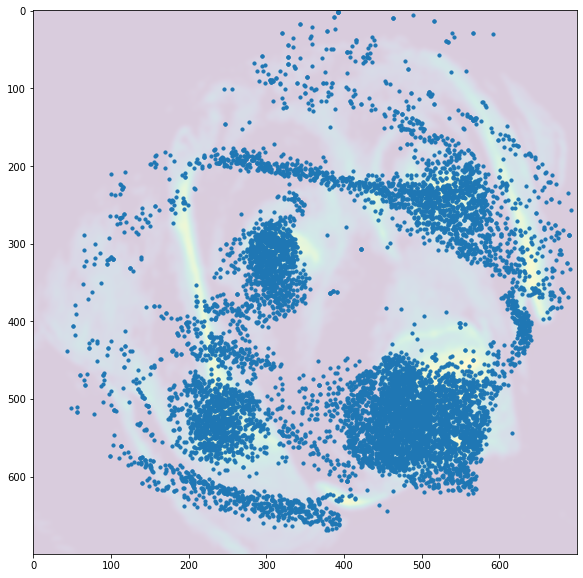

In [ ]:
## Couple of different strategies: use multiple runs from one sample vs. use a run from multiple samples
from tqdm import tqdm

d = 2  # dimensionality 
n_iter = 10000
k = 40
epsilon = 0.9

sampled_outputs = onp.zeros((1, n_iter, 2), dtype=density.dtype)
key = jax.random.PRNGKey(1)
key, subkey = jax.random.split(key)
init_sample = sample_from_image_density(1, density, subkey).flatten()

with tqdm(total=n_iter) as pbar:
  for i in range(n_iter):
      init_sample = hamiltonian_monte_carlo(init_sample, energy_fn, k, epsilon)
      sampled_outputs[0, i] = init_sample
      pbar.update(1)

import numpy as onp

onp.savez(
    f"/content/drive/MyDrive/CS699/homework #2/labrador_iter10000_k40_e09.npy",
    sample=sampled_outputs
)

fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sampled_outputs[:, :, 0], sampled_outputs[:, :, 1], s=10)
ax.imshow(density, alpha=0.2)
matplotlib.pyplot.show()